# Bishop Basement Model

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import string

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    inversion,
    optimization,
    plotting,
    regional,
    synthetic,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

# Get data

Here we will load a commonly used synthetic gravity and basement topography model, called the `Bishop Model`. It includes topography of the Moho and the sediment-basement contact, and the forward modelled gravity effect of each, providing a synthetic observed gravity dataset. The forward gravity is calculated with 6 layers of sediment which increase in density from 2100 kg/m3 at 0m to 2600 kg/m3 at the basement surface. Then 3 layers of increasing density from 2700 kg/m3 to 3300 kg/m3 at the Moho surface. 

In [2]:
grid = synthetic.load_bishop_model(coarsen_factor=50)  # 20)
polar_utils.get_grid_info(grid.gravity, print_info=True)
grid

grid spacing: 10000.0 m
grid region: (6900.0, 376900.0, 145900.0, 535900.0)
grid zmin: 91.2694015503
grid zmax: 148.650238037
grid registration: g


<xarray.Dataset> Size: 37kB
Dimensions:        (northing: 40, easting: 38)
Coordinates:
  * easting        (easting) float64 304B 6.9e+03 1.69e+04 ... 3.769e+05
  * northing       (northing) float64 320B 1.459e+05 1.559e+05 ... 5.359e+05
Data variables:
    basement_topo  (northing, easting) float64 12kB -6.199e+03 ... -8.133e+03
    moho_topo      (northing, easting) float64 12kB -2.767e+04 ... -2.548e+04
    gravity        (northing, easting) float64 12kB 99.08 99.3 ... 108.4 107.0

# Define model domain parameters
To account for edge effects (decreasing gravity towards the edge of prism model), we will use a buffer region and a smaller inversion region so the prism model edge is further away from the inversion domain.

In [3]:
grav_spacing = polar_utils.get_grid_info(grid.gravity)[0]
topo_spacing = polar_utils.get_grid_info(grid.basement_topo)[0]

buffer_region = vd.get_region(
    (grid.basement_topo.easting.values, grid.basement_topo.northing.values),
)
inversion_region = vd.pad_region(buffer_region, -topo_spacing * 4)

print(f"gravity spacing: {grav_spacing}m")
print(f"topography spacing: {topo_spacing}m")

gravity spacing: 10000.0m
topography spacing: 10000.0m


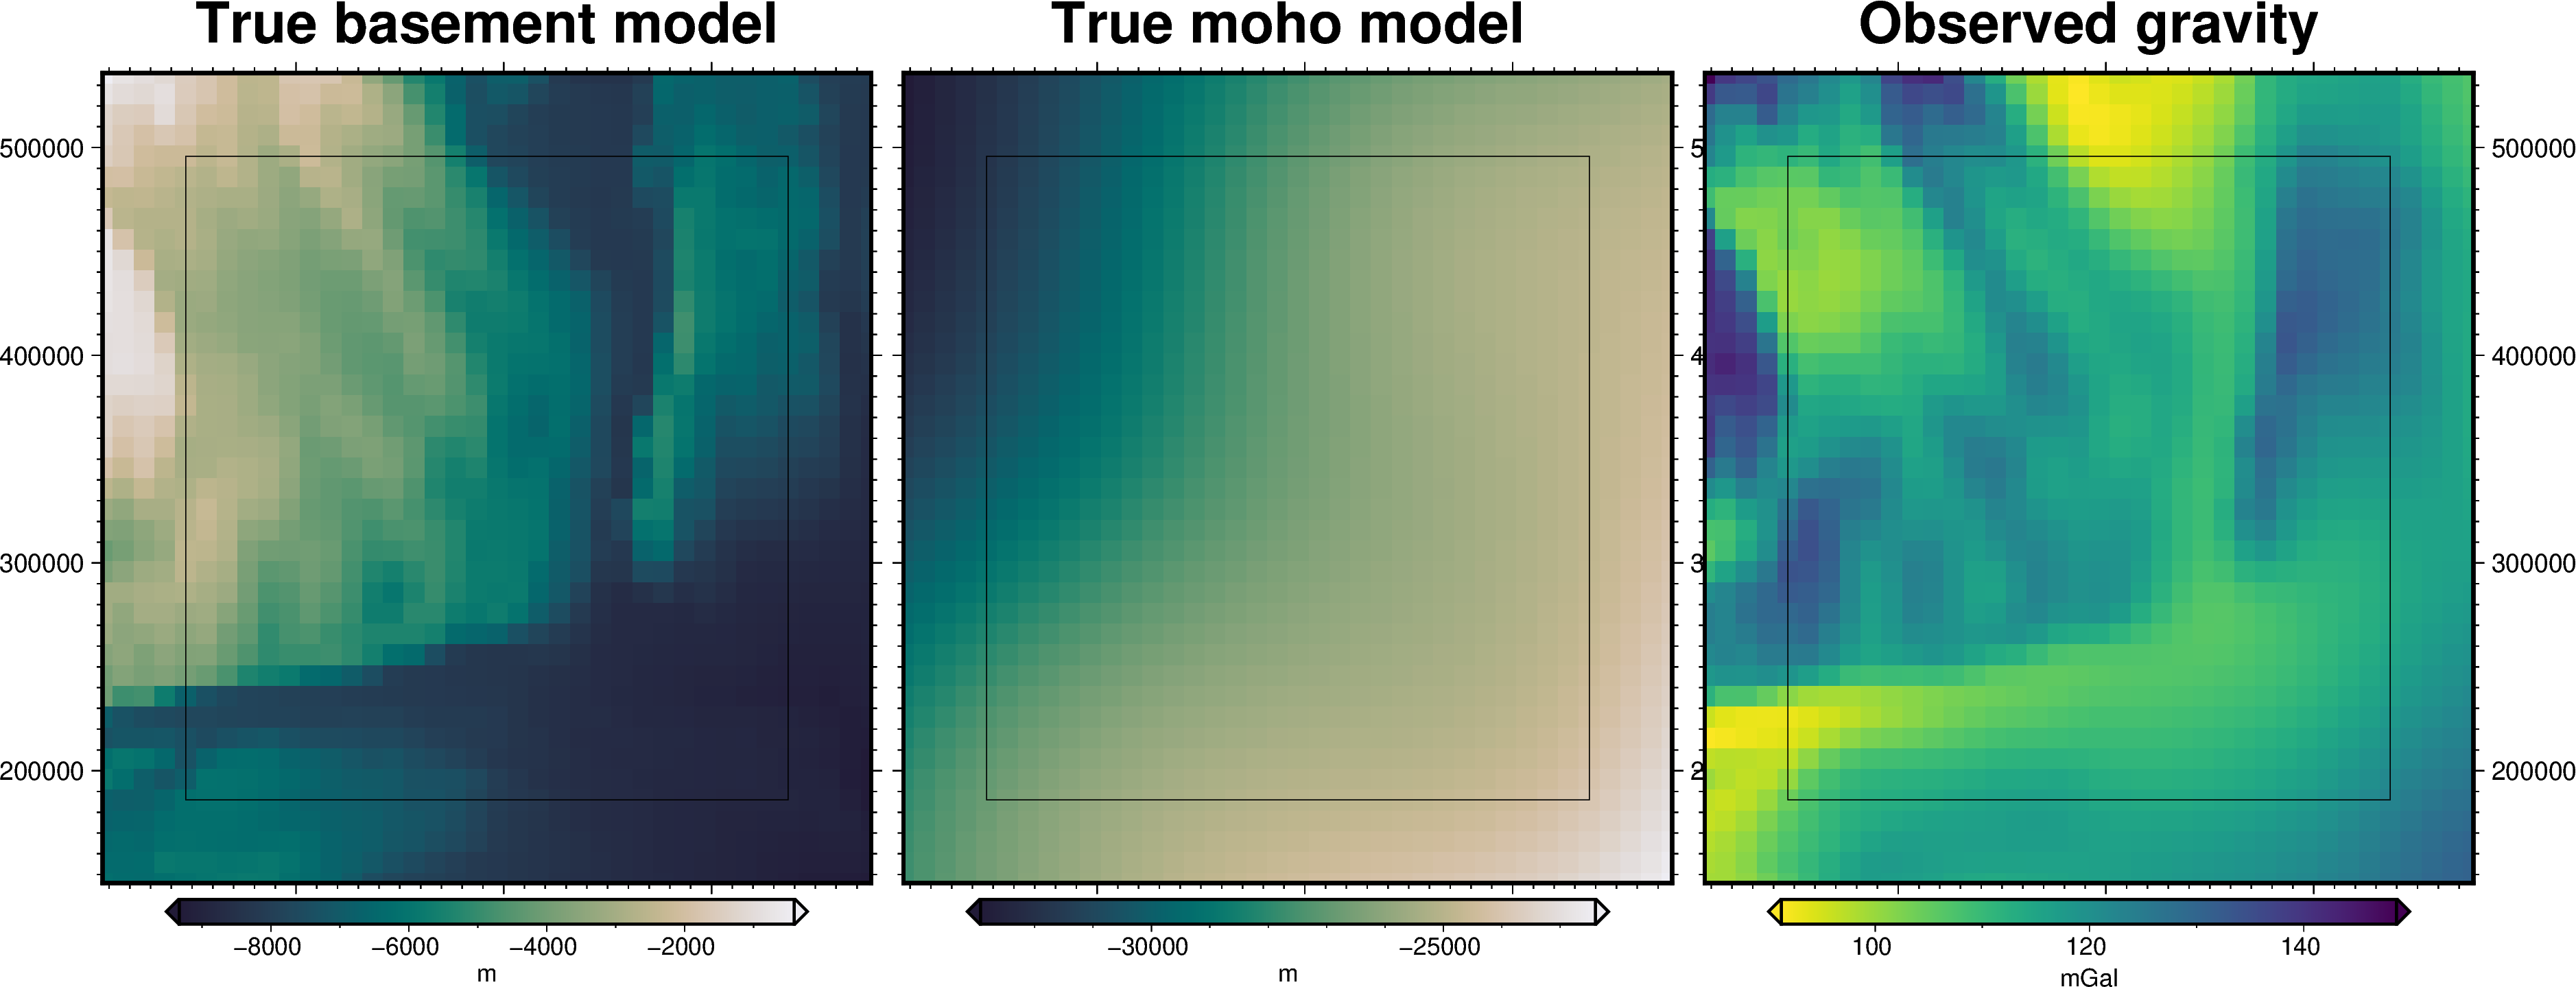

In [4]:
fig = maps.plot_grd(
    grid.basement_topo,
    fig_height=10,
    title="True basement model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig = maps.plot_grd(
    grid.moho_topo,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="True moho model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig = maps.plot_grd(
    grid.gravity,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Observed gravity",
    reverse_cpt=True,
    cmap="viridis",
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig.show()

# Observed gravity data

In this scenario, we are treating the area as having no surface topography (surface elevation is flat and equal to the ellipsoid). In this case, there is no terrain mass effect, and therefore the gravity disturbance is equal to the topo-free disturbance.

In [5]:
# subset gravity to within inversion region
grav_grid = polar_utils.subset_grid(
    grid.gravity,
    region=inversion_region,
)
grav_df = grav_grid.rename("gravity_anomaly").to_dataframe().reset_index()

# contaminate gravity with 0.2 mGal of random noise
grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
    grav_df.gravity_anomaly,
    stddev=0.2,
    percent=False,
    seed=0,
)
grav_df["uncert"] = stddev

grav_df["upward"] = 10
grav_df

INFO:invert4geom:Standard deviation used for noise: [0.2]


northing   easting  gravity_anomaly  uncert  upward
0    185900.0   46900.0       104.232718     0.2      10
1    185900.0   56900.0       107.751812     0.2      10
2    185900.0   66900.0       110.337820     0.2      10
3    185900.0   76900.0       111.850848     0.2      10
4    185900.0   86900.0       112.625426     0.2      10
..        ...       ...              ...     ...     ...
955  495900.0  296900.0       123.107794     0.2      10
956  495900.0  306900.0       122.626074     0.2      10
957  495900.0  316900.0       121.444072     0.2      10
958  495900.0  326900.0       120.206503     0.2      10
959  495900.0  336900.0       119.462903     0.2      10

[960 rows x 5 columns]

# Create "a-priori" basement measurements

In [6]:
# create 25 random point within the outcropping basement region
num_constraints = 25
coords = vd.scatter_points(
    region=vd.pad_region(inversion_region, -10e3),
    size=num_constraints,
    random_state=22,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    grid.basement_topo,
    "true_upward",
    coord_names=("easting", "northing"),
)

constraint_points["upward"] = constraint_points.true_upward
constraint_points.head()

easting       northing  true_upward       upward
0  113184.345087  365343.996515 -3846.732115 -3846.732115
1  186953.886676  399664.300471 -5400.310608 -5400.310608
2  170445.269535  228349.599846 -8158.583697 -8158.583697
3  288879.139601  463648.278495 -5403.841585 -5403.841585
4  103113.619475  482677.019420 -3074.687380 -3074.687380

In [7]:
# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

easting       northing  true_upward       upward      uncert  \
0  113184.345087  365343.996515 -3846.732115 -3837.059105   76.934642   
1  186953.886676  399664.300471 -5400.310608 -5414.578754  108.006212   
2  170445.269535  228349.599846 -8158.583697 -8054.084862  163.171674   
3  288879.139601  463648.278495 -5403.841585 -5392.504312  108.076832   
4  103113.619475  482677.019420 -3074.687380 -3107.627698   61.493748   

     weight  
0  0.000169  
1  0.000086  
2  0.000038  
3  0.000086  
4  0.000264

# Create starting basement model

In [8]:
# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=topo_spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-40, 0, 200),
    weights=constraint_points.weight,
)

INFO:invert4geom:Best SplineCV score: 0.81756321334378
INFO:invert4geom:Best damping: 1.2898902612533134e-18


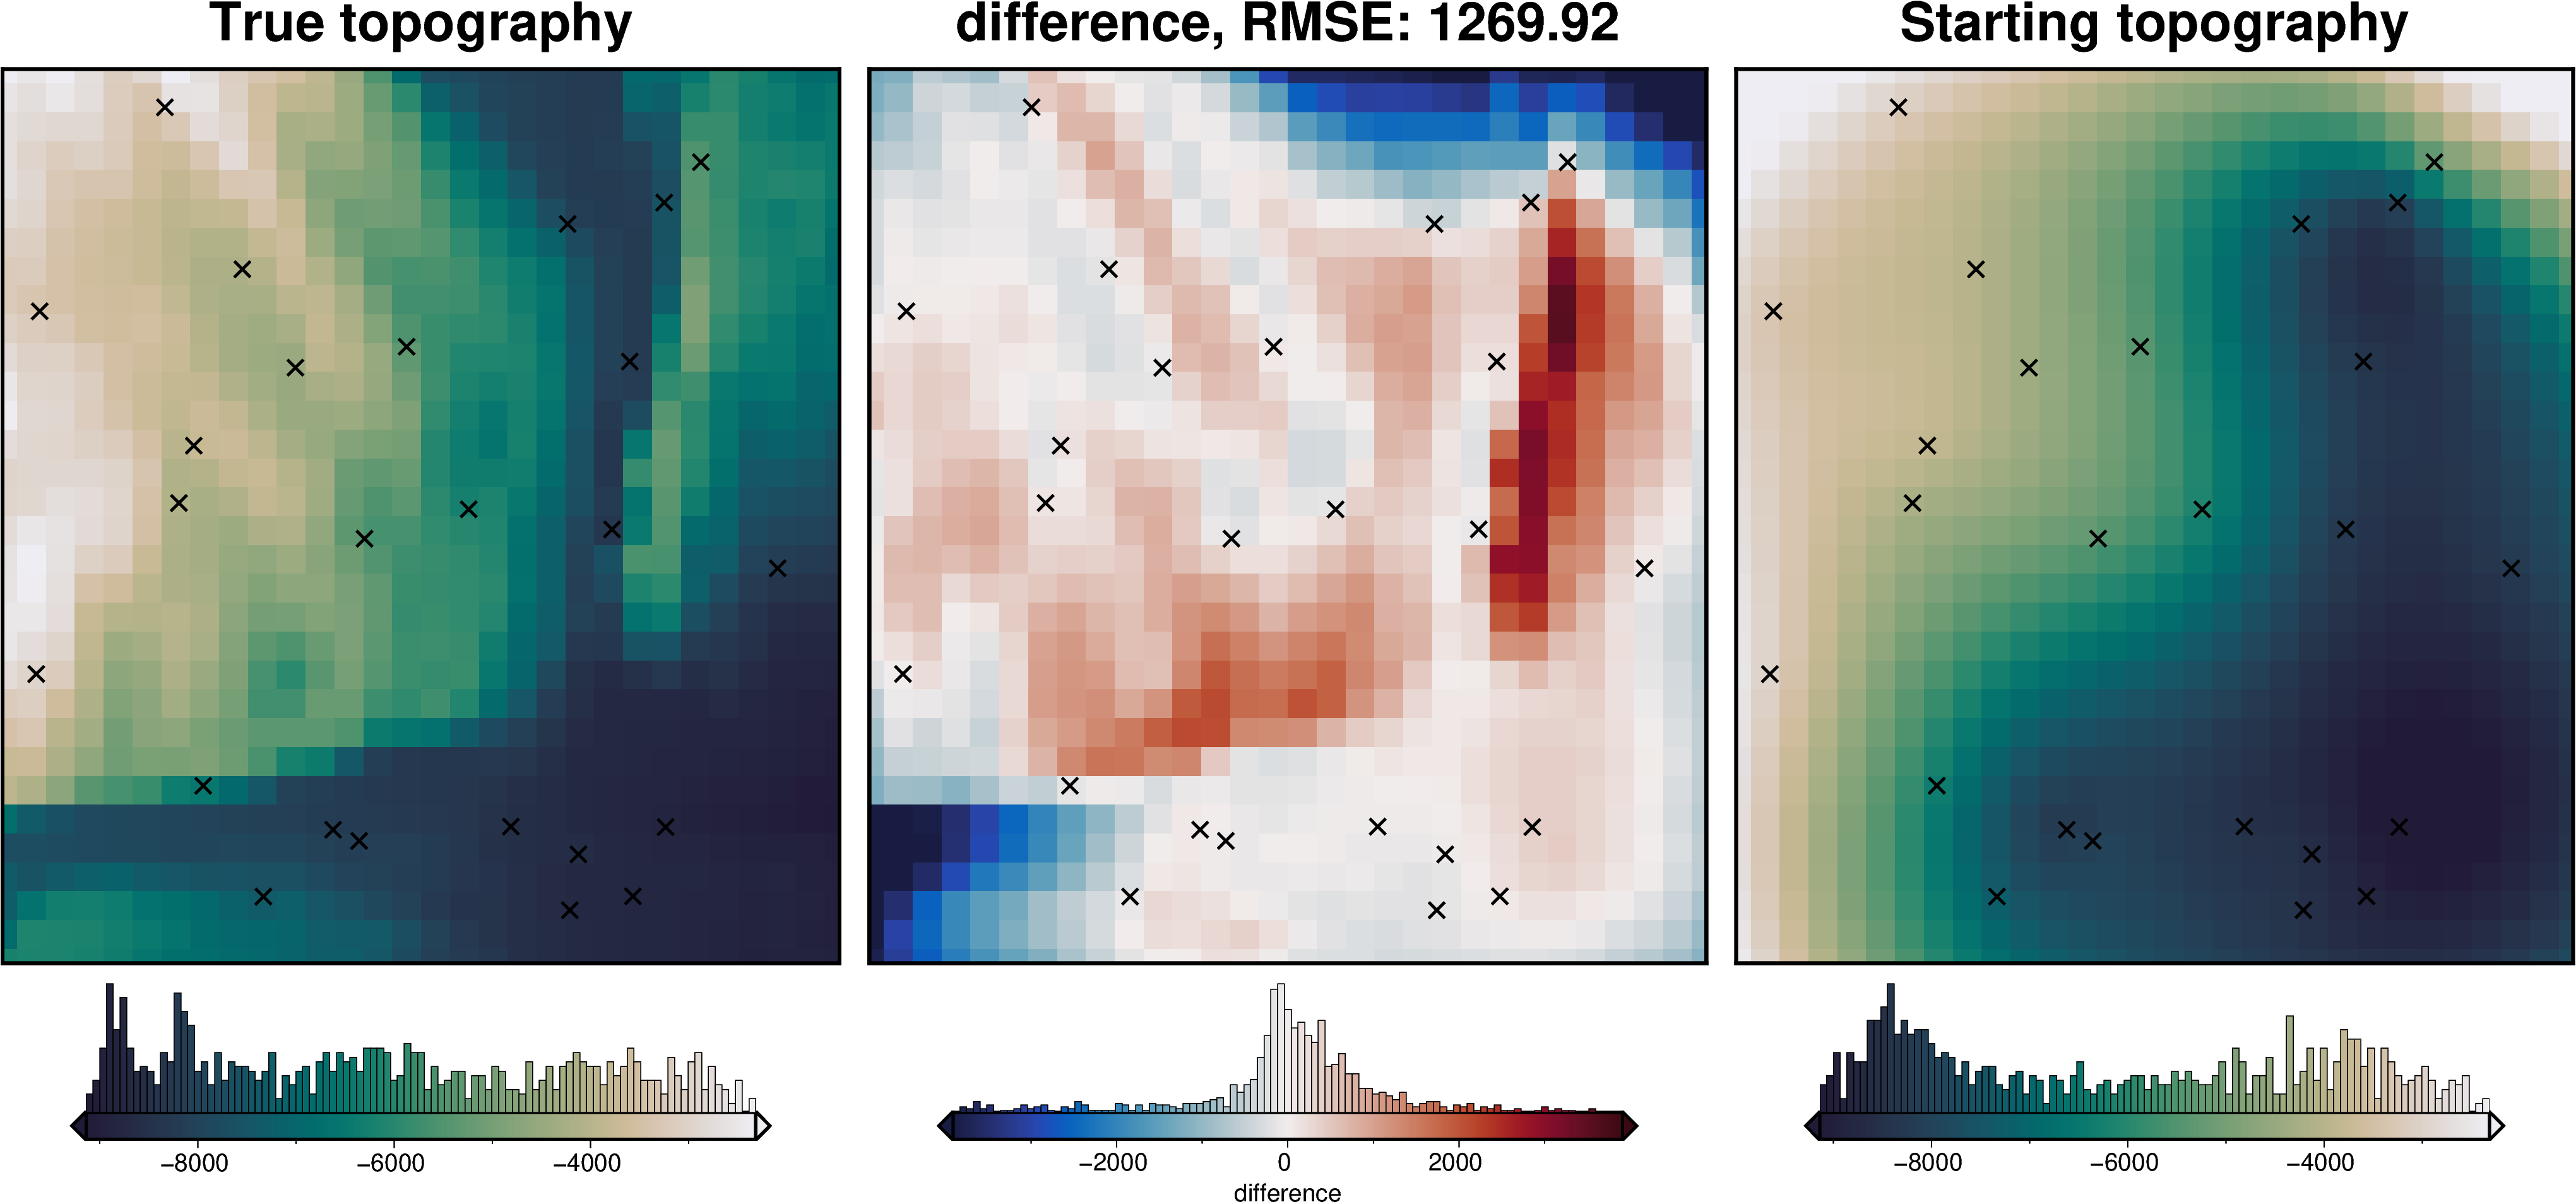

In [9]:
_ = polar_utils.grd_compare(
    grid.basement_topo,
    starting_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

In [10]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.starting_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 120.11 m


zref: -6501.09 m
density contrast: 500 kg/m^3


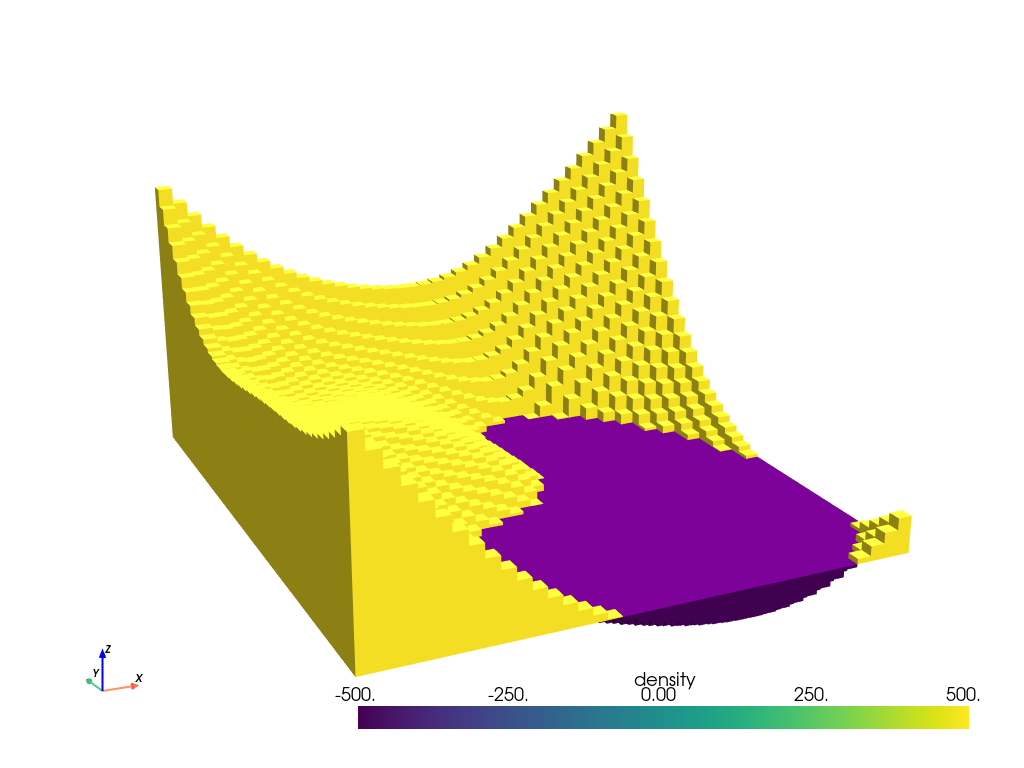

In [11]:
# pick a reference height for the basement
zref = constraint_points.upward.mean()
# zref=0
print(f"zref: {zref:.2f} m")

# pick a density contrast for the basement (crystalline basement - sedimentary rocks)
density_contrast = 2800 - 2300
print(f"density contrast: {density_contrast} kg/m^3")

density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

# Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

However, if we know nothing about the starting model, it can simply be a flat layer of zero thickness, as we will use here. In this case, the forward gravity would just be zero so there is no need to perform the forward modelling. The misfit is therefore just equal to the topo-free disturbance.

### Forward gravity of starting prism layer

In [12]:
# calculate forward gravity of starting prism layer
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df.describe()

  0%|          | 0/960 [00:00<?, ?it/s]

northing        easting  gravity_anomaly        uncert  upward  \
count     960.00000     960.000000       960.000000  9.600000e+02   960.0   
mean   340900.00000  191900.000000       114.520059  2.000000e-01    10.0   
std     92379.05319   86599.530158         7.763839  2.777004e-17     0.0   
min    185900.00000   46900.000000        93.175769  2.000000e-01    10.0   
25%    263400.00000  116900.000000       109.350741  2.000000e-01    10.0   
50%    340900.00000  191900.000000       114.195820  2.000000e-01    10.0   
75%    418400.00000  266900.000000       119.704207  2.000000e-01    10.0   
max    495900.00000  336900.000000       135.144510  2.000000e-01    10.0   

       starting_gravity  
count        960.000000  
mean          10.049049  
std           40.651796  
min          -50.677158  
25%          -29.109313  
50%            6.618459  
75%           47.120901  
max          113.264931

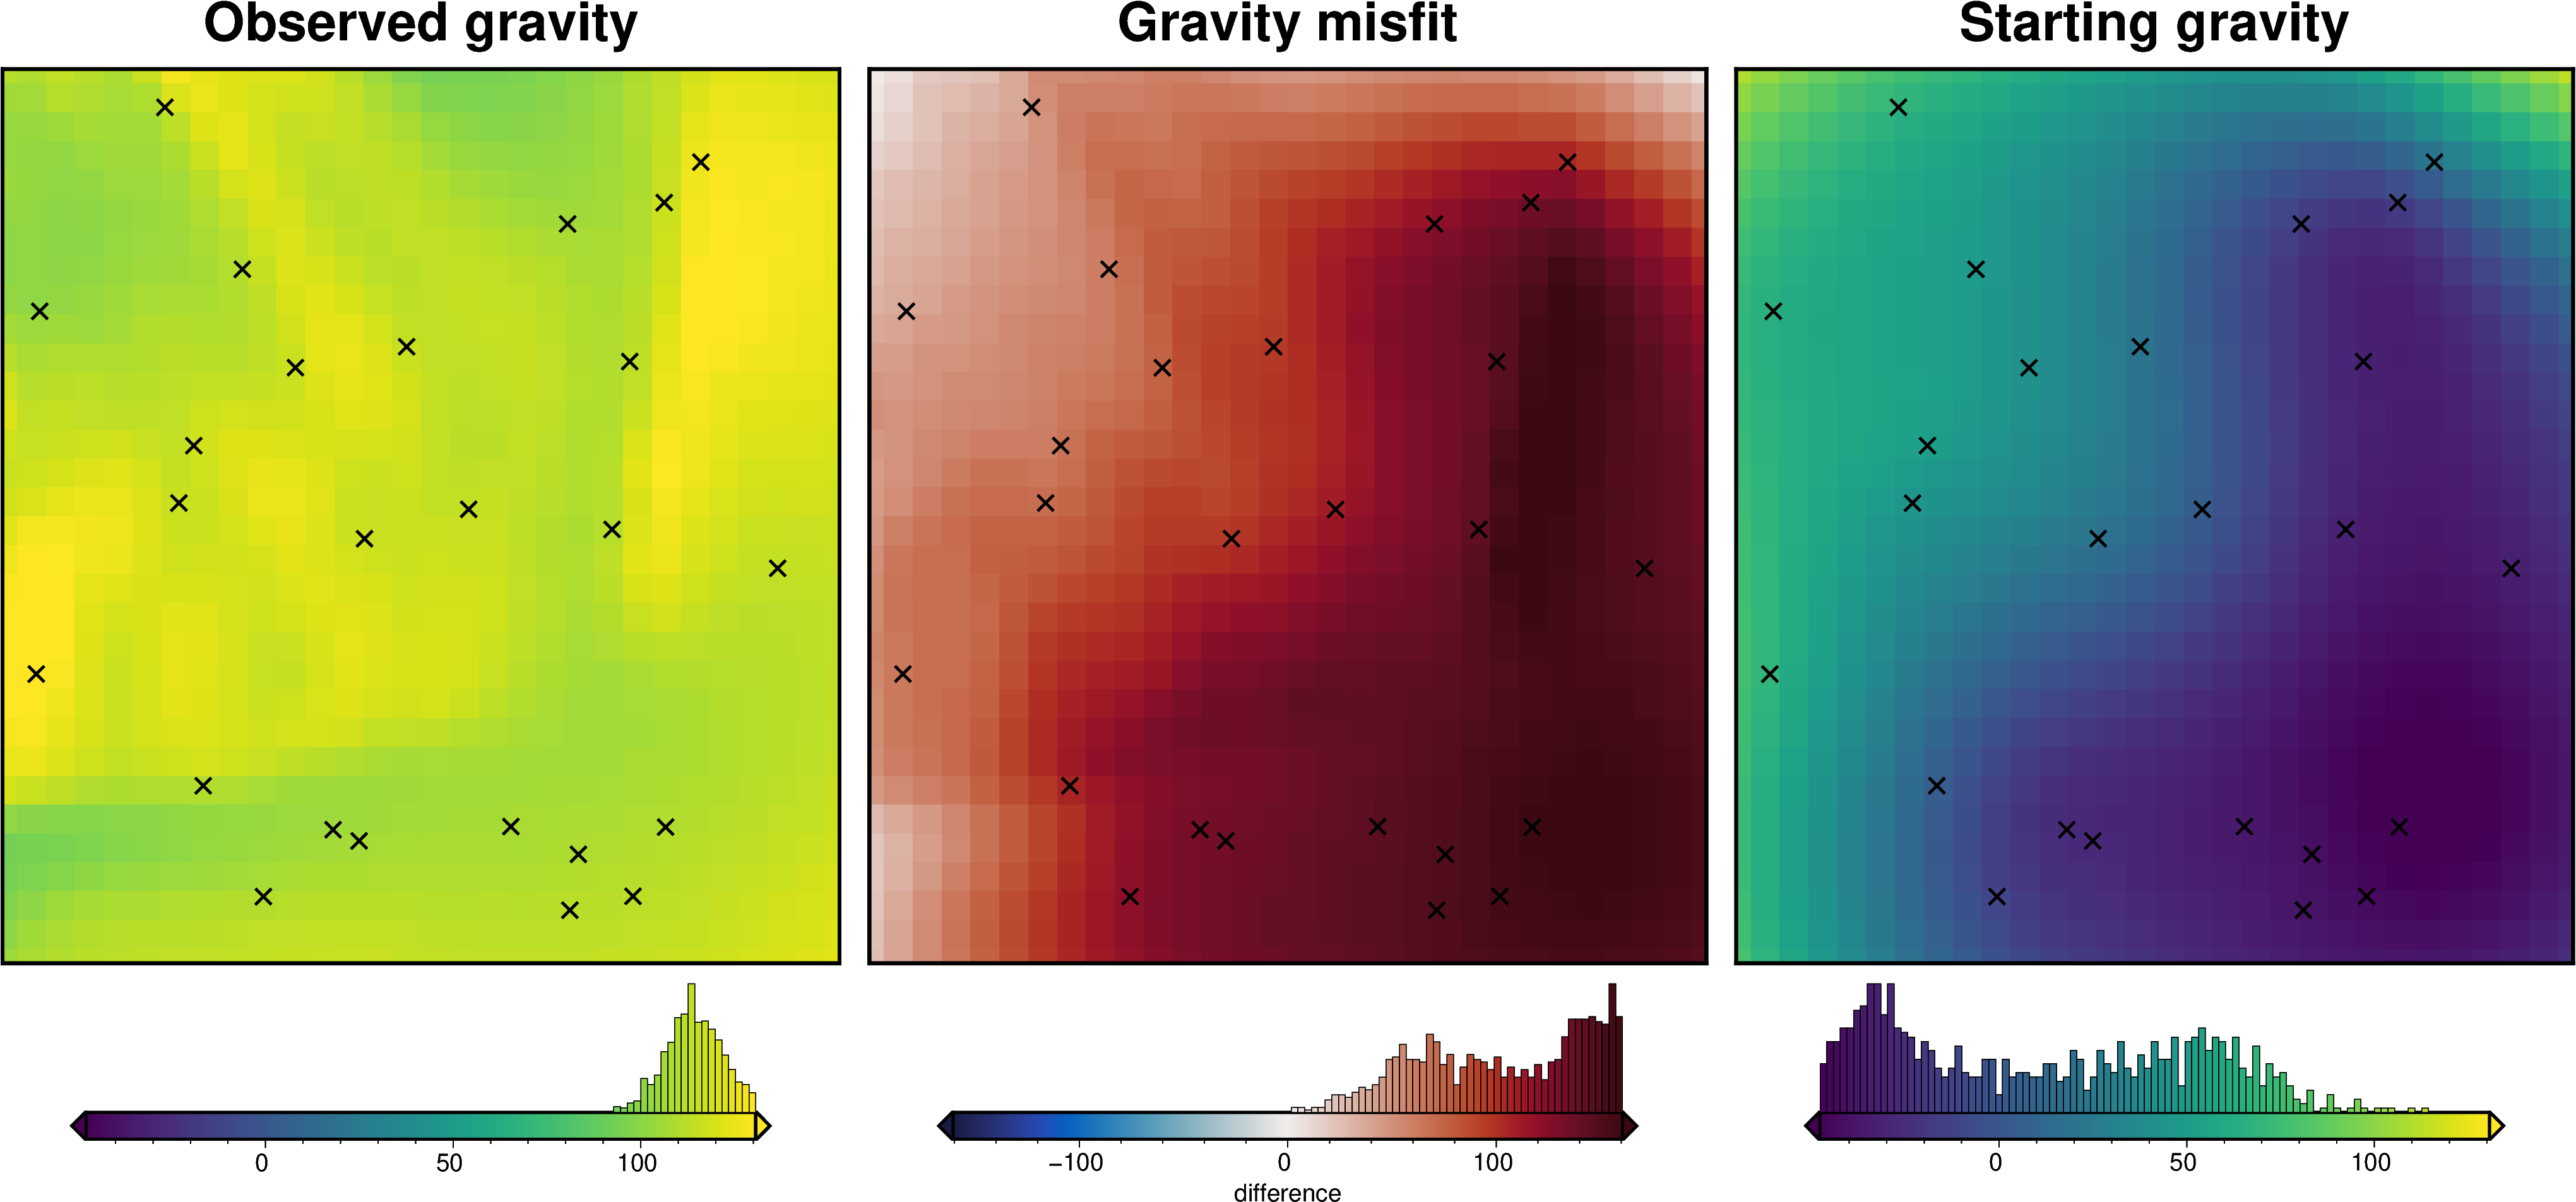

In [13]:
# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

_ = polar_utils.grd_compare(
    grav_grid.gravity_anomaly,
    grav_grid.starting_gravity,
    plot=True,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

# Damping parameter cross validation

## Regional estimation - constraint point minimization

In [14]:
# use the constraints to find the best regional field
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    constraints_weights_column="weight",
    cv=True,
    cv_kwargs=dict(
        n_trials=20,
        damping_limits=(1e-20, 10),
        progressbar=False,
        fname="tmp/regional_sep",
    ),
    depth="default",
    block_size=None,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)
grav_df.describe()

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 18
INFO:invert4geom:	parameter: {'damping': 8.385782616276809e-10}
INFO:invert4geom:	scores: [0.9757991304948286]


northing        easting  gravity_anomaly        uncert  upward  \
count     960.00000     960.000000       960.000000  9.600000e+02   960.0   
mean   340900.00000  191900.000000       114.520059  2.000000e-01    10.0   
std     92379.05319   86599.530158         7.763839  2.777004e-17     0.0   
min    185900.00000   46900.000000        93.175769  2.000000e-01    10.0   
25%    263400.00000  116900.000000       109.350741  2.000000e-01    10.0   
50%    340900.00000  191900.000000       114.195820  2.000000e-01    10.0   
75%    418400.00000  266900.000000       119.704207  2.000000e-01    10.0   
max    495900.00000  336900.000000       135.144510  2.000000e-01    10.0   

       starting_gravity      misfit         reg         res  
count        960.000000  960.000000  960.000000  960.000000  
mean          10.049049  104.471010  105.662705   -1.191695  
std           40.651796   41.189325   37.457980    9.628842  
min          -50.677158    2.094102   33.866228  -46.709259  
25%          -29.109313   69.000089   73.956689   -2.211829  
50%            6.618459  107.814994  108.125825    0.231672  
75%           47.120901  142.287605  140.689442    3.368564  
max          113.264931  165.193439  162.384274   18.862938

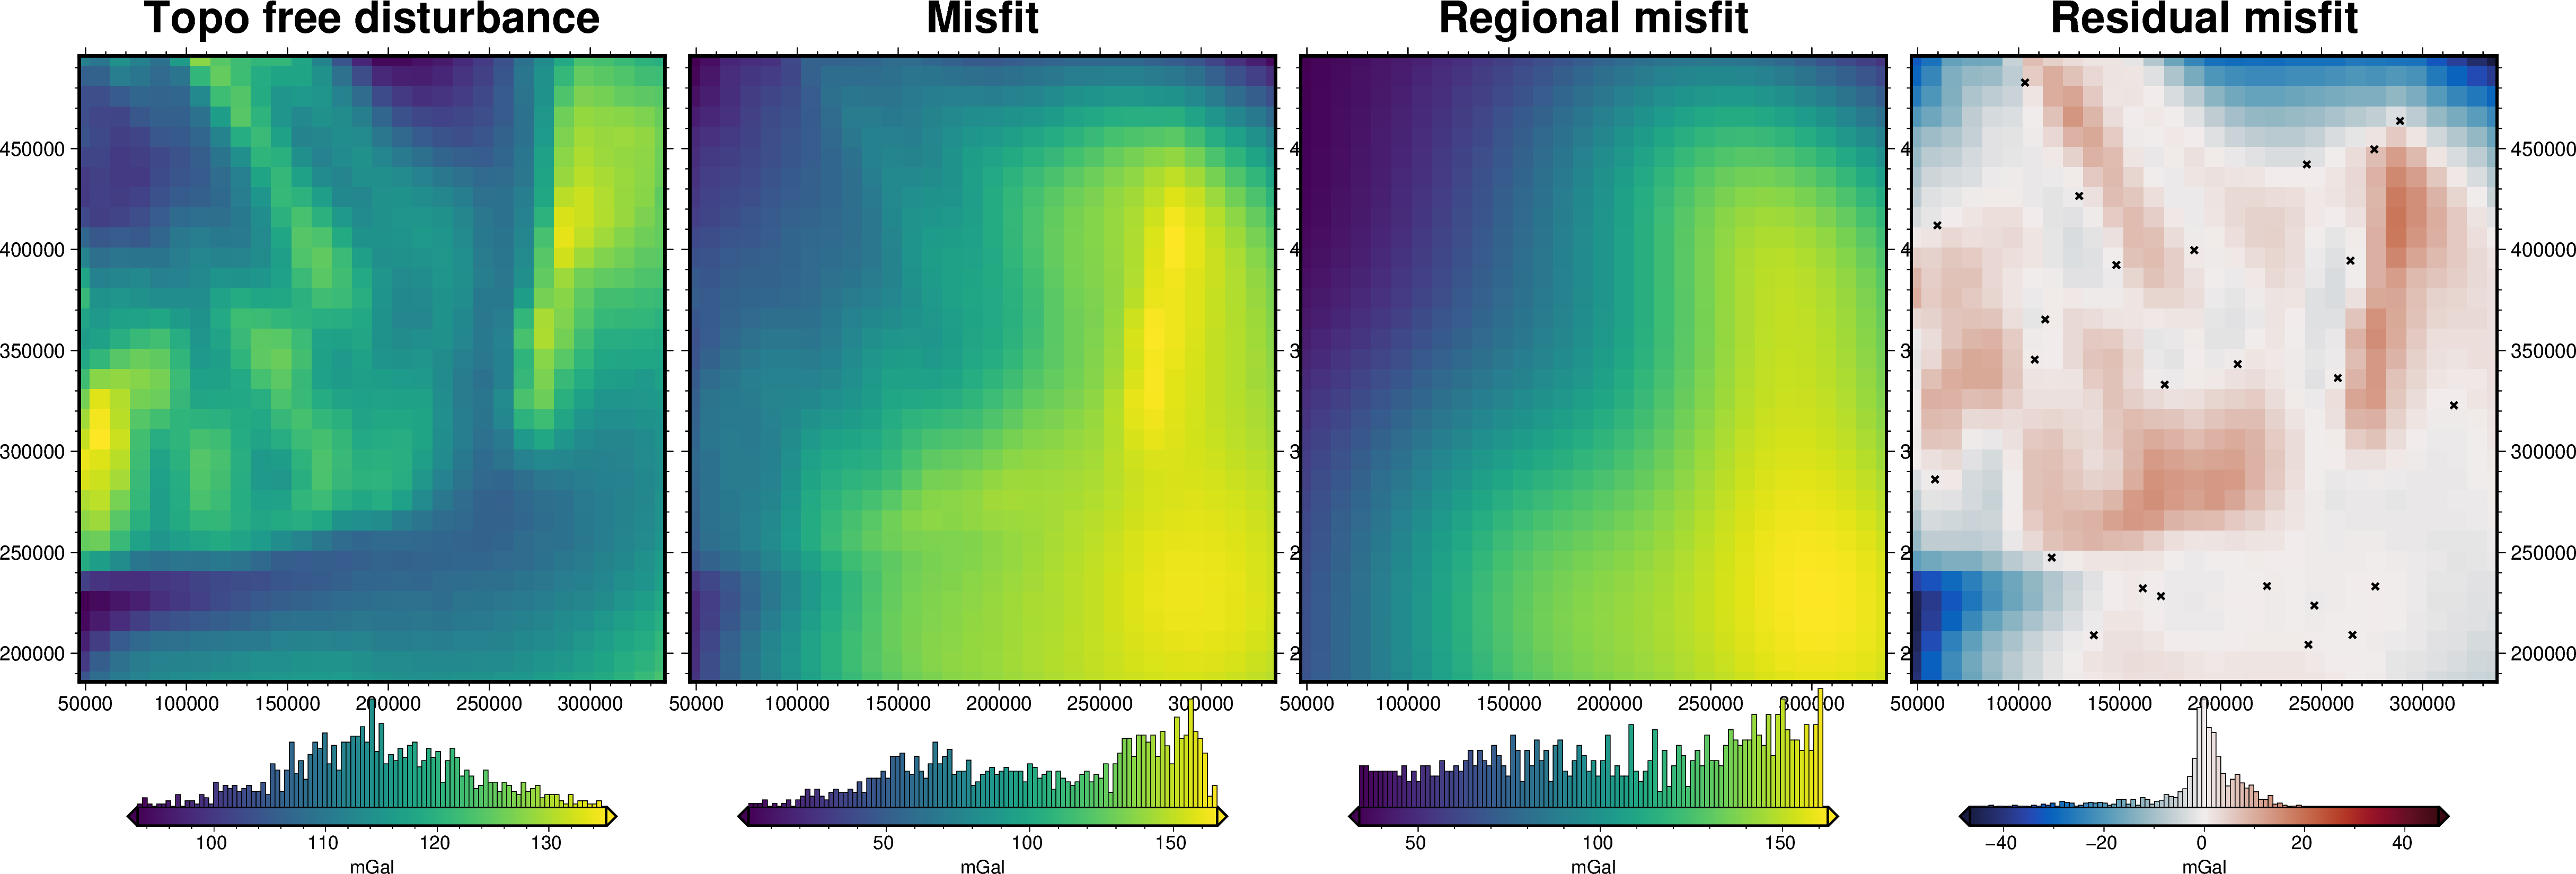

In [15]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)
fig.show()

## Single inversion
Perform a single inversion to experiment with values of stopping criteria.

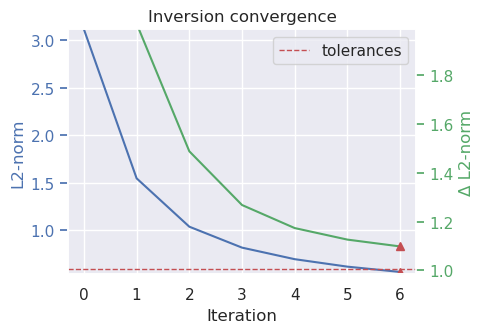

In [16]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.6,
    "delta_l2_norm_tolerance": 1.008,
}

# run the inversion workflow, including a cross validation for the damping parameter
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    solver_damping=0.01,
    fname="tmp/bishop_model",
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    **kwargs,
)

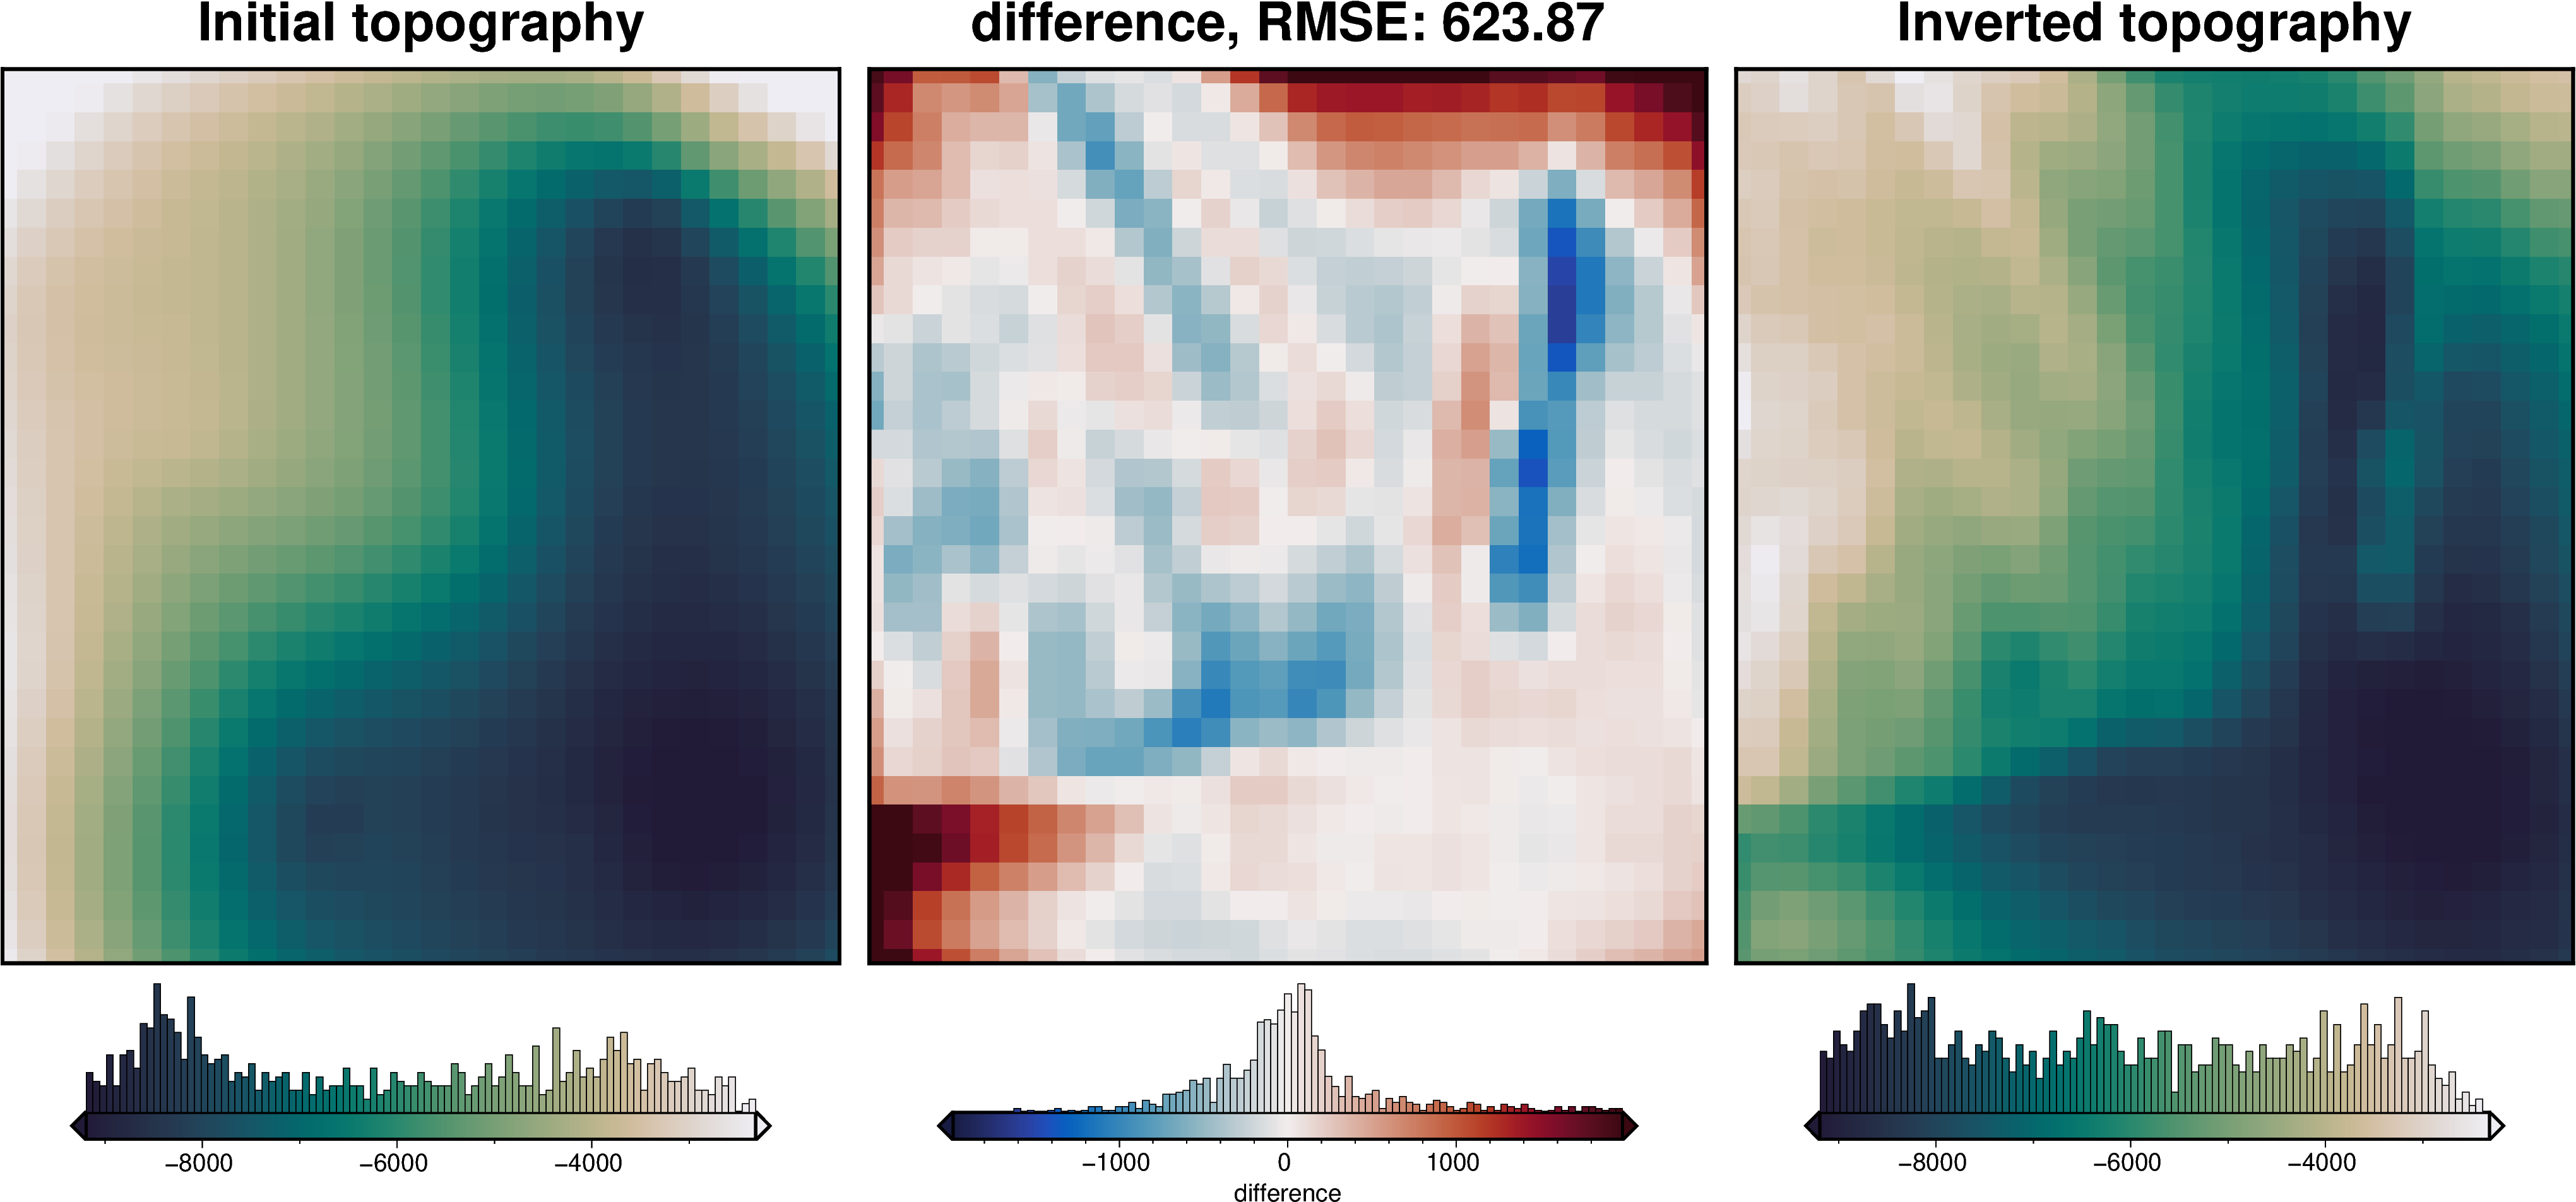

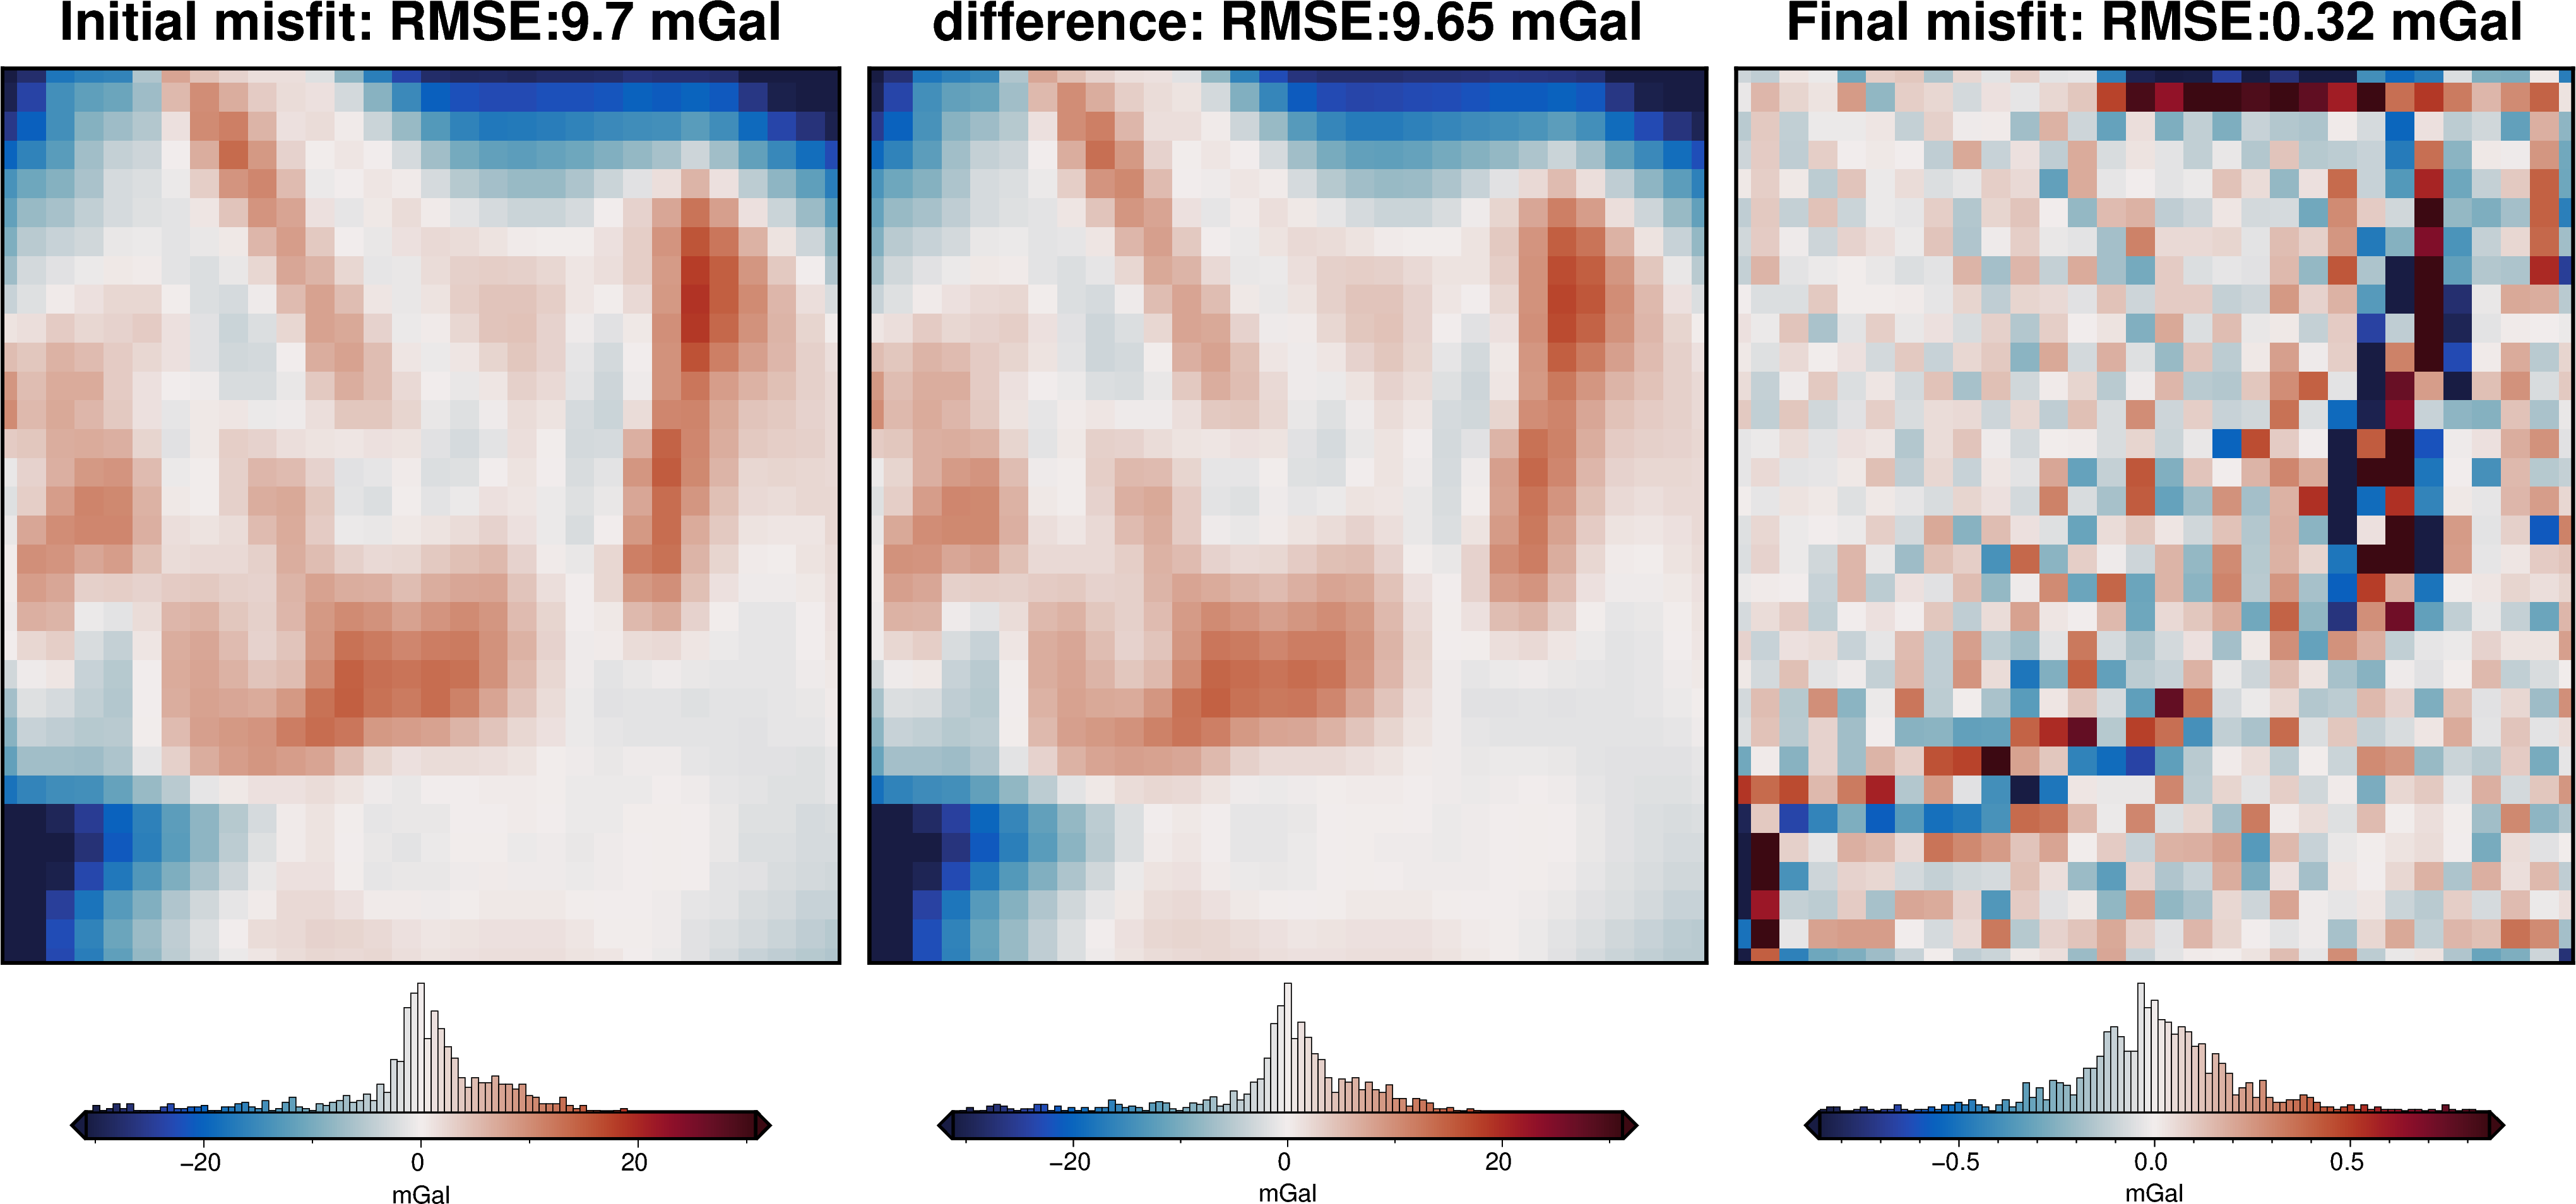

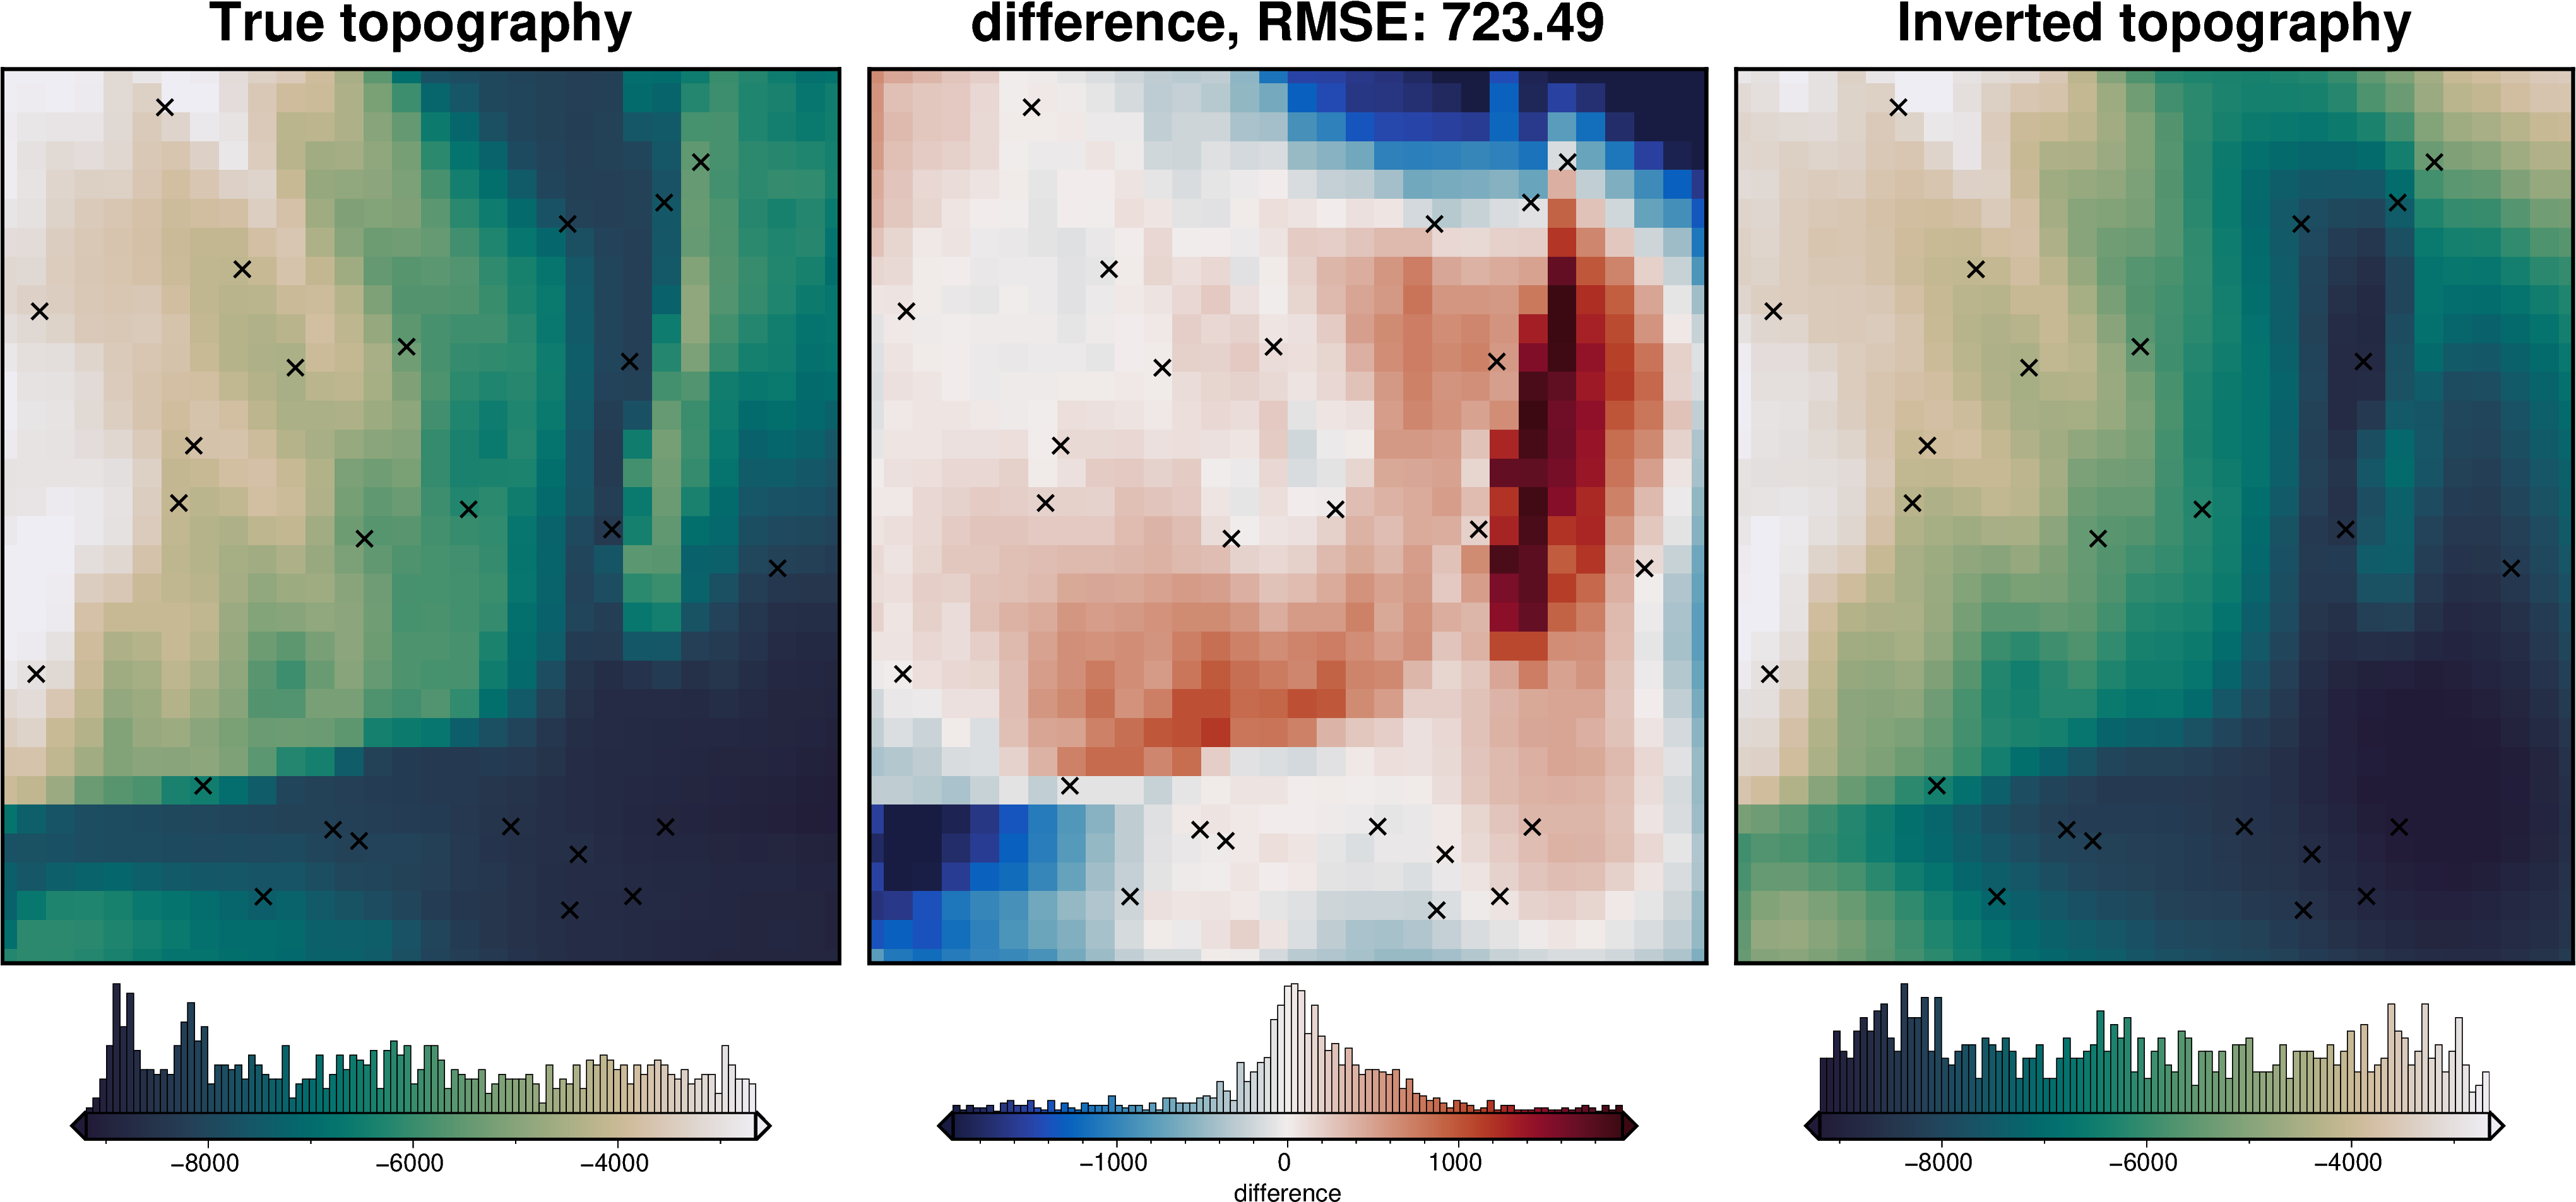

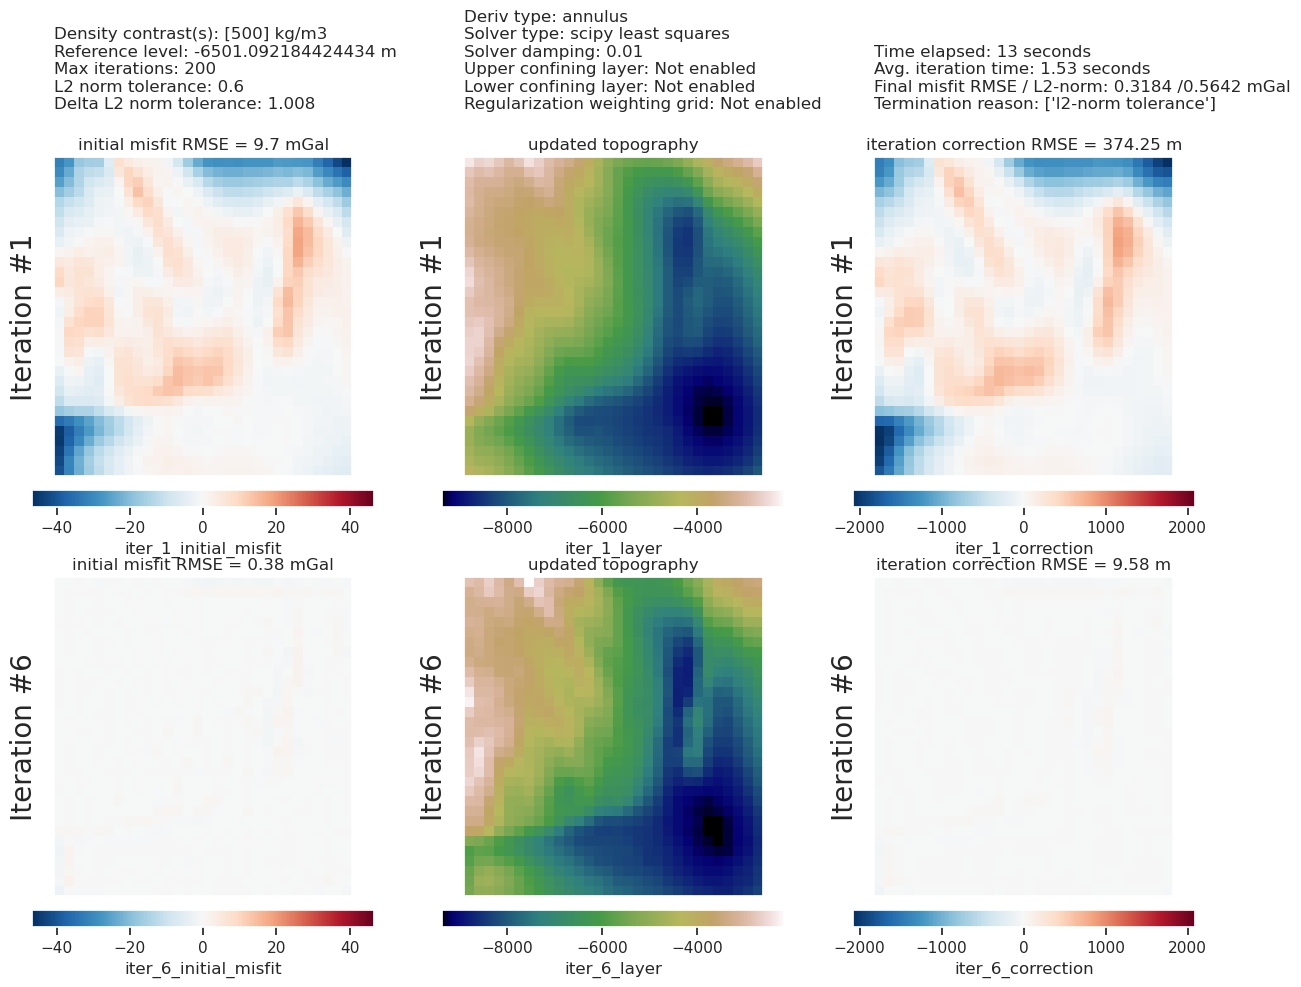

In [17]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    grid.basement_topo,
    final_topography,
    plot=True,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

## Cross-validation

INFO:invert4geom:saving all results with root name 'tmp/bishop_model'
INFO:invert4geom:running damping cross validation


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.0063216575074670316}
INFO:invert4geom:	scores: [0.2750572623331375]
INFO:invert4geom:results saved to tmp/bishop_model_results.pickle.pickle


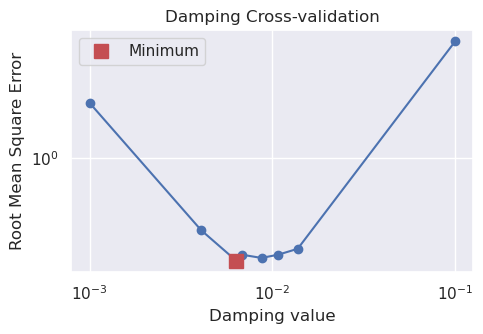

In [18]:
# run the inversion workflow, including a cross validation for the damping parameter
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    plot_cv=True,
    fname="tmp/bishop_model",
    starting_prisms=starting_prisms,
    # score_as_median=True,
    # for creating test/train splits
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    **kwargs,
)

In [19]:
# to re-load the study from the saved pickle file
with pathlib.Path("tmp/bishop_model_damping_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("tmp/bishop_model_damping_cv_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

In [20]:
best_damping = study.best_params.get("damping")
best_damping

0.0063216575074670316

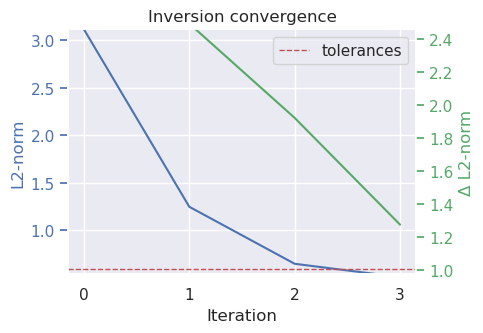

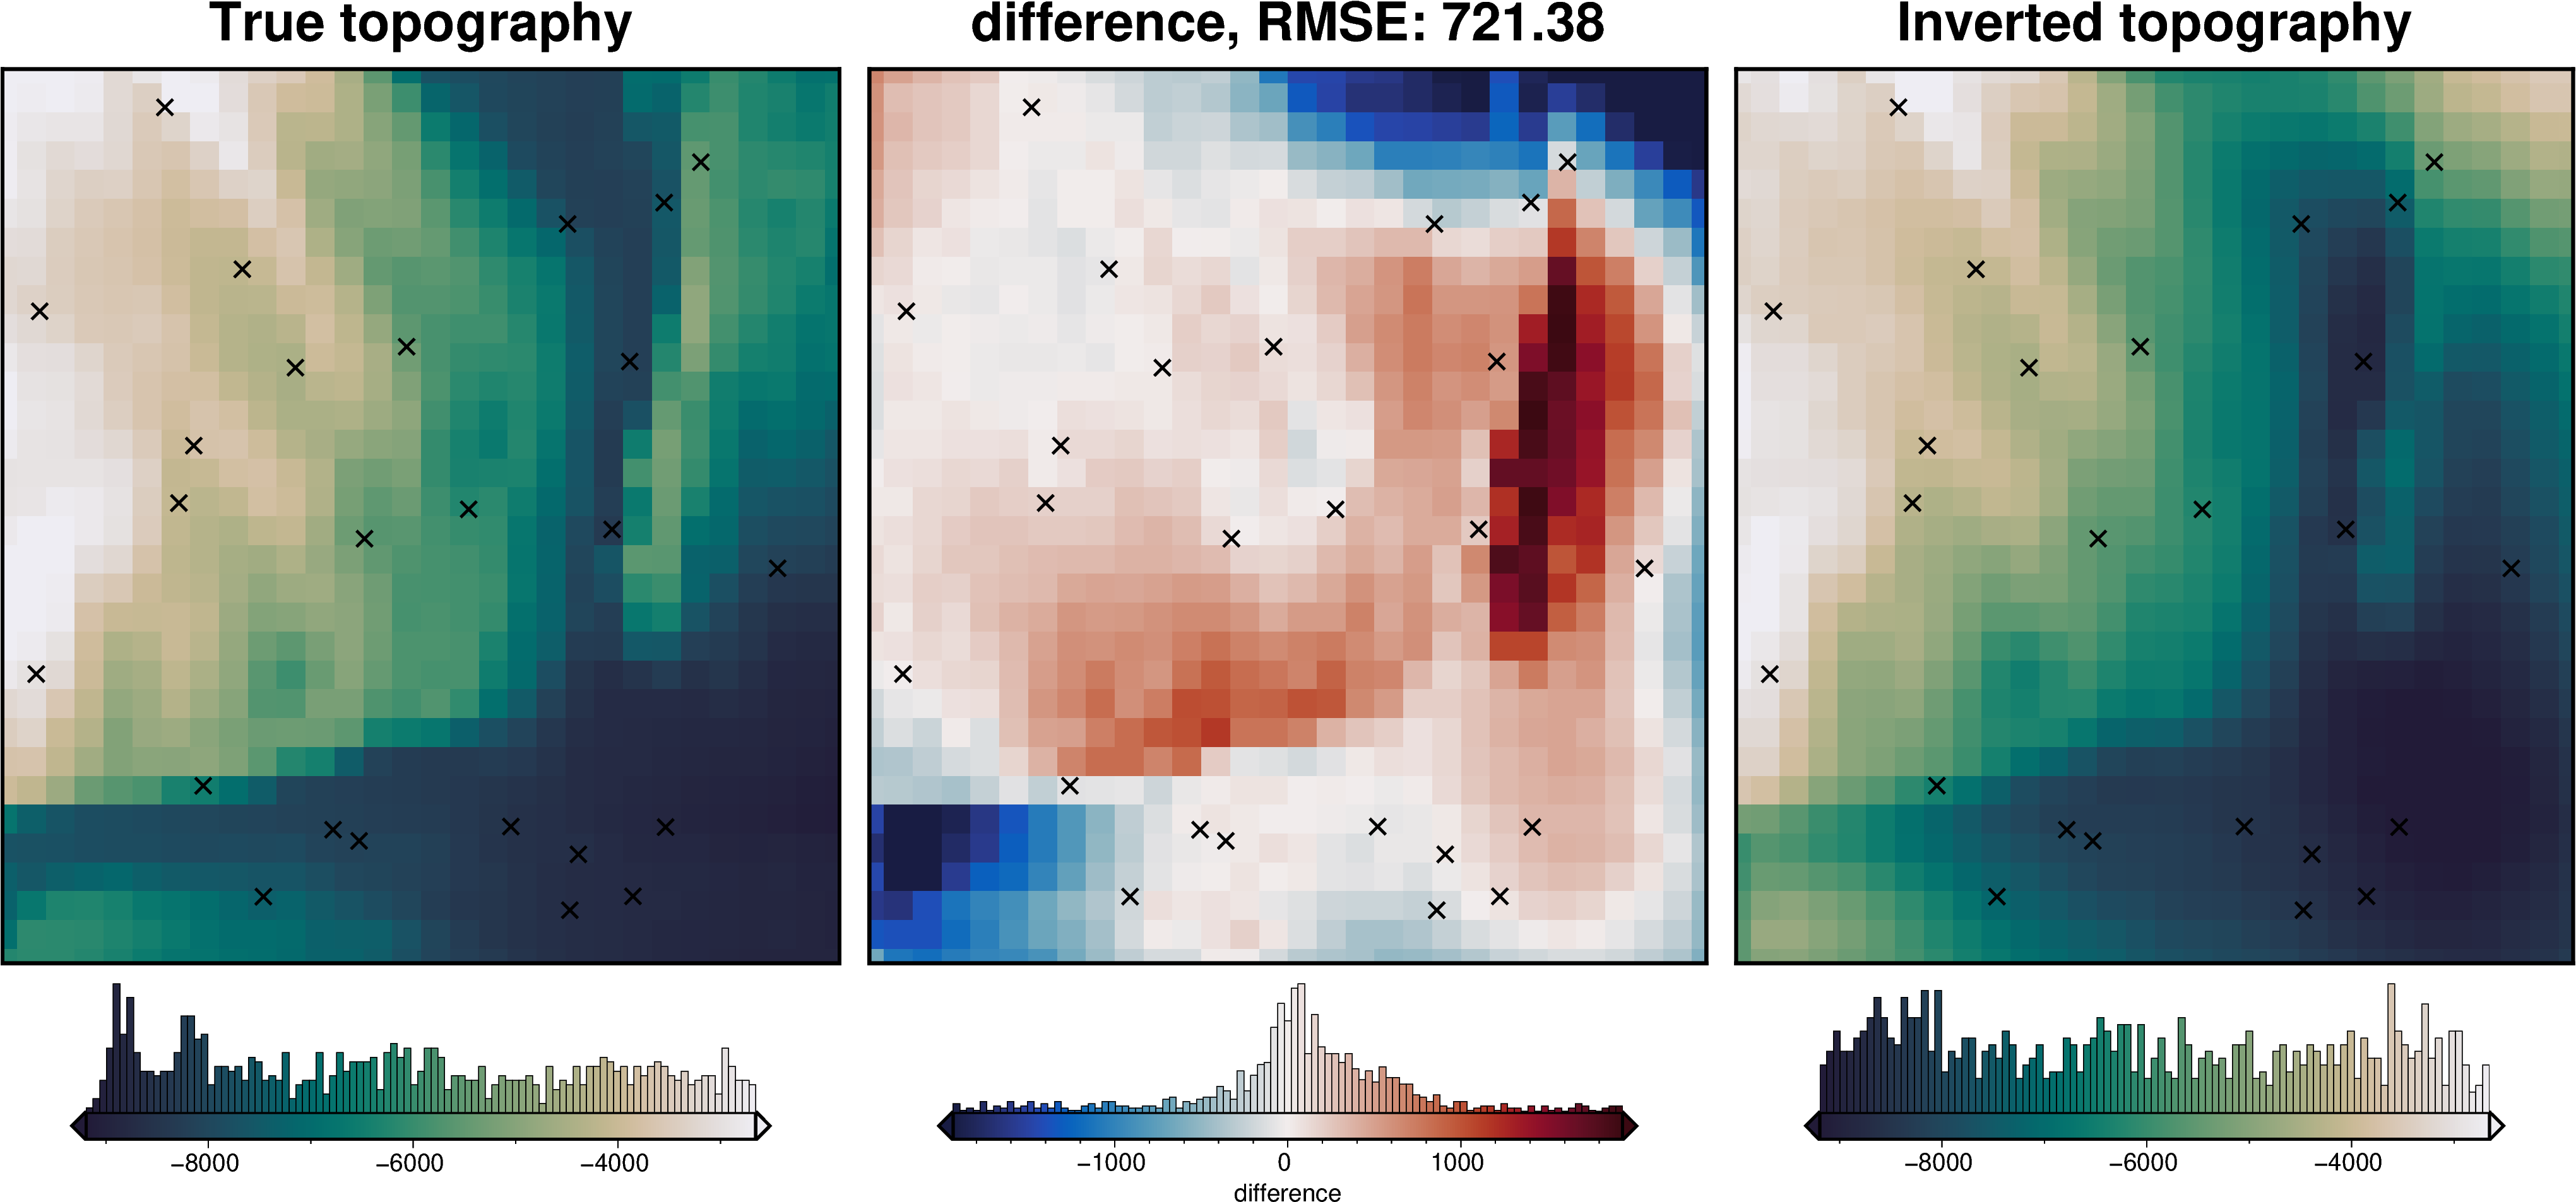

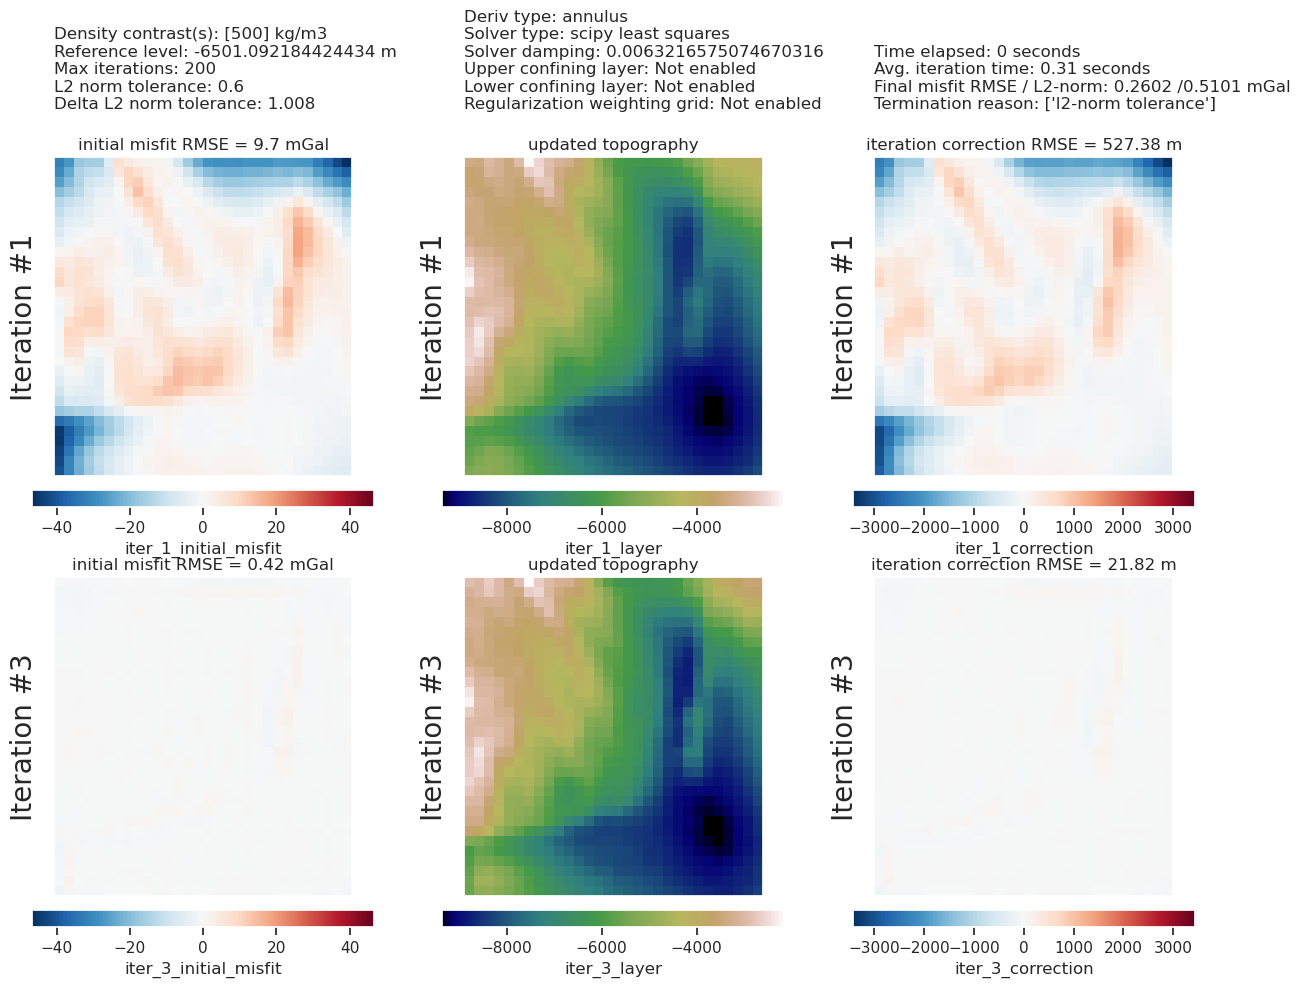

In [21]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_convergence(
    grav_results,
    parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=False,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    grid.basement_topo,
    final_topography,
    plot=True,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

In [22]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 178.79 m


# Density contrast / Zref cross validation
Since this cross validation uses the inversion error at constraint points, we can't use the constraint point minimization technique to estimate the regional field since that inherently sets the inversion error at constraints to zero, invalidating the cross validation scores. 

There are two options for how to get around this issue:
1) use a different regional estimation technique while finding the optimal density contrast value, then use the found optimal values with the constraint point minimization regional estimation technique afterwards. 
2) separate the constraints into testing and training sets, so that only the training set is used during the regional separation, and only the testing set is used for scoring the density contrast cross validation. 

Well perform both methods below:

## 1) Use alternative regional estimation method

We will use the equivalent sources technique to estimate the regional field, and then perform a cross-validation for the density contrast and reference level values. During this CV, we will use the optimal damping parameter value found above. Once we have found the optimal zref and density contrast values, we will need to use then in a separate inversion which had the regional field estimated with the better constraint point minimization technique.

### Density CV

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 5
INFO:invert4geom:	parameter: {'density_contrast': 298.9108990953807}
INFO:invert4geom:	scores: [1912.1422528424134]


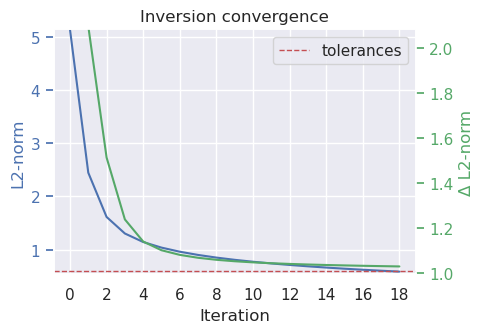

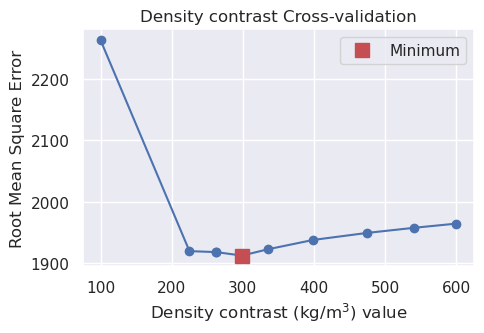

In [23]:
# run the cross validation for density
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    solver_damping=best_damping,
    constraints_df=constraint_points,
    density_contrast_limits=(100, 600),
    zref=constraint_points.upward.mean(),
    n_trials=10,
    # grid_search=True,
    starting_topography=starting_topography,
    regional_grav_kwargs=dict(
        method="constant",
        constraints_df=constraint_points,
    ),
    # grid_search=True,
    fname="tmp/bishop_model_density_cv",
    # score_as_median=True,
    **kwargs,
)

In [24]:
# to re-load the study from the saved pickle file
with pathlib.Path("tmp/bishop_model_density_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

In [25]:
best_density_contrast = study.best_params.get("density_contrast", None)
best_density_contrast

298.9108990953807

### Zref CV

  0%|          | 0/15 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'zref': -50.0}
INFO:invert4geom:	scores: [1879.8588254118574]


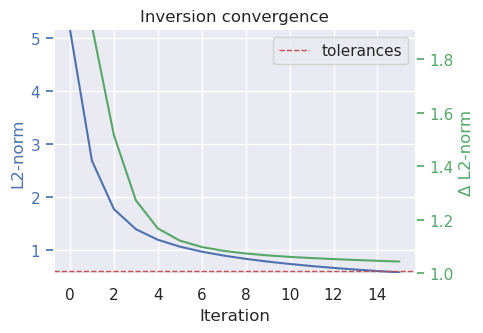

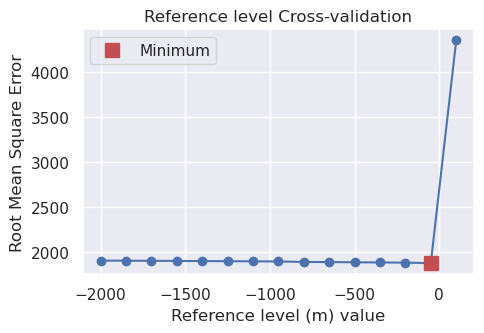

In [26]:
# run the cross validation for the zref
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    solver_damping=best_damping,
    constraints_df=constraint_points,
    zref_limits=(-2000, 100),
    density_contrast=best_density_contrast,
    n_trials=15,
    grid_search=True,
    starting_topography=starting_topography,
    regional_grav_kwargs=dict(
        method="constant",
        constraints_df=constraint_points,
    ),
    fname="tmp/bishop_model_zref_cv",
    # score_as_median=True,
    **kwargs,
)

In [27]:
# to re-load the study from the saved pickle file
with pathlib.Path("tmp/bishop_model_zref_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

In [28]:
best_zref = study.best_params.get("zref", None)
best_zref

-50.0

### with optimal parameters

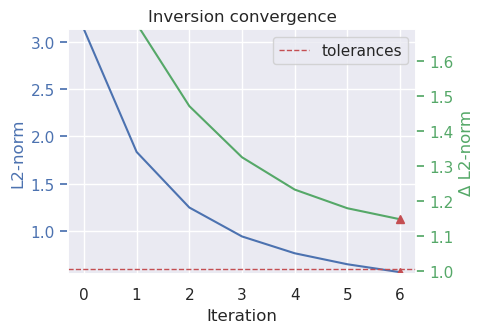

In [29]:
# run the inversion workflow, including a cross validation for the damping parameter
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    solver_damping=best_damping,
    zref=best_zref,
    density_contrast=best_density_contrast,
    fname="tmp/bishop_model",
    create_starting_prisms=True,
    starting_topography=starting_topography,
    calculate_regional_misfit=True,
    plot_dynamic_convergence=True,
    regional_grav_kwargs=regional_grav_kwargs,  # constraint point minimization
    **kwargs,
)

In [30]:
# to re-load the study from the saved pickle file
with pathlib.Path("tmp/bishop_model_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

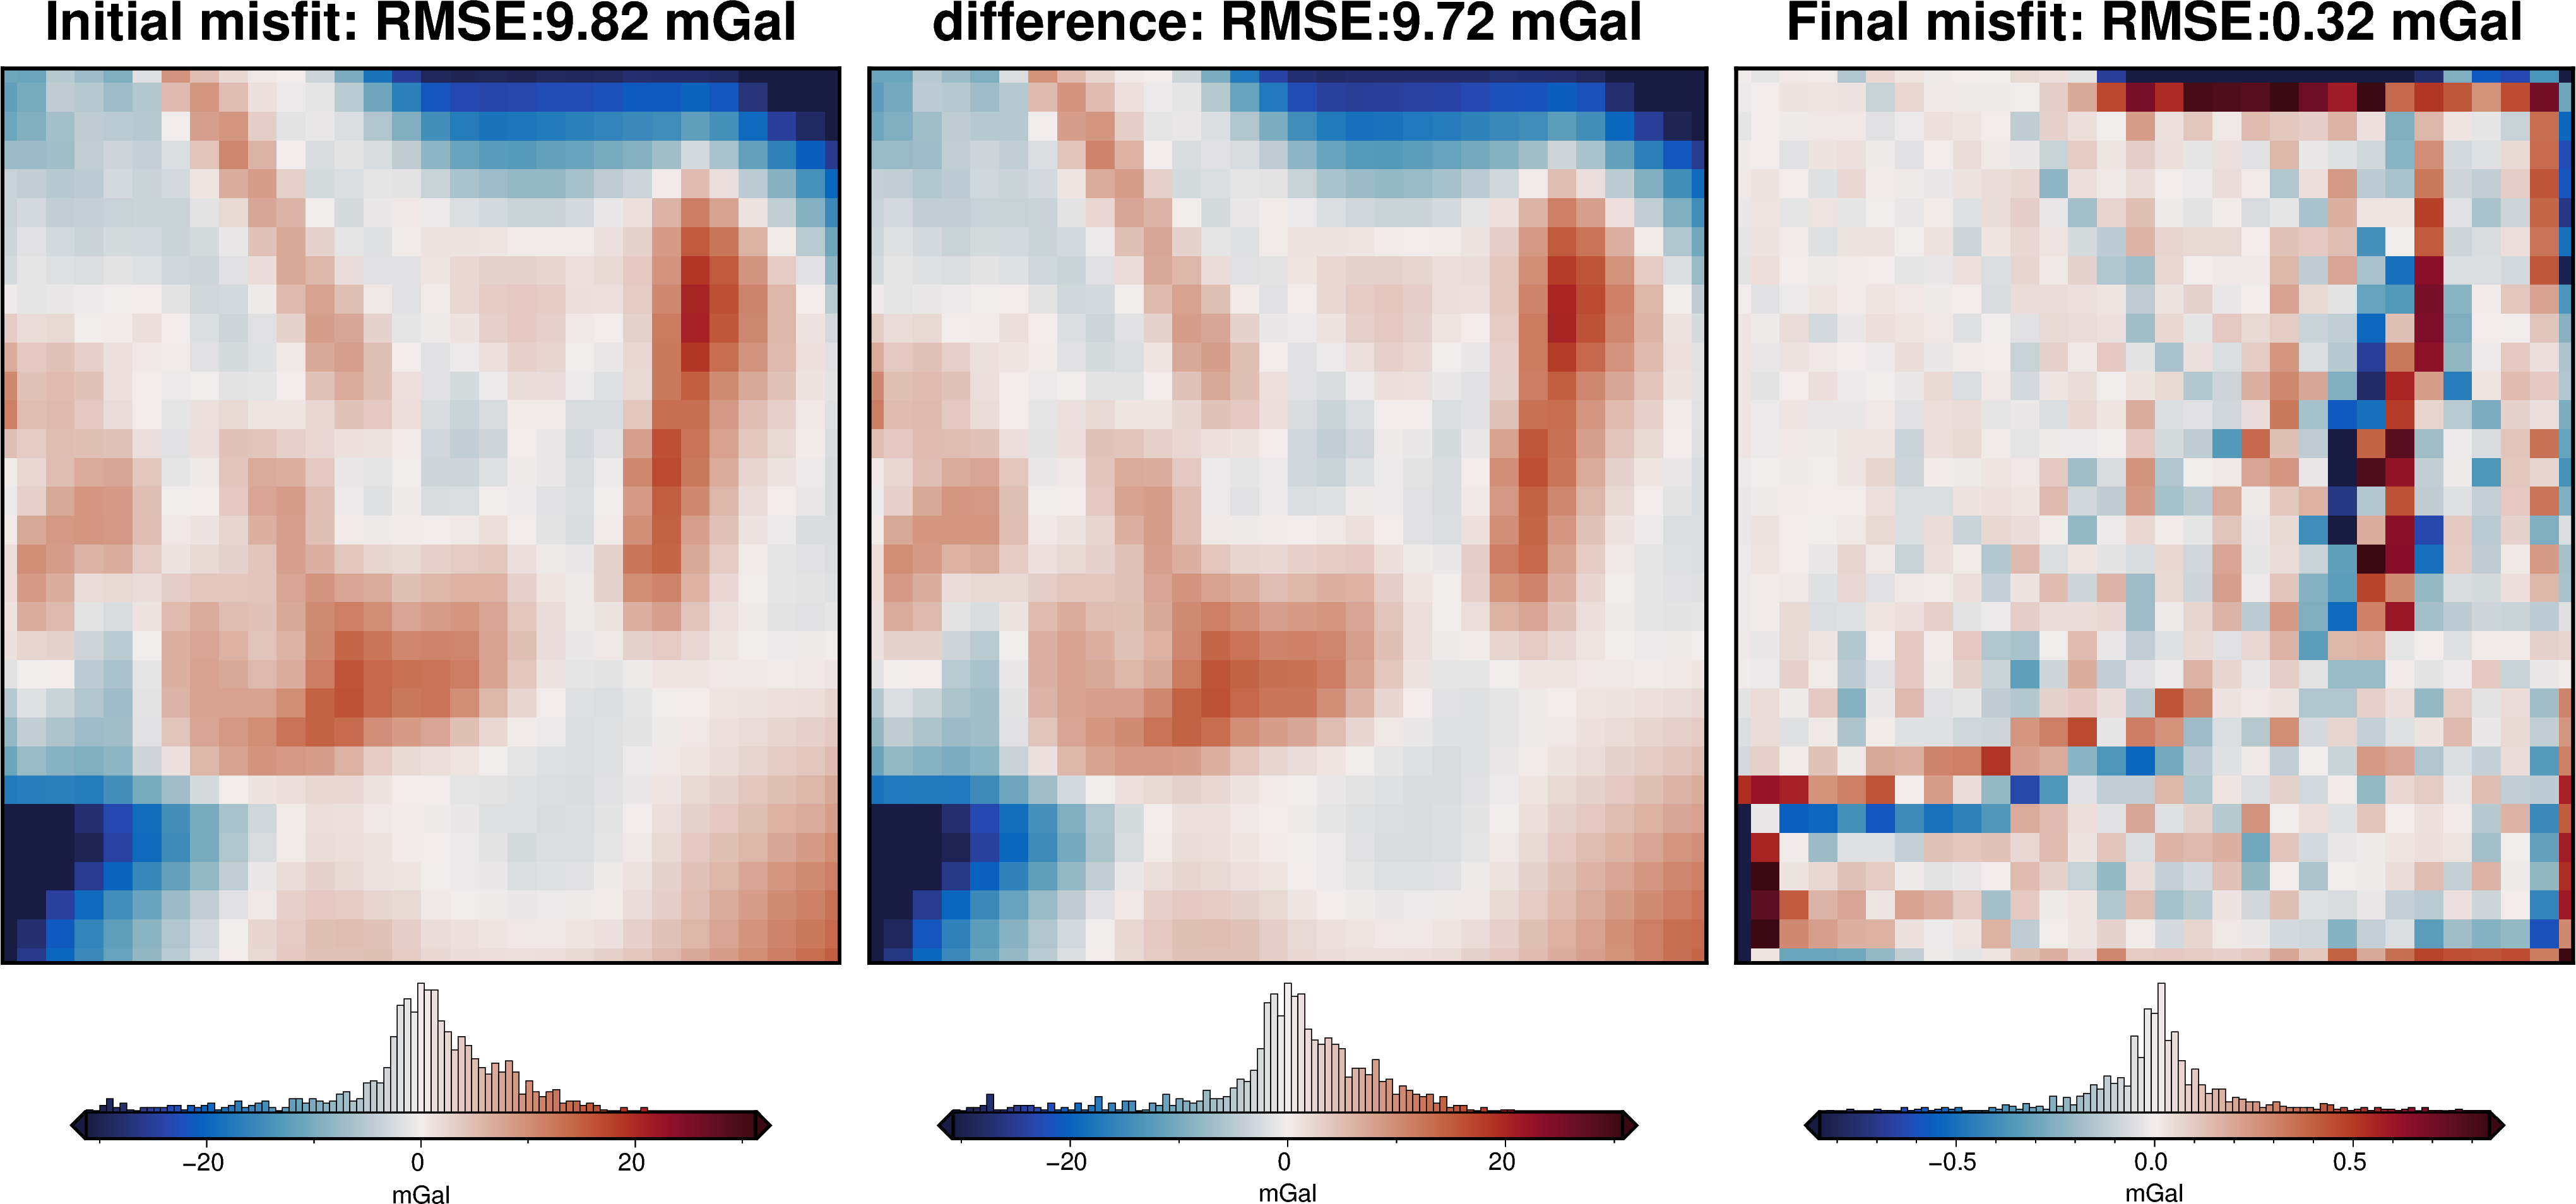

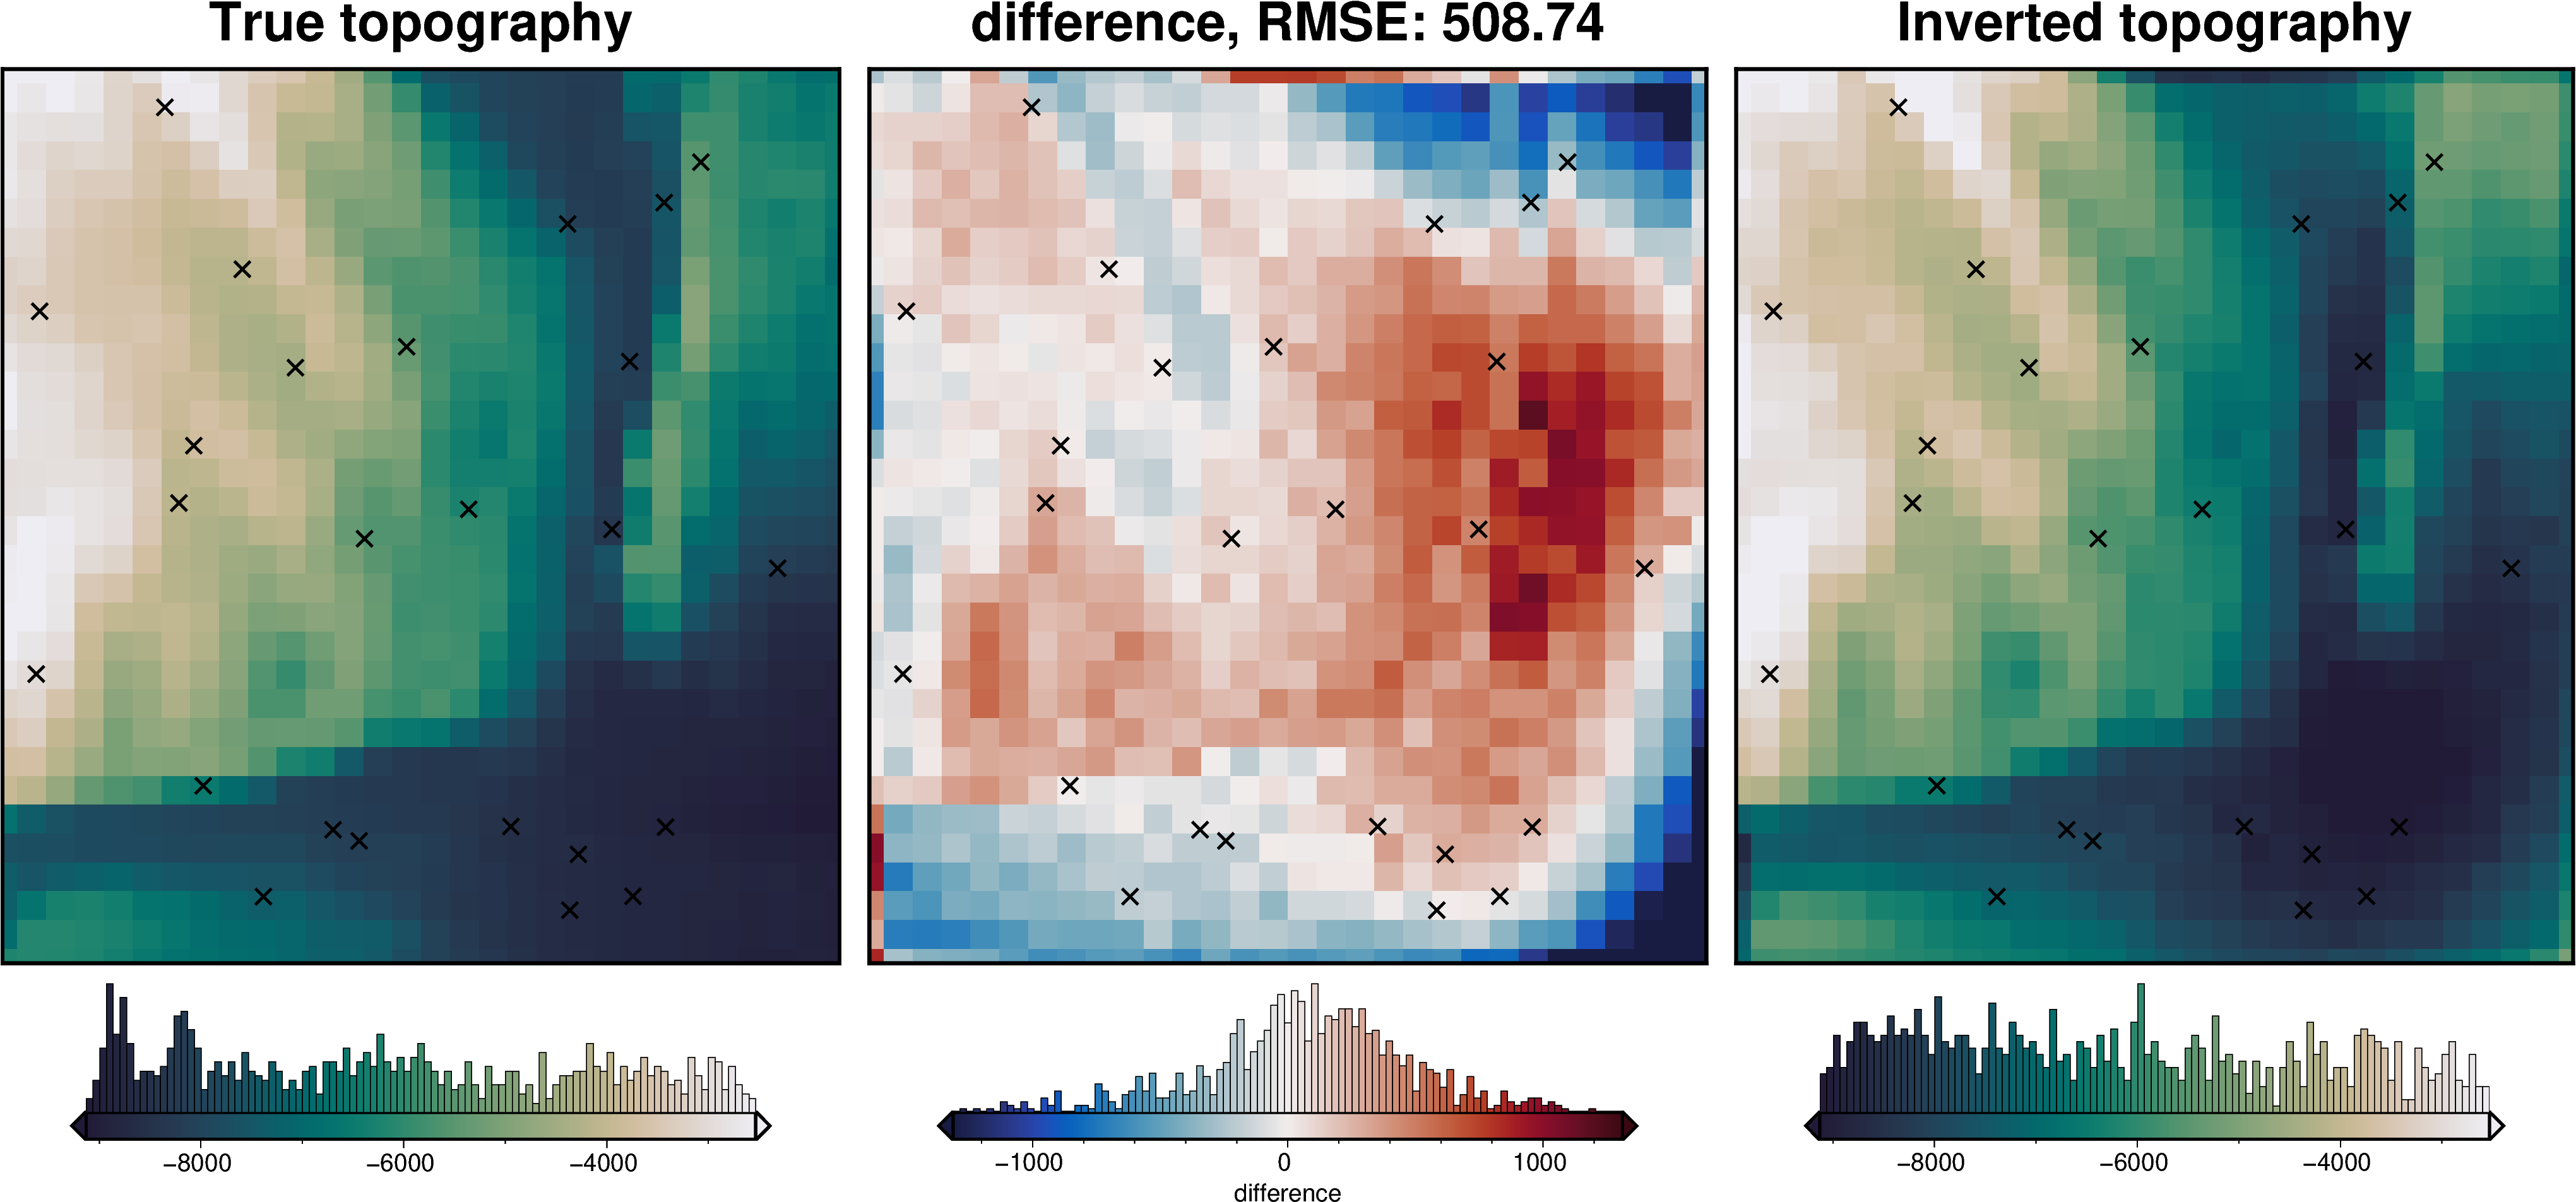

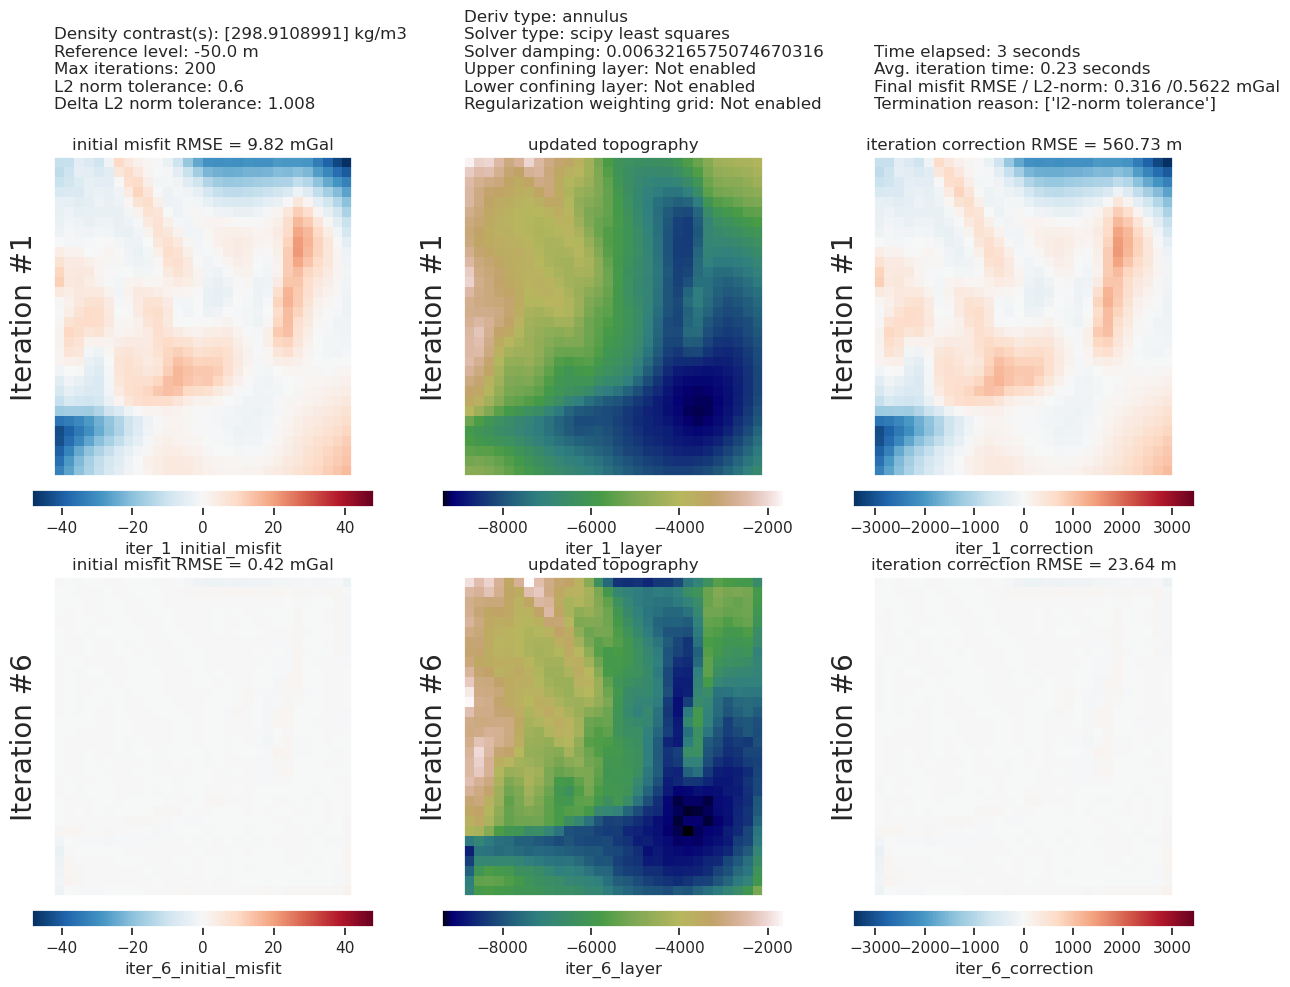

In [31]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    grid.basement_topo,
    final_topography,
    plot=True,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

In [32]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 228.89 m


## 2) K-Folds CV with constraint point minimization
This option is less efficient, but likely more accurate. 

Perform a cross validation for the optimal zref and density contrast values same as
function `optimize_inversion_zref_density_contrast`, but pass a dataframe of
constraint points which contains folds of testing and training data (generated with
`cross_validation.split_test_train`). For each set of zref/density values, perform
a regional separation and inversion for each of the K folds in the constraints
dataframe. After all K folds are inverted, the mean of the K folds scores will be
the score for that set of parameters. Repeat this for all parameters. Within each
fold, the training constraints are used for the regional separation and the testing
constraints are used for scoring. This is only useful if the regional separation
technique you supply via `regional_grav_kwargs` uses constraints points
for the estimations, such as constraint point minimization. If using 20 sets of
density and zref values, and use 5 folds, this will run 100 inversions. It is more
efficient, but less accurate, to simple use a different regional estimation
technique, which doesn't require constraint points, to find the optimal zref and
density values. Then use these again in another inversion with the desired regional
separation technique.

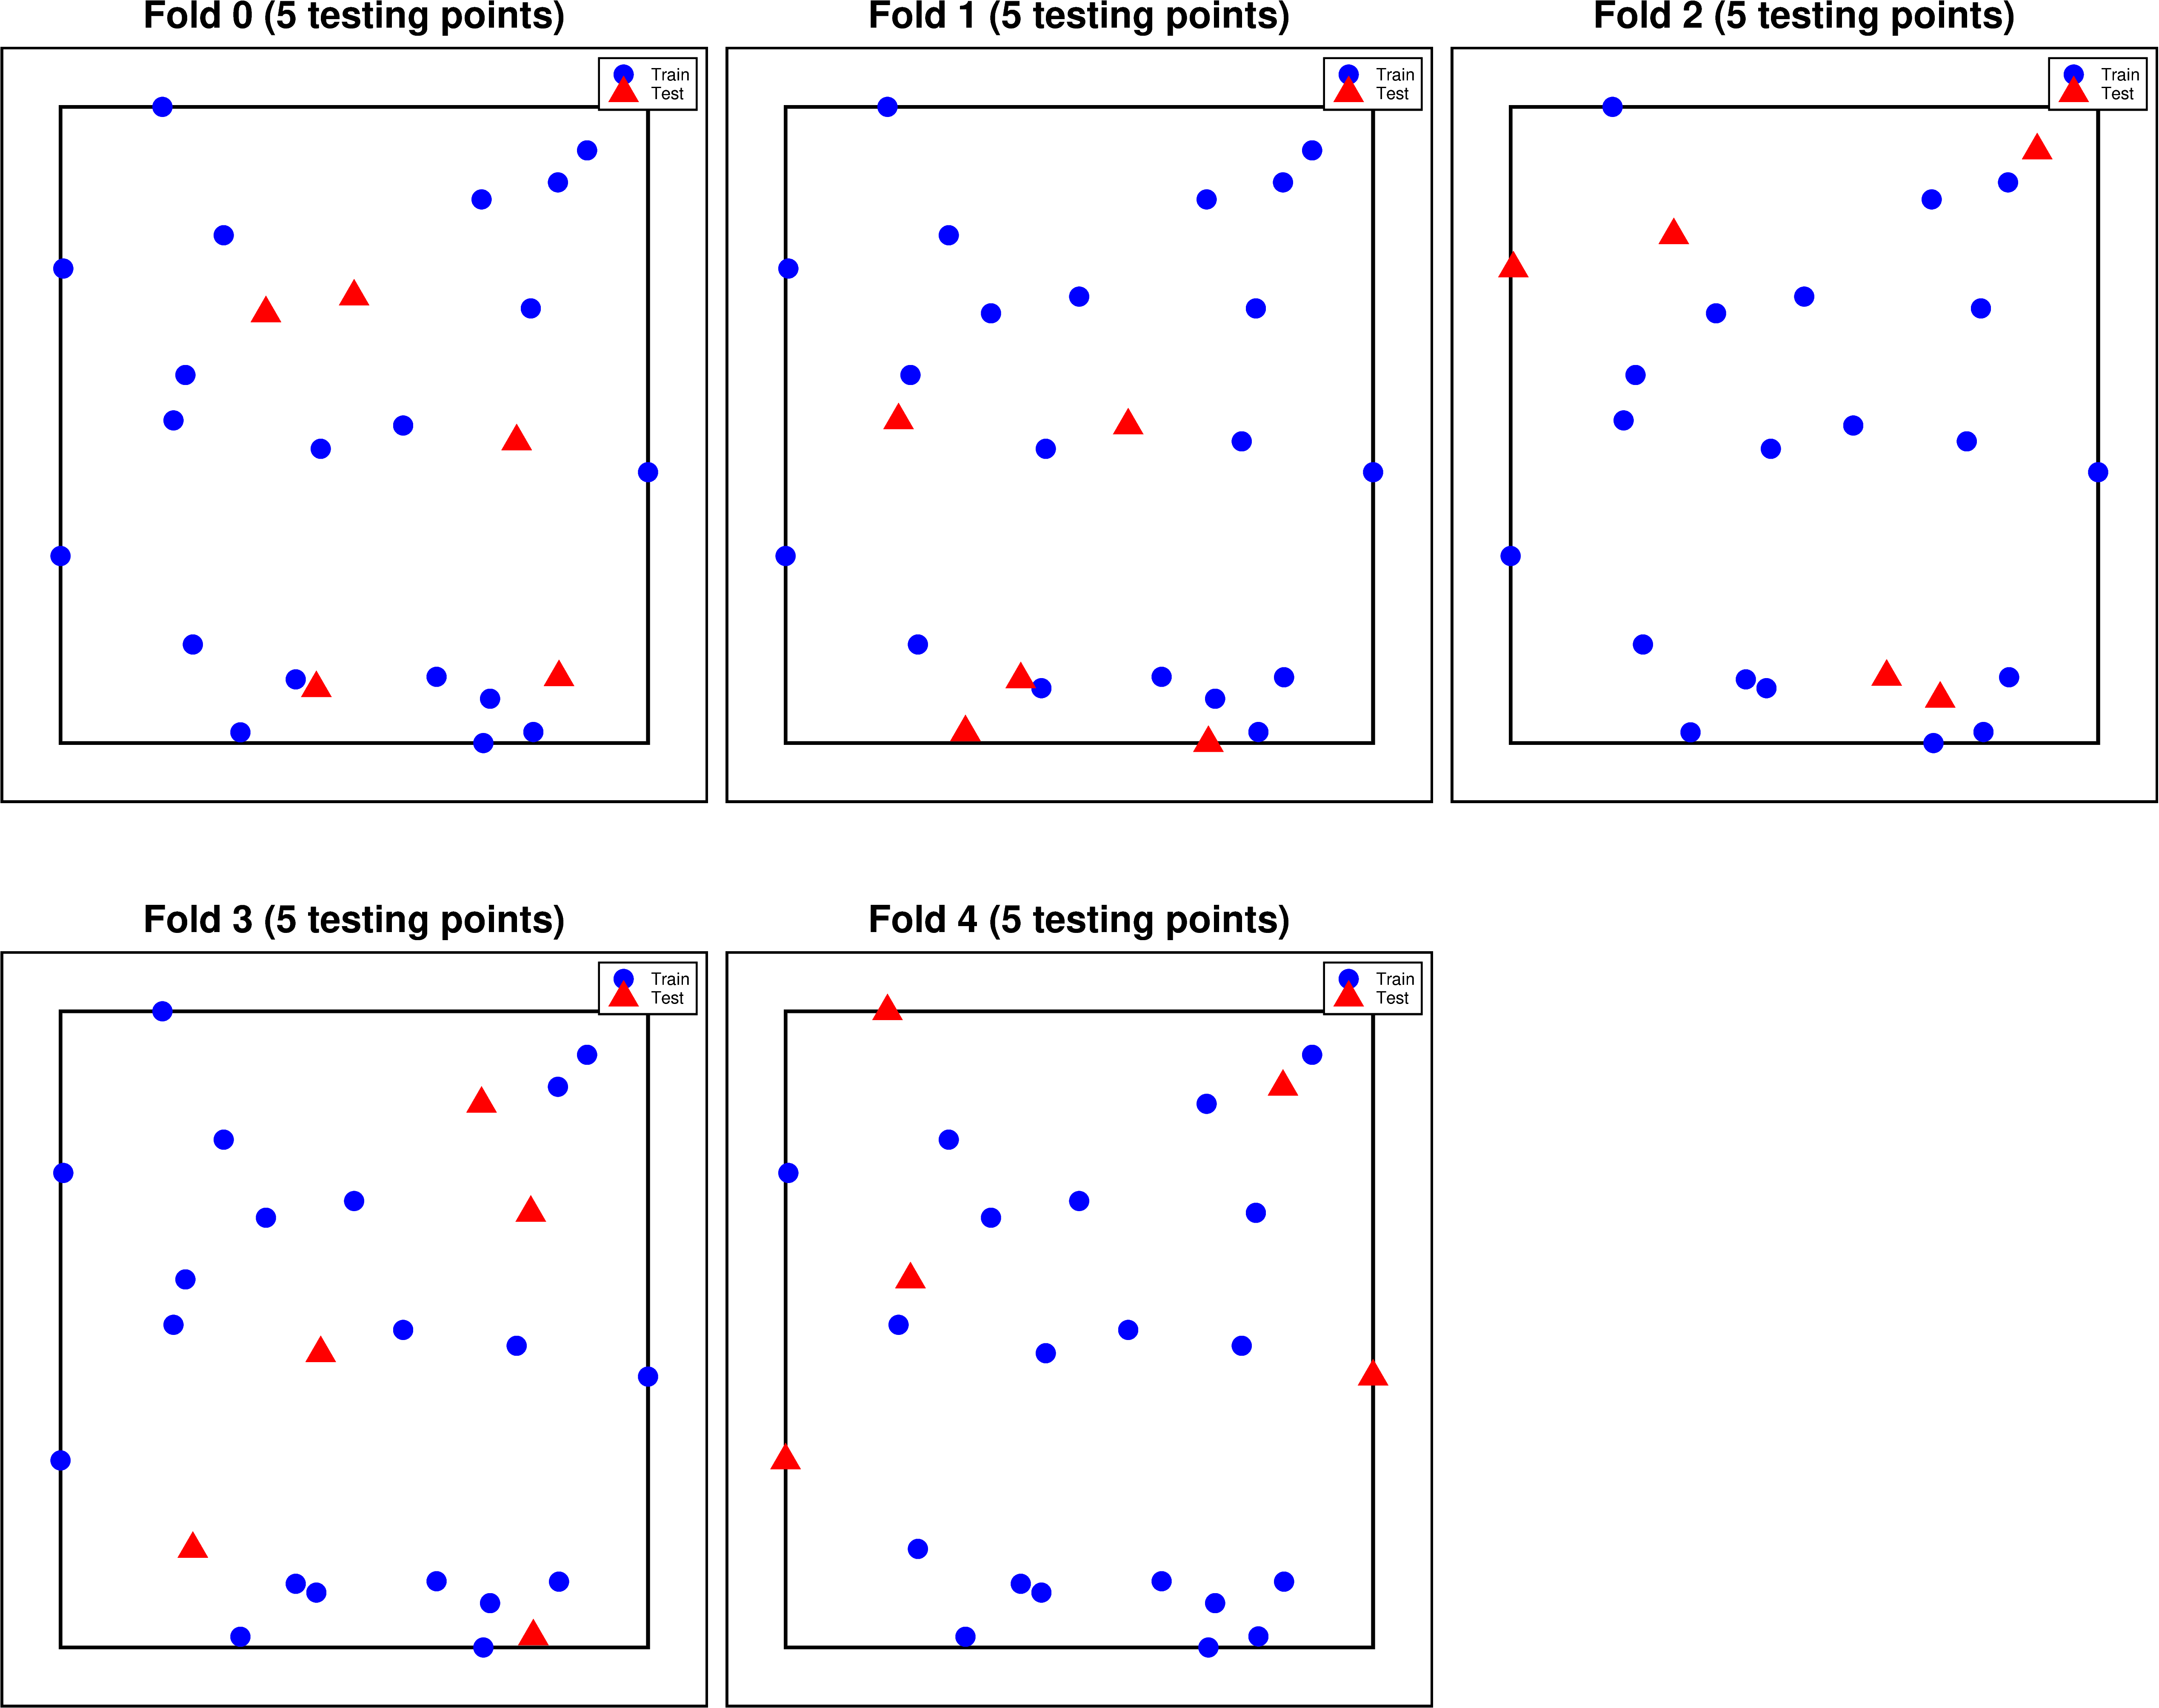

easting       northing  true_upward       upward      uncert  \
0  113184.345087  365343.996515 -3846.732115 -3837.059105   76.934642   
1  186953.886676  399664.300471 -5400.310608 -5414.578754  108.006212   
2  170445.269535  228349.599846 -8158.583697 -8054.084862  163.171674   
3  288879.139601  463648.278495 -5403.841585 -5392.504312  108.076832   
4  103113.619475  482677.019420 -3074.687380 -3107.627698   61.493748   

     weight  starting_topography  inverted_topography fold_0 fold_1 fold_2  \
0  0.000169         -3844.834279         -3922.237728  train  train  train   
1  0.000086         -5416.899582         -5599.641767   test  train  train   
2  0.000038         -8088.188987         -7987.907635   test  train  train   
3  0.000086         -5420.709113         -5126.496359  train  train   test   
4  0.000264         -3105.091615         -3106.367877  train  train  train   

  fold_3 fold_4  
0  train   test  
1  train  train  
2  train  train  
3  train  train  
4  train   test

In [45]:
# split into 5 folds
test_train_df = cross_validation.split_test_train(
    constraint_points,
    method="KFold",
    n_splits=5,
    plot=True,
)
test_train_df.head()

### Density CV

INFO:invert4geom:Constraints split into 5 folds


  0%|          | 0/8 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'density_contrast': 281.3849798522567}
INFO:invert4geom:	scores: [430.4554529827352]


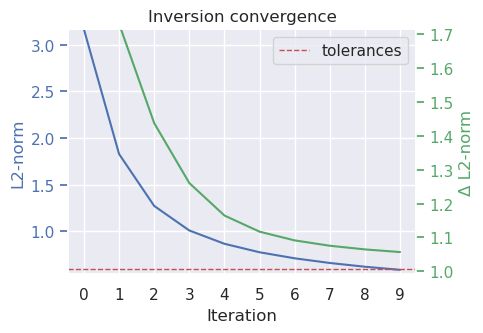

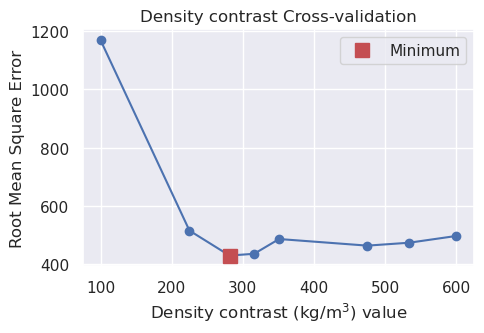

In [46]:
# run a 5-fold cross validation for 8 parameter sets of density
# this performs 40 regional separations and 40 inversions
study, inversion_results = optimization.optimize_inversion_zref_density_contrast_kfolds(
    constraints_df=constraint_points,
    grav_df=grav_df,
    solver_damping=best_damping,
    density_contrast_limits=(100, 600),
    zref=constraint_points.upward.mean(),
    n_trials=8,
    starting_topography=starting_topography,
    split_kwargs=dict(
        n_splits=5,
        method="KFold",
    ),
    regional_grav_kwargs=regional_grav_kwargs,  # constraint point minimization
    # grid_search=True,
    fname="tmp/bishop_model_density_cv_with_cpm_kfolds",
    # score_as_median=True,
    fold_progressbar=True,
    **kwargs,
)

In [47]:
# to re-load the study from the saved pickle file
with pathlib.Path("tmp/bishop_model_density_cv_with_cpm_kfolds_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("tmp/bishop_model_density_cv_with_cpm_kfolds_results.pickle").open(
    "rb"
) as f:
    inversion_results = pickle.load(f)

In [48]:
best_density_contrast = study.best_params.get("density_contrast")
best_density_contrast

281.3849798522567

### Zref CV

INFO:invert4geom:Constraints split into 5 folds


  0%|          | 0/8 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

Regional Estimation CV folds:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'zref': -8603.925969328728}
INFO:invert4geom:	scores: [425.40304108855196]


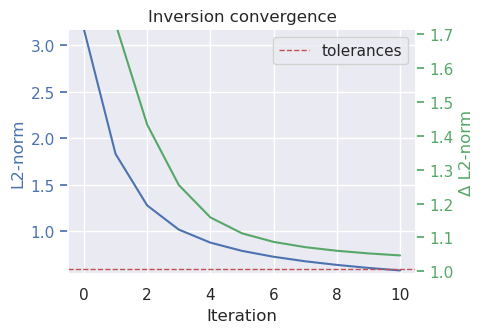

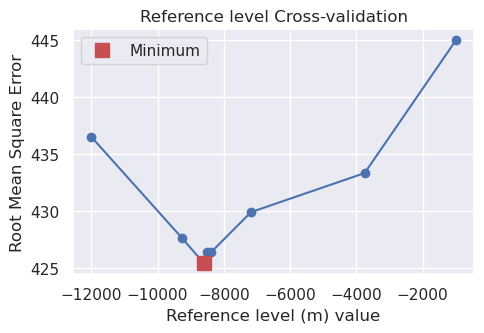

In [50]:
# run a 5-fold cross validation for 8 parameter sets of zref
# this performs 40 regional separations and 40 inversions
study, inversion_results = optimization.optimize_inversion_zref_density_contrast_kfolds(
    constraints_df=constraint_points,
    grav_df=grav_df,
    solver_damping=best_damping,
    density_contrast=best_density_contrast,
    zref_limits=(-12e3, -1e3),
    n_trials=8,
    starting_topography=starting_topography,
    split_kwargs=dict(
        n_splits=5,
        method="KFold",
    ),
    regional_grav_kwargs=regional_grav_kwargs,  # constraint point minimization
    # grid_search=True,
    fname="tmp/bishop_model_zref_cv_with_cpm_kfolds",
    # score_as_median=True,
    fold_progressbar=True,
    **kwargs,
)

In [51]:
# to re-load the study from the saved pickle file
with pathlib.Path("tmp/bishop_model_zref_cv_with_cpm_kfolds_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("tmp/bishop_model_zref_cv_with_cpm_kfolds_results.pickle").open(
    "rb"
) as f:
    inversion_results = pickle.load(f)

In [52]:
best_zref = study.best_params.get("zref")
best_zref

-8603.925969328728

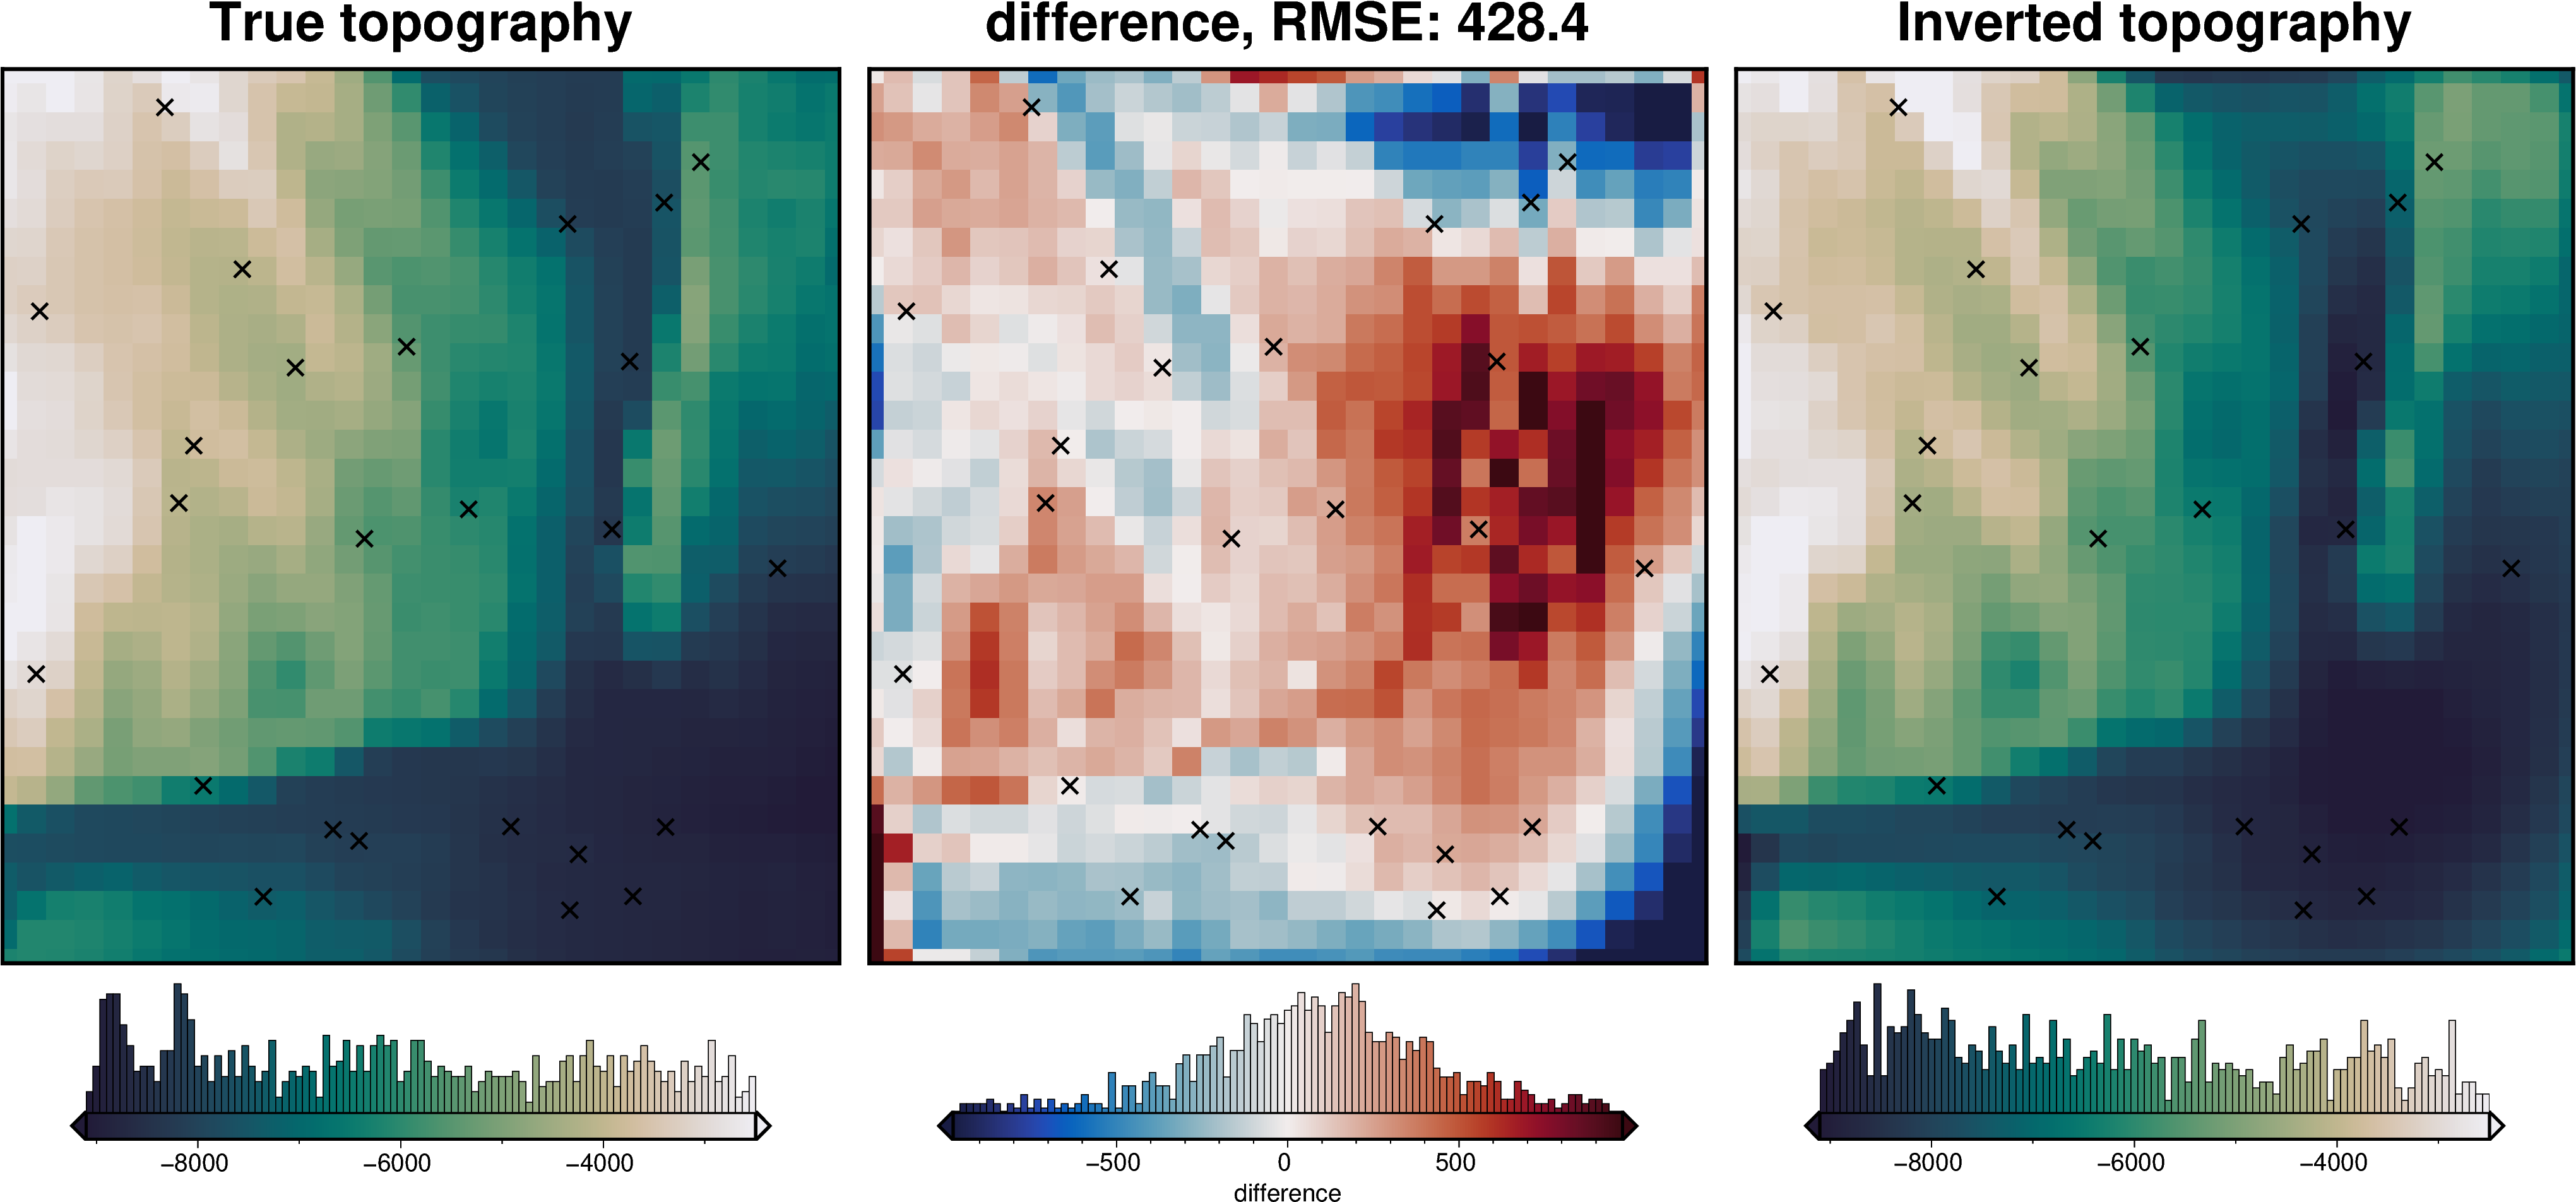

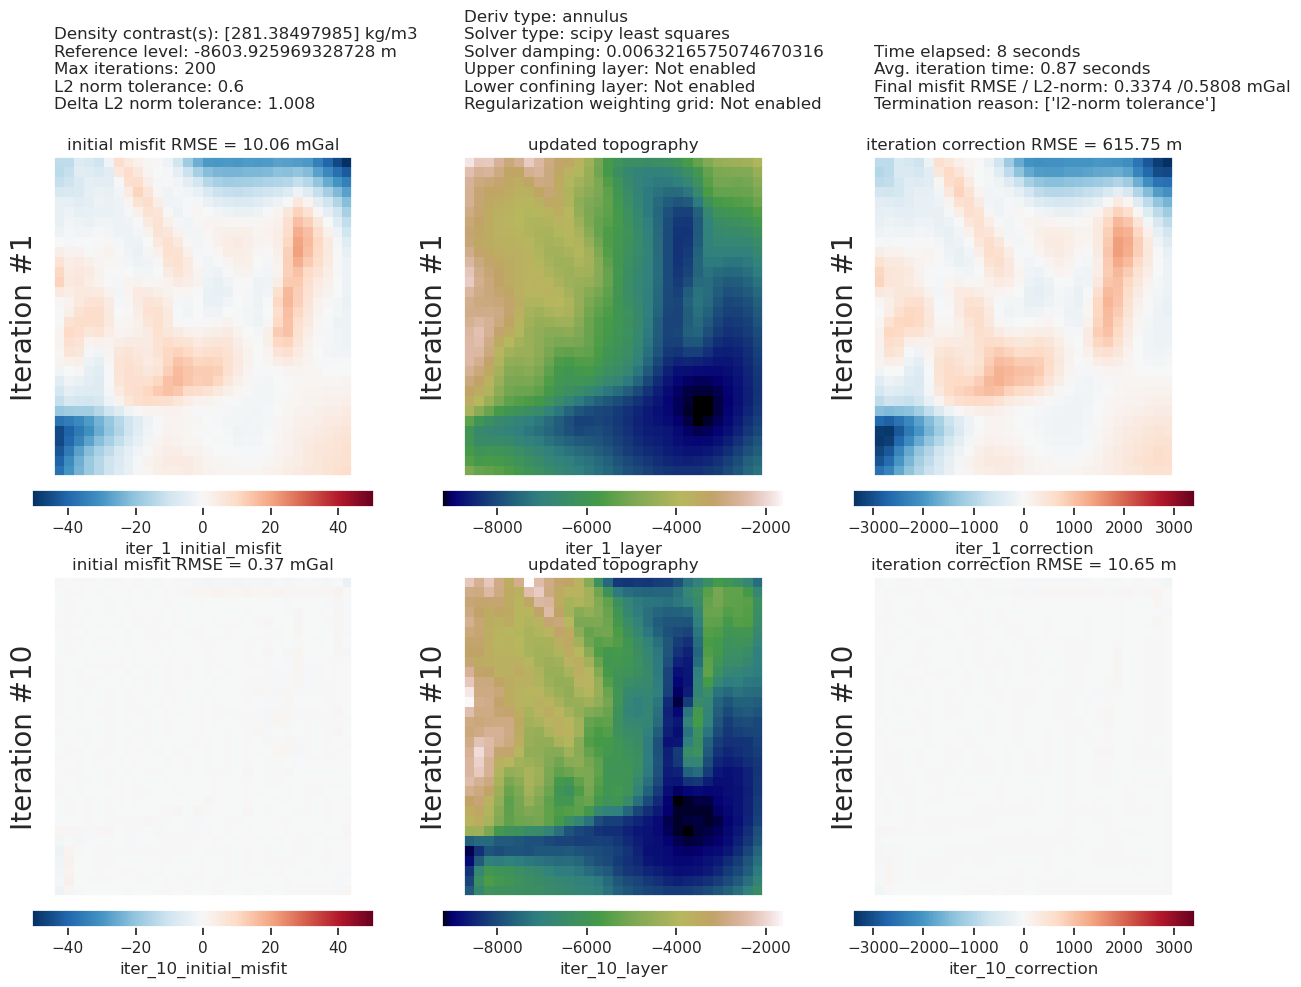

In [53]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=False,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    grid.basement_topo,
    final_topography,
    plot=True,
    region=inversion_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

In [54]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 227.68 m


# Uncertainty analysis


## Absolute value of inversion error

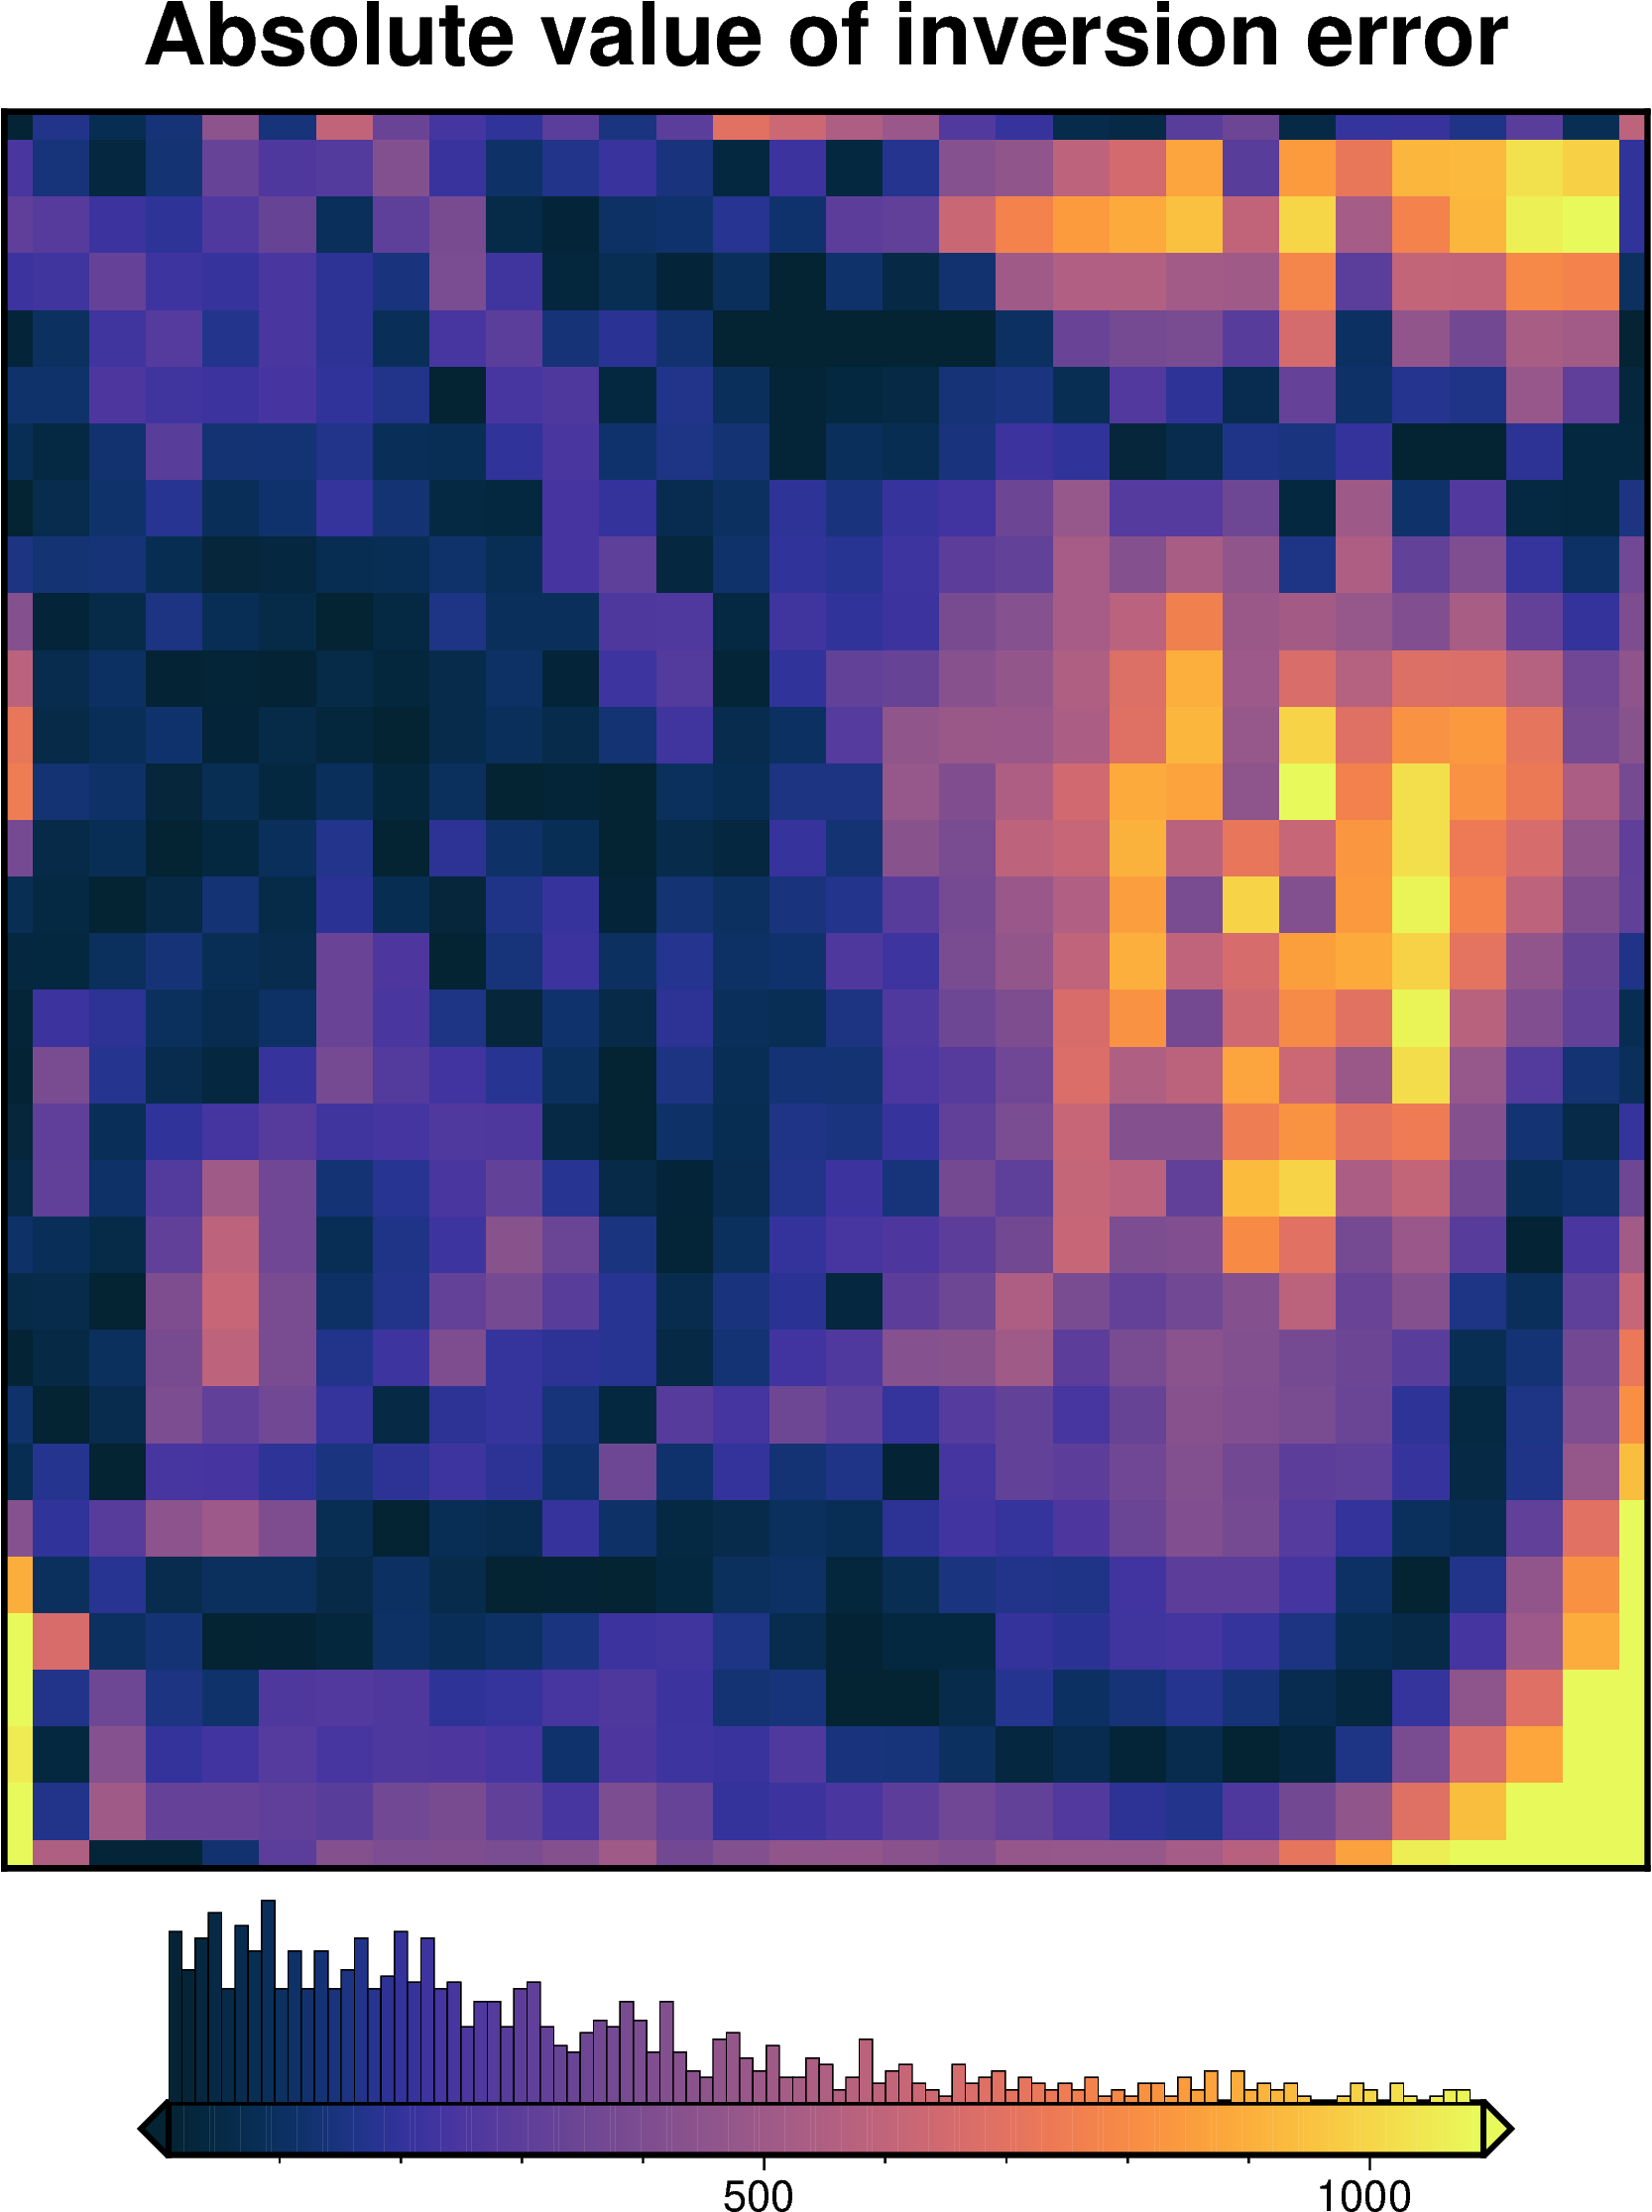

In [55]:
inversion_error = np.abs(grid.basement_topo - final_topography)
fig = maps.plot_grd(
    inversion_error.sel(
        {
            "easting": slice(*inversion_region[:2]),
            "northing": slice(*inversion_region[2:]),
        }
    ),
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
)
fig.show()

## Starting topography uncertainty

Here we will estimate an uncertainty distribution for the spline damping value used in creating the starting topography.We then re-create the starting topography a number of times, each using a randomly sampled value for the the damping parameter from within it's uncertainty range. The cell-wise standard deviation of this ensemble will give us an idea of the uncertainty of the starting topography generation. Each repetition of the ensemble will also randomly sample the constraint depths from within their uncertainties.

In [56]:
# get best damping value used when creating grid
best_spline_damping = starting_topography.attrs["damping"]
best_spline_damping

np.float64(1.2898902612533134e-18)

INFO:invert4geom:Sampled 'dampings' parameter values; mean: 1.1746424463353485e-15, min: 4.2437257370475905e-23, max: 3.920651307767354e-14


starting topography ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

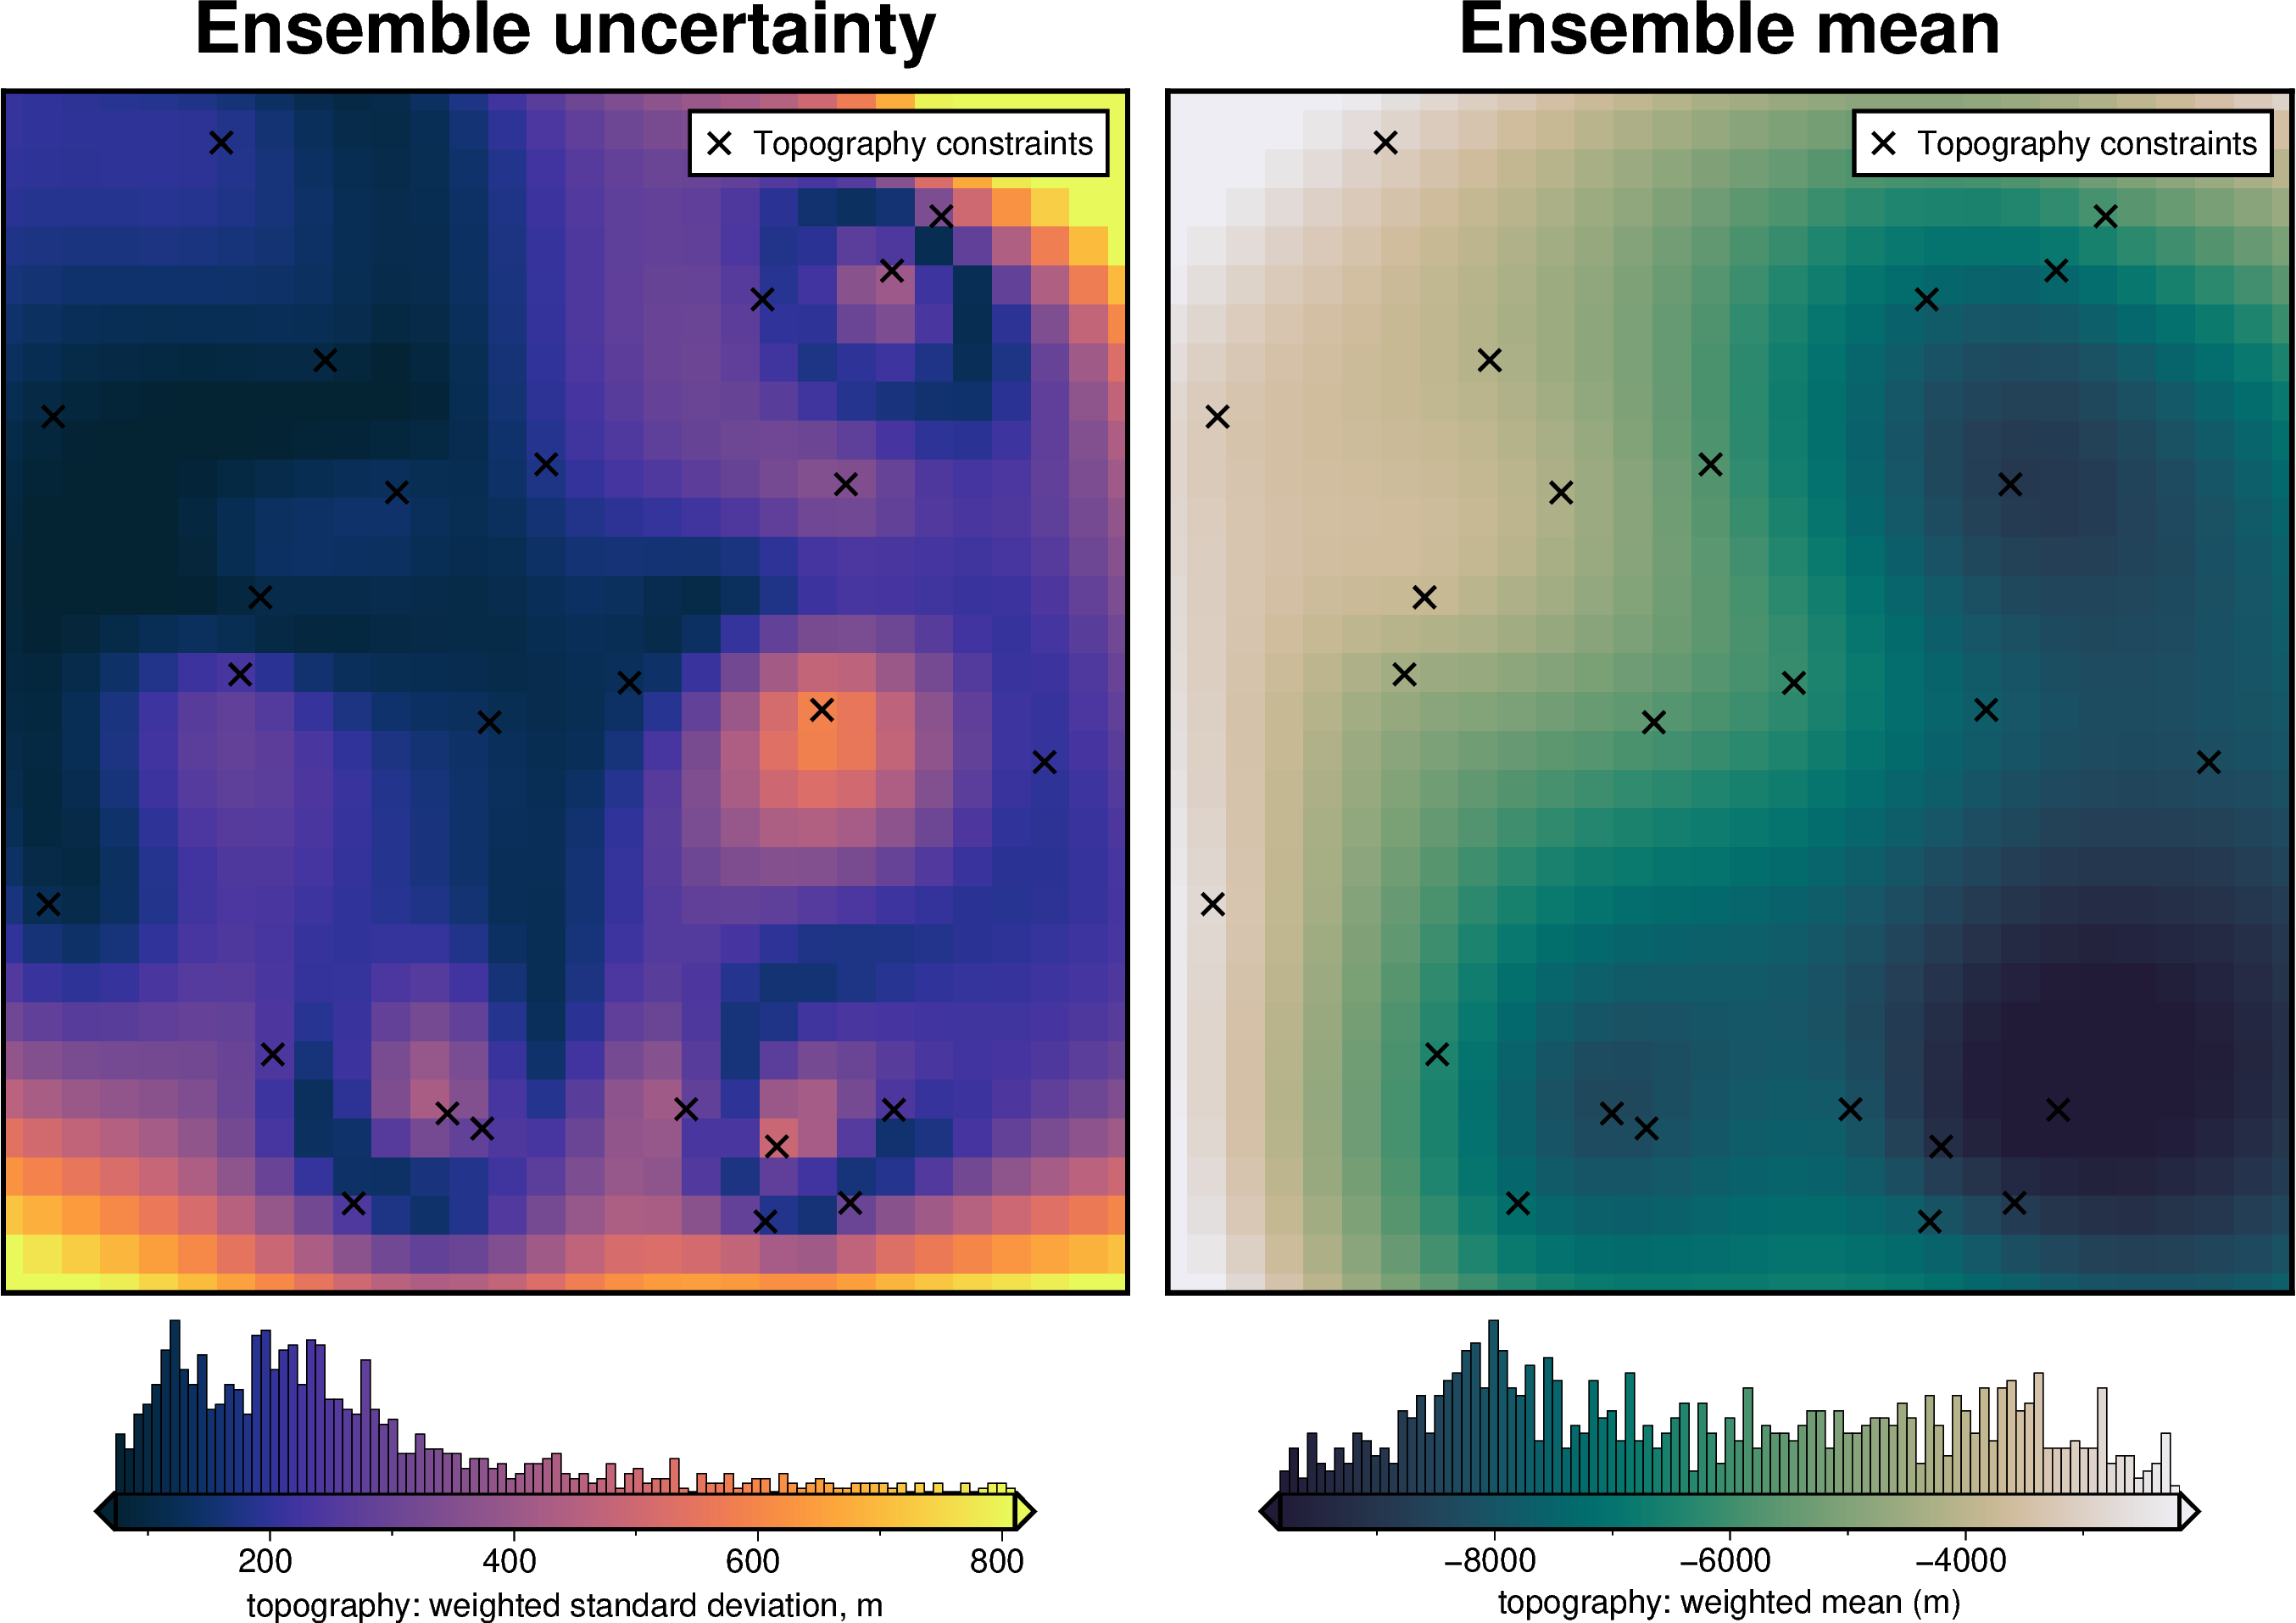

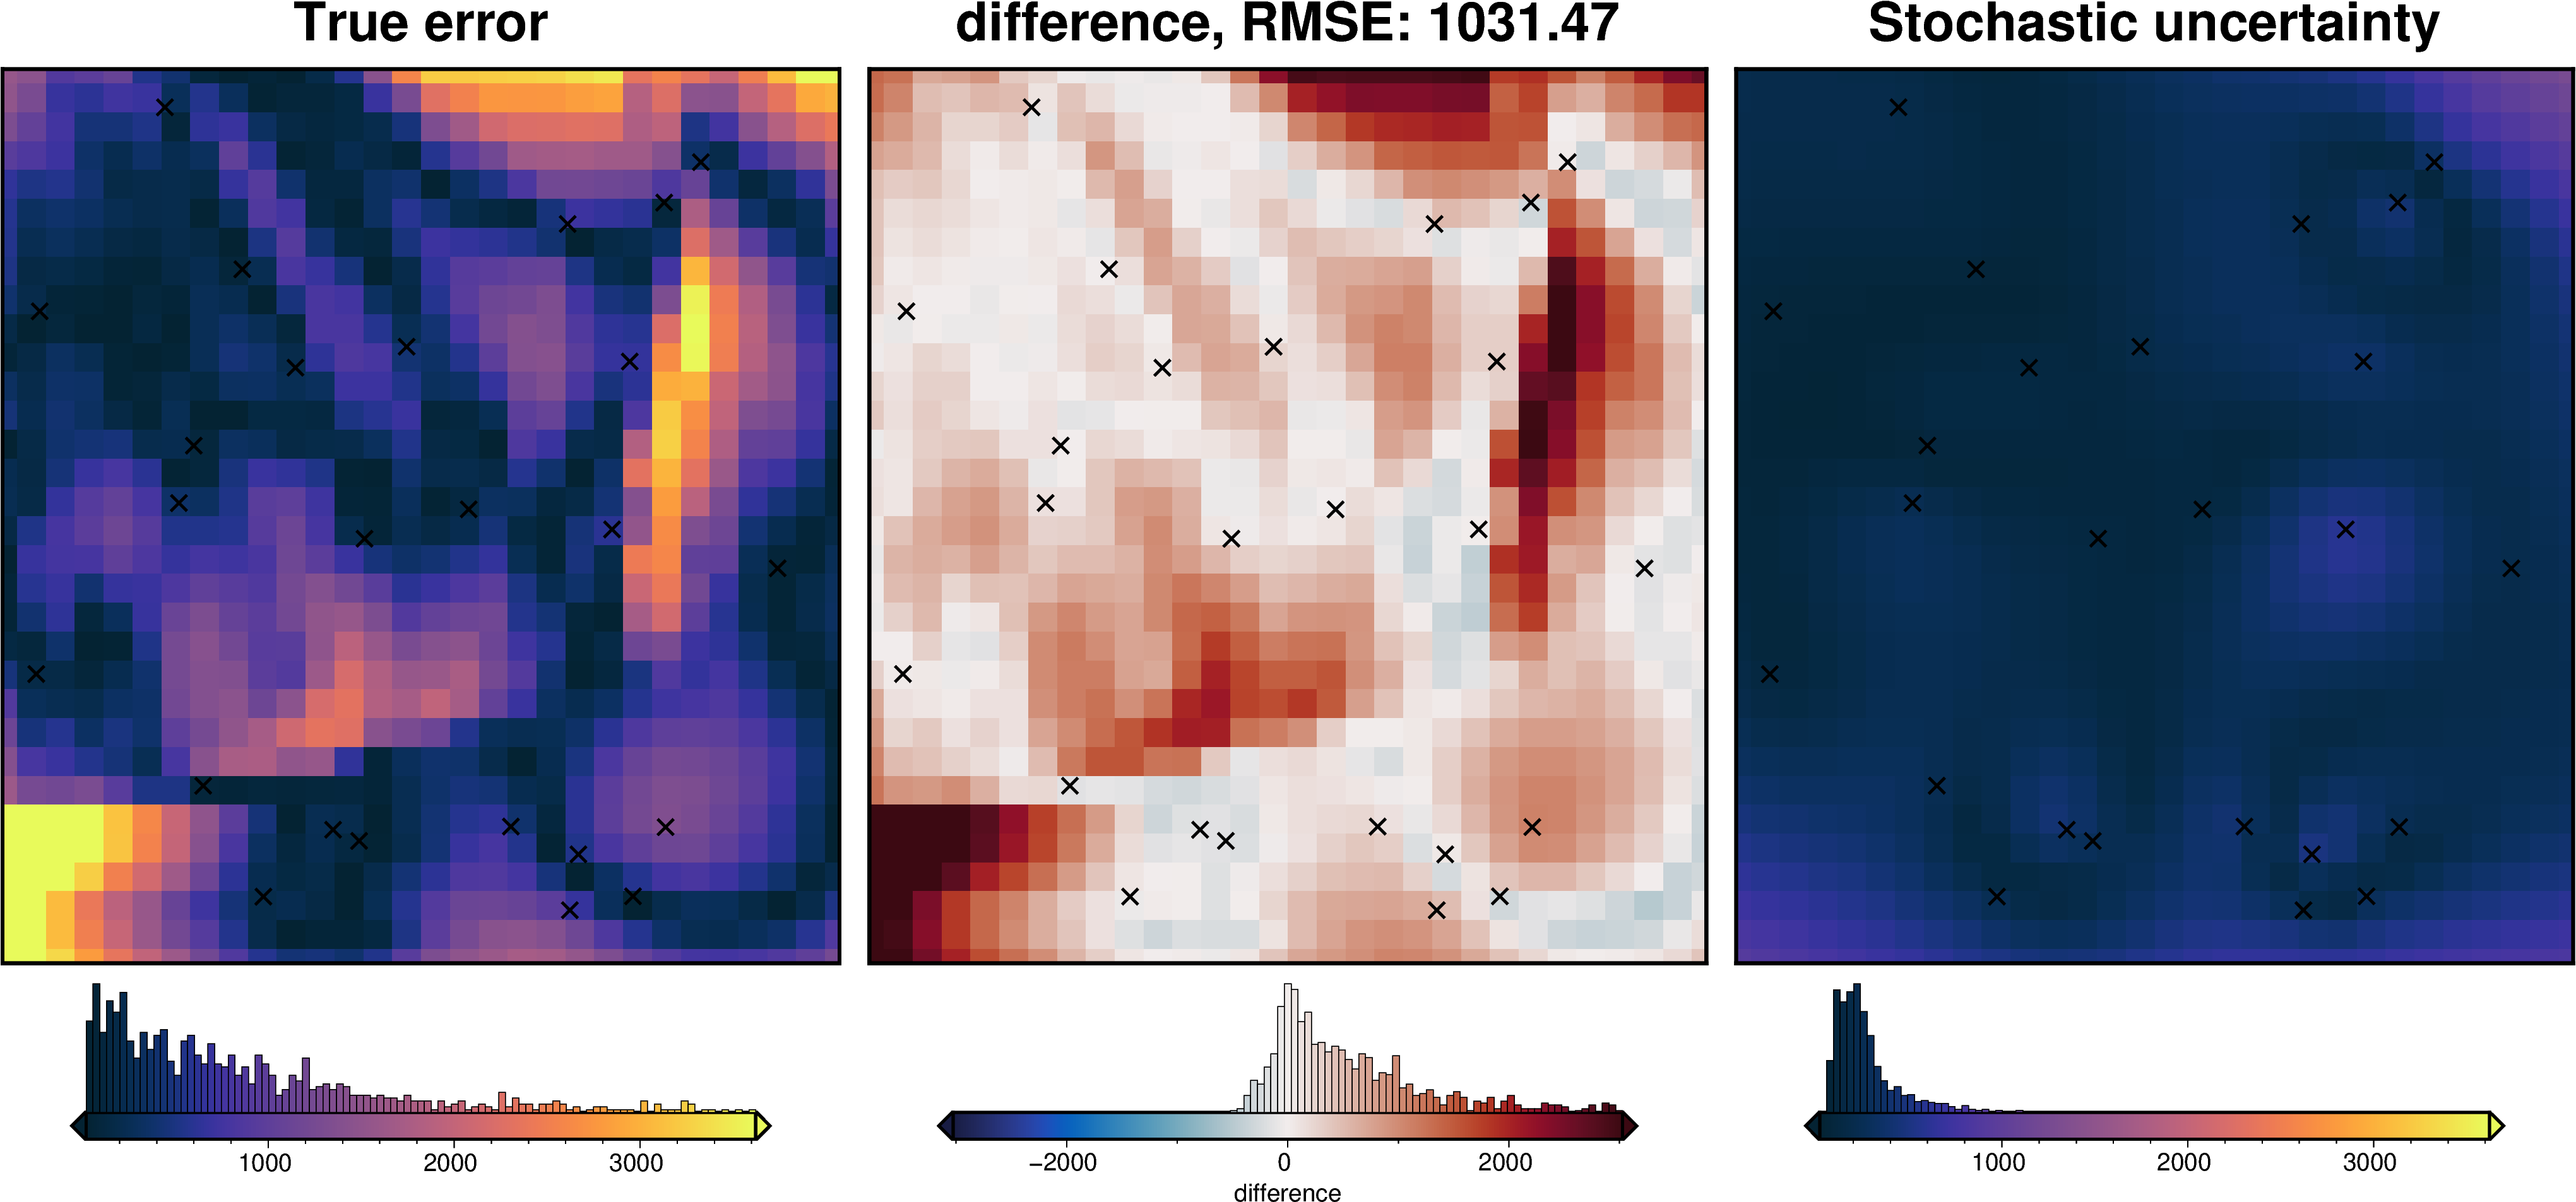

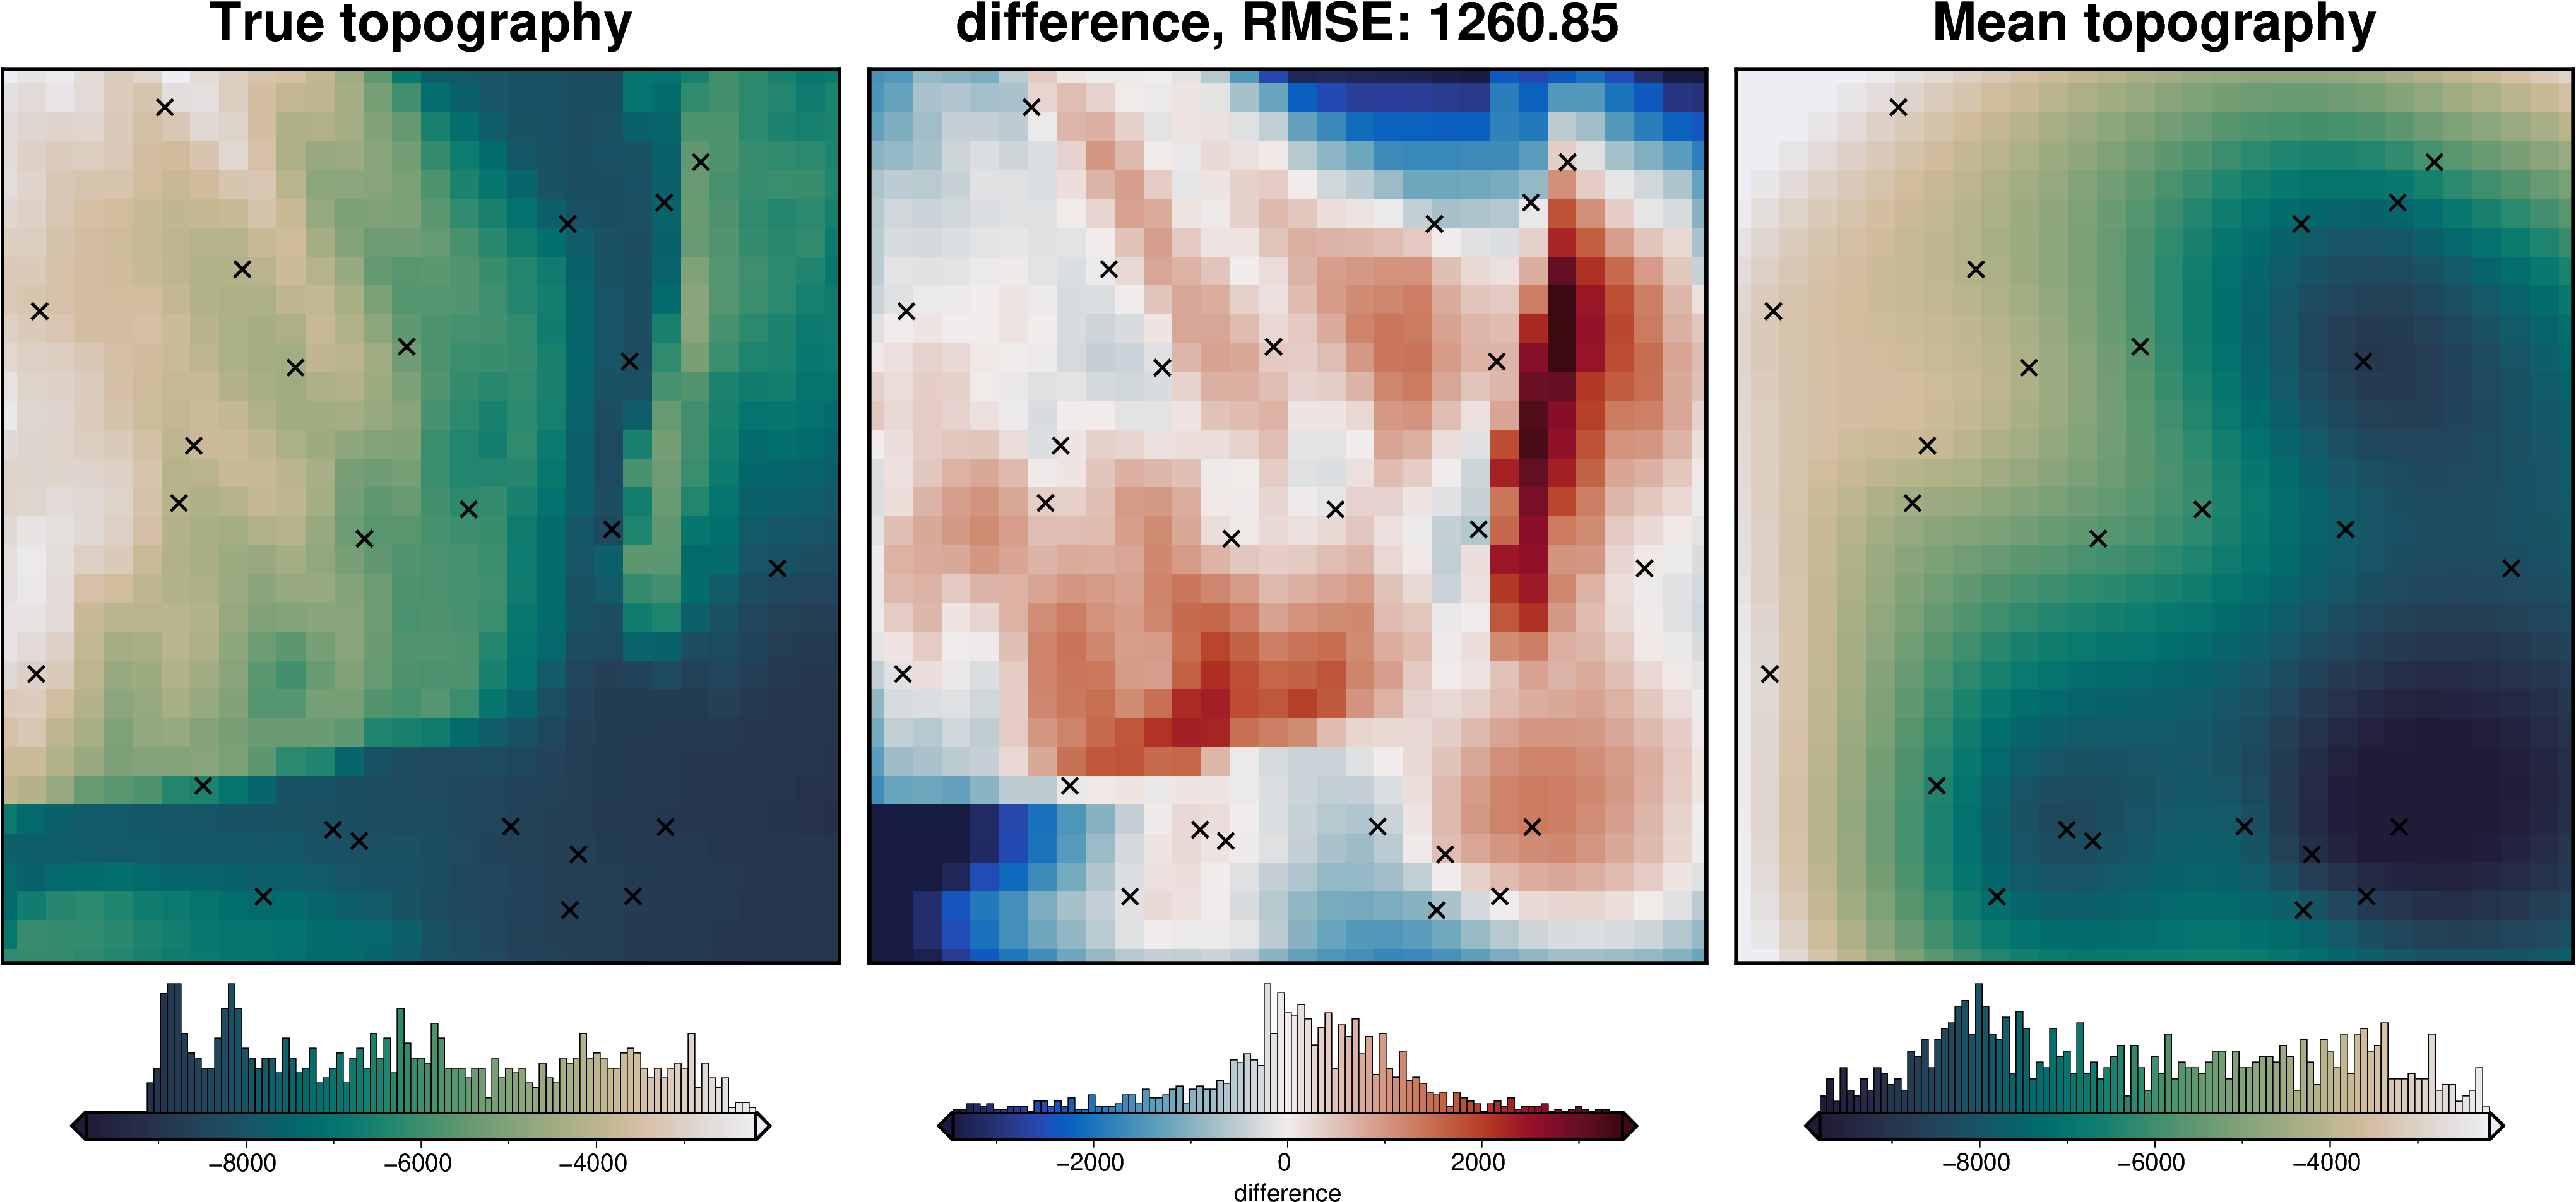

In [57]:
starting_topography_parameter_dict = {
    "dampings": {
        "distribution": "normal",
        "loc": np.log10(best_spline_damping),  # mean; base 10 exponent
        "scale": 2,  # standard deviation of exponent
        "log": True,
    },
}
starting_topo_stats = uncertainty.starting_topography_uncertainty(
    runs=40,
    sample_constraints=True,
    parameter_dict=starting_topography_parameter_dict,
    method="splines",
    dampings=best_spline_damping,
    region=inversion_region,
    spacing=topo_spacing,
    constraints_df=constraint_points,
    weights=constraint_points.weight,
    plot_region=inversion_region,
    true_topography=grid.basement_topo,
)

## Regional field estimation uncertainty

We will do the same thing for the regional estimation procedure. First we will re-separate the regional to see what equivalent source gridding parameter values were determined optimal. We then estimate an uncertainty distribution for these parameter values, and create an ensemble of regional models which each randomly sample both the parameter values and the gravity data. 

In [59]:
# use the constraints to find the best regional field
_ = regional.regional_separation(grav_df=grav_df, **regional_grav_kwargs)

# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get("cv_kwargs").get("fname")}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]
eq_damping

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 18
INFO:invert4geom:	parameter: {'damping': 8.385782616276809e-10}
INFO:invert4geom:	scores: [0.9757991304948286]


8.385782616276809e-10

In [60]:
# if depth="default" in EquivalentSources, it will use 4.5 times the mean distances
# between nearest points as the depth
# calculate that mean distance below.
mean_constraint_distance = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing), k_nearest=1
    )
)
mean_constraint_distance

np.float64(35180.43443313728)

INFO:invert4geom:Sampled 'depth' parameter values; mean: 158311.95494911773, min: 72559.64601834564, max: 244064.26387988986
INFO:invert4geom:Sampled 'damping' parameter values; mean: 7.93259128139353e-09, min: 4.8099534398356496e-12, max: 1.4619964822331697e-07


starting regional ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

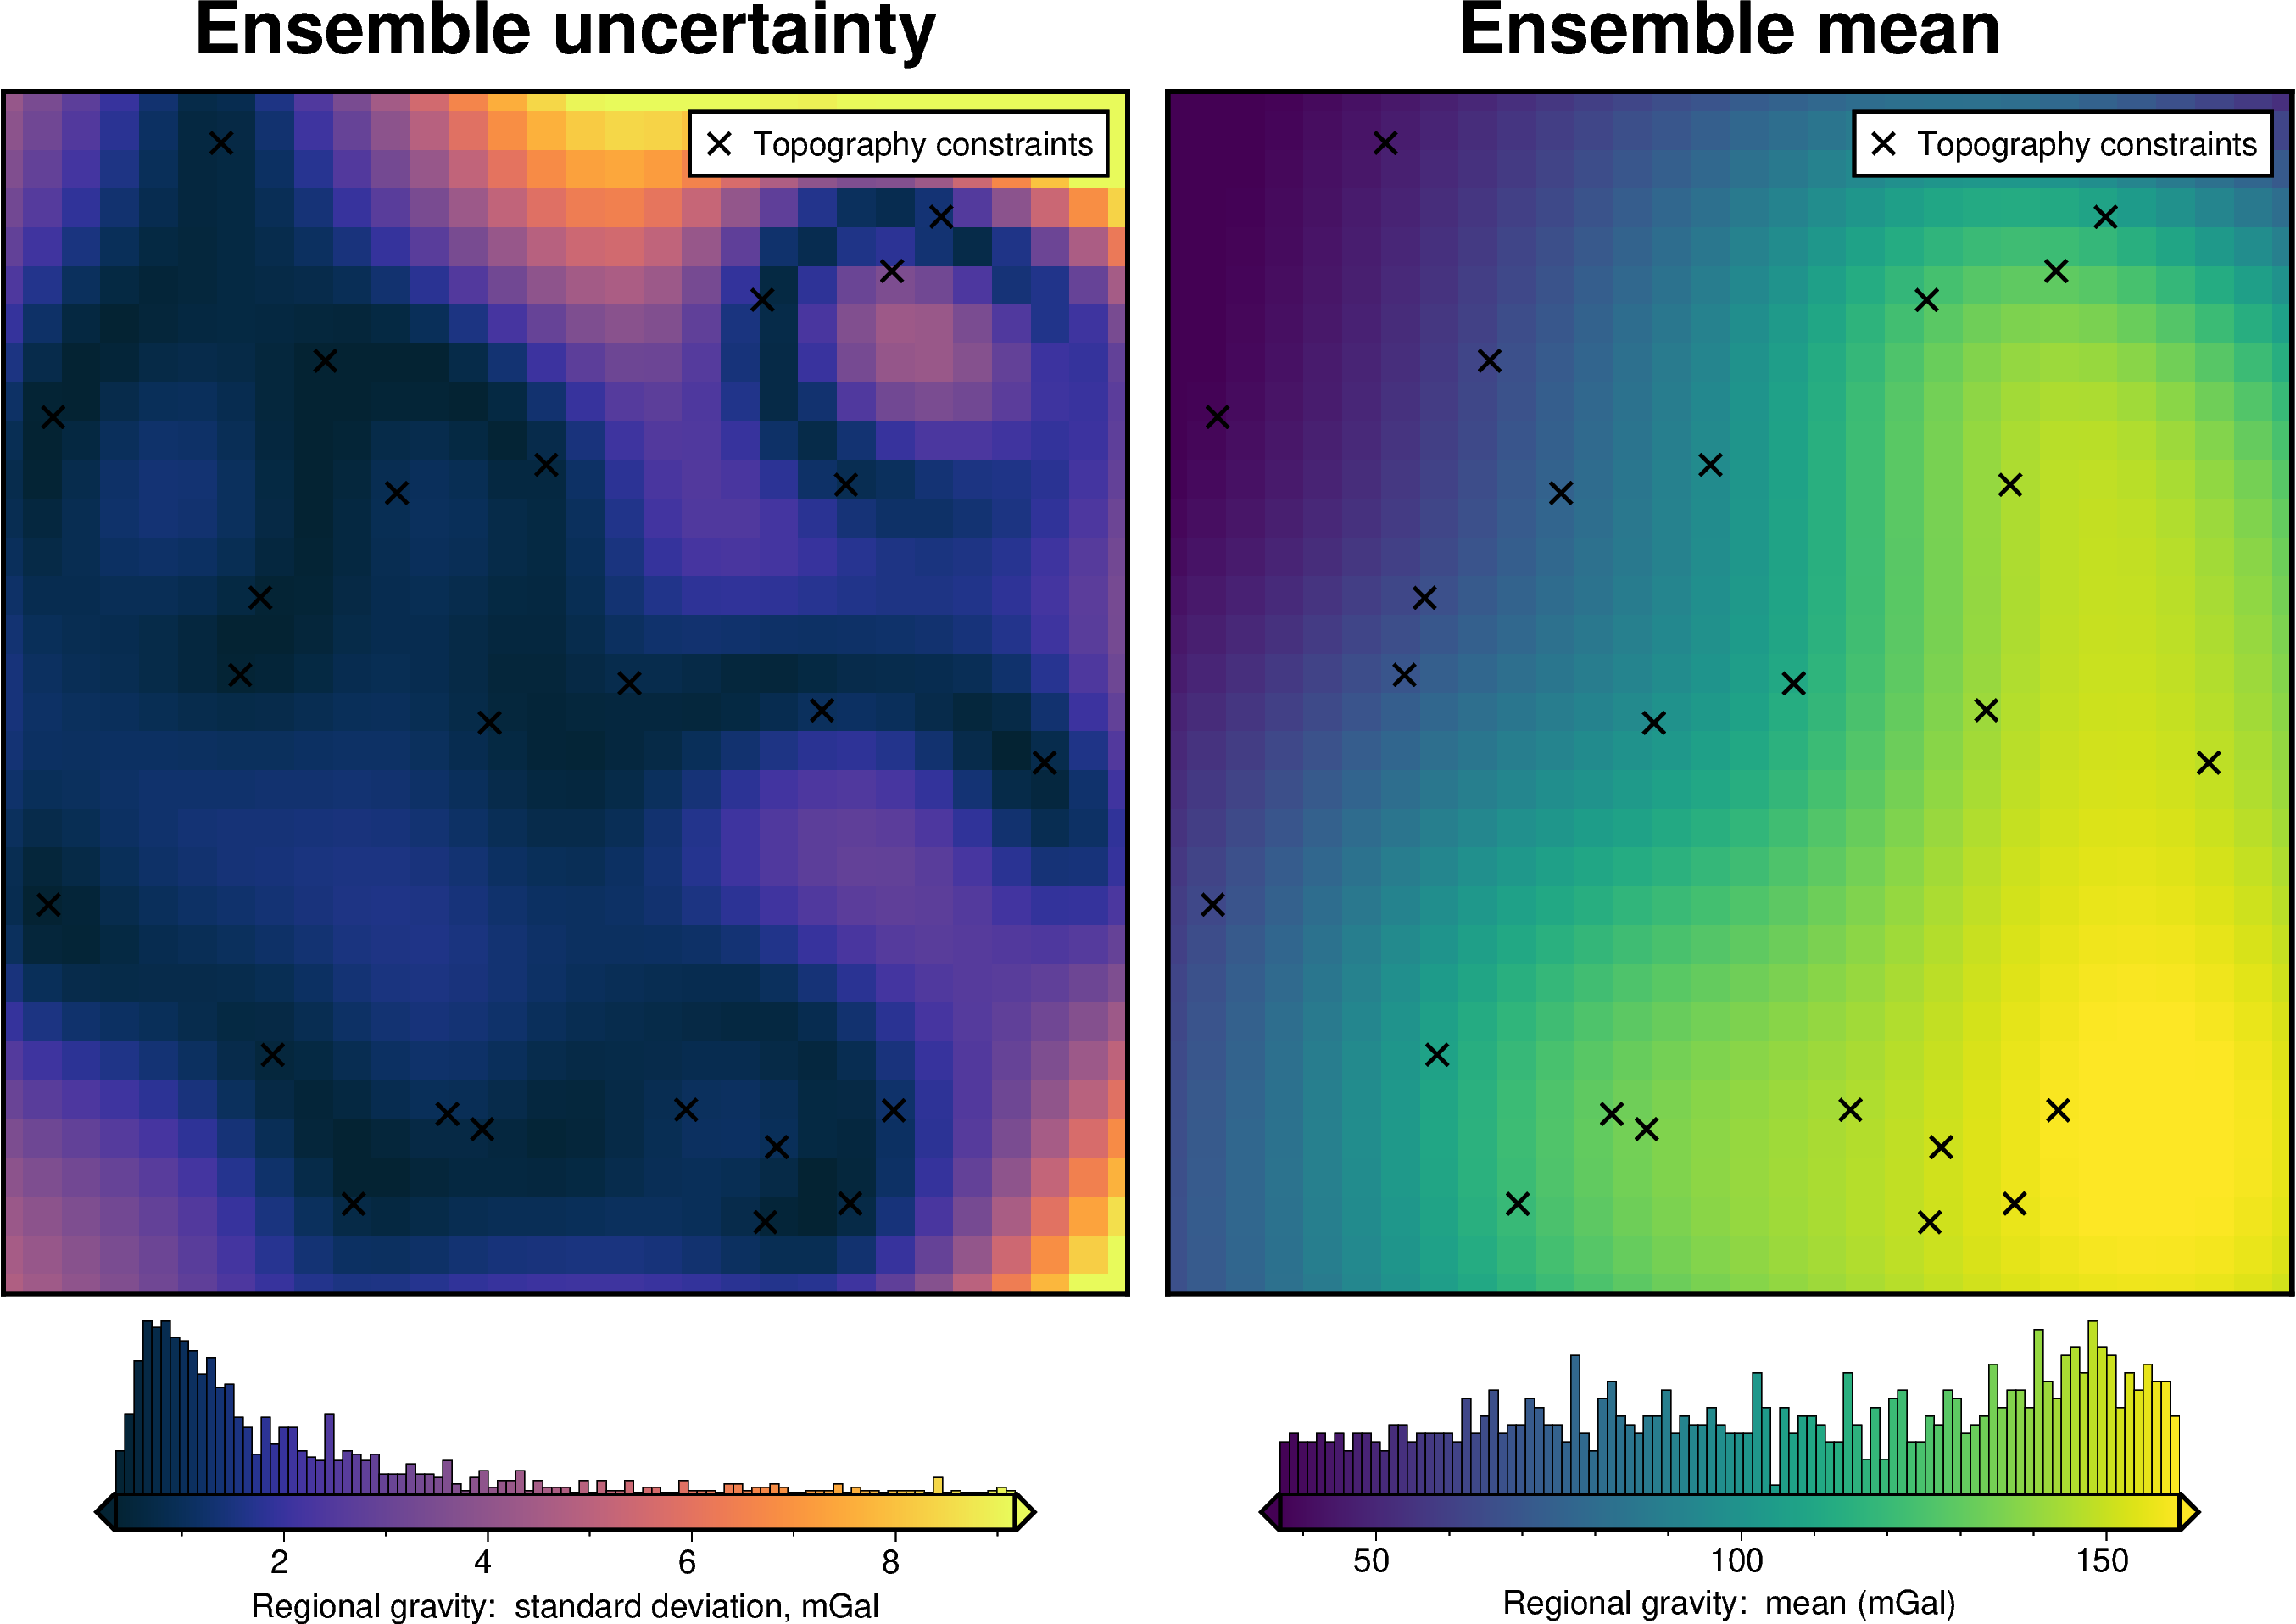

In [61]:
regional_misfit_parameter_dict = {
    "depth": {
        "distribution": "uniform",
        "loc": 2 * mean_constraint_distance,  # lower bound
        "scale": 5 * mean_constraint_distance,  # range, 2+5=7
    },
    "damping": {
        "distribution": "normal",
        "loc": np.log10(eq_damping),  # mean base 10 exponent
        "scale": 1,  # standard deviation of exponent
        "log": True,
    },
}

regional_kwargs = dict(
    grav_df=grav_df,
    constraints_df=constraint_points,
    constraints_weights_column="weight",
    method="constraints",
    grid_method="eq_sources",
    remove_starting_grav_mean=False,
    damping=eq_damping,
    depth="default",
    block_size=None,
)

regional_misfit_stats = uncertainty.regional_misfit_uncertainty(
    runs=40,
    sample_gravity=True,
    parameter_dict=regional_misfit_parameter_dict,
    plot_region=inversion_region,
    **regional_kwargs,
)

## Sensitivity Analysis

Above we perform an uncertainty assessment using all the important parameters and data. Now, we can repeat this stochastic analysis isolated the uncertainty arising from each component. This should give us a sense of which parameters/data are the most important.

In [62]:
# plotting functions for uncertainty results
def uncert_plots(results):
    ds = uncertainty.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraint_points,
        weight_by="constraints",
        region=inversion_region,
    )
    ds = ds.sel(
        {
            "easting": slice(*inversion_region[:2]),
            "northing": slice(*inversion_region[2:]),
        }
    )

    _ = polar_utils.grd_compare(
        grid.basement_topo,
        ds.weighted_mean,
        plot=True,
        region=inversion_region,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        inversion_error,
        ds.weighted_stdev,
        plot=True,
        region=inversion_region,
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )

In [63]:
# parameters used in final inversion
best_density_contrast, best_zref, best_damping, best_spline_damping

(281.3849798522567,
 -8603.925969328728,
 0.0063216575074670316,
 np.float64(1.2898902612533134e-18))

In [64]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    constraints_df=constraint_points,
    density_contrast=best_density_contrast,
    zref=best_zref,
    solver_damping=best_damping,
    starting_prisms=starting_prisms,
    starting_topography=starting_topography,
    # kwargs
    starting_topography_kwargs={
        "method": "splines",
        "region": buffer_region,
        "spacing": topo_spacing,
        "constraints_df": constraint_points,
        "dampings": best_spline_damping,
        "weights": constraint_points.weight,
    },
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

### Density component

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 281.3849798522568, min: -12.609617828751482, max: 575.3795775332651
INFO:invert4geom:No pickle files starting with 'tmp/bishop_uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/bishop_uncertainty_density'



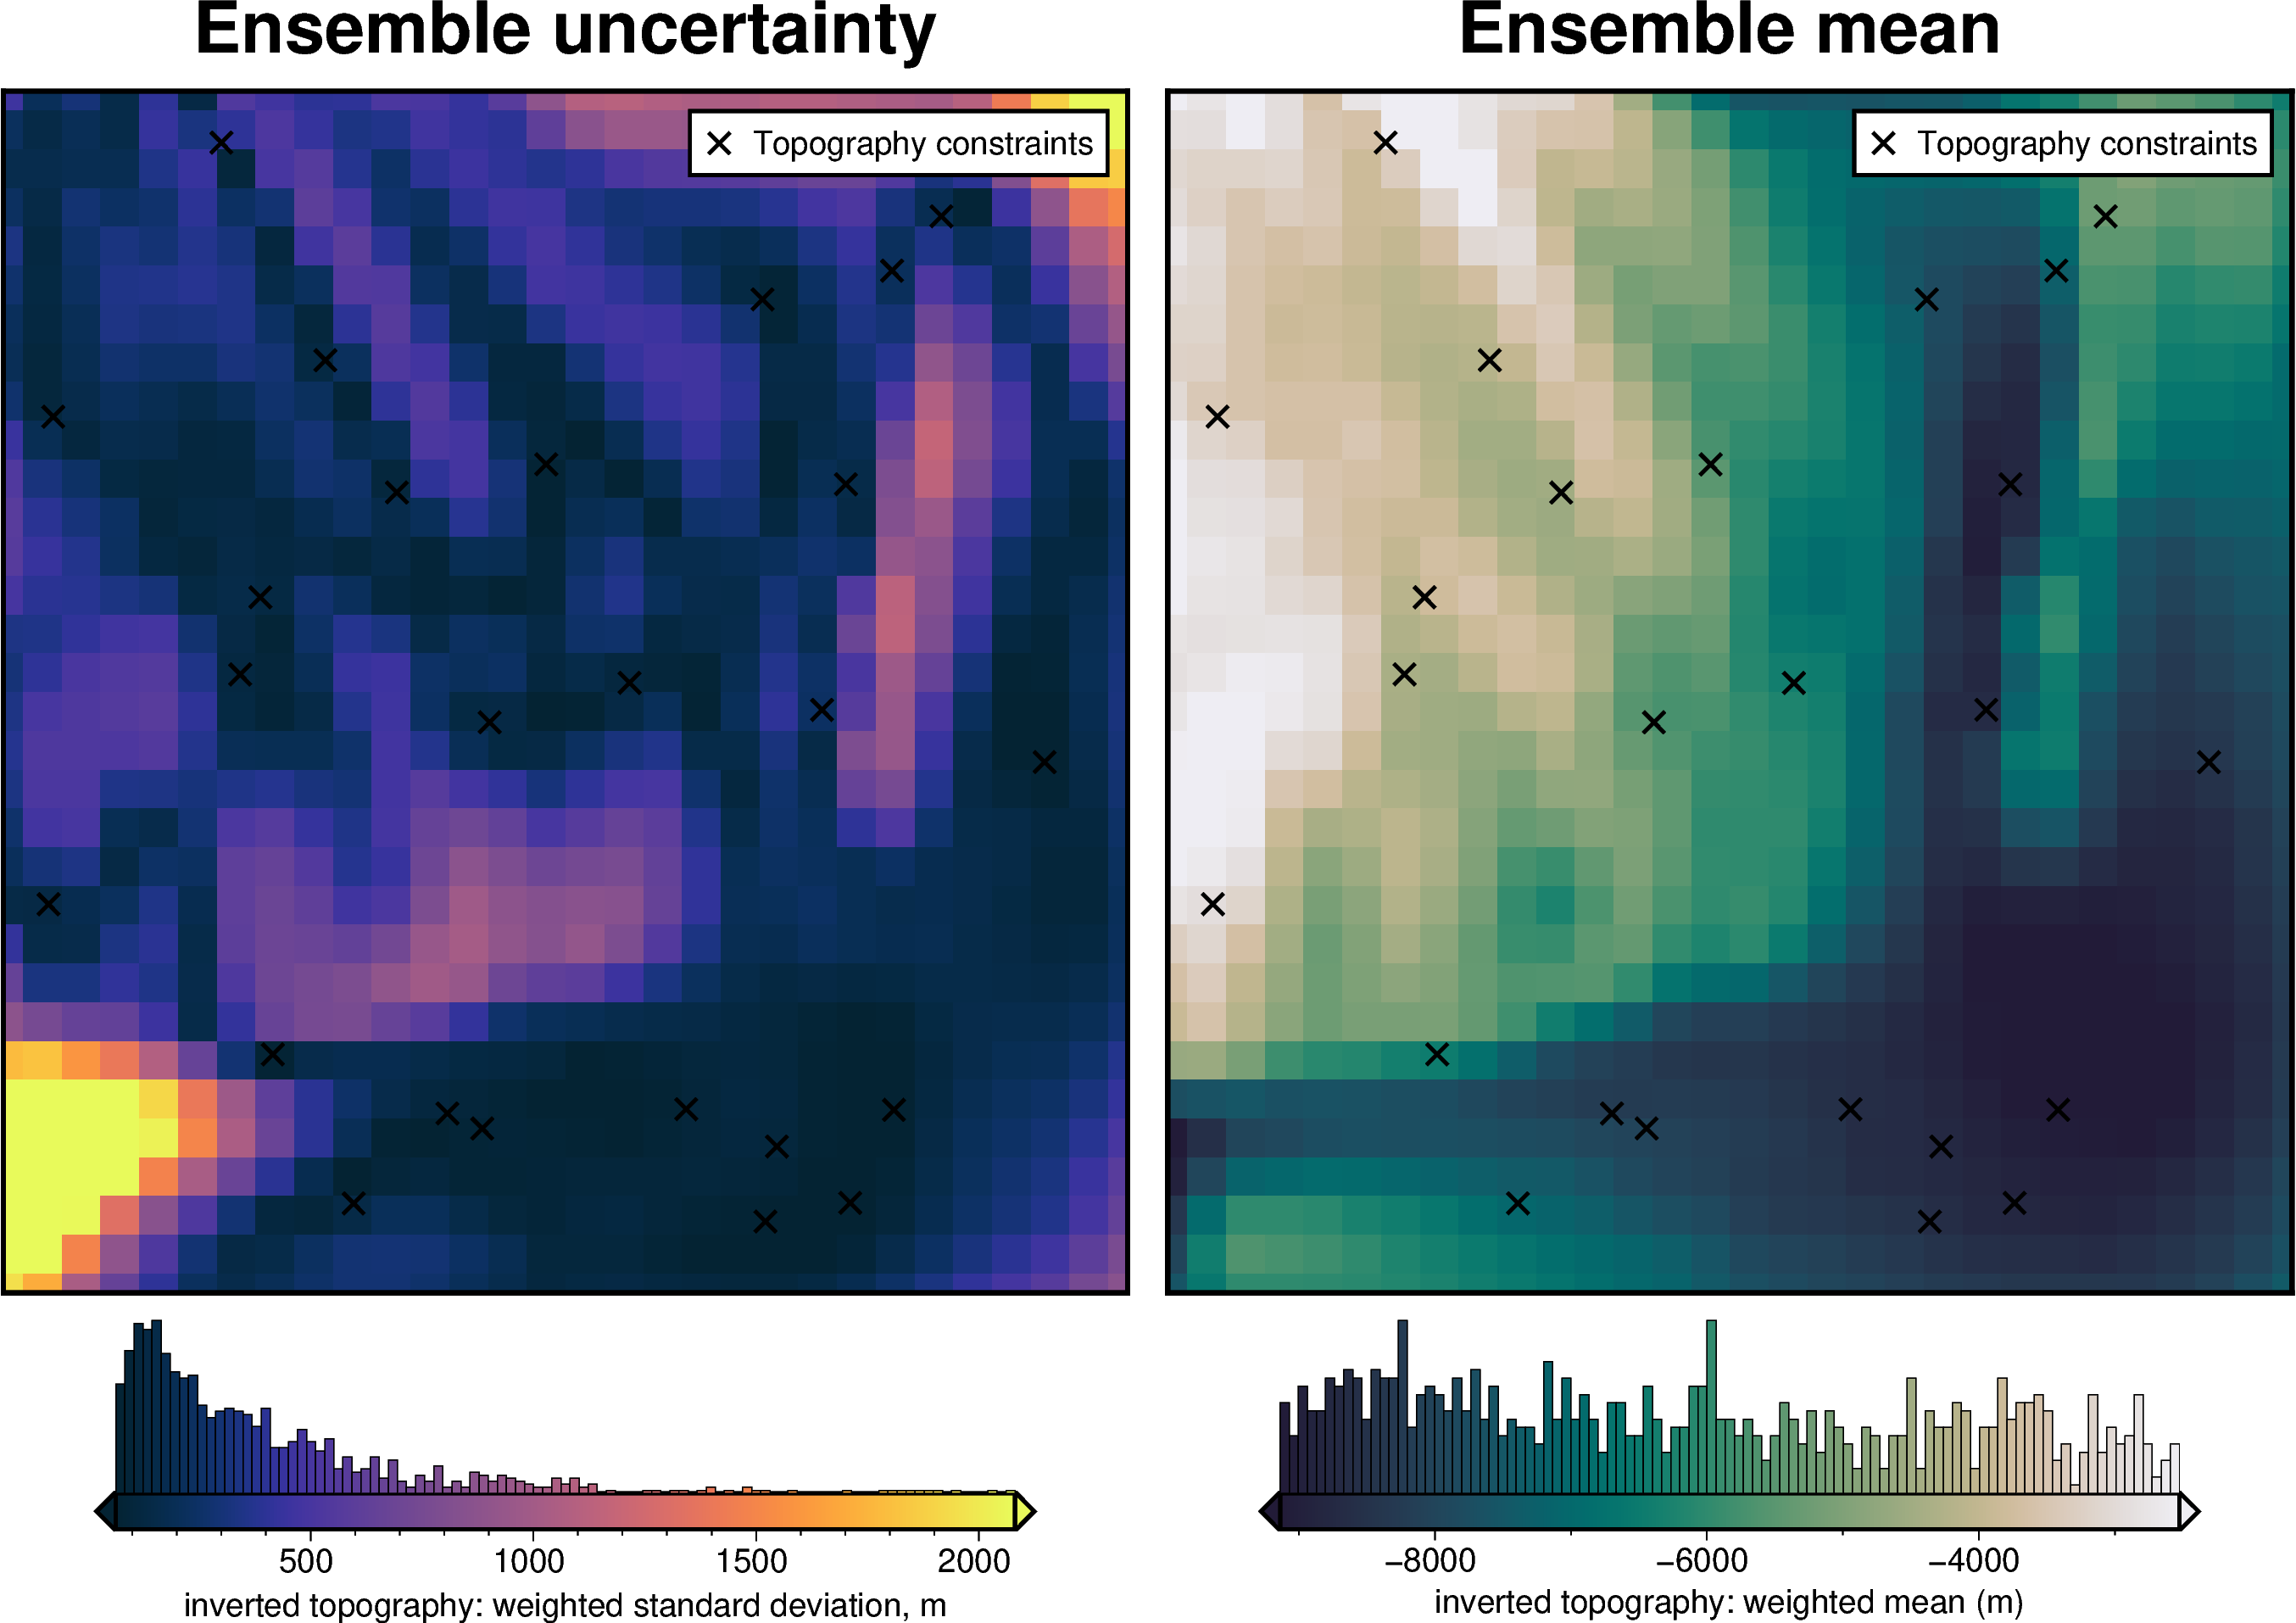

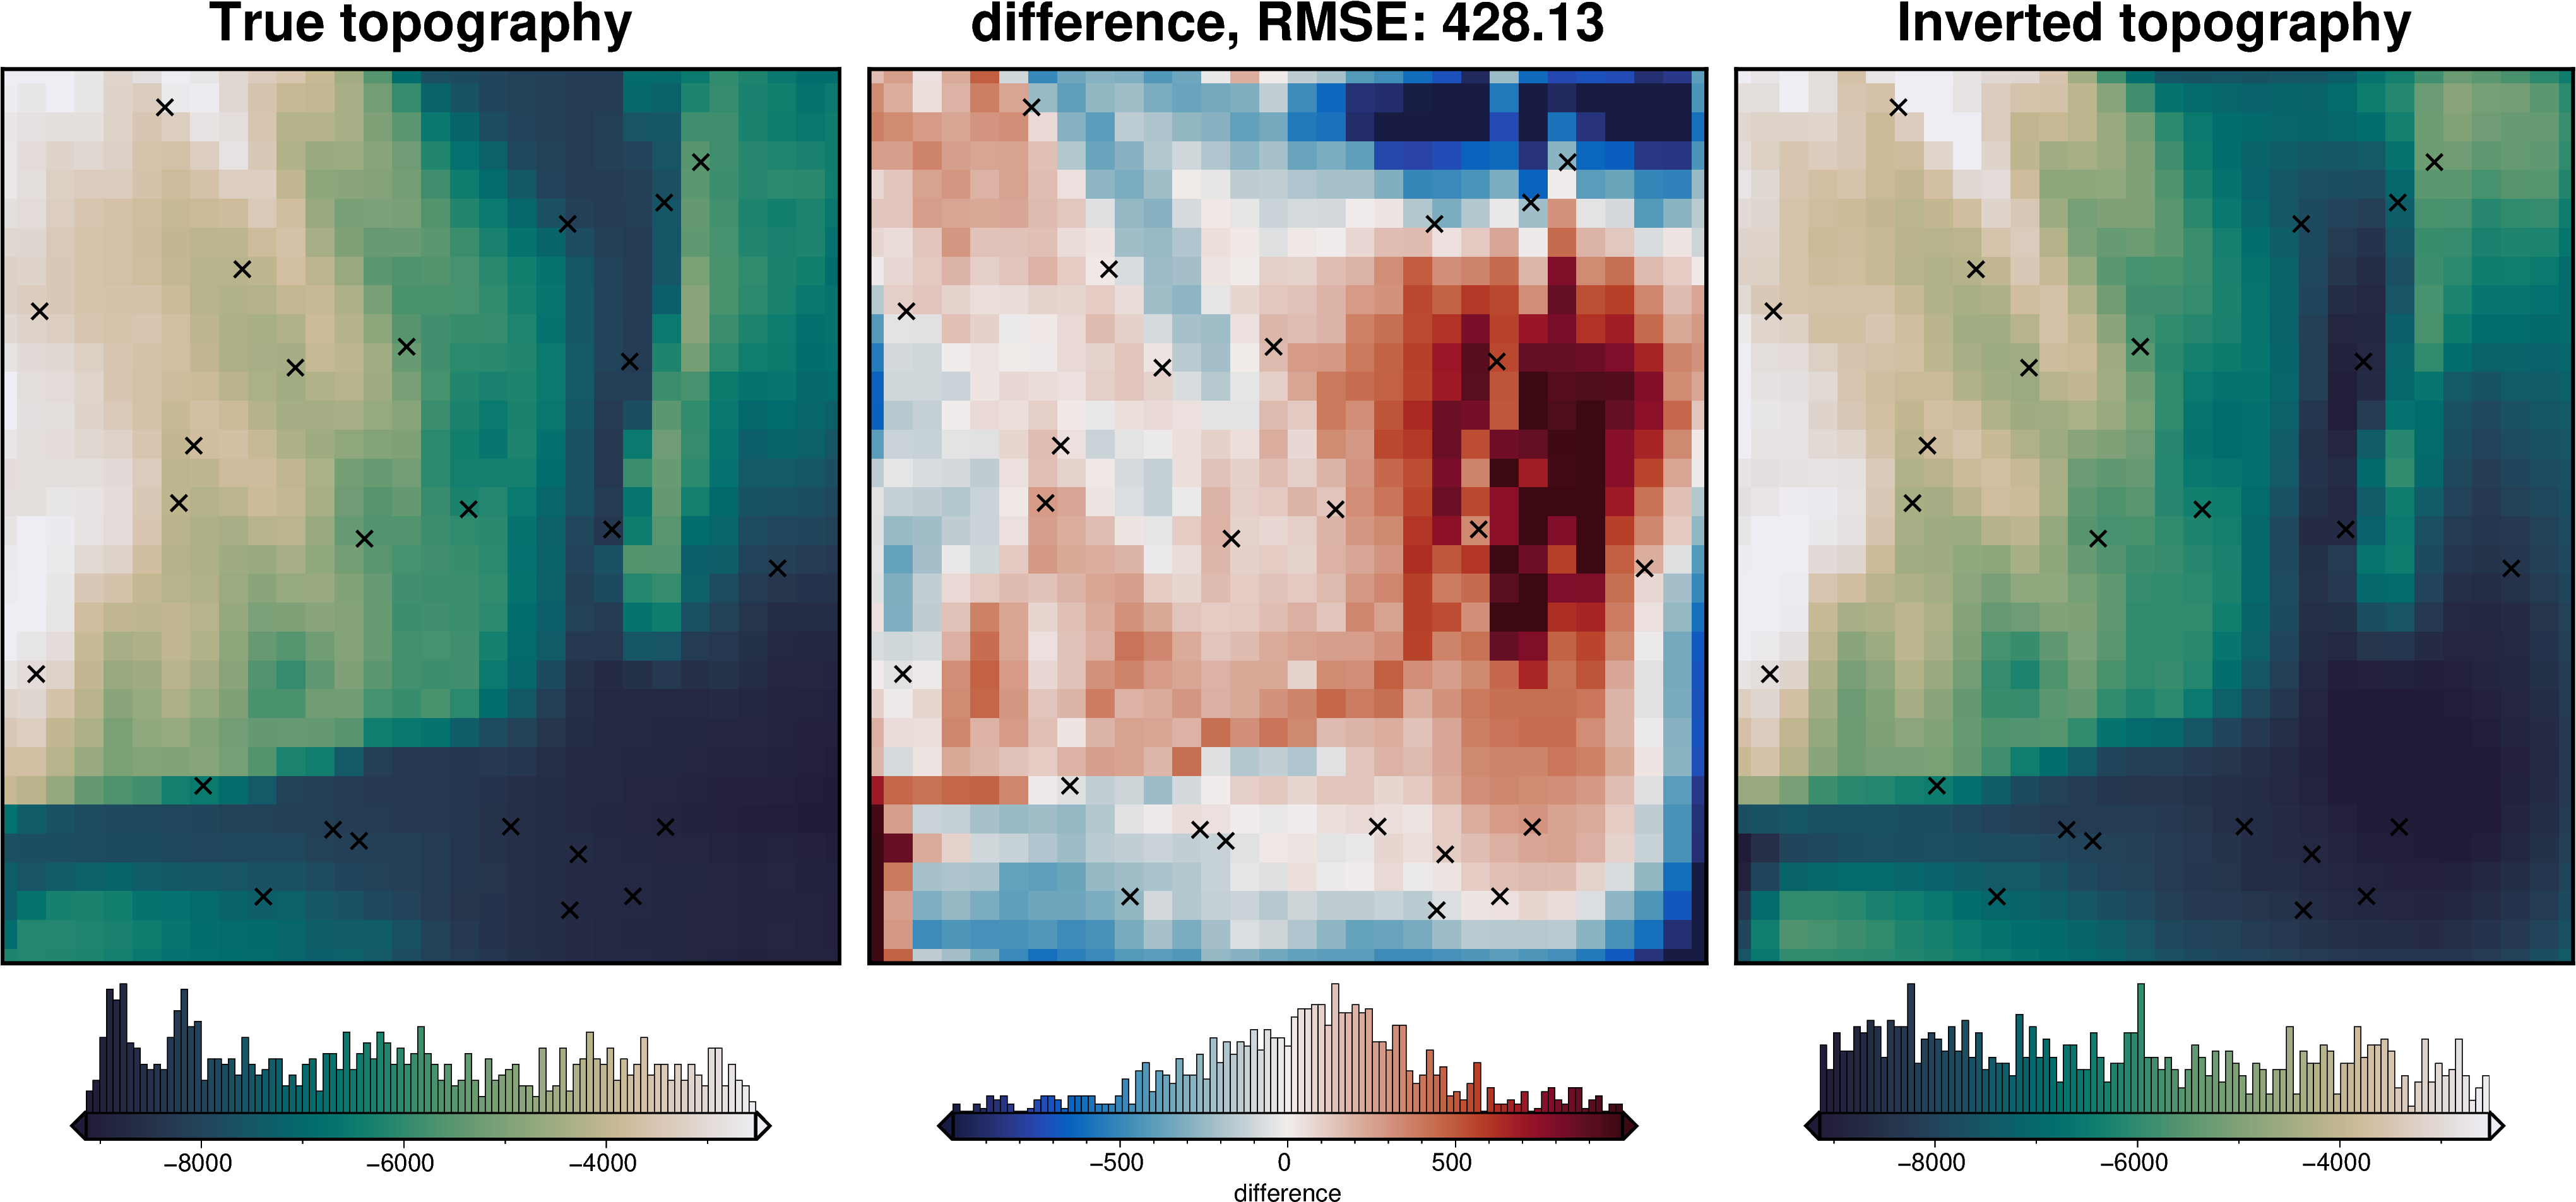

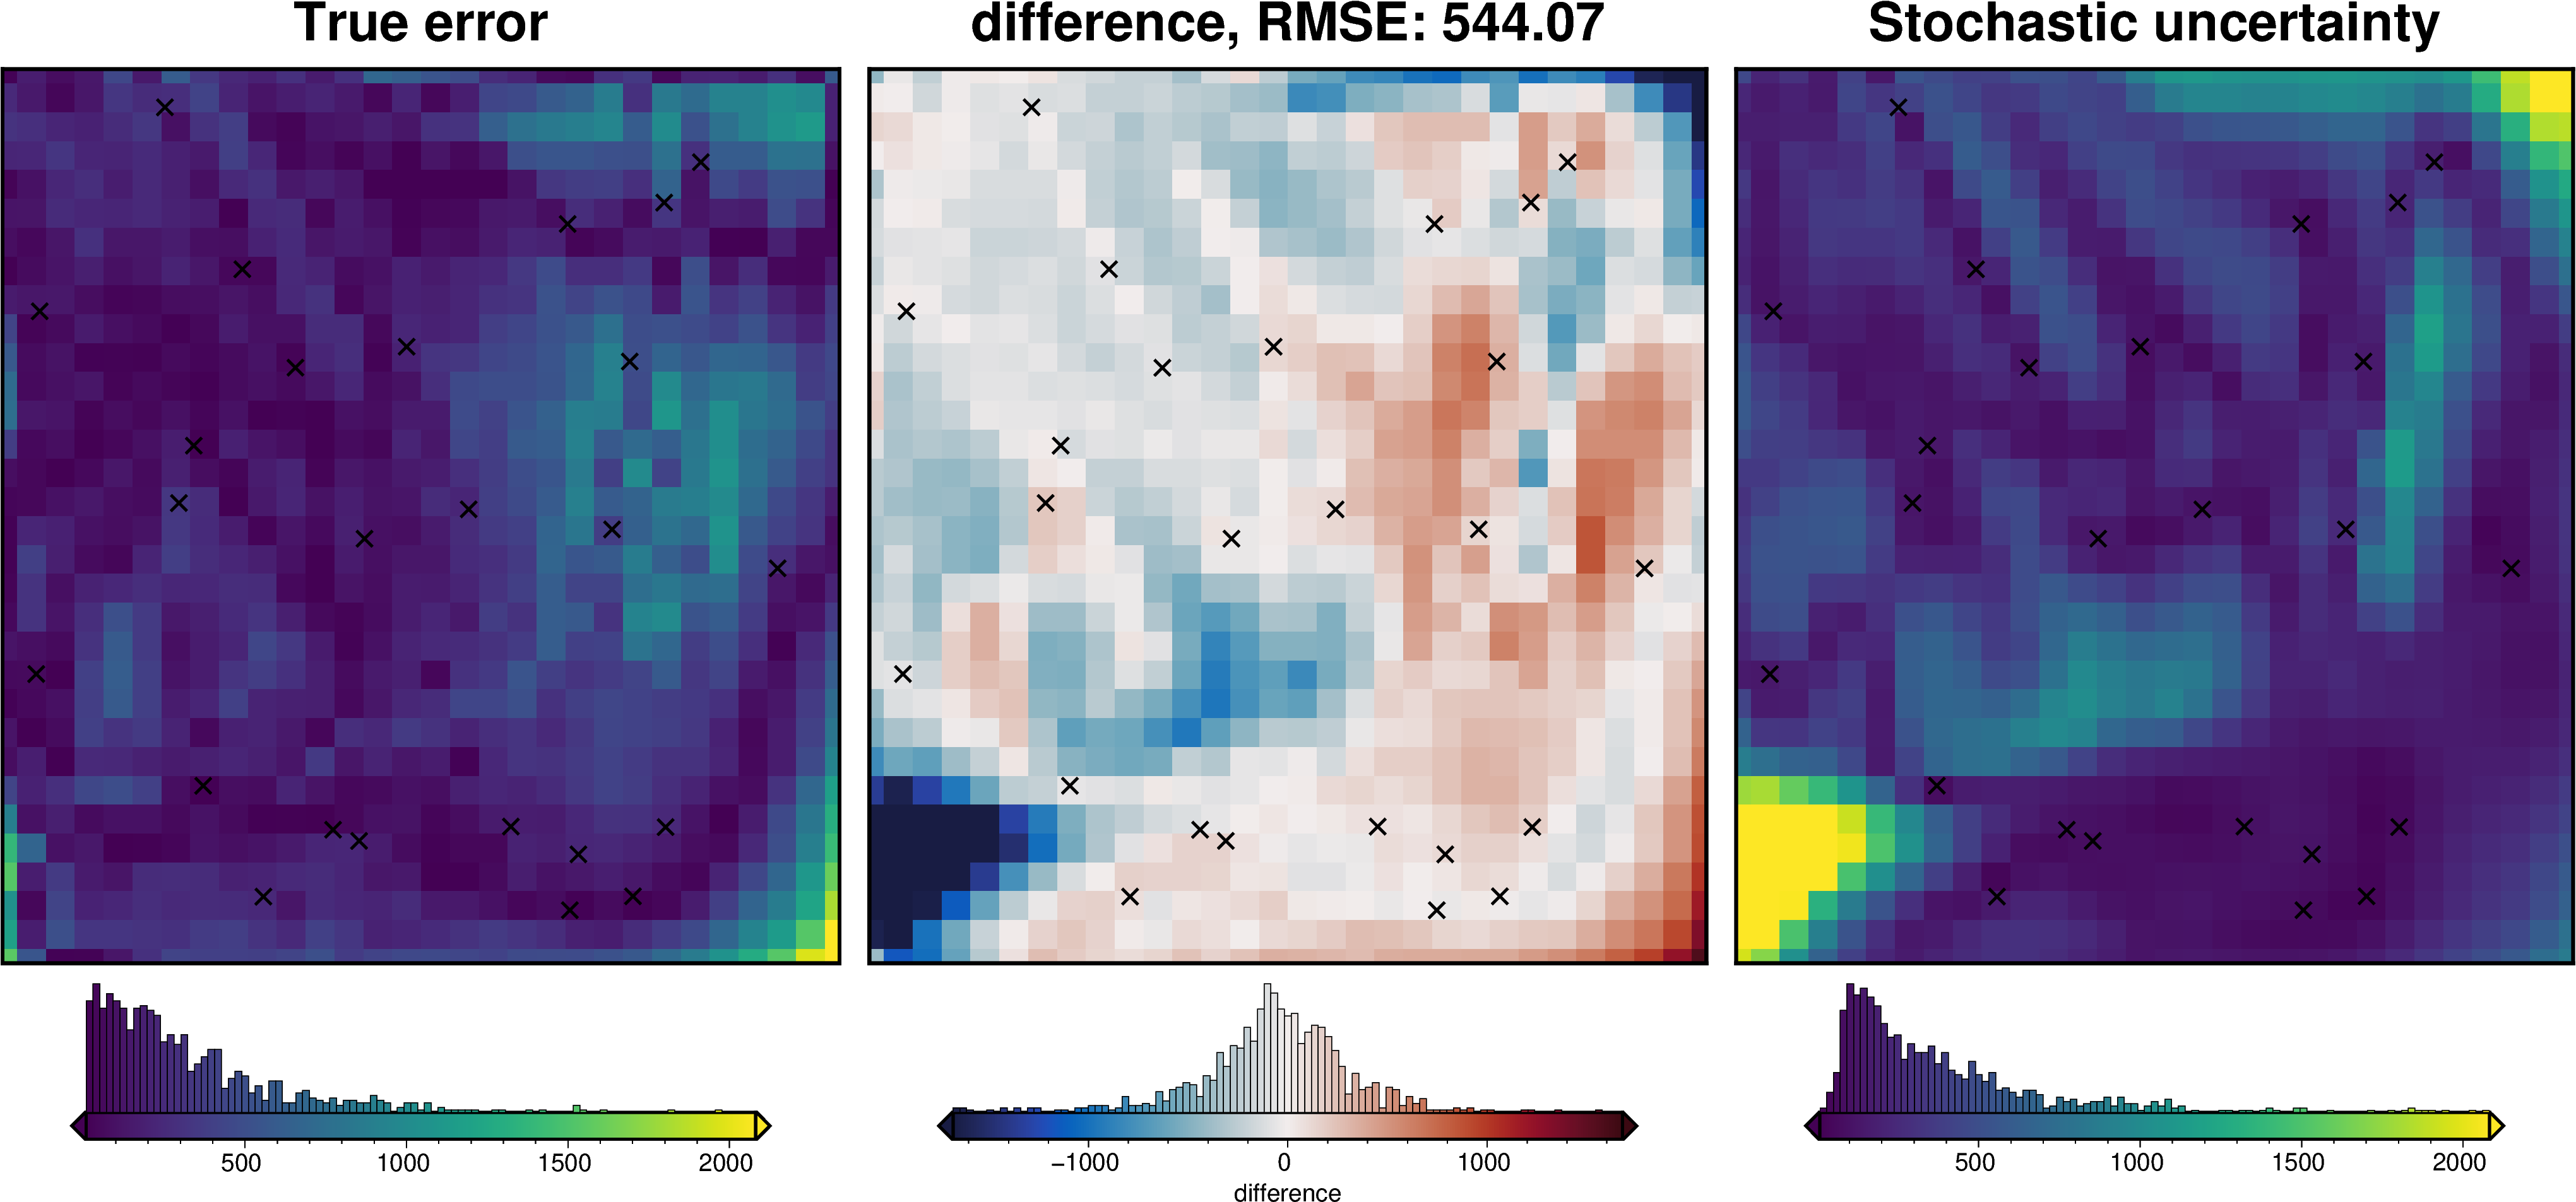

In [65]:
parameter_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": 150,
    },
}

fname = "tmp/bishop_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_density_results)

### Damping component

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.006977538439513297, min: 0.002563528595105504, max: 0.015589197529536268
INFO:invert4geom:No pickle files starting with 'tmp/bishop_uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/bishop_uncertainty_damping'



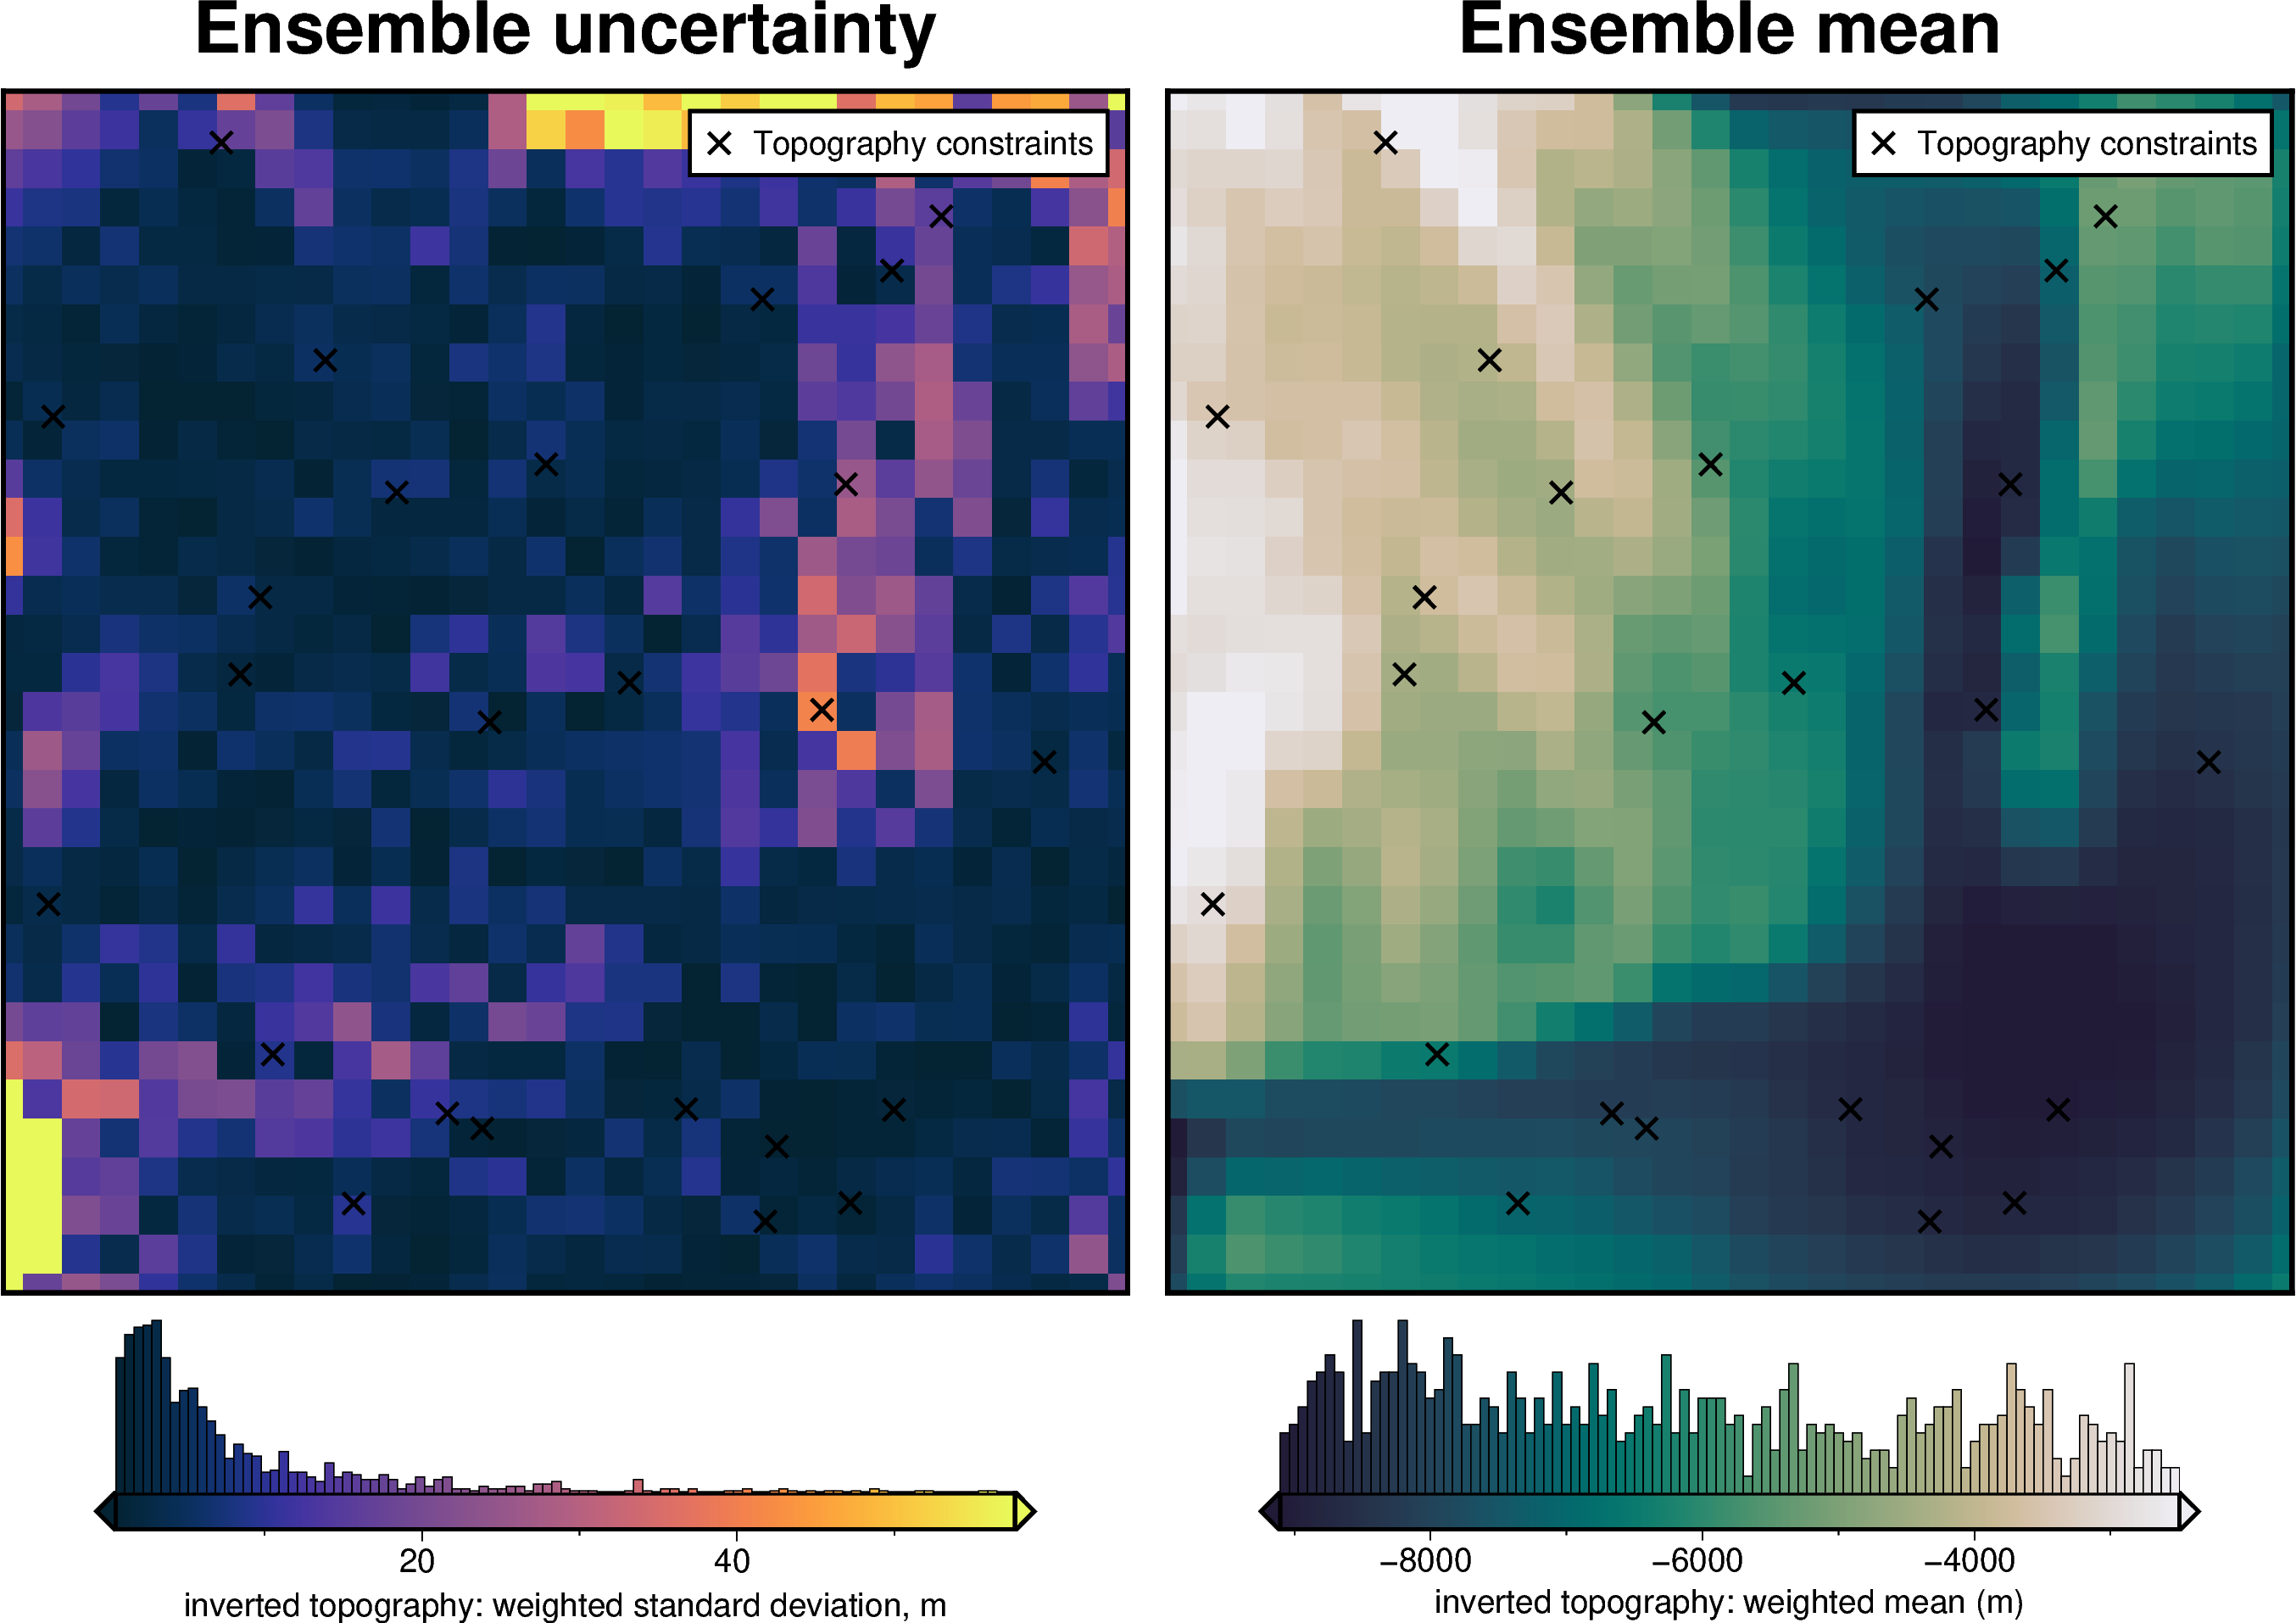

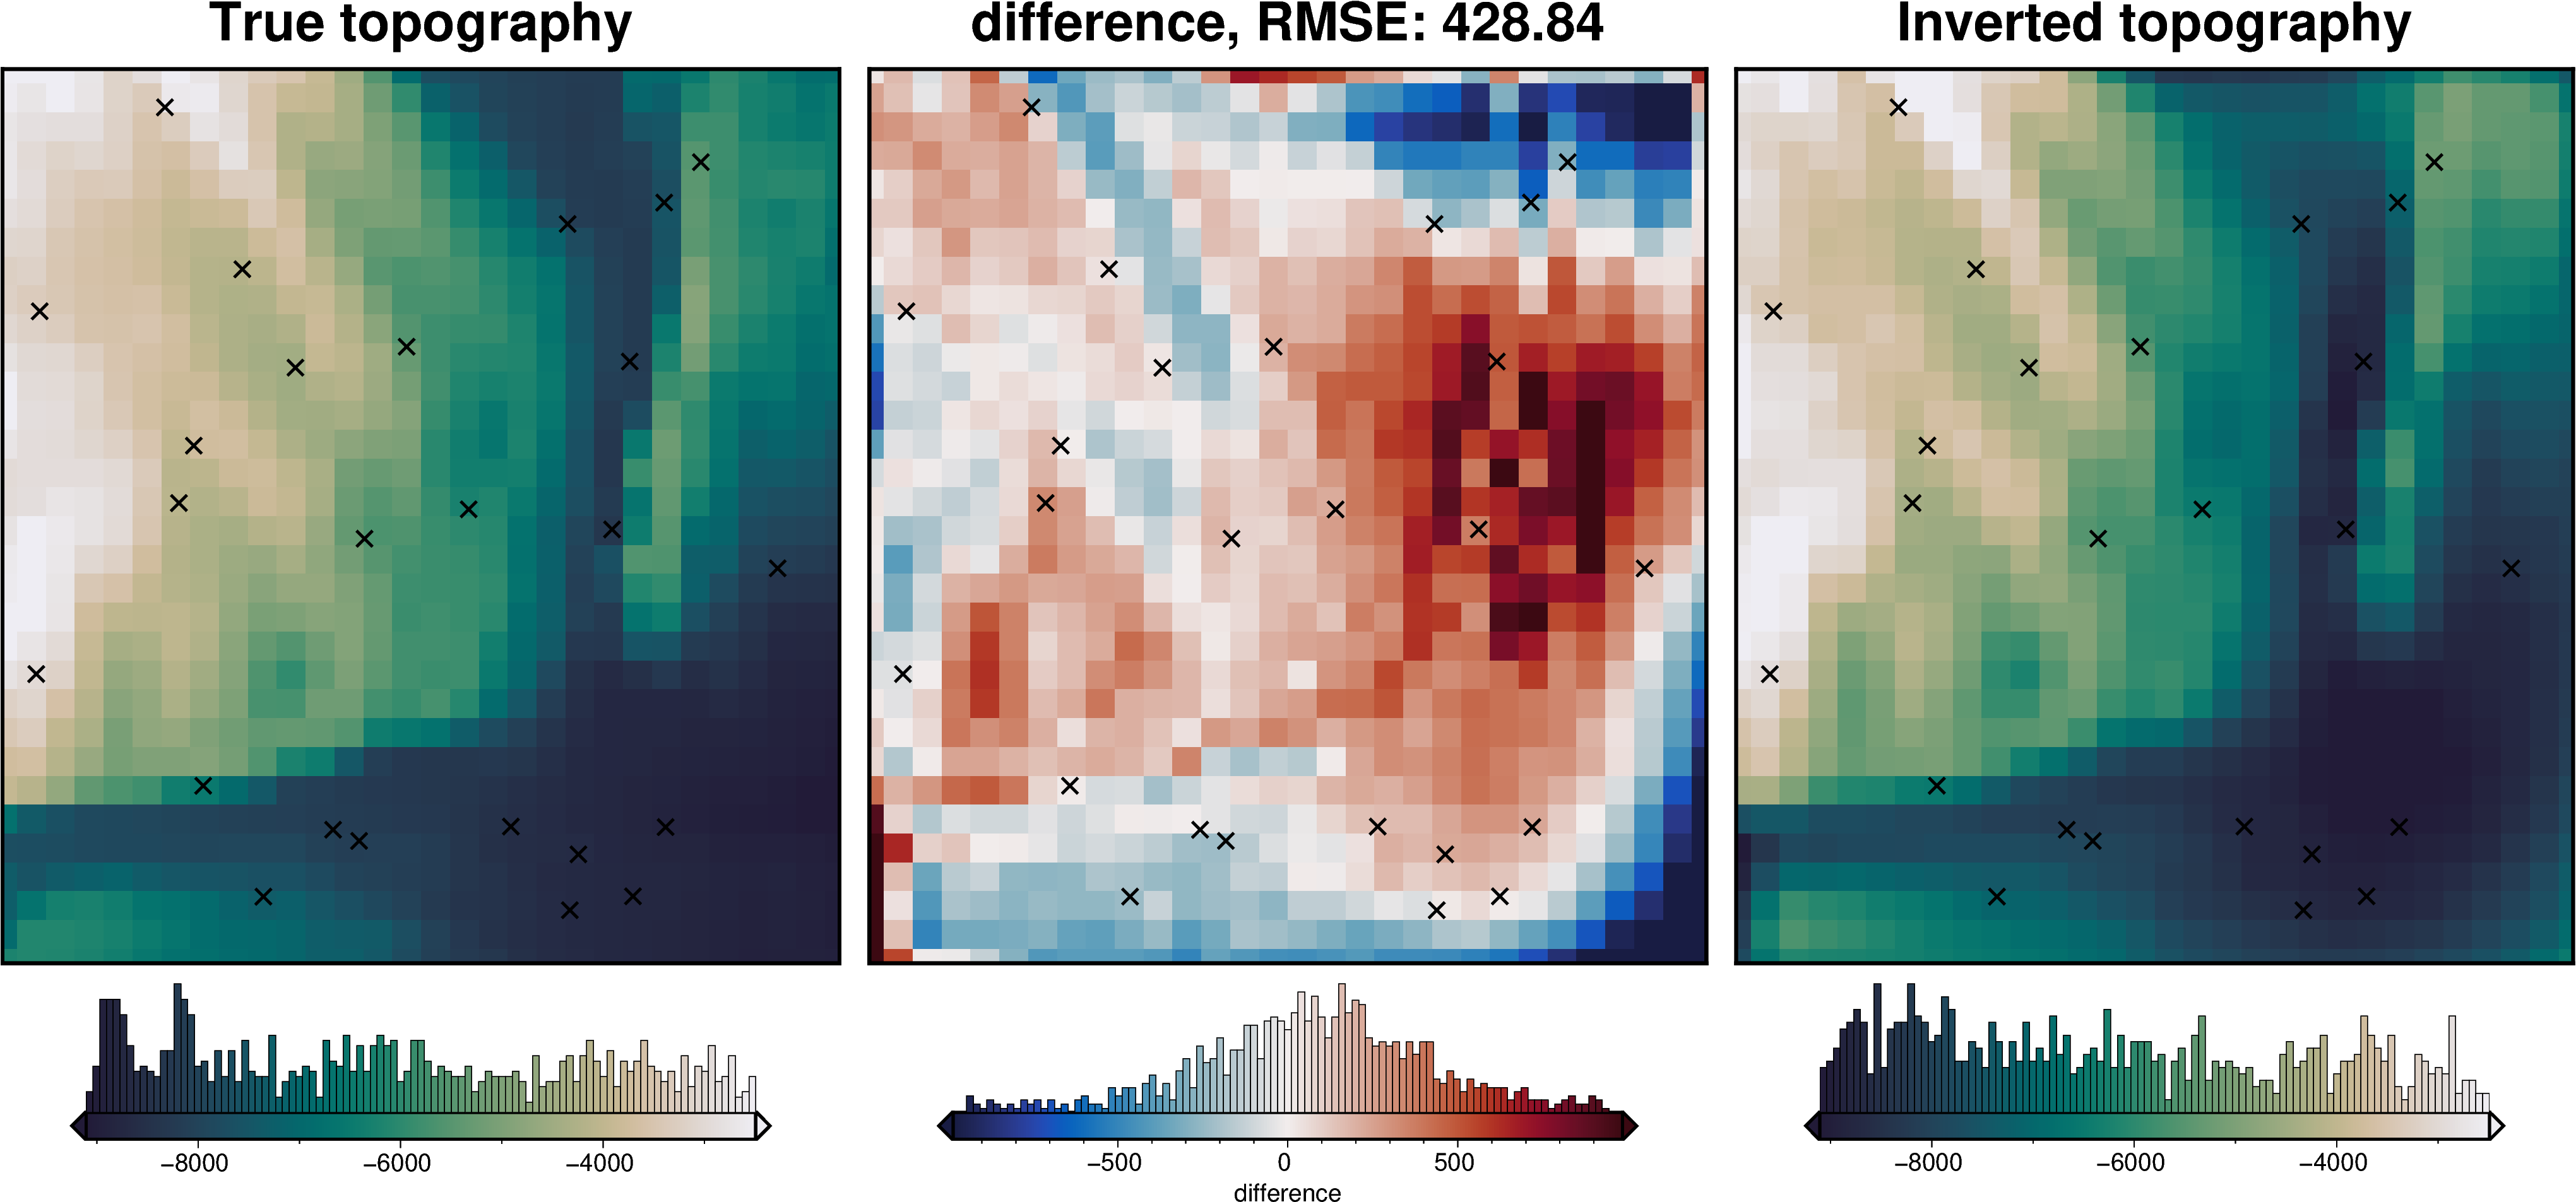

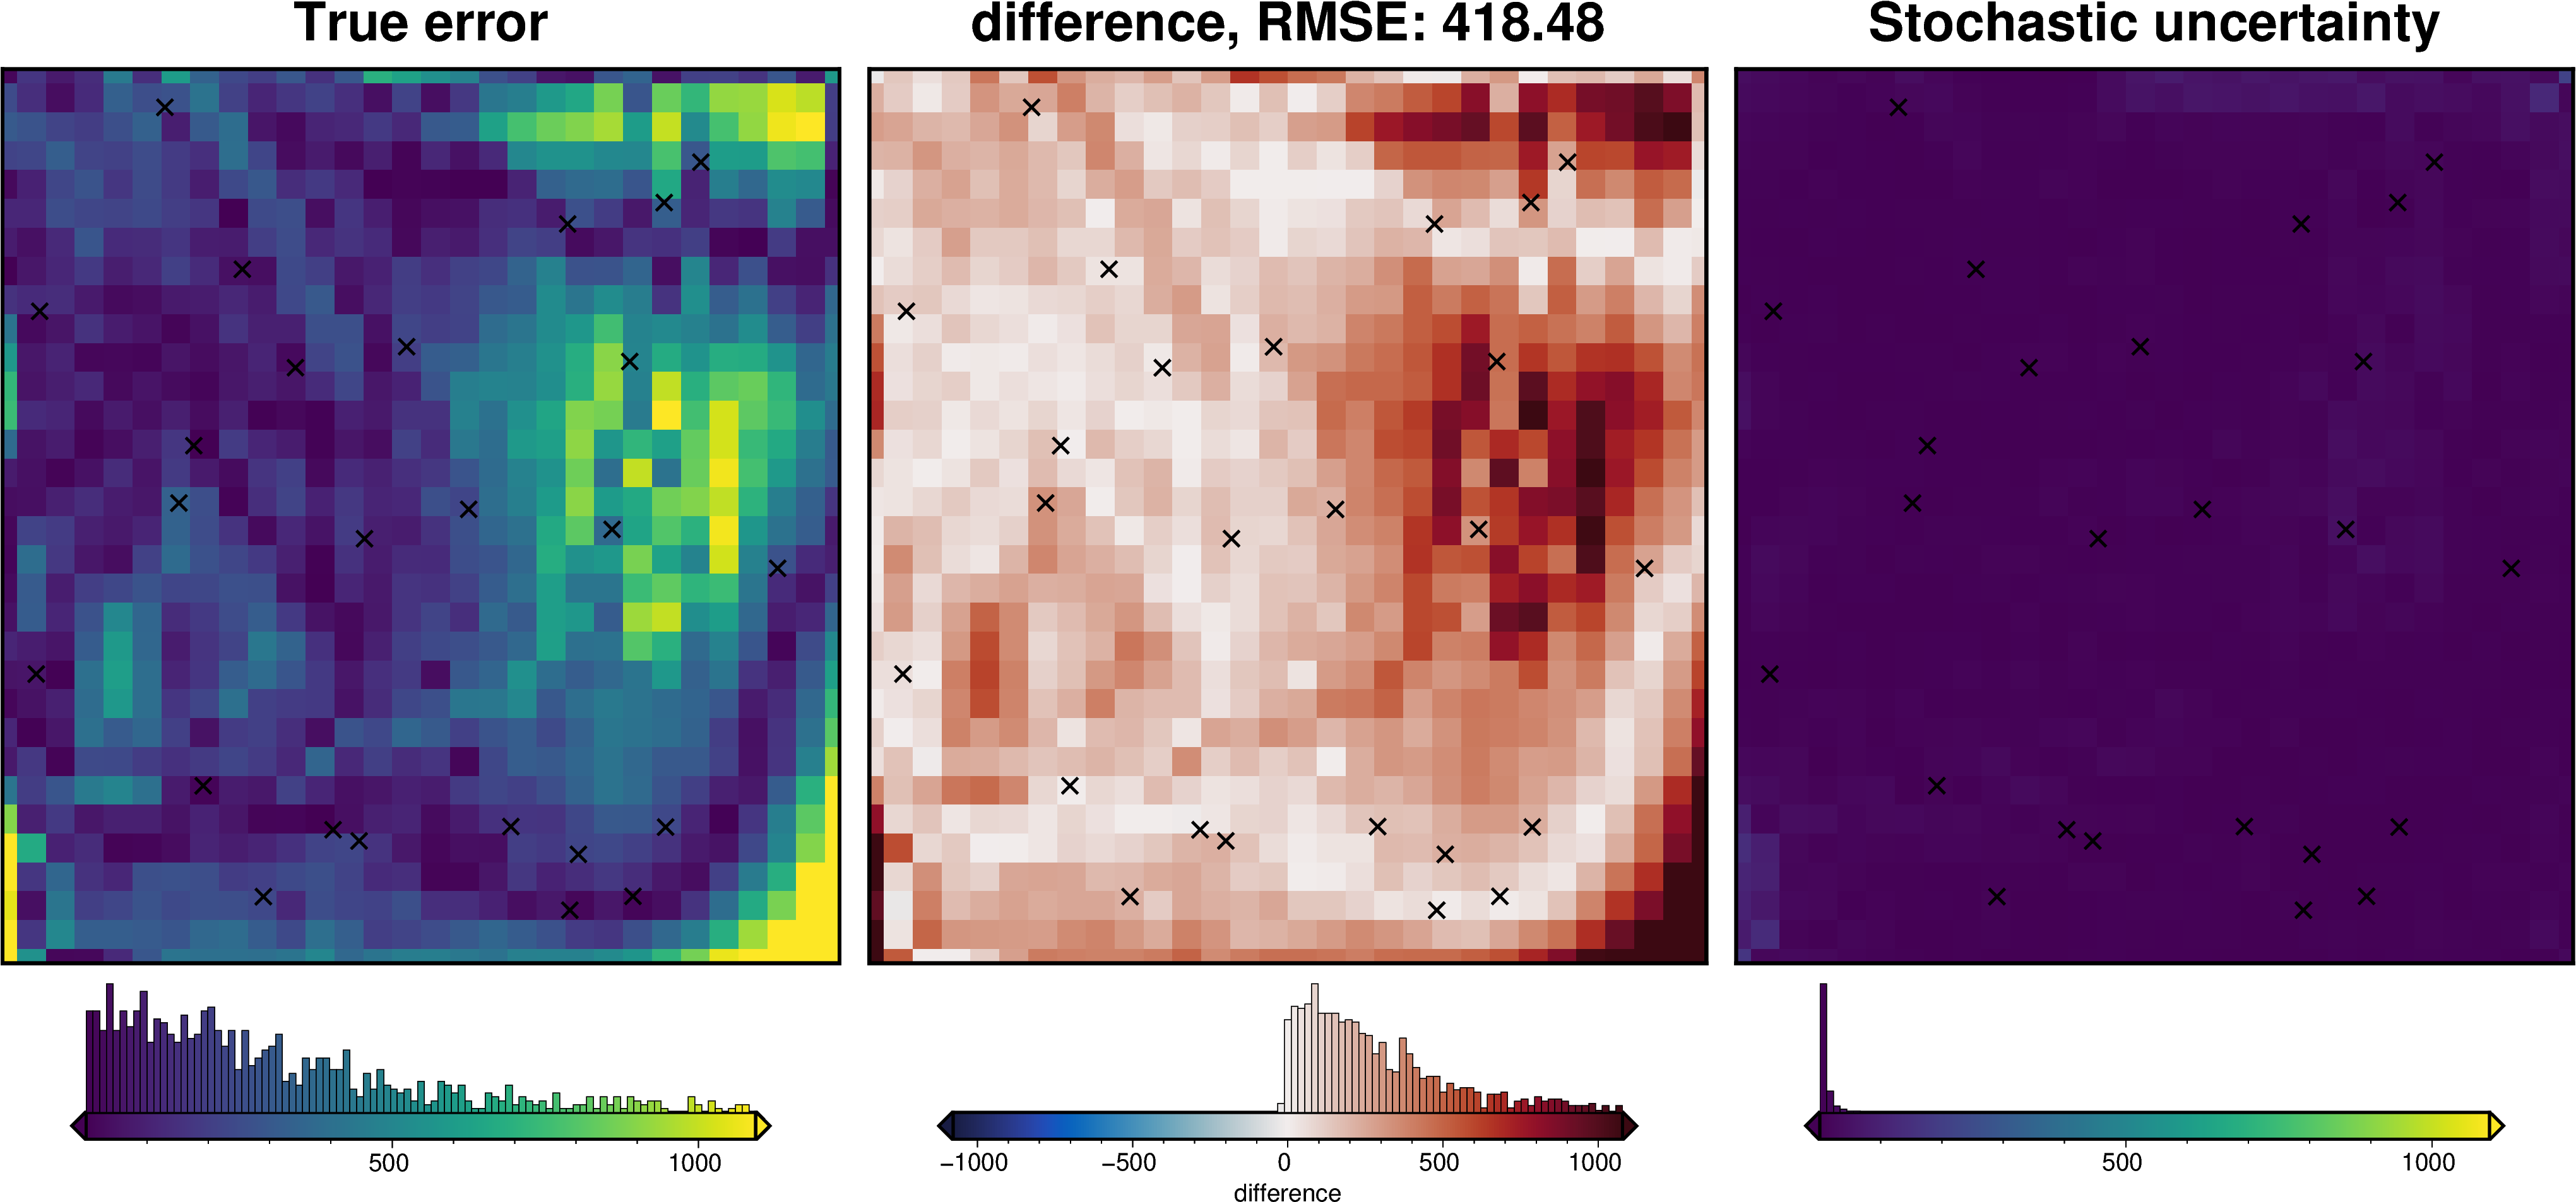

In [66]:
parameter_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean base 10 exponent
        "scale": 0.2,
        "log": True,
    },
}

fname = "tmp/bishop_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_damping_results)

### Gravity component

INFO:invert4geom:No pickle files starting with 'tmp/bishop_uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/bishop_uncertainty_grav'



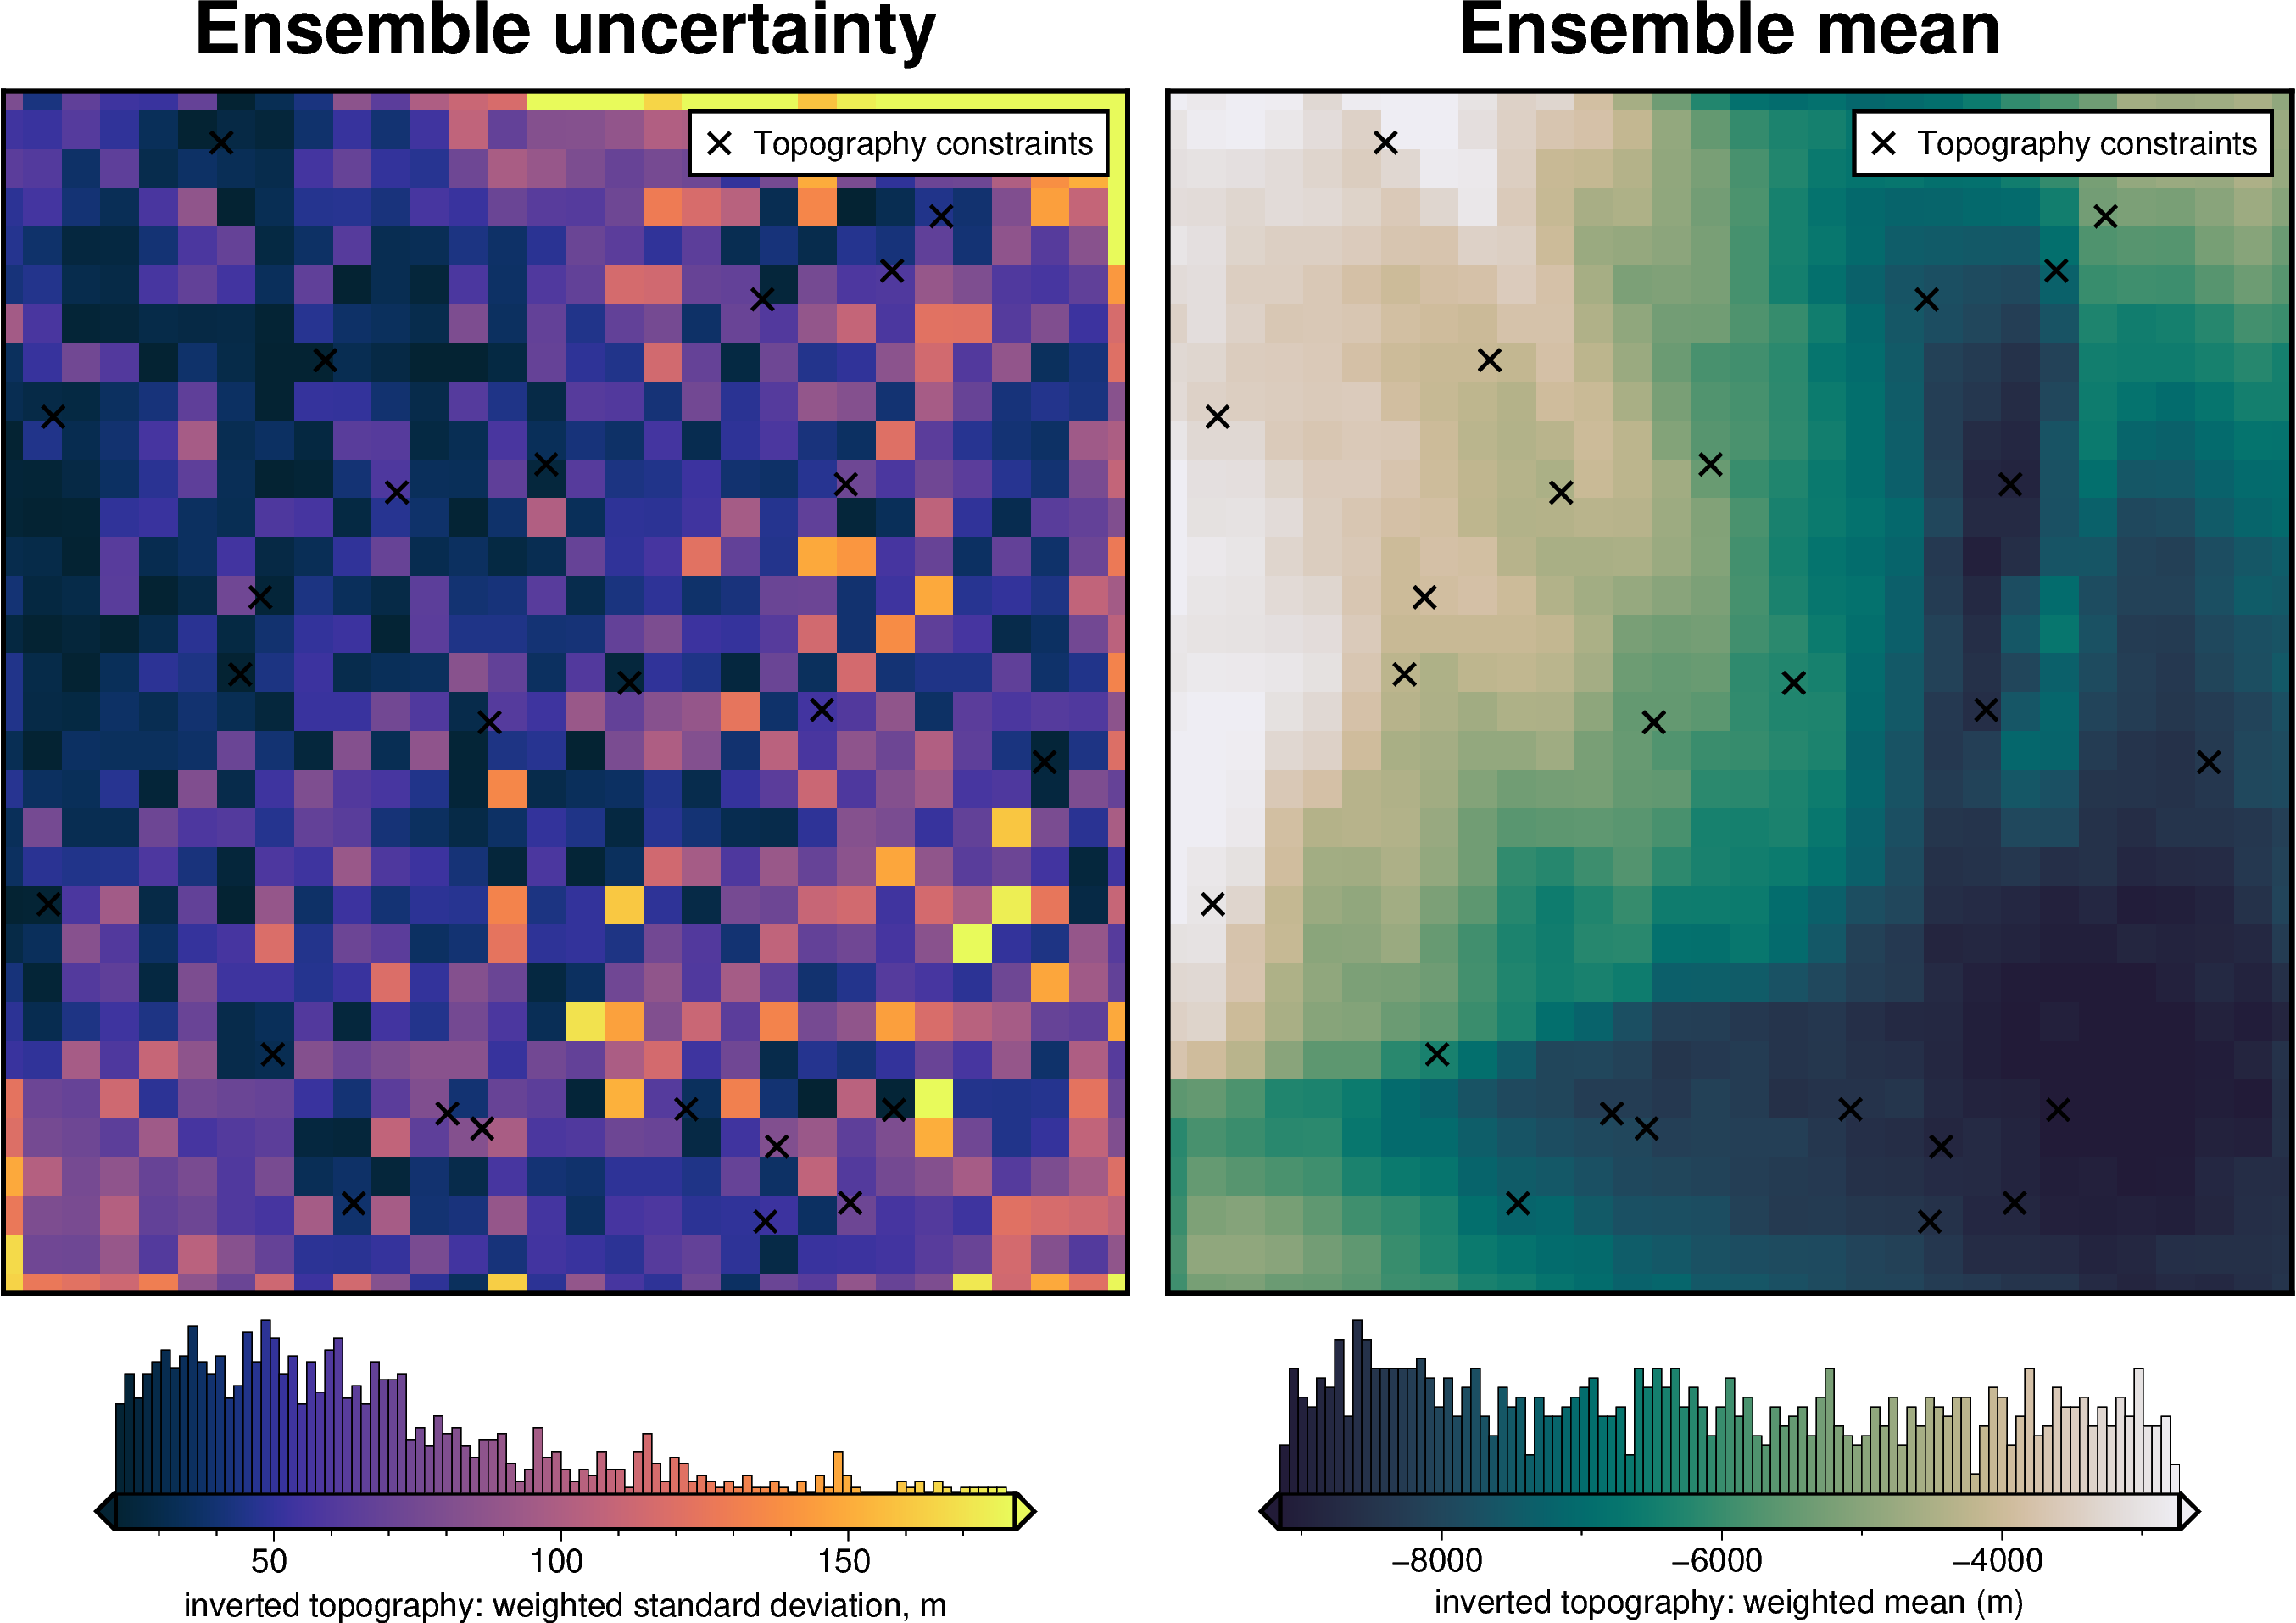

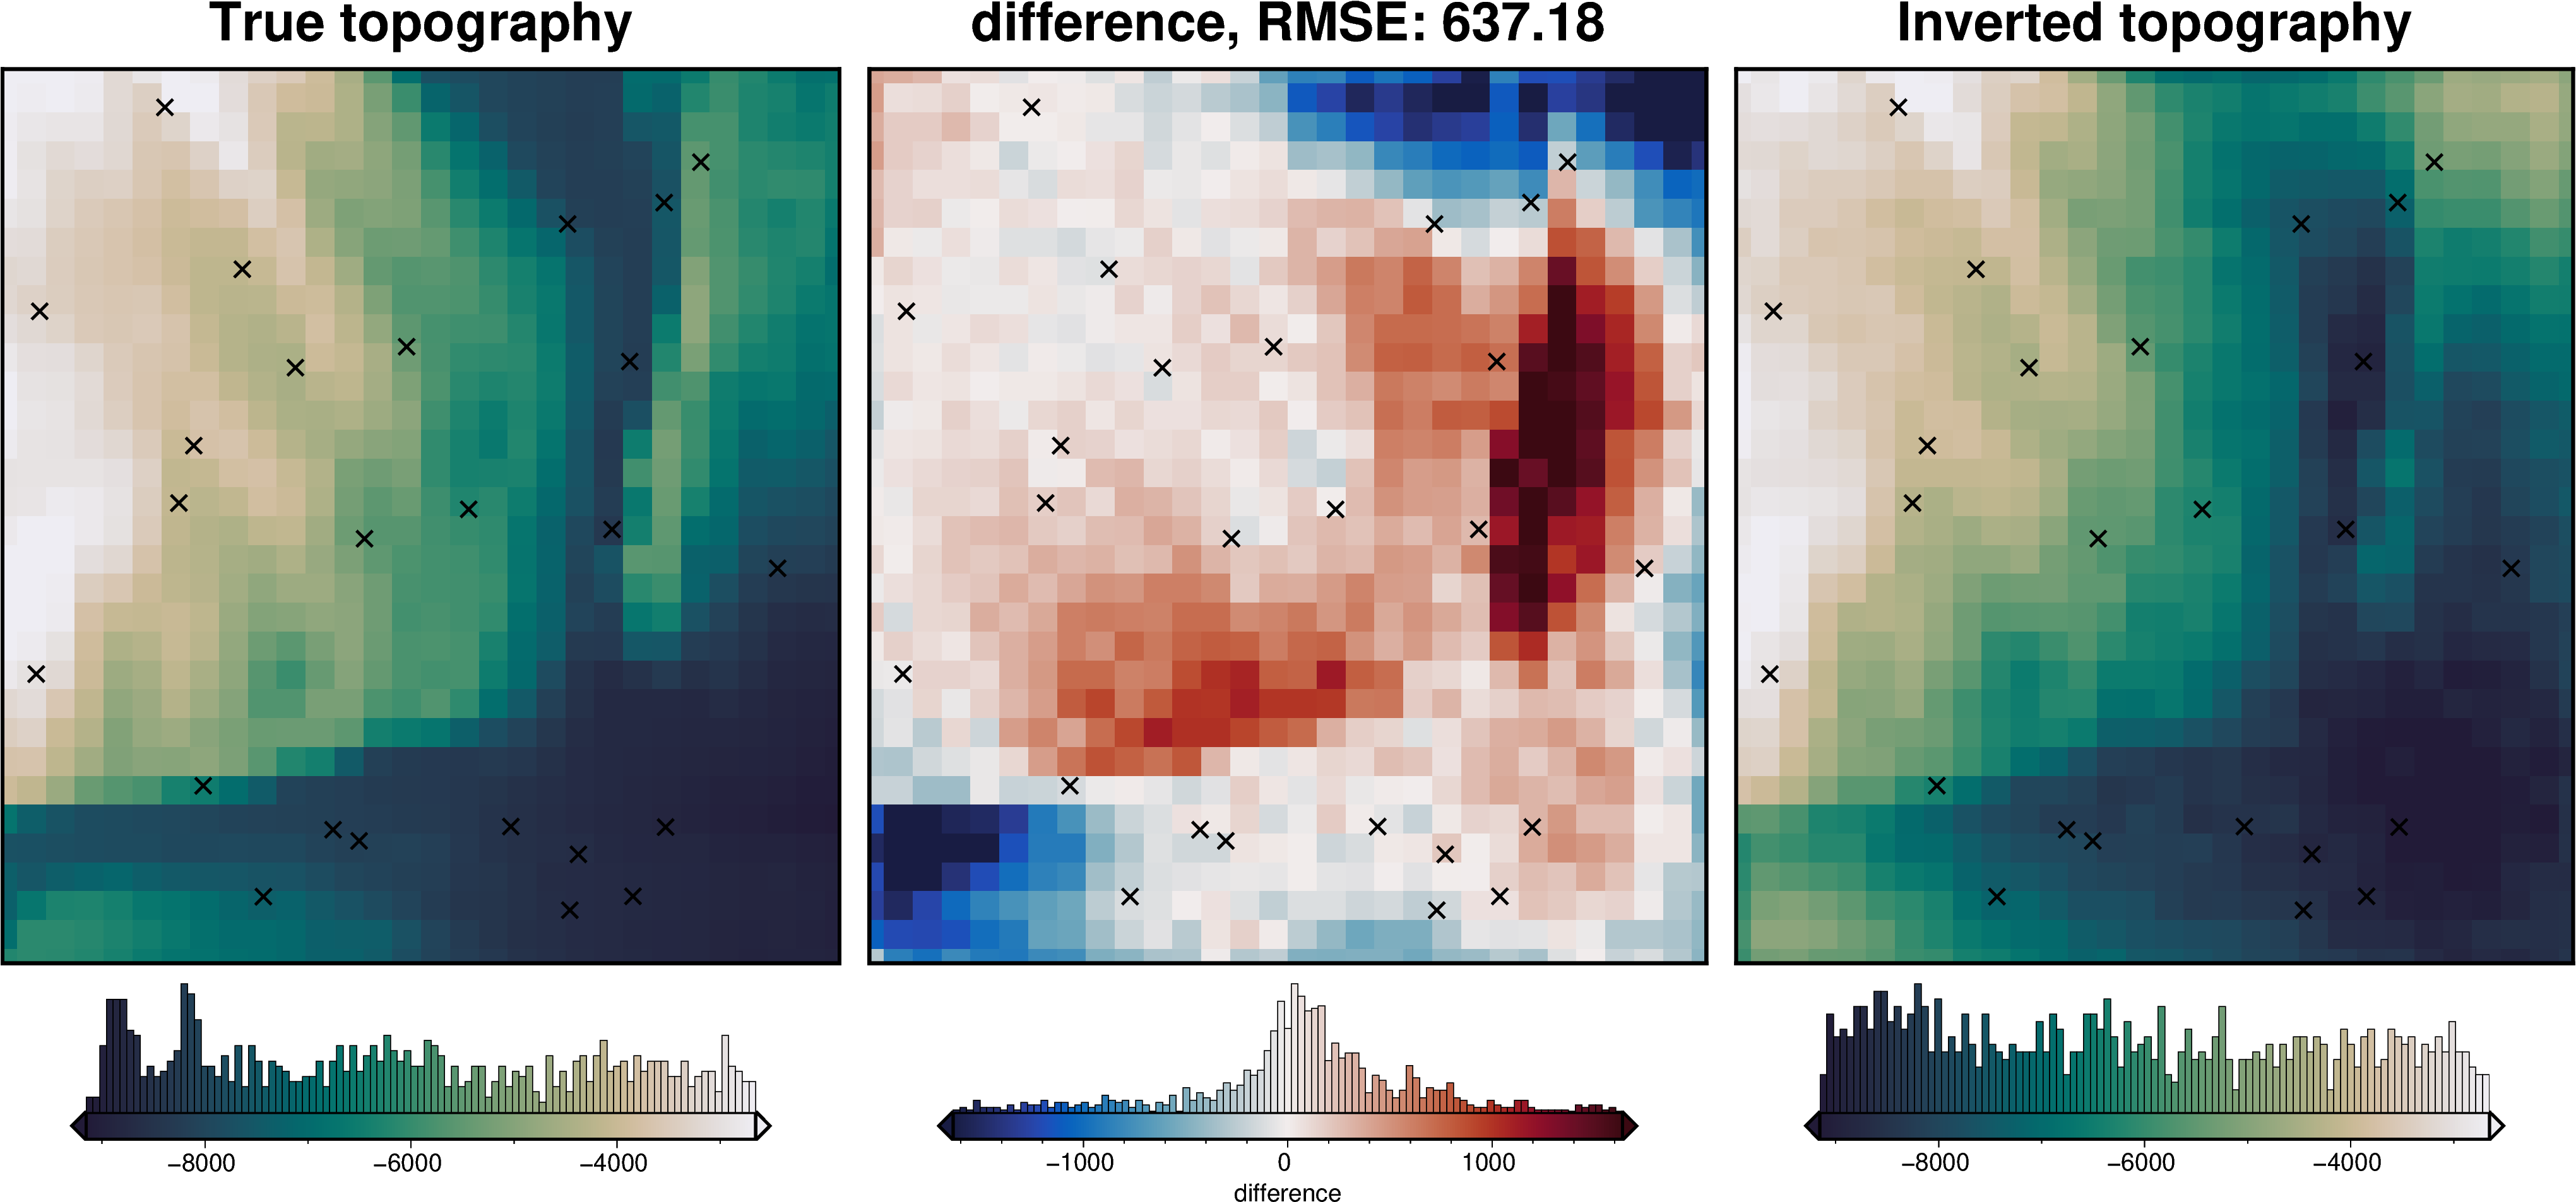

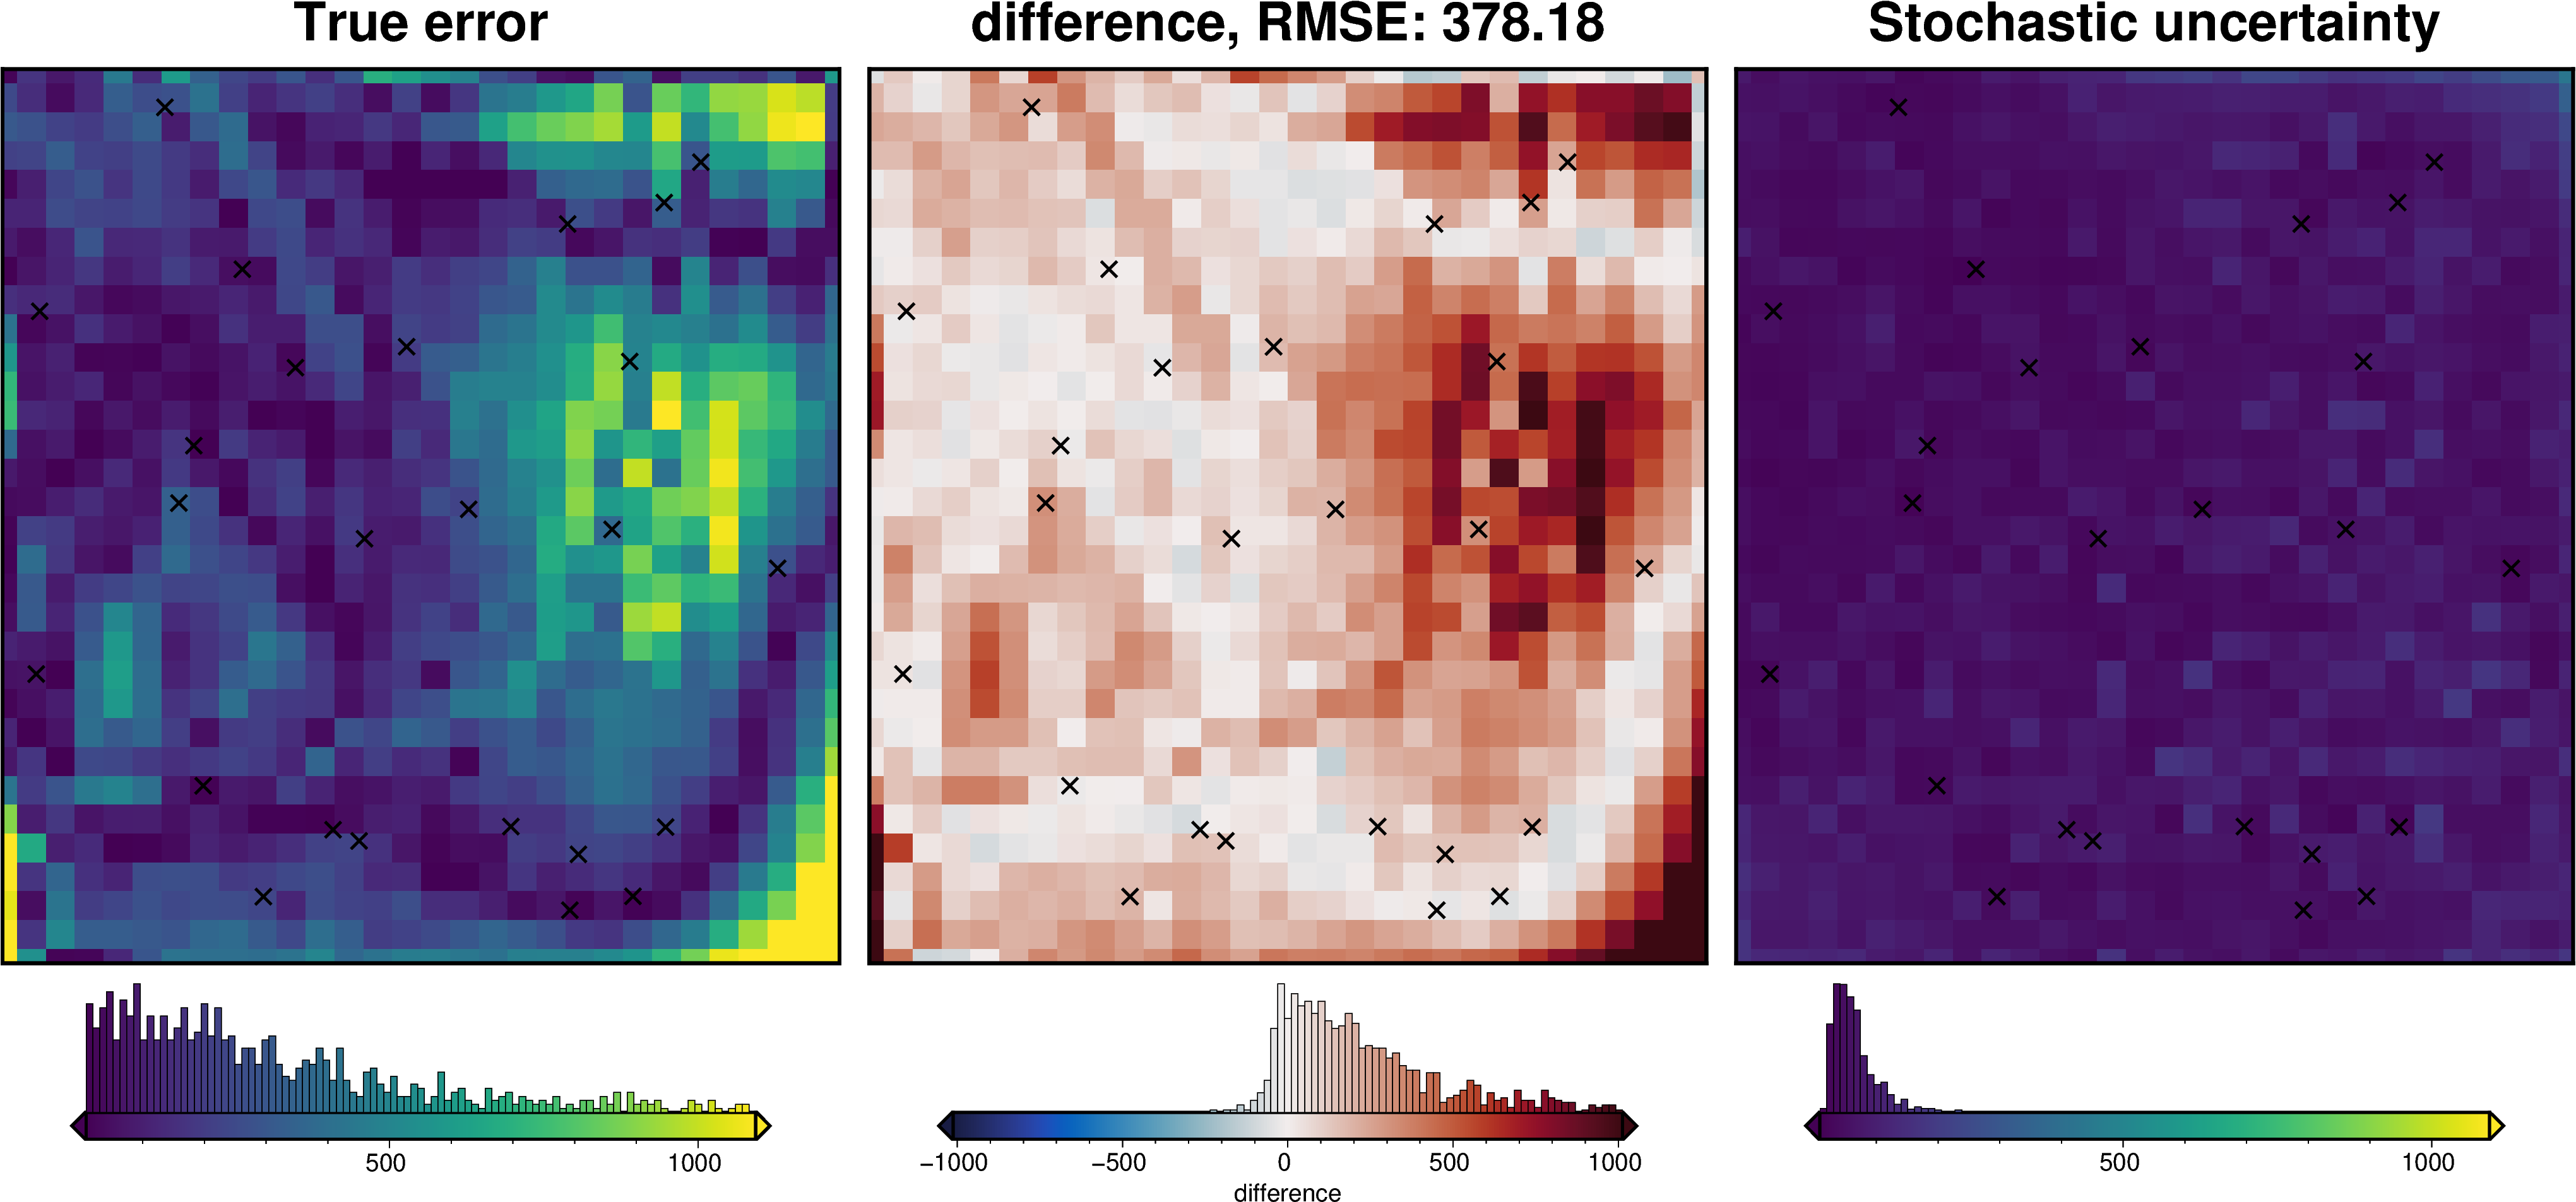

In [67]:
fname = "tmp/bishop_uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    calculate_starting_gravity=True,
    # calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_grav_results)

### Constraints component

INFO:invert4geom:No pickle files starting with 'tmp/bishop_uncertainty_constraints' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/bishop_uncertainty_constraints'



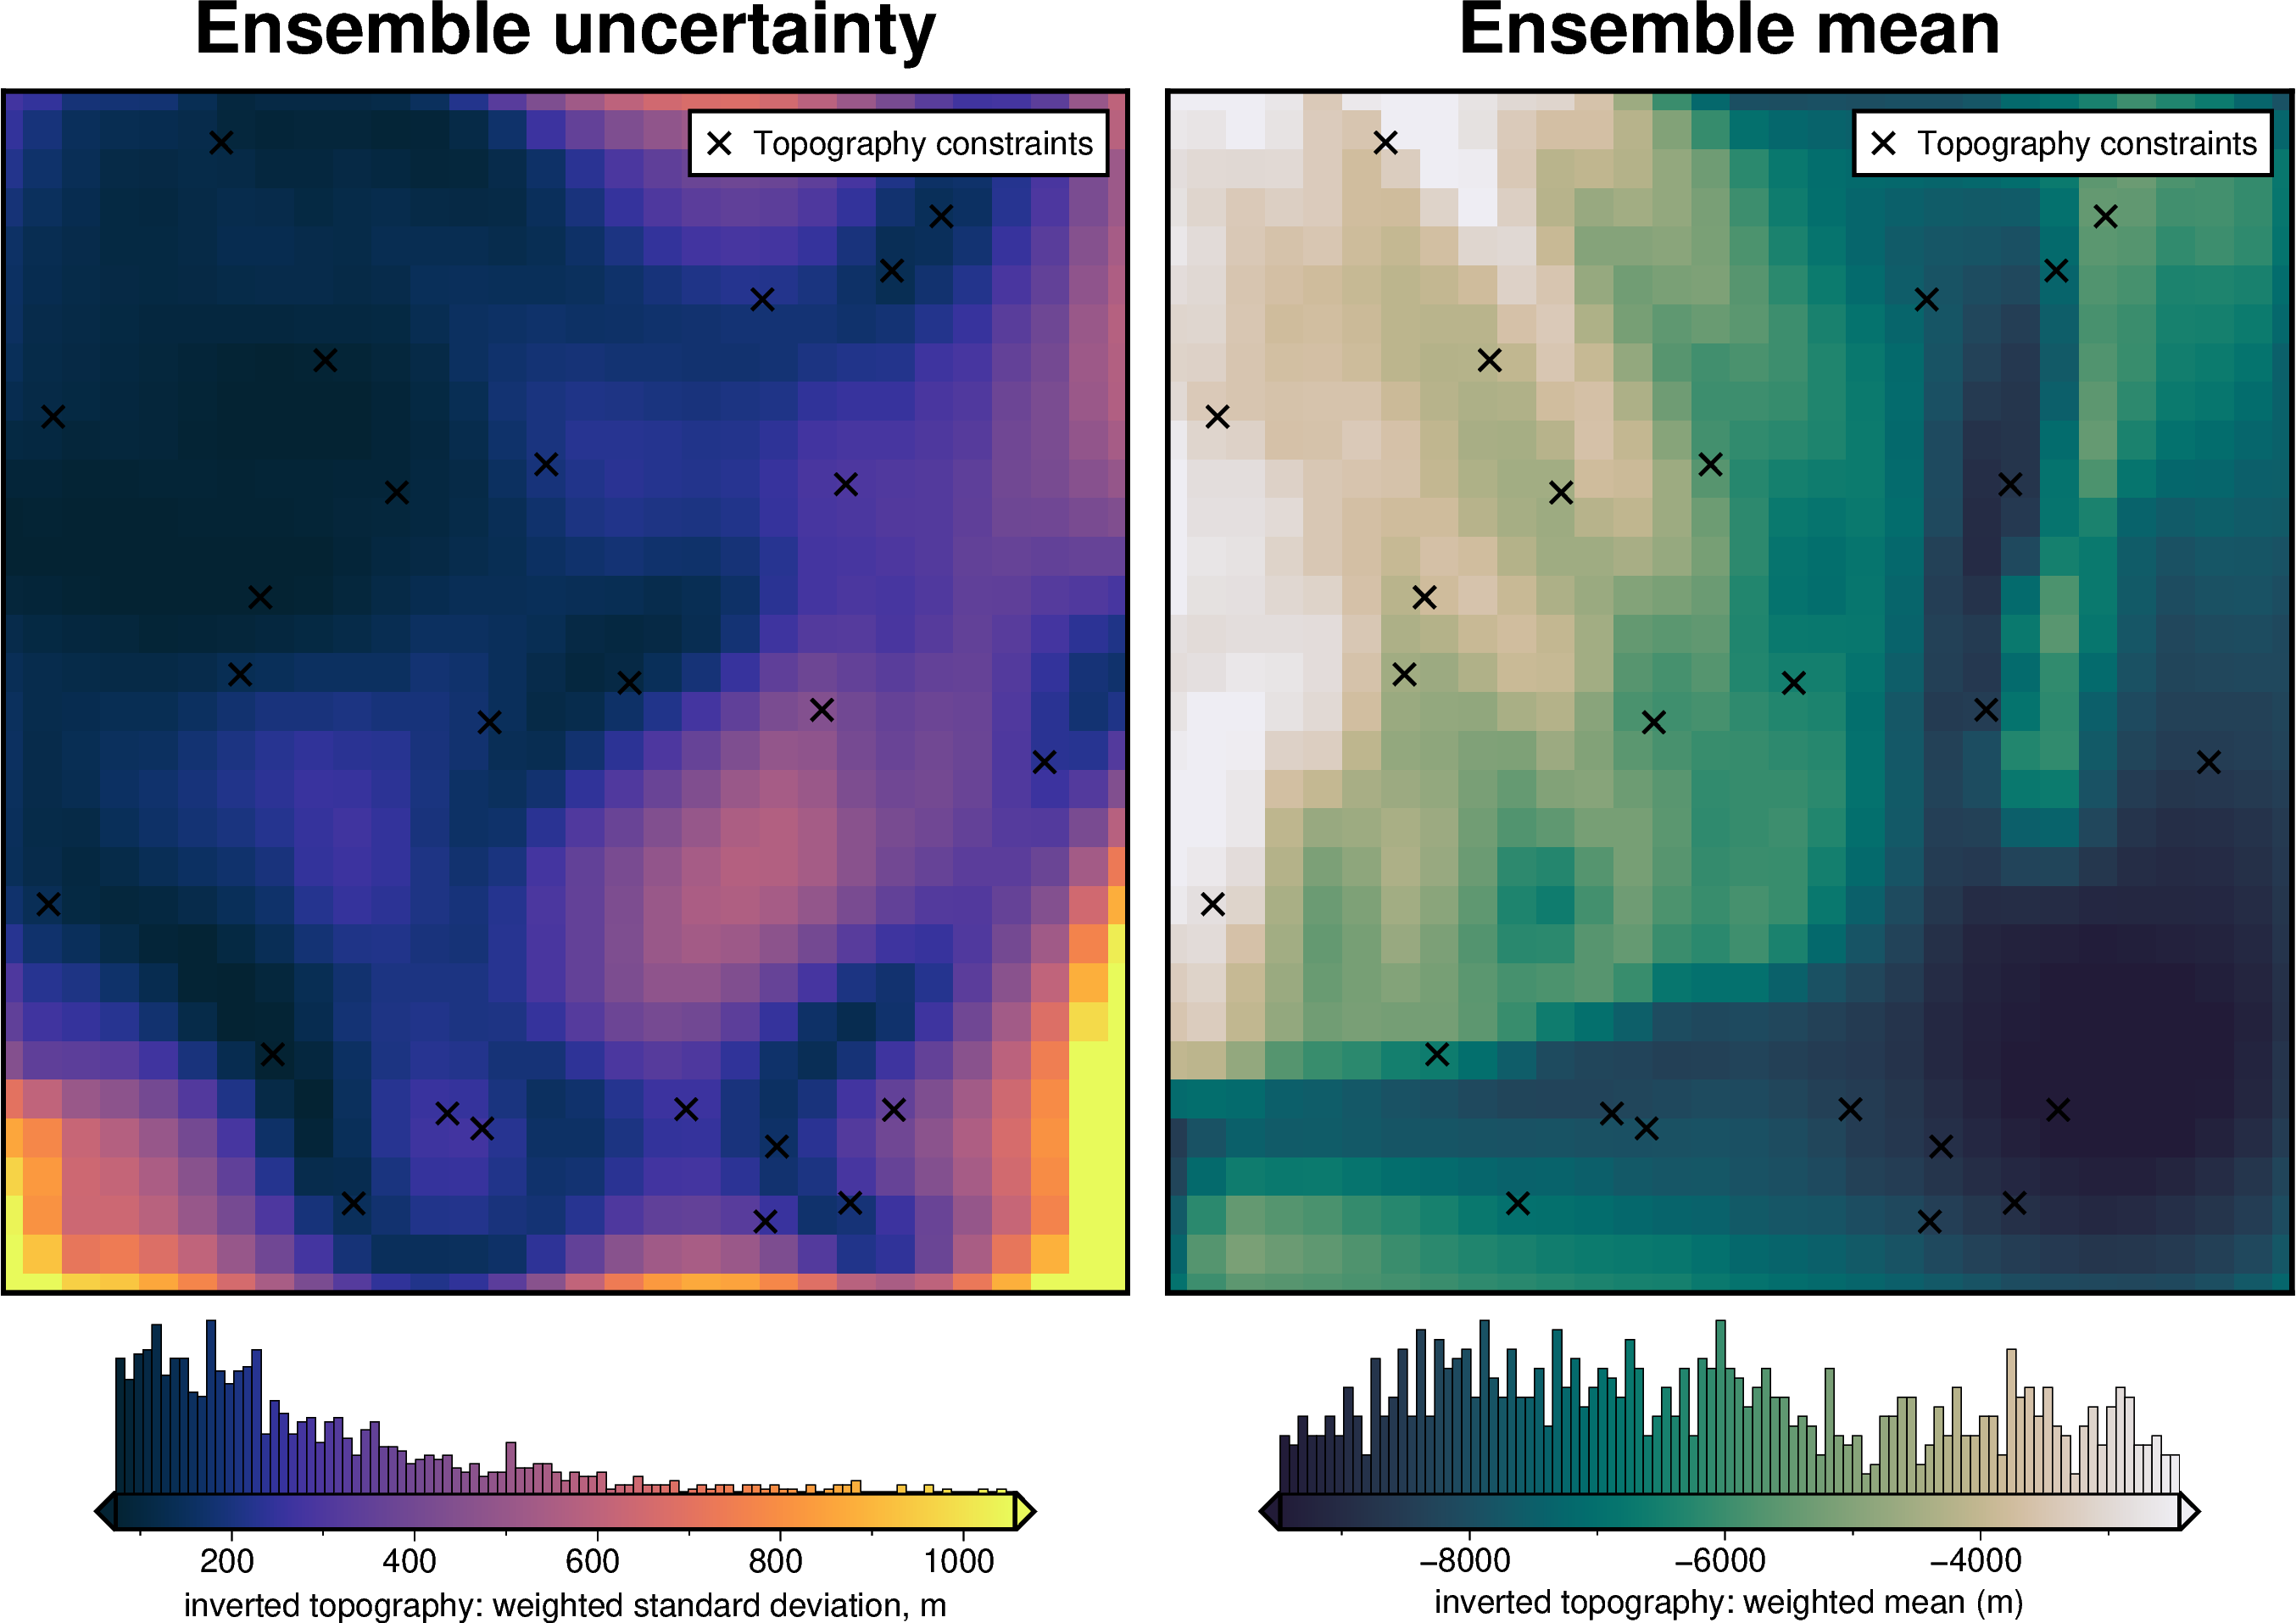

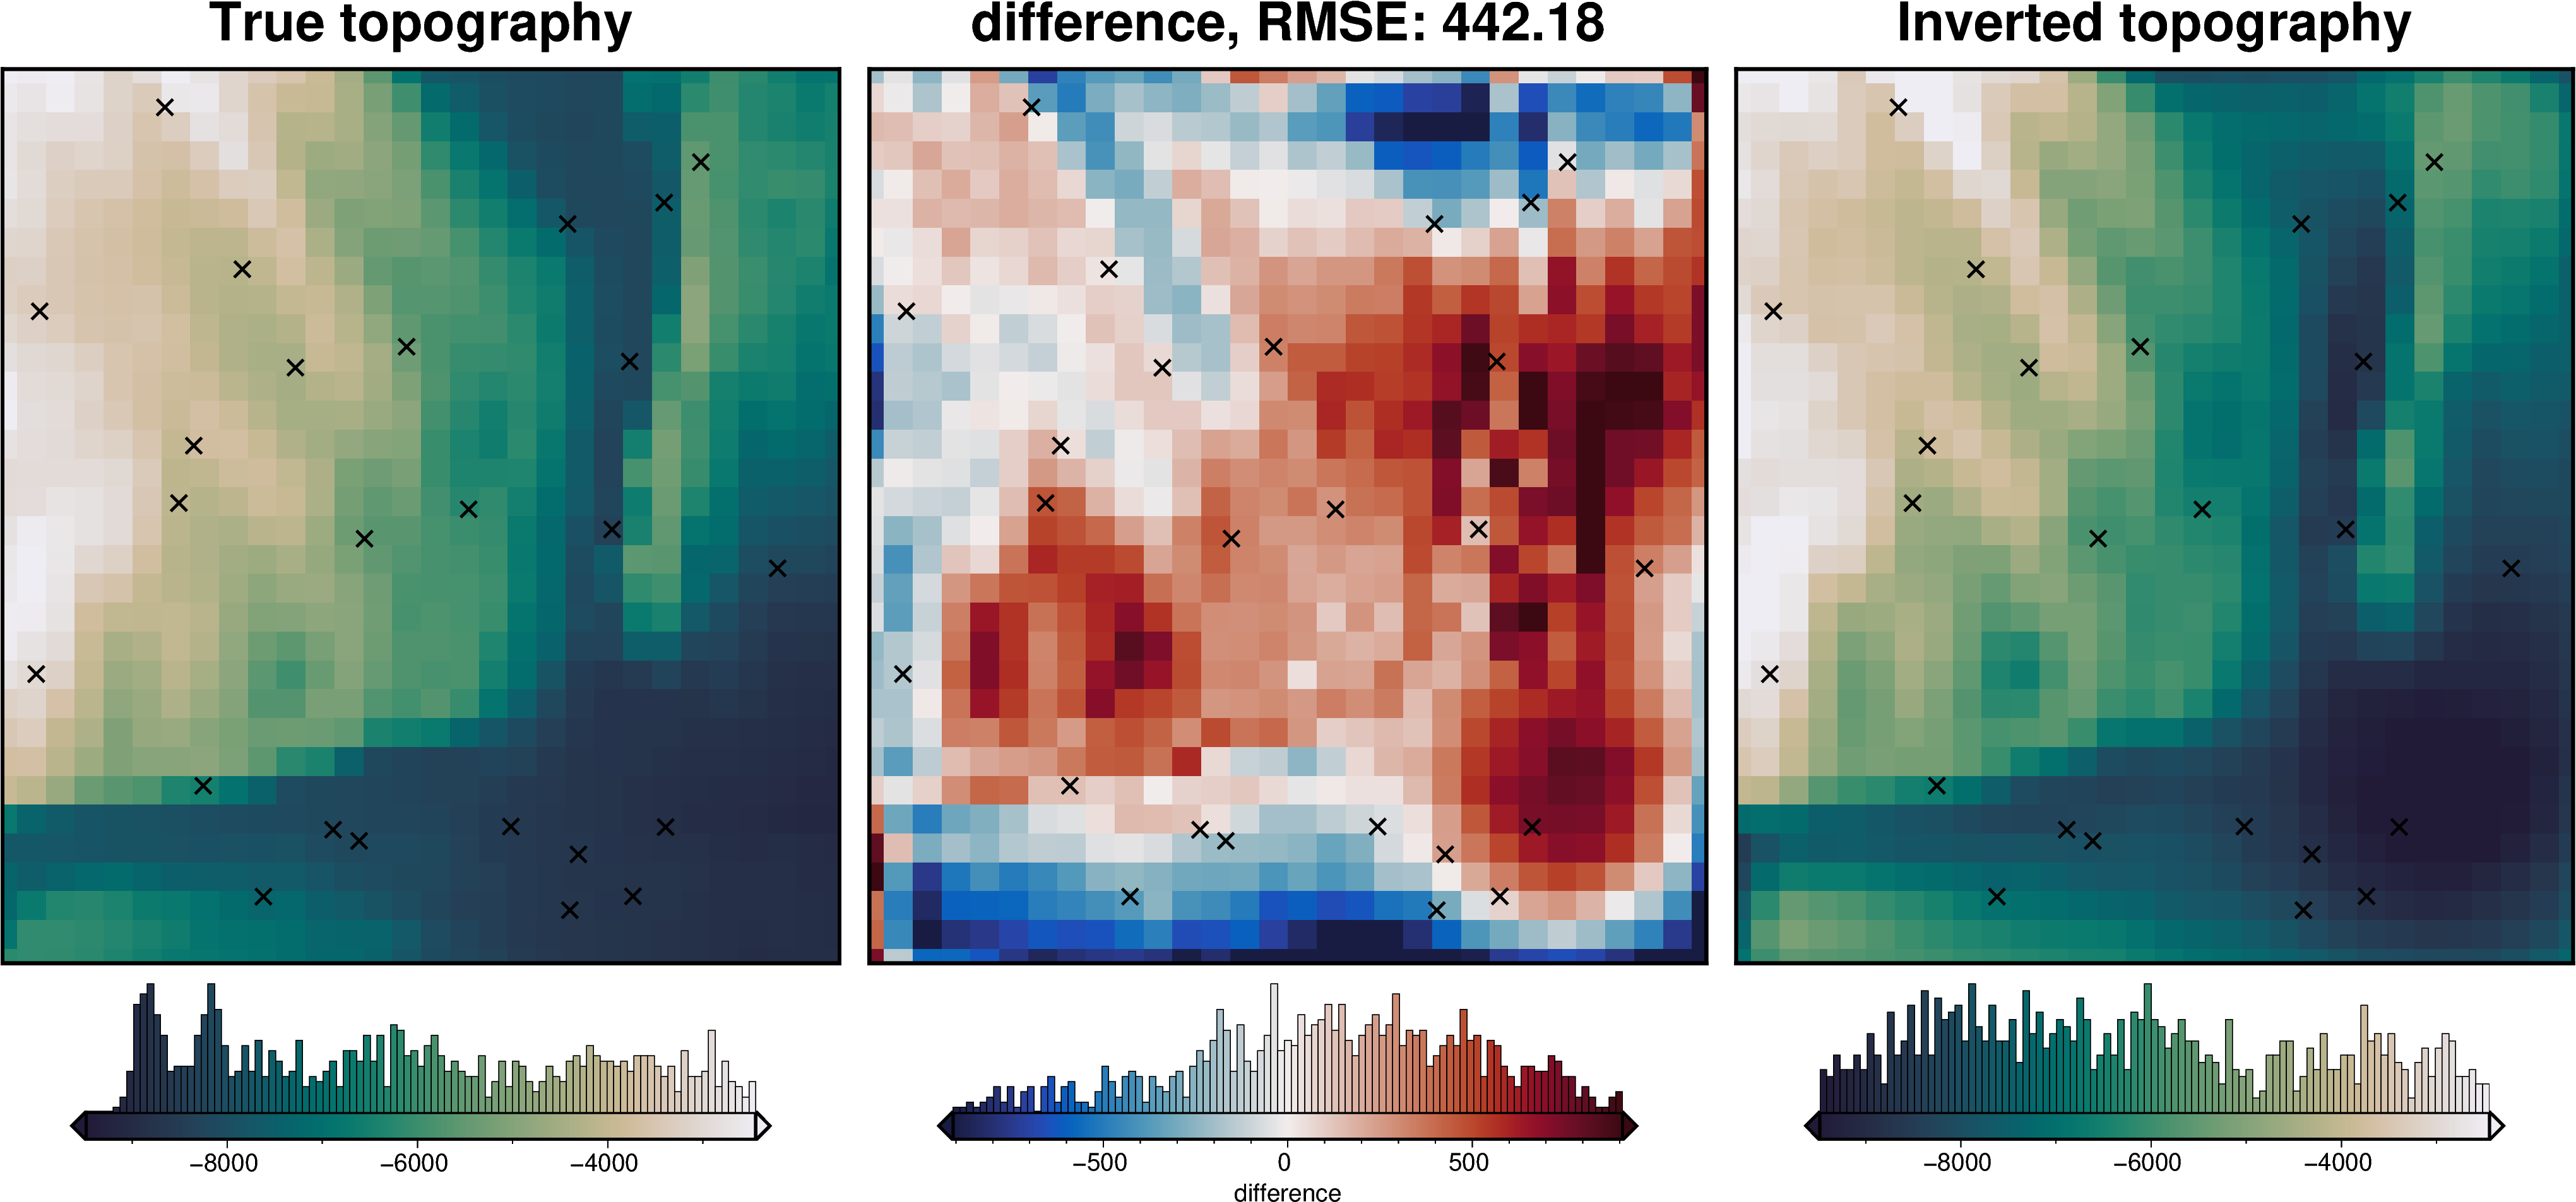

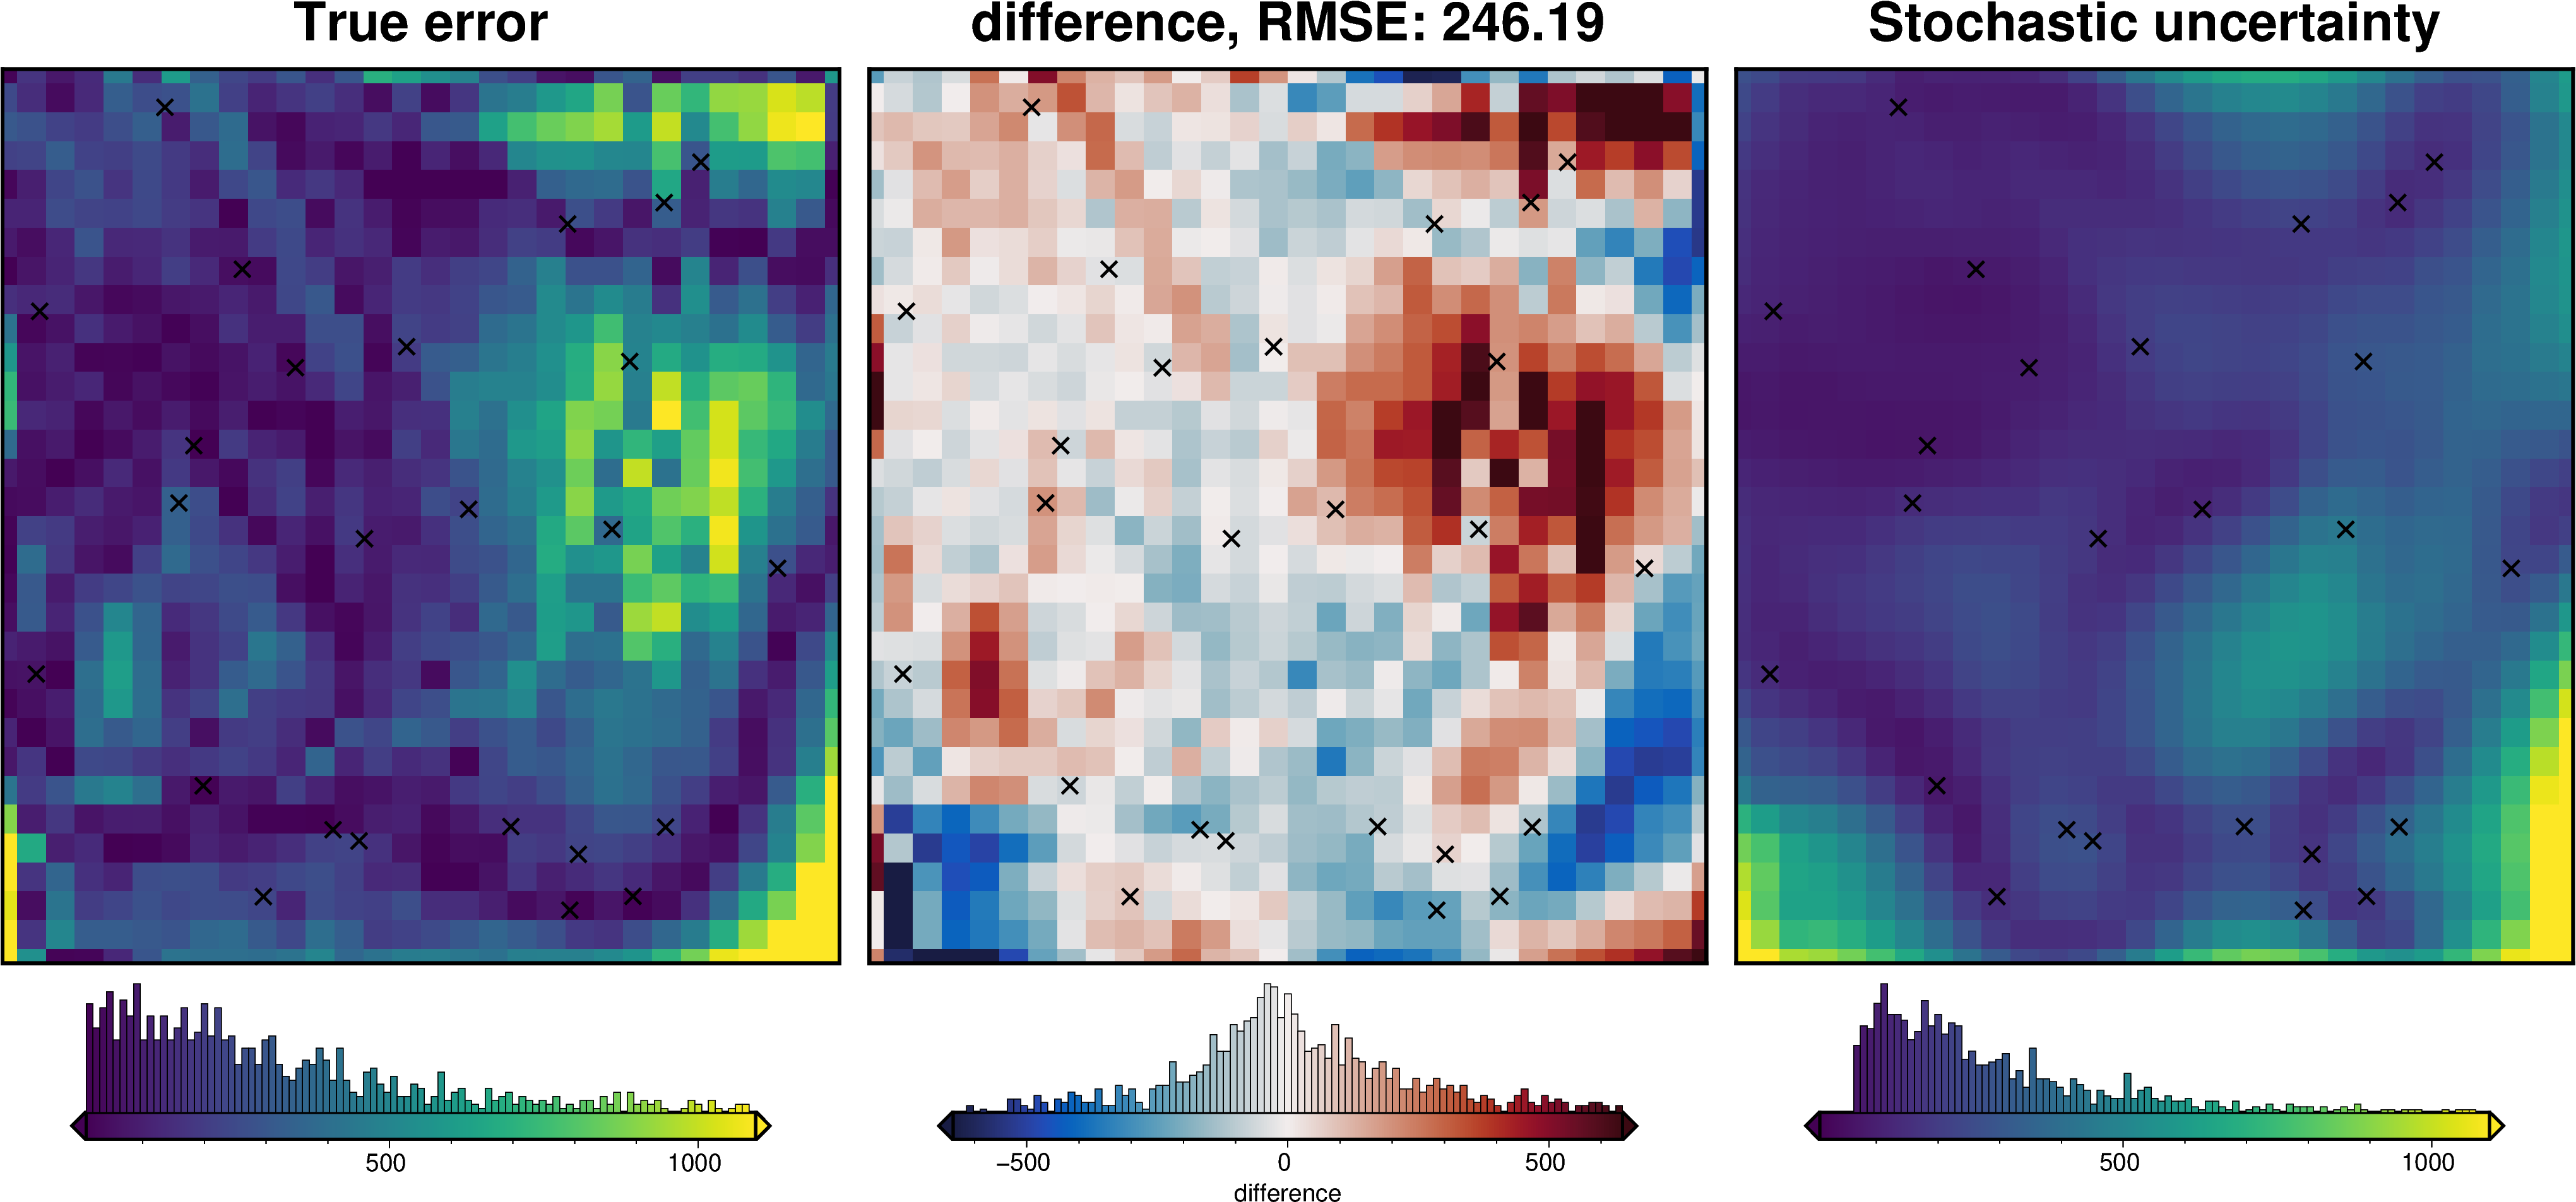

In [68]:
fname = "tmp/bishop_uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_constraints_results)

### Starting topography component

INFO:invert4geom:Sampled 'dampings' parameter values; mean: 6.070821665577805e-16, min: 1.5510464167373608e-22, max: 1.072706057099181e-14
INFO:invert4geom:No pickle files starting with 'tmp/bishop_uncertainty_starting_topo' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/bishop_uncertainty_starting_topo'



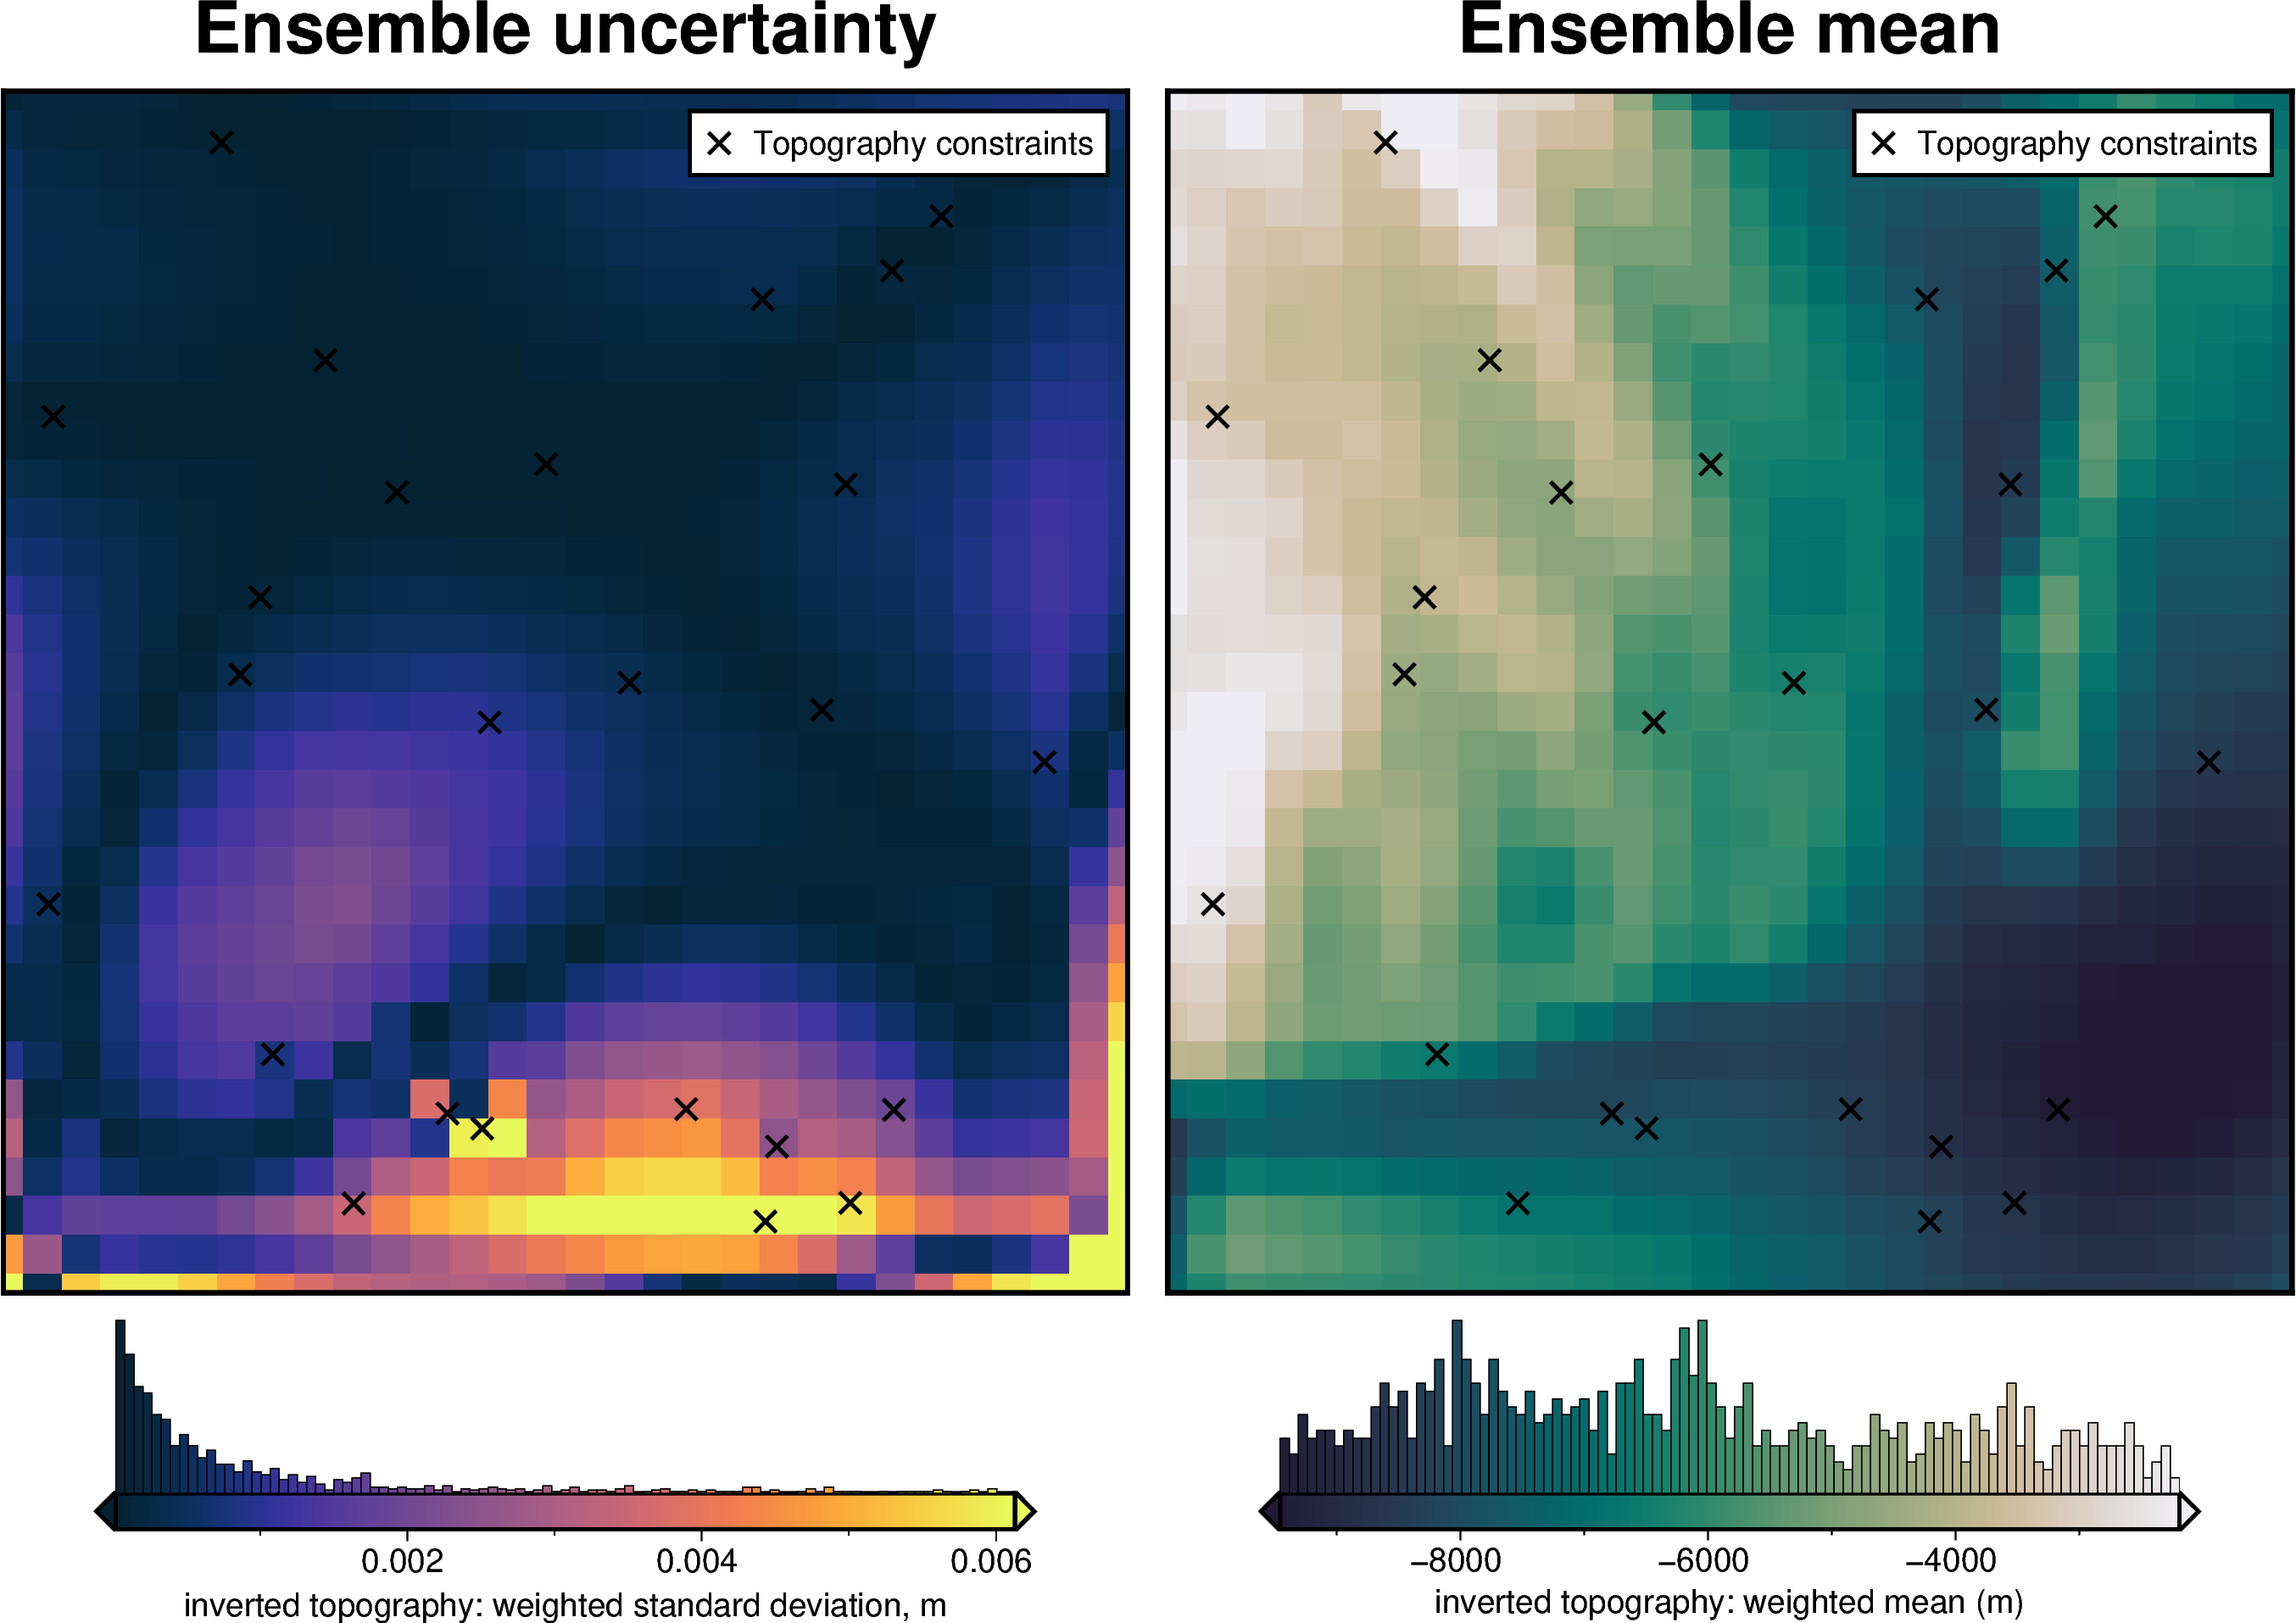

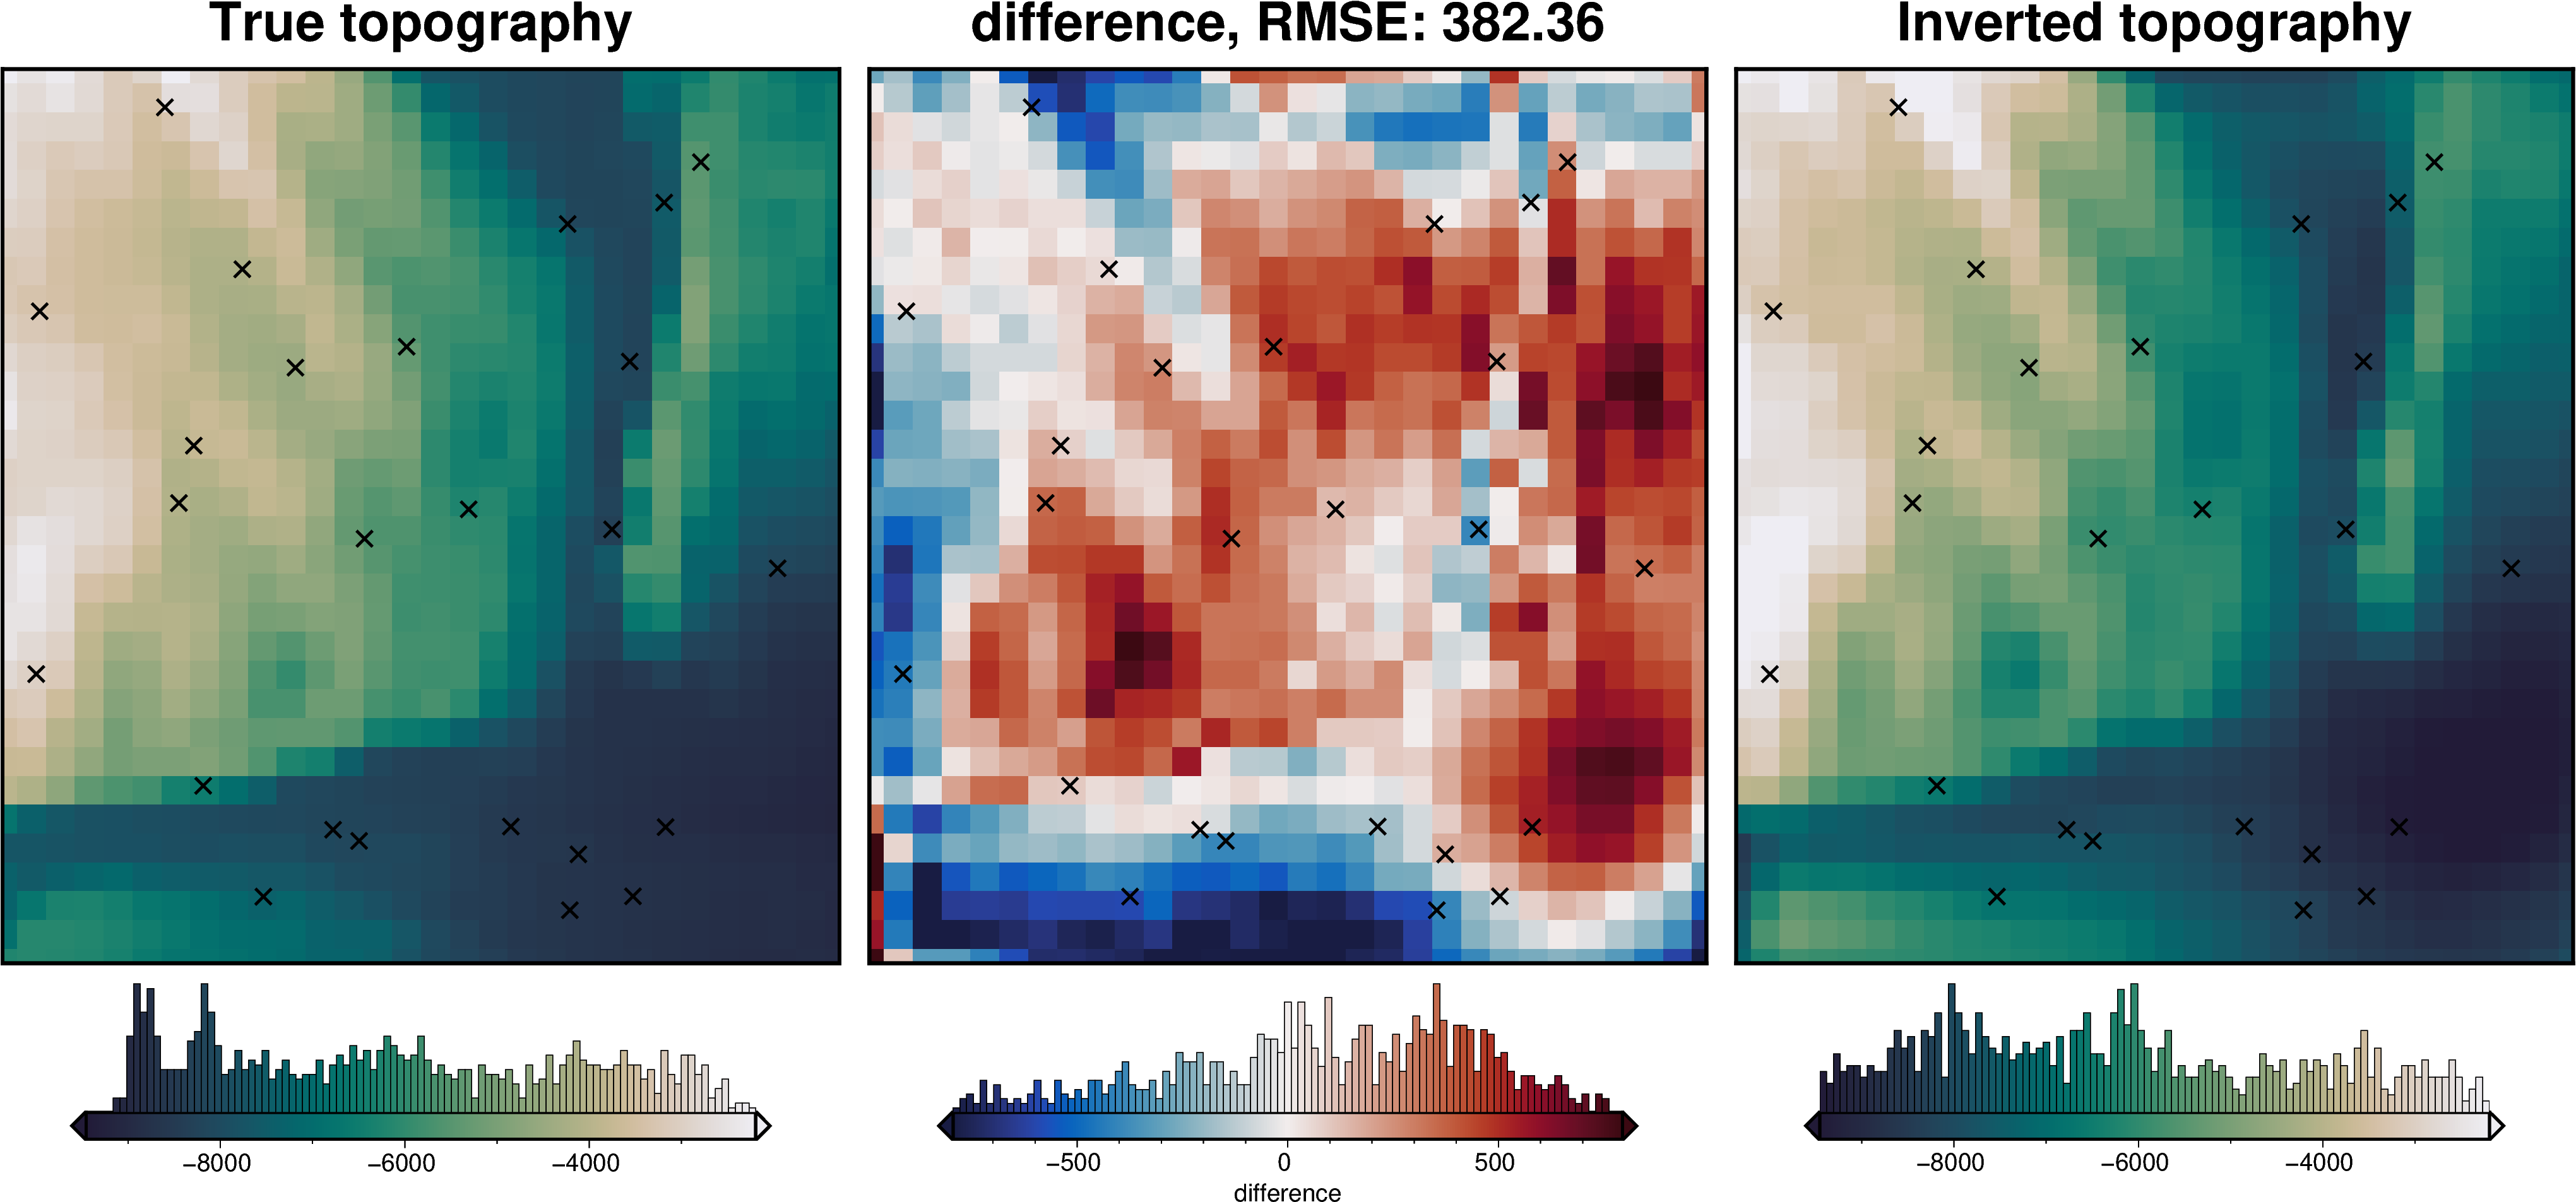

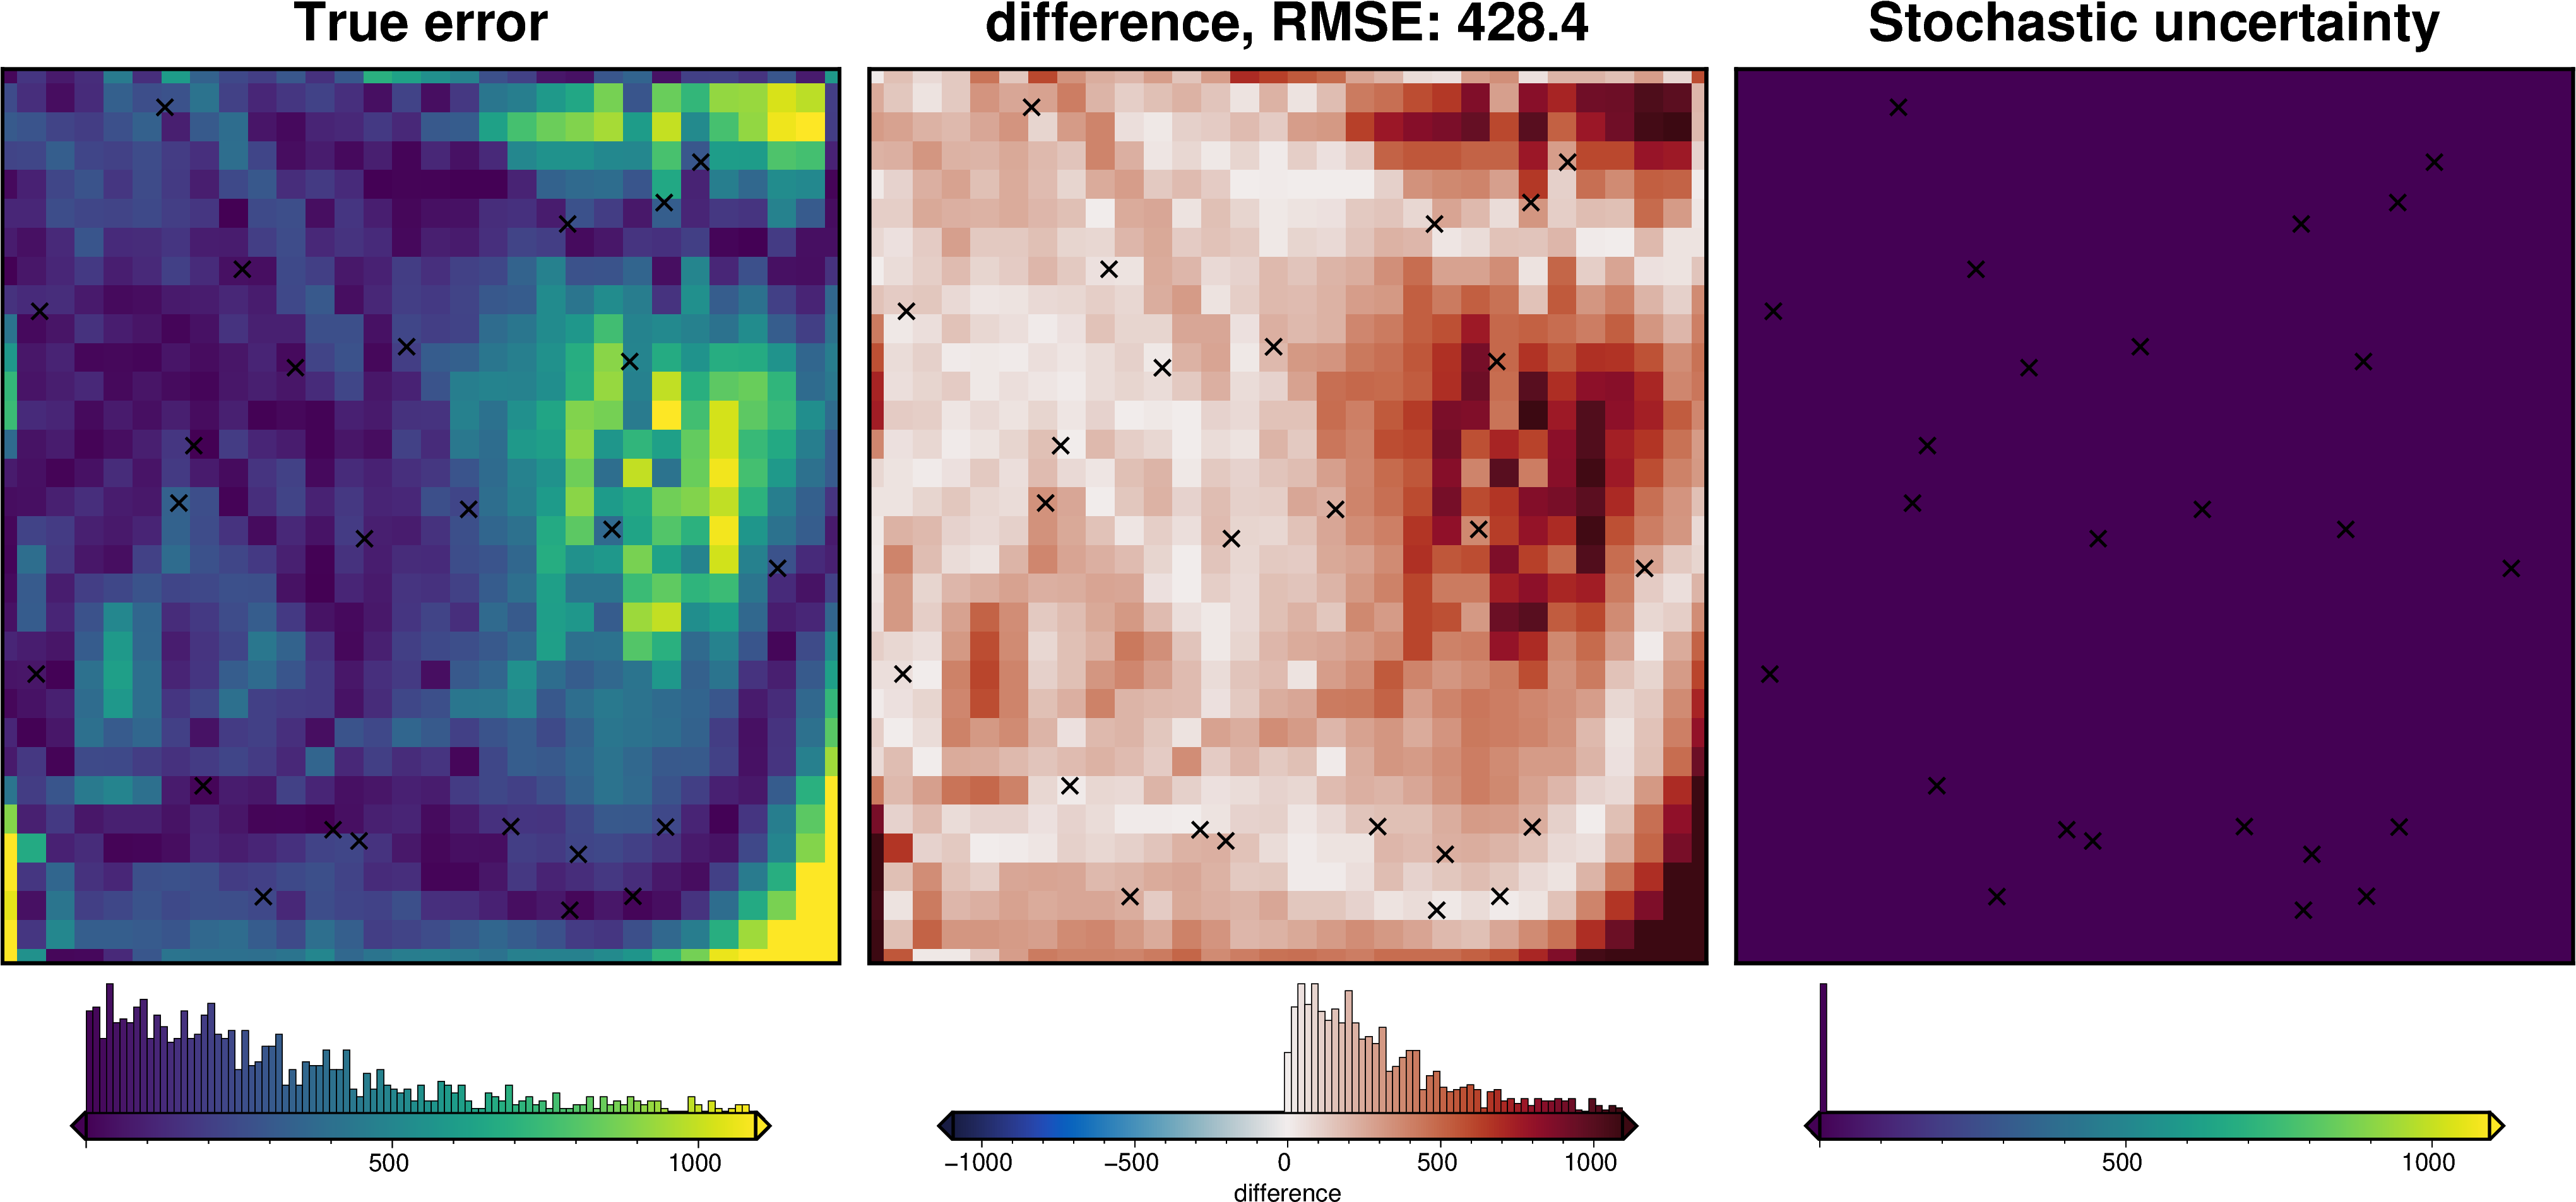

In [69]:
fname = "tmp/bishop_uncertainty_starting_topo"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_starting_topo_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    # calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_starting_topo_results)

### Regional gravity component

INFO:invert4geom:Sampled 'depth' parameter values; mean: 158311.95494911776, min: 74758.42317041672, max: 241865.4867278188
INFO:invert4geom:Sampled 'damping' parameter values; mean: 6.781276584285748e-09, min: 9.195590342721111e-12, max: 7.647290436672651e-08
INFO:invert4geom:No pickle files starting with 'tmp/bishop_uncertainty_regional' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/bishop_uncertainty_regional'



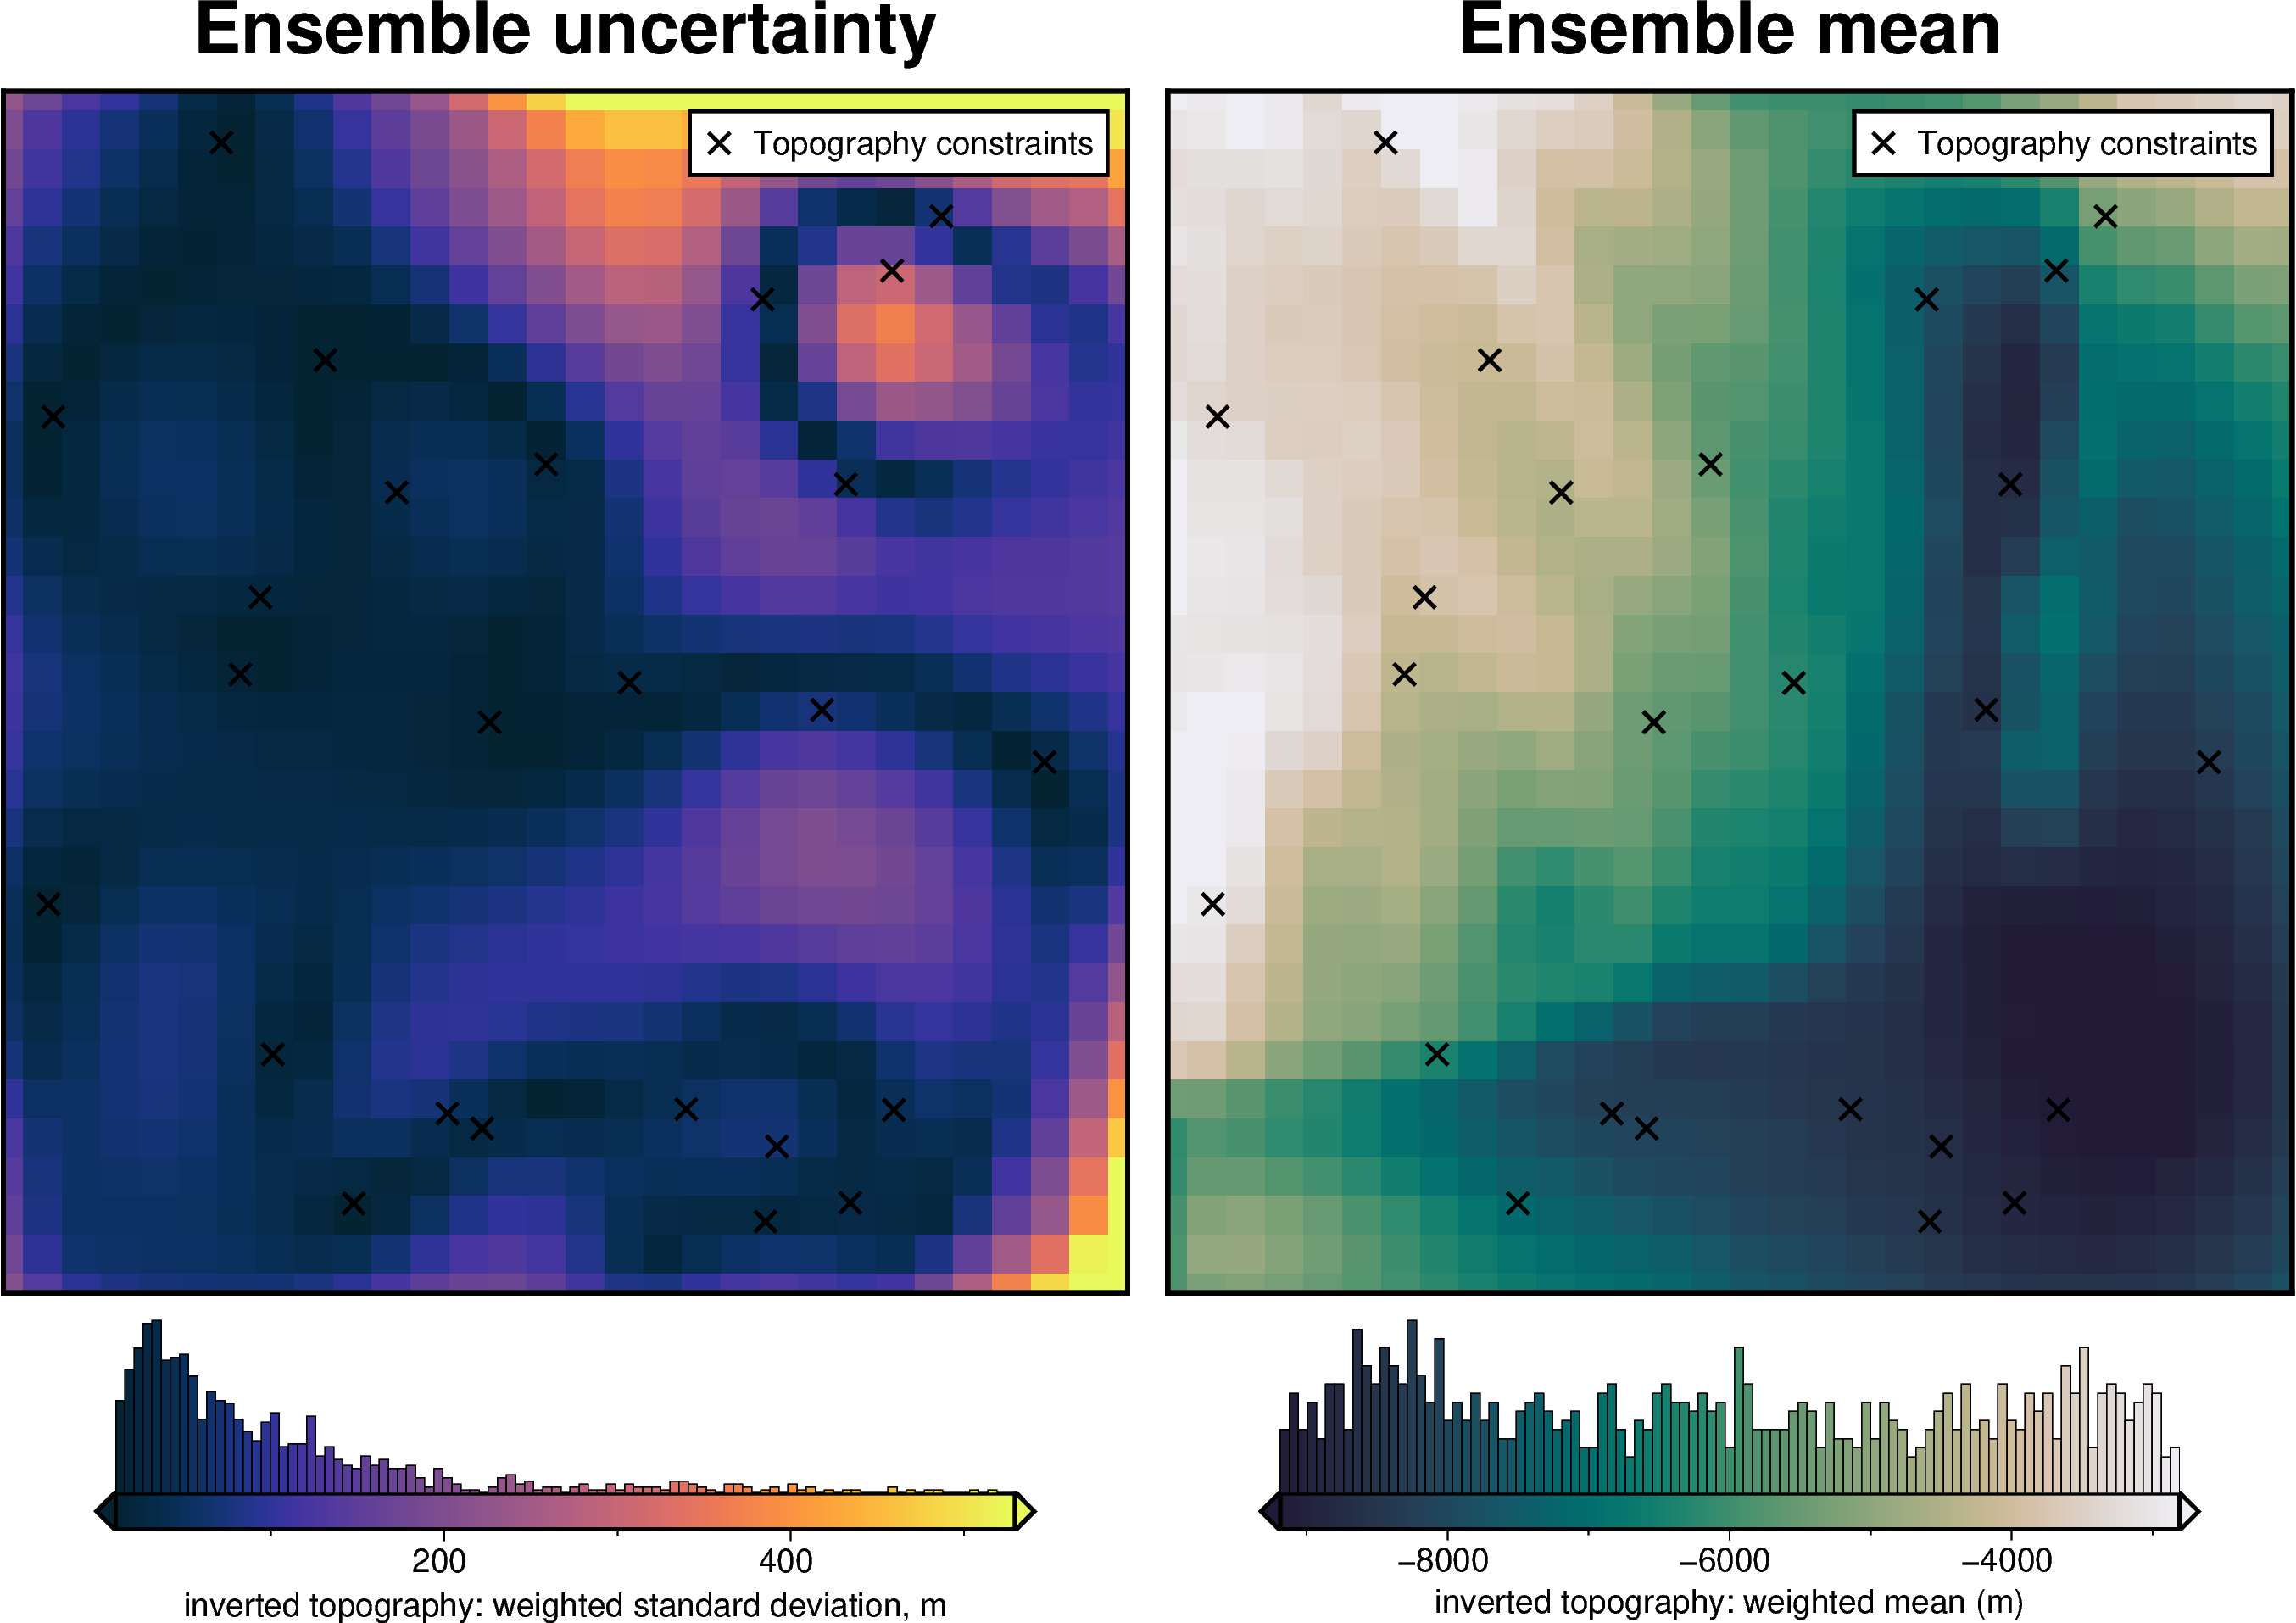

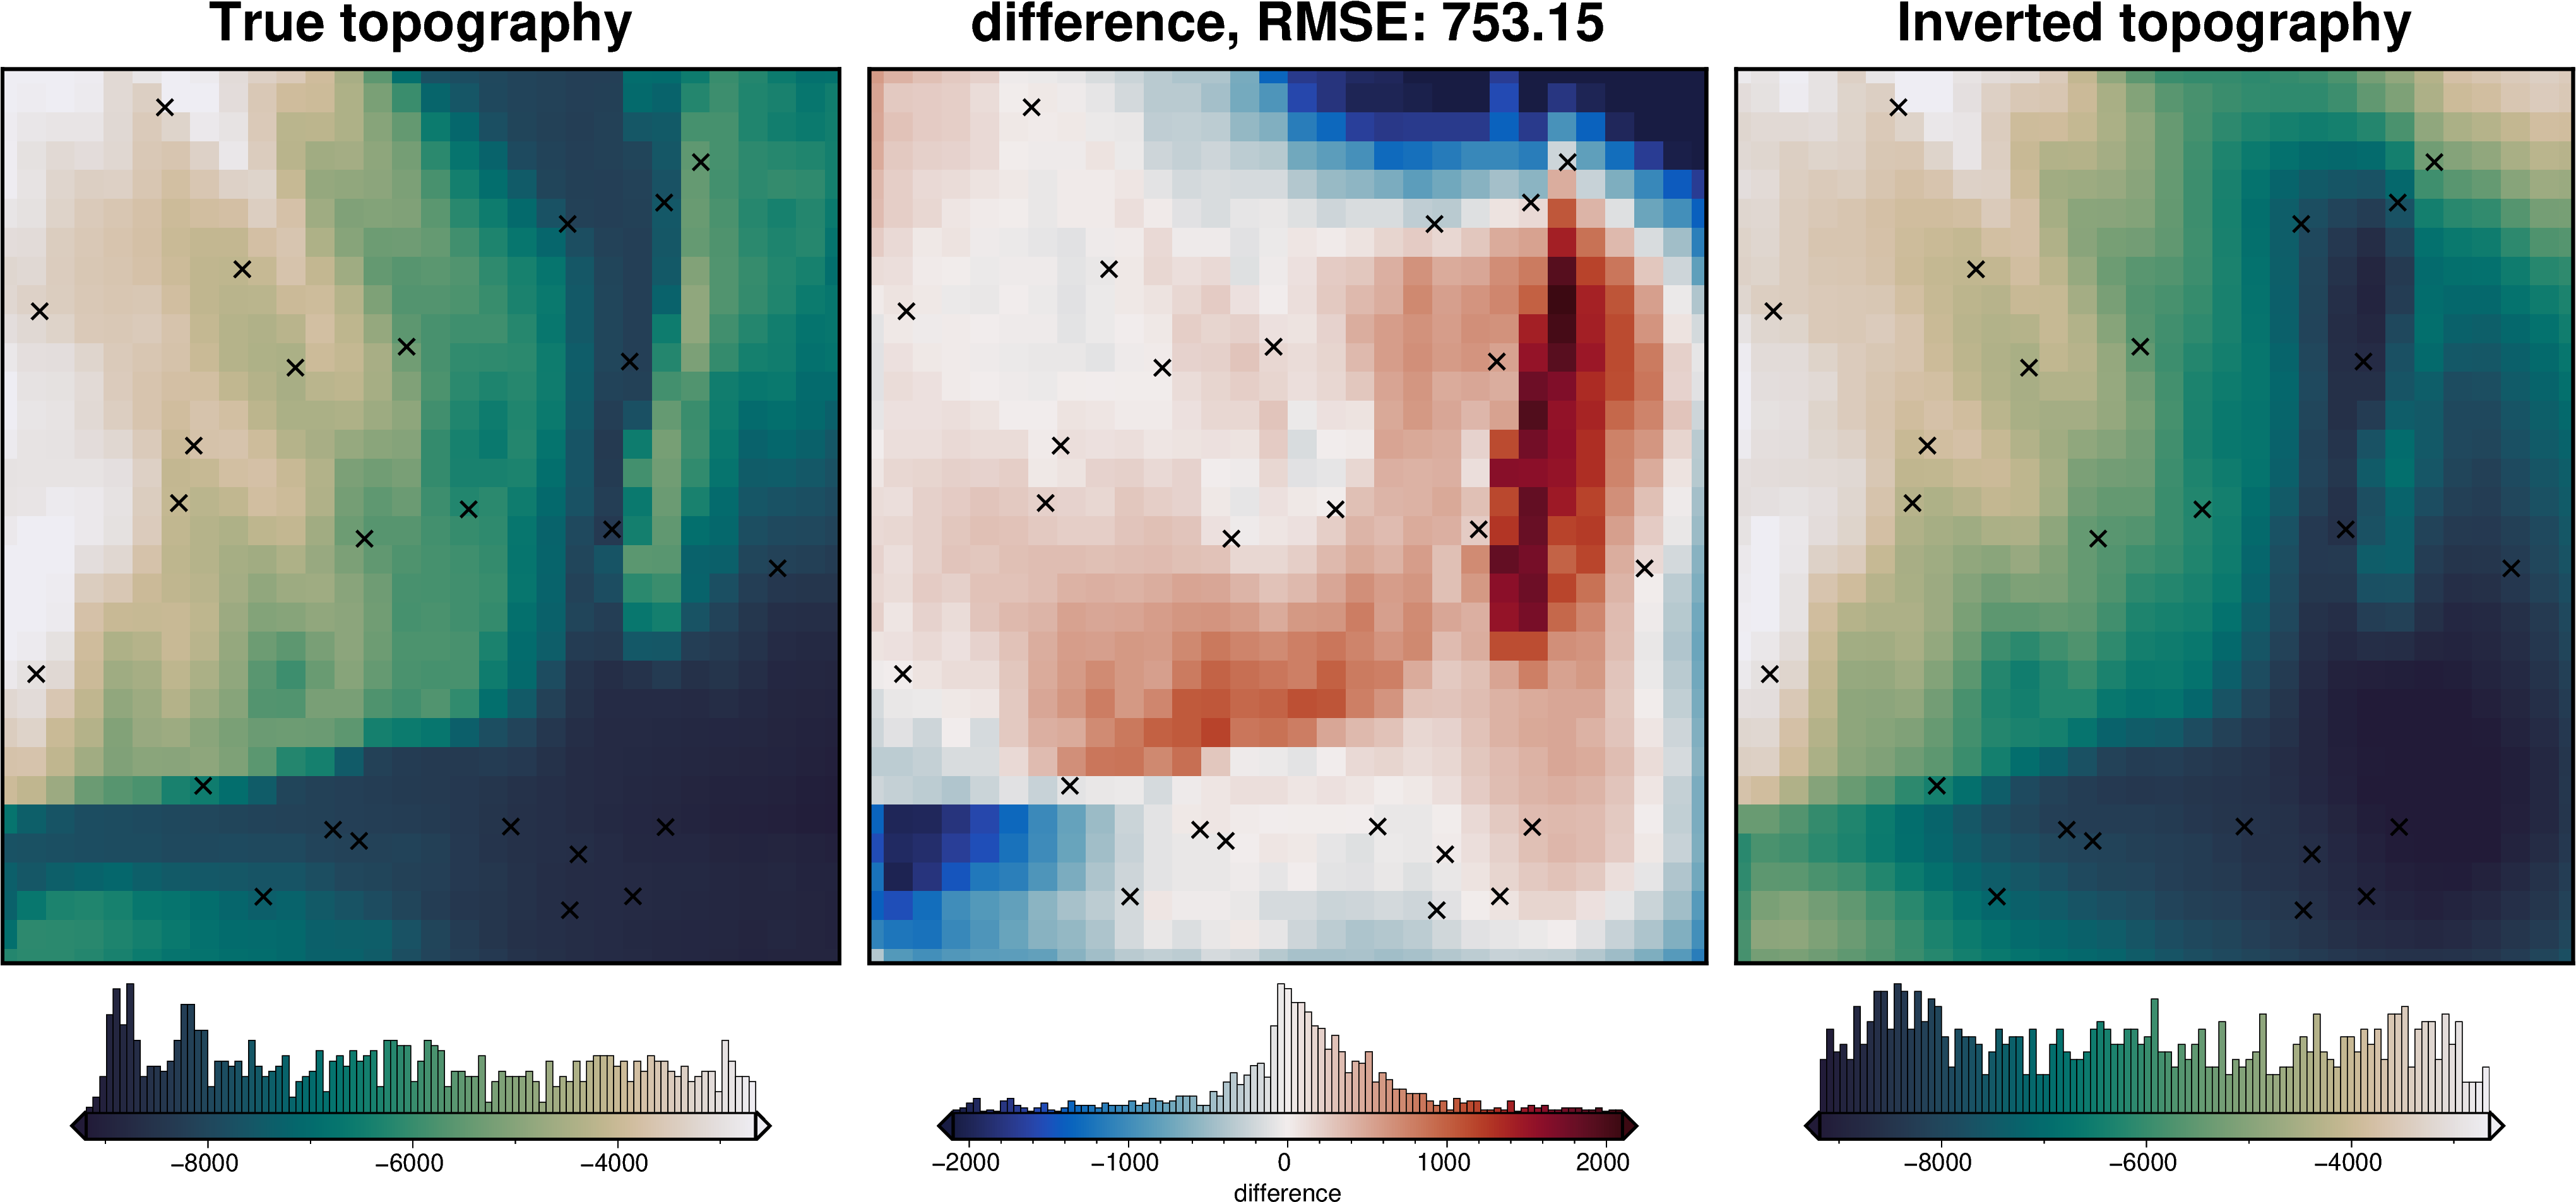

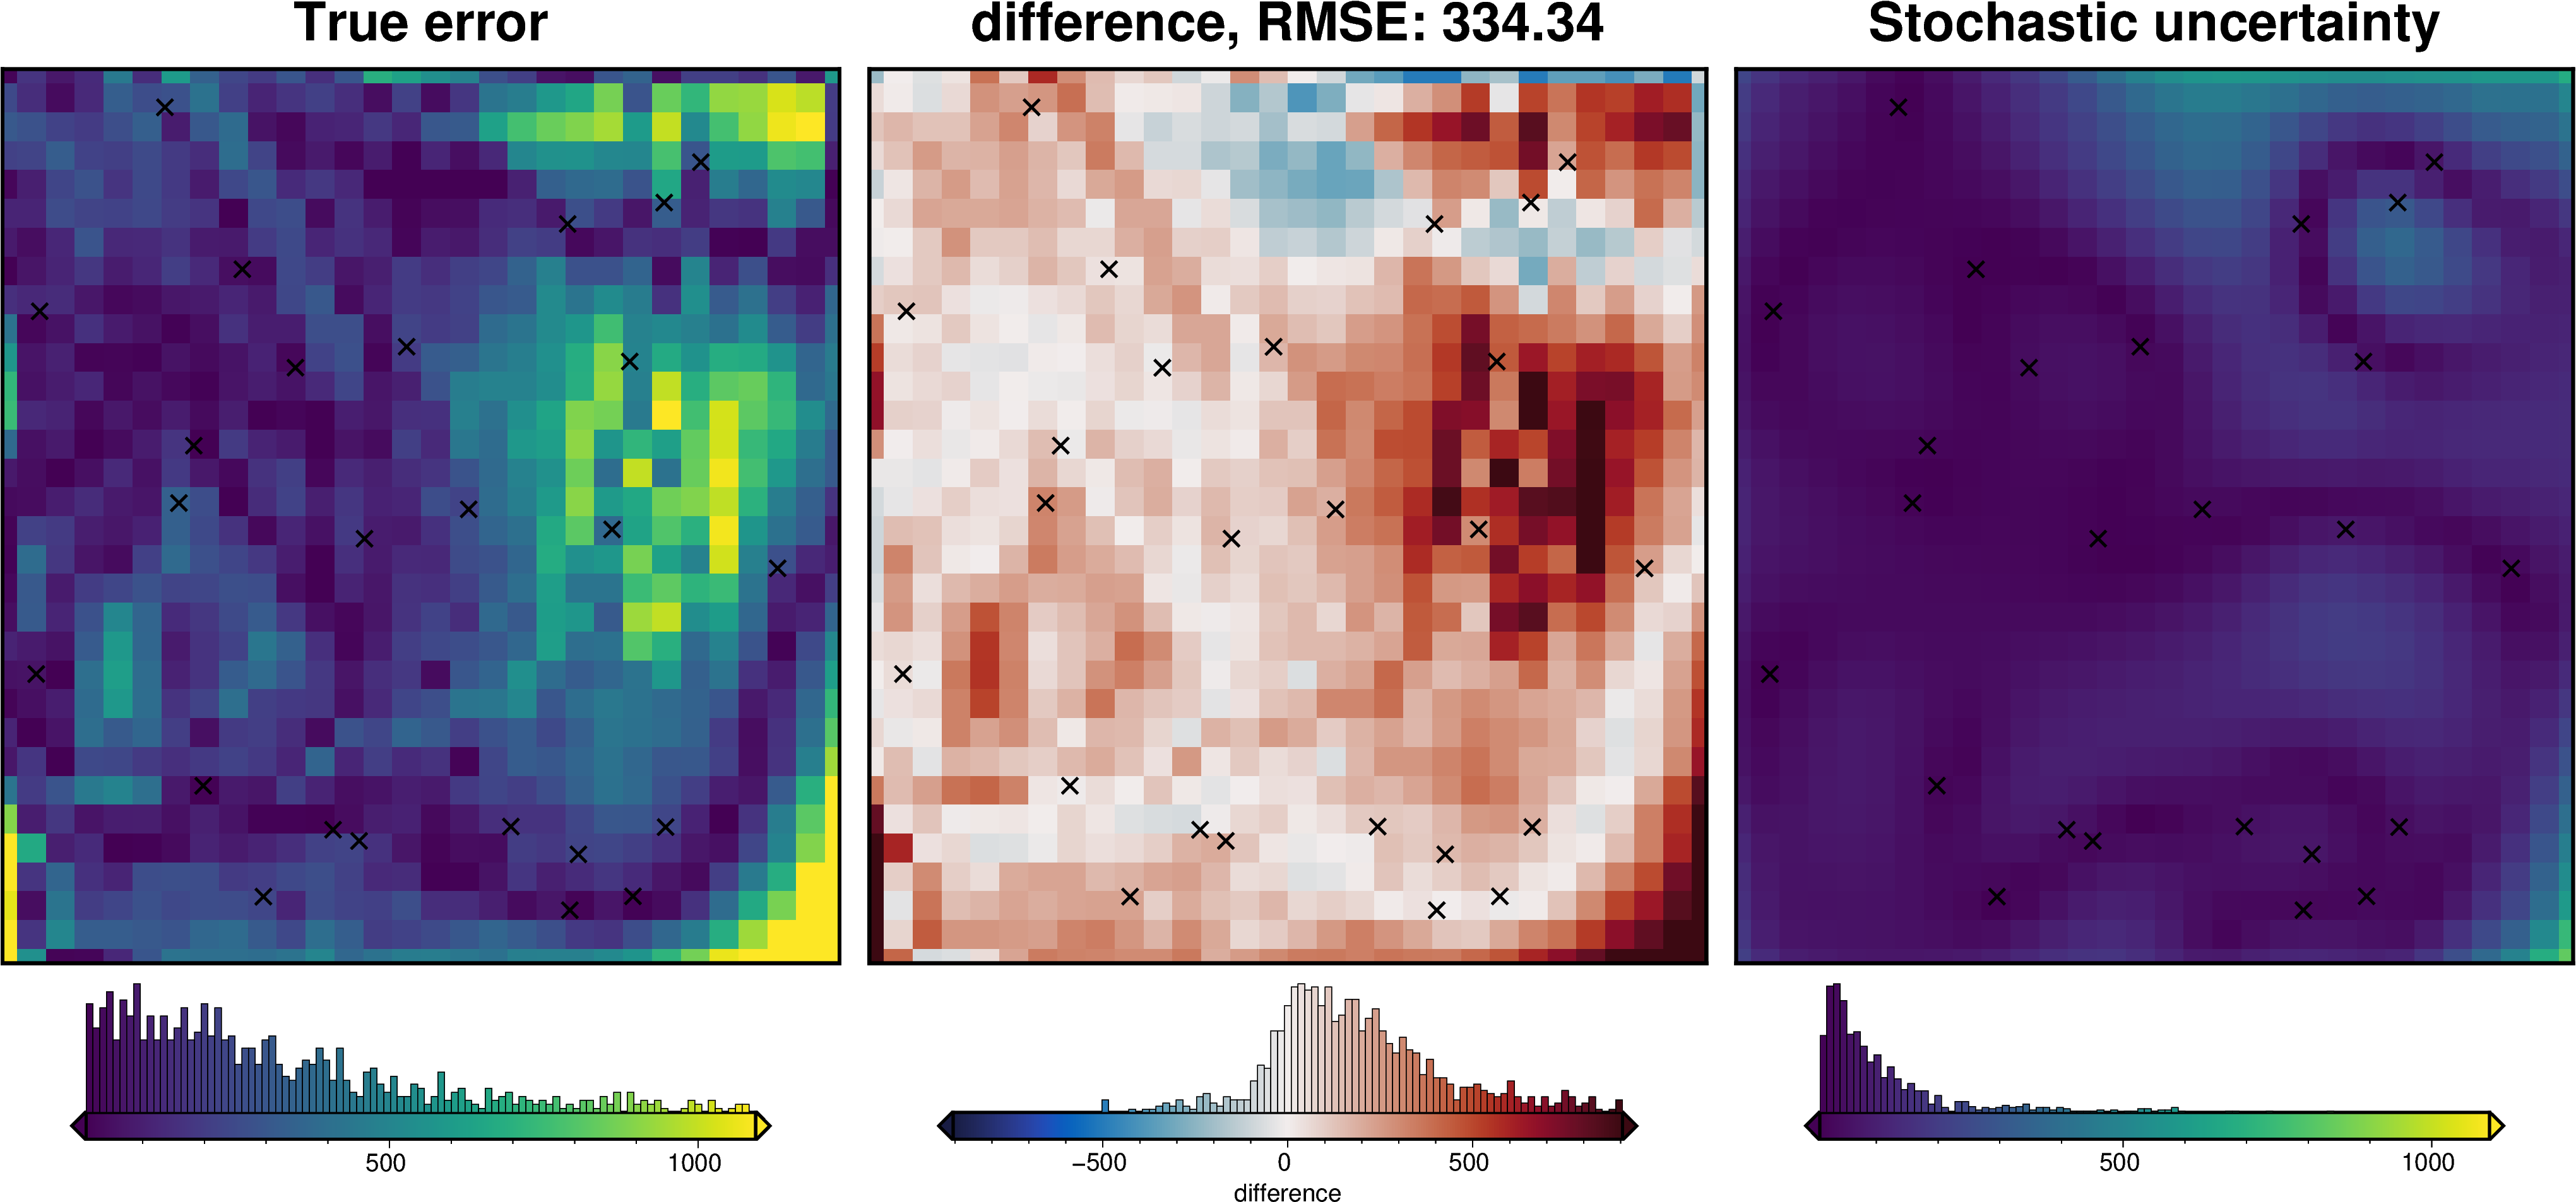

In [70]:
fname = "tmp/bishop_uncertainty_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_regional_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_regional_results)

### Total Uncertainty

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 281.3849798522568, min: -12.609617828751482, max: 575.3795775332651
INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.0069775384395132966, min: 0.002563528595105504, max: 0.015589197529536268
INFO:invert4geom:Sampled 'dampings' parameter values; mean: 6.070821665577805e-16, min: 1.5510464167373608e-22, max: 1.072706057099181e-14
INFO:invert4geom:Sampled 'depth' parameter values; mean: 158311.95494911776, min: 74758.42317041672, max: 241865.4867278188
INFO:invert4geom:Sampled 'damping' parameter values; mean: 6.781276584285748e-09, min: 9.195590342721111e-12, max: 7.647290436672651e-08
INFO:invert4geom:No pickle files starting with 'tmp/bishop_uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/bishop_uncertainty_full'



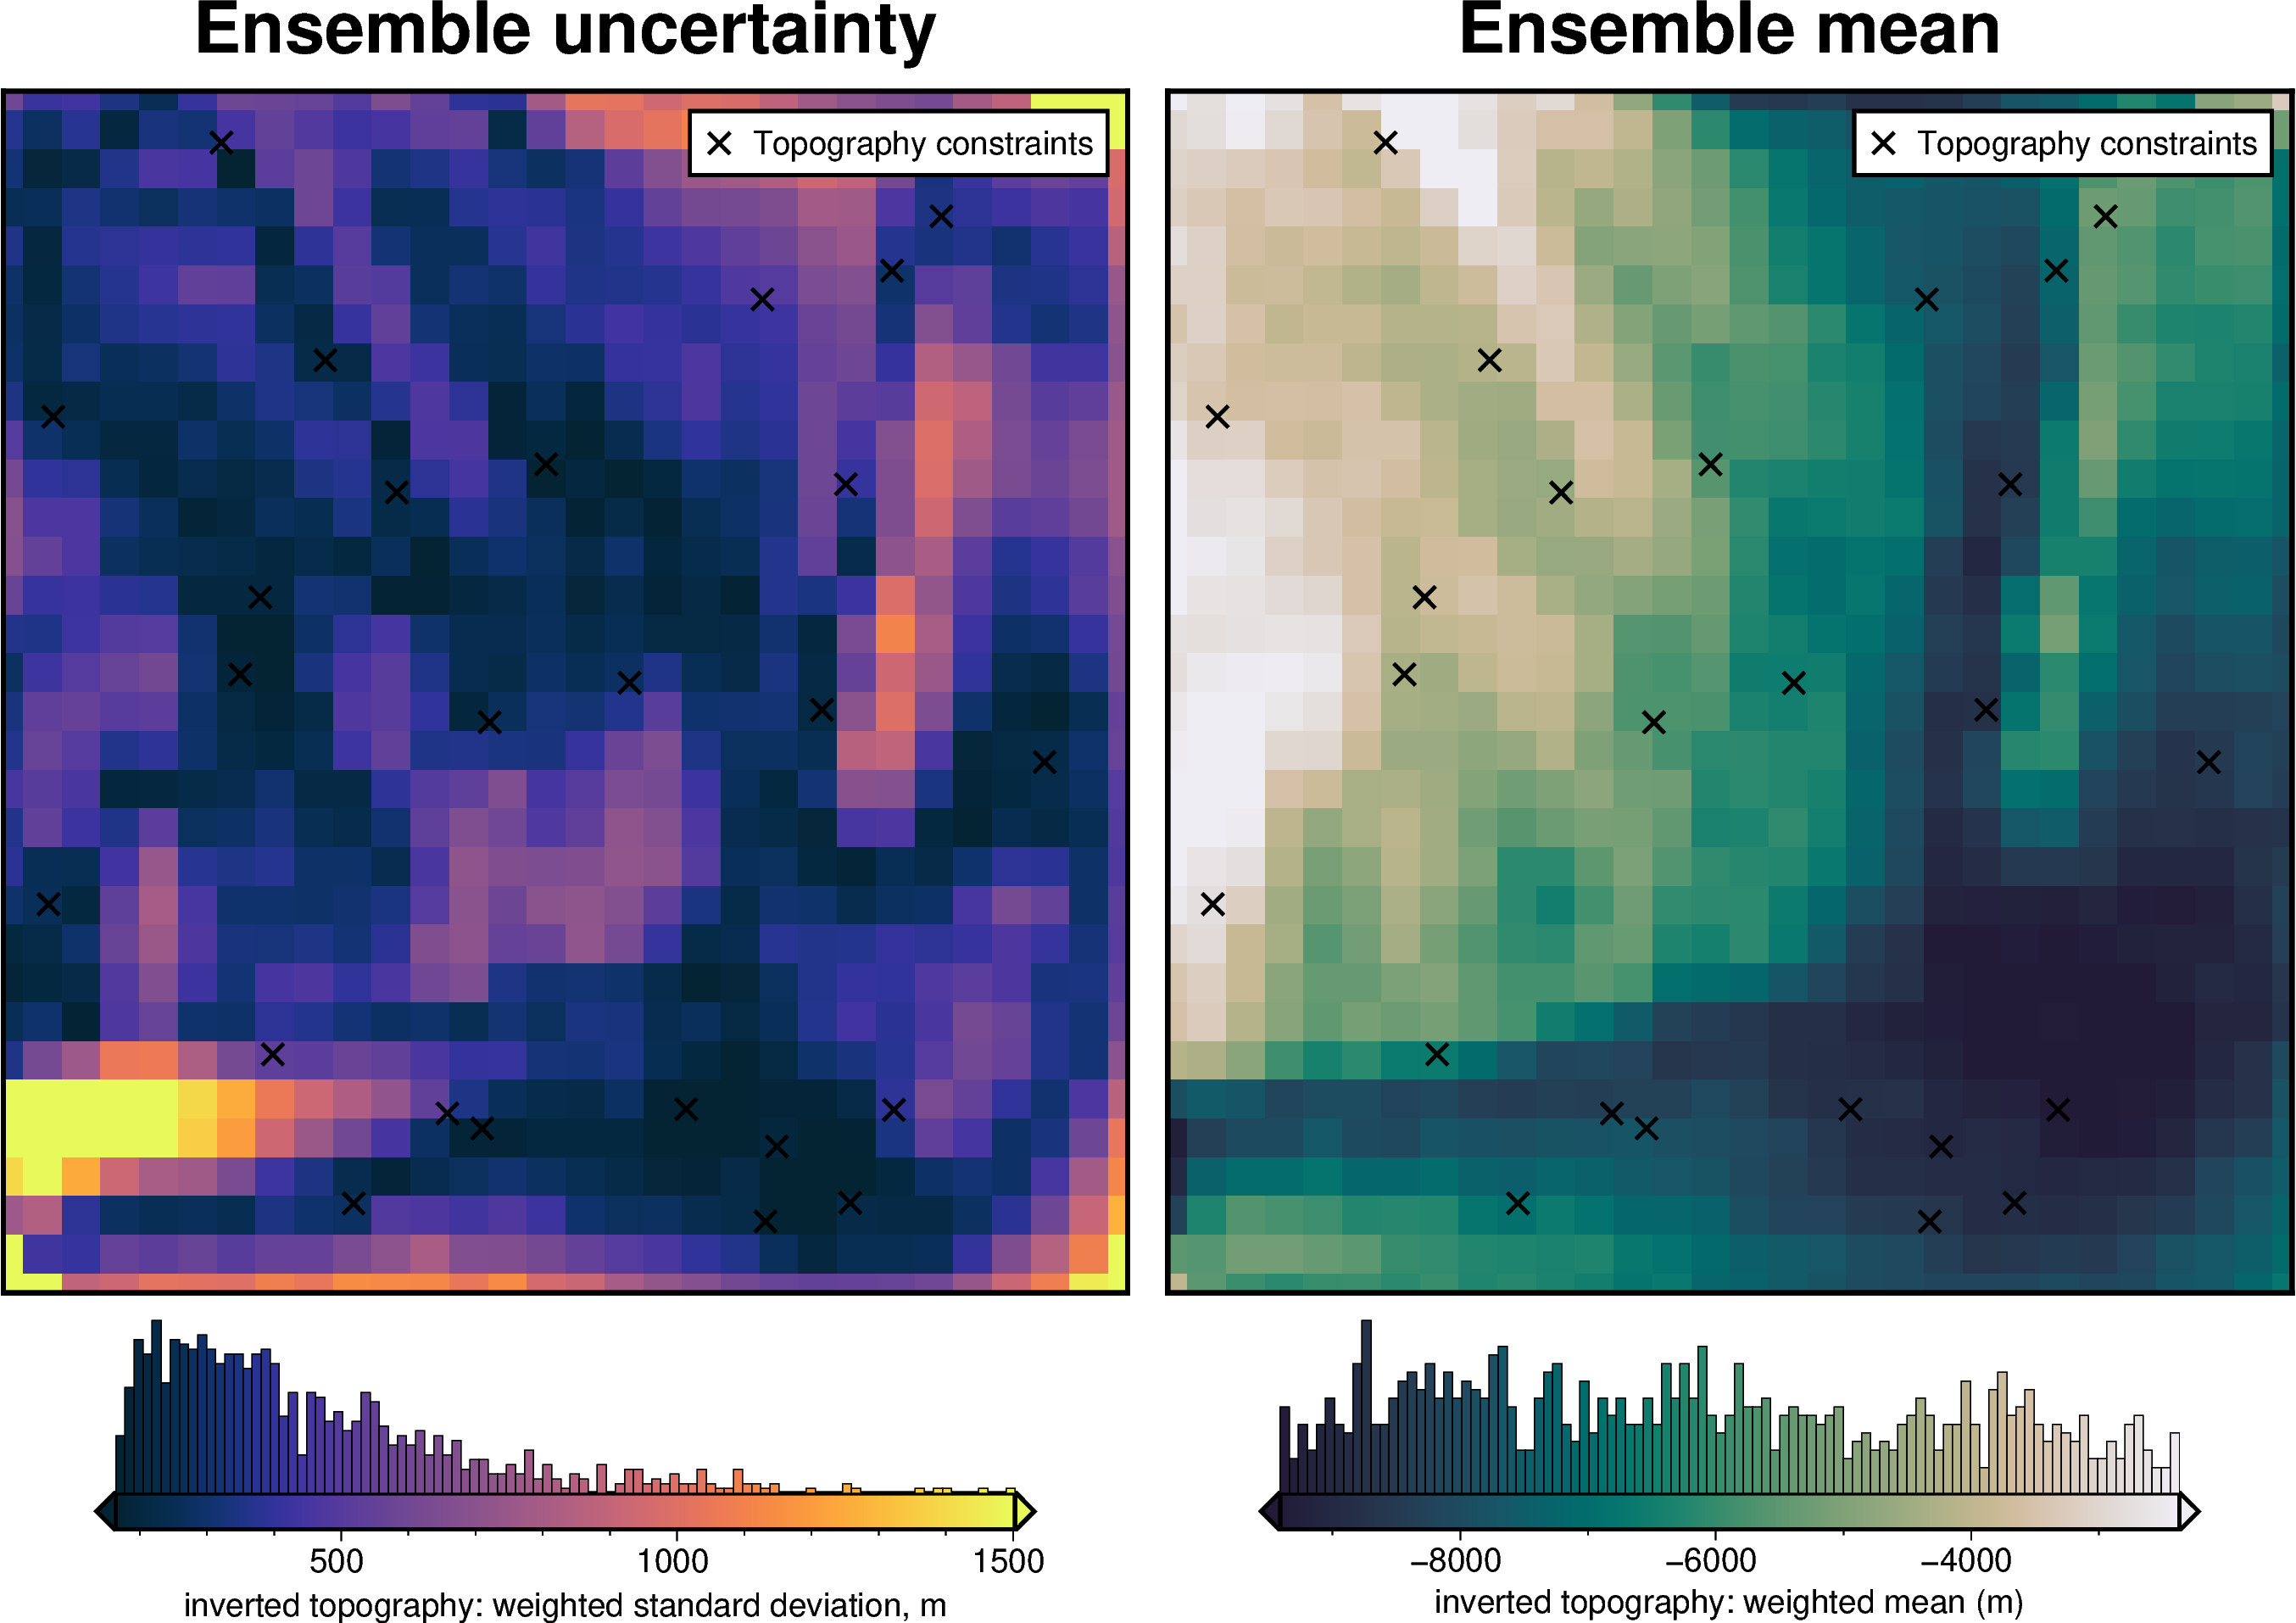

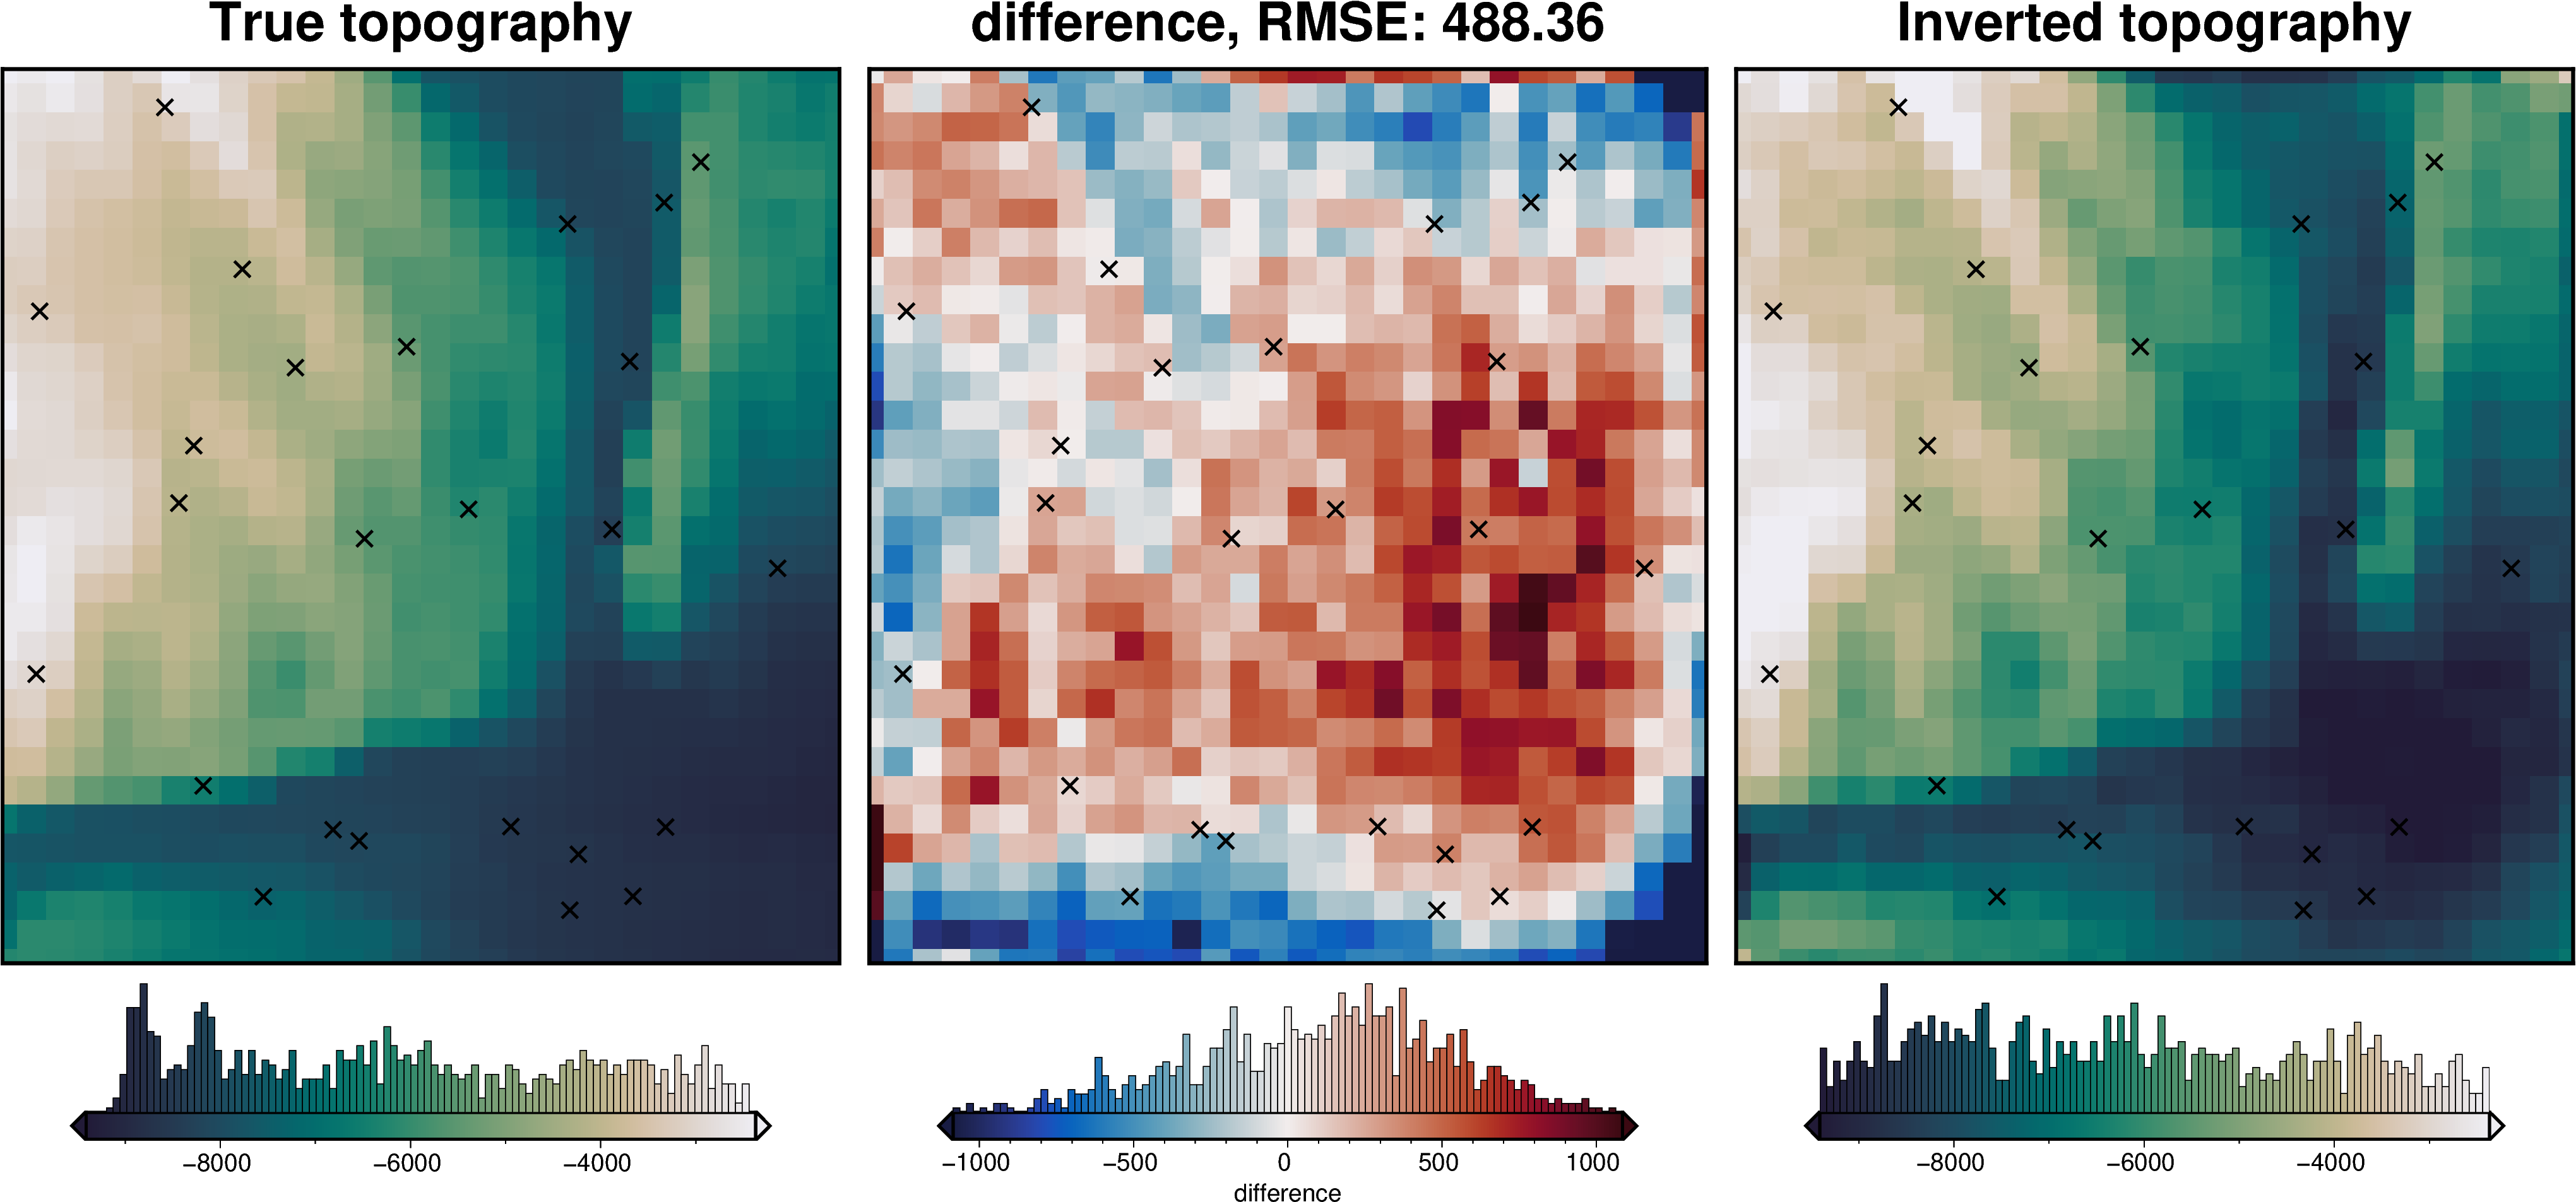

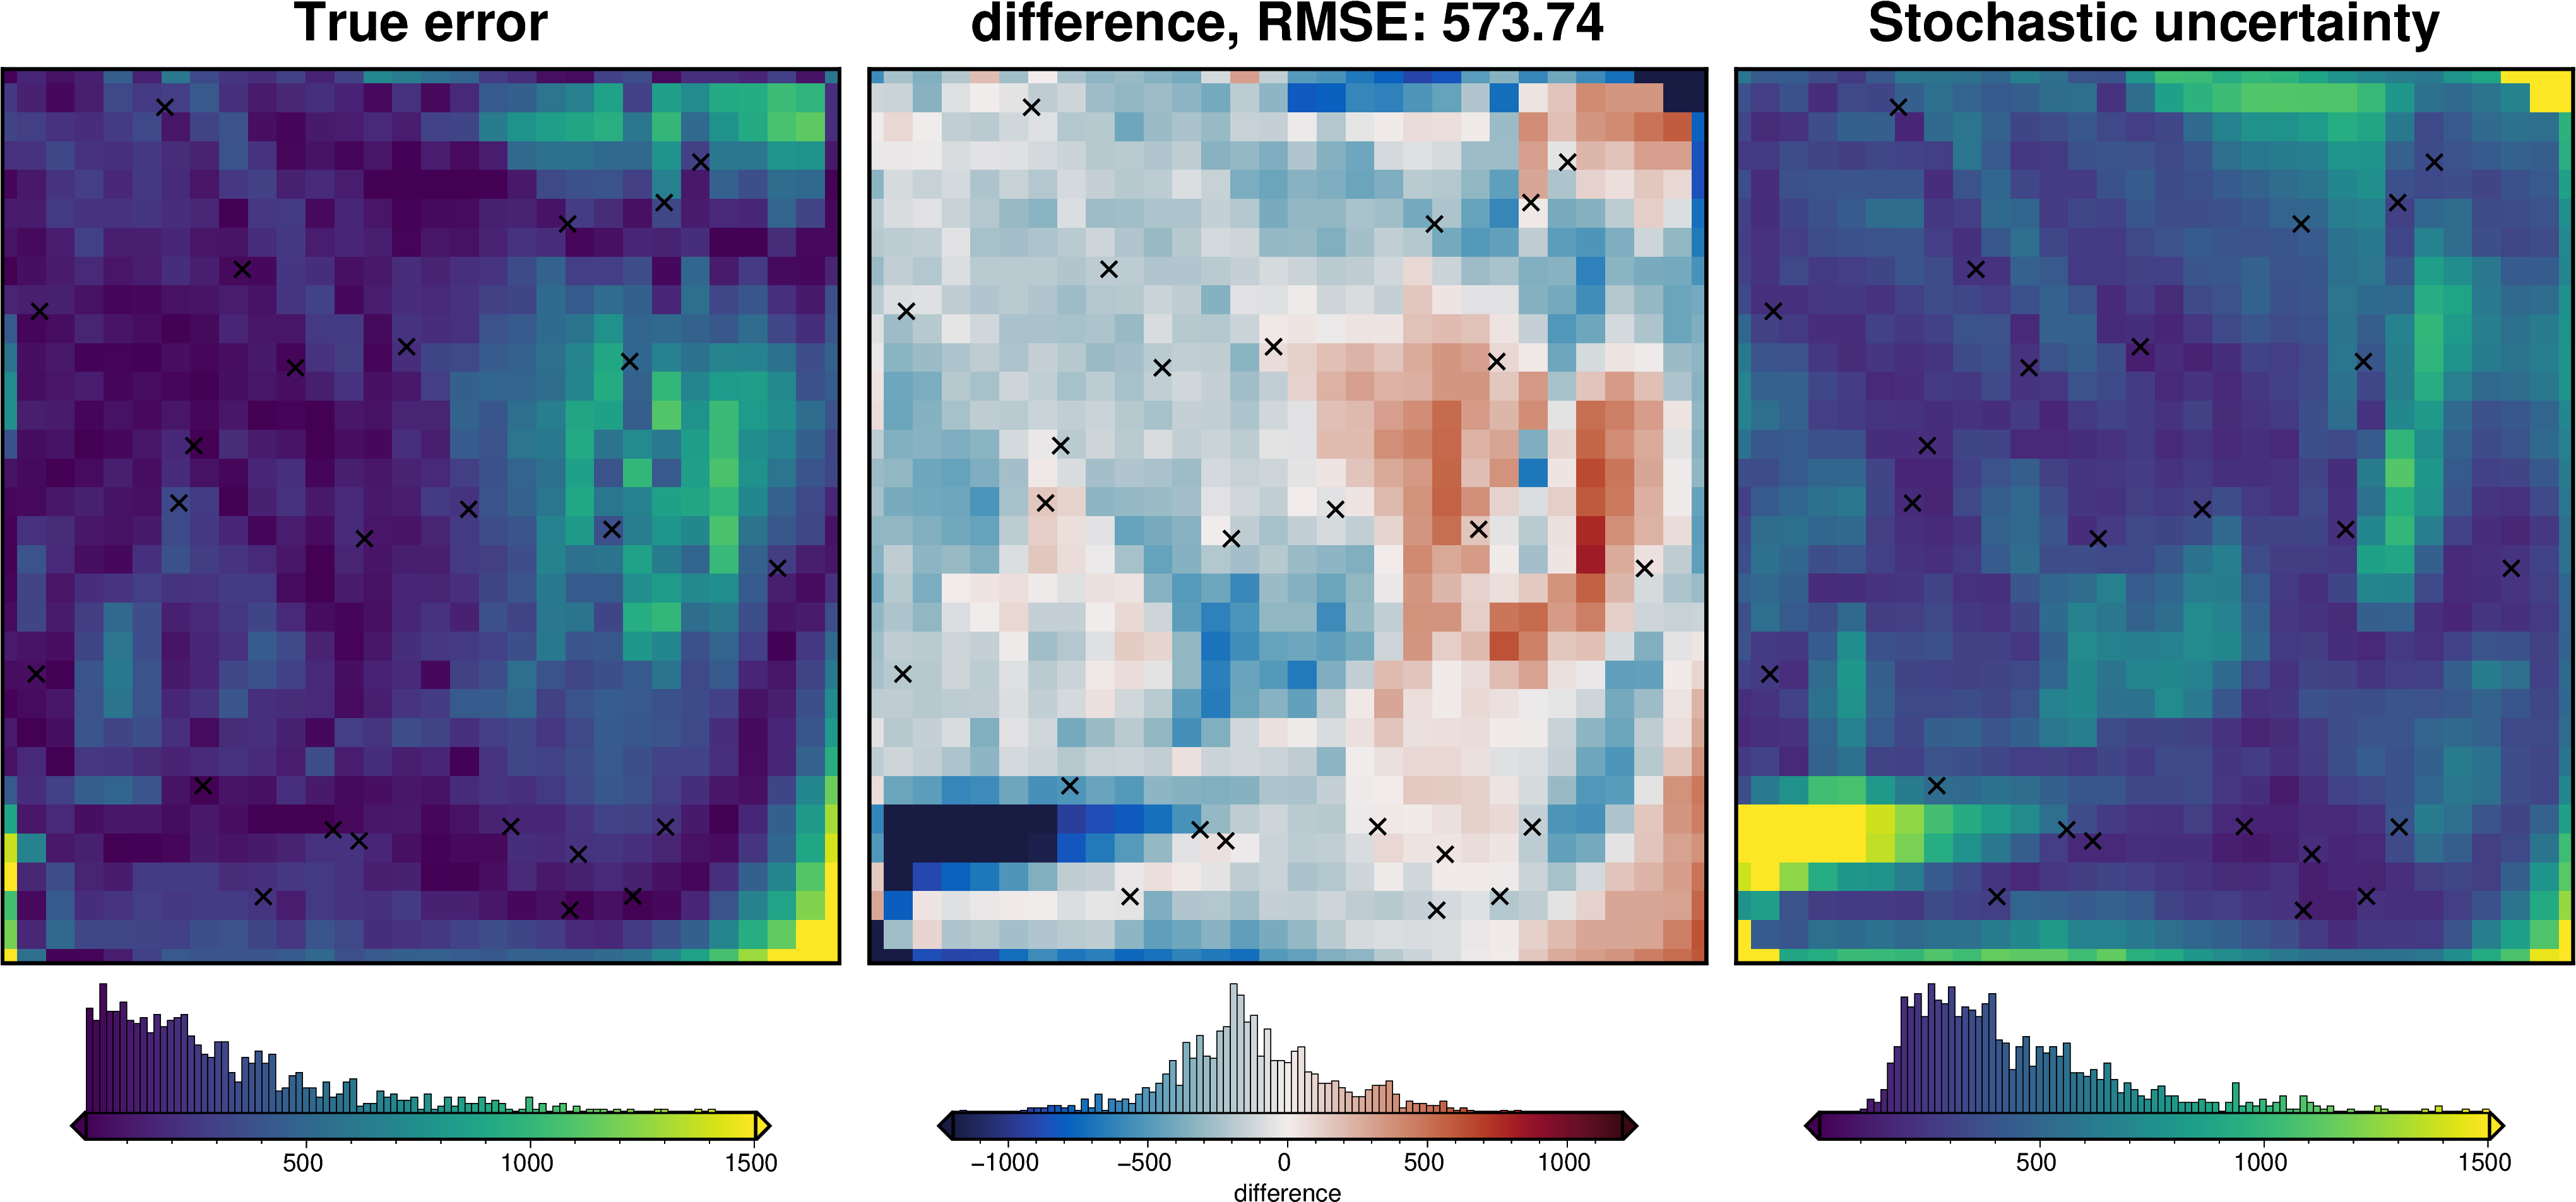

In [71]:
fname = "tmp/bishop_uncertainty_full"

parameter_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": 150,
    },
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean base 10 exponent
        "scale": 0.2,
        "log": True,
    },
}

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    sample_gravity=True,
    sample_constraints=True,
    parameter_dict=parameter_dict,
    starting_topography_parameter_dict=starting_topography_parameter_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_results)

## Comparing results

In [72]:
results = [
    uncert_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_density_results,
    uncert_damping_results,
    uncert_starting_topo_results,
    uncert_regional_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
    )
    stats.append(ds)

In [73]:
names = ["full", "grav", "constraints", "density", "damping", "topo", "regional"]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 86kB
Dimensions:            (northing: 40, easting: 38)
Coordinates:
  * northing           (northing) float64 320B 1.459e+05 1.559e+05 ... 5.359e+05
  * easting            (easting) float64 304B 6.9e+03 1.69e+04 ... 3.769e+05
Data variables:
    full_stdev         (northing, easting) float64 12kB 1.631e+03 ... 1.454e+03
    grav_stdev         (northing, easting) float64 12kB 0.1813 0.06709 ... 2.034
    constraints_stdev  (northing, easting) float64 12kB 1.529e+03 ... 1.751e+03
    density_stdev      (northing, easting) float64 12kB 176.3 164.4 ... 240.3
    damping_stdev      (northing, easting) float64 12kB 0.06257 ... 0.6796
    topo_stdev         (northing, easting) float64 12kB 0.07111 ... 0.005591
    regional_stdev     (northing, easting) float64 12kB 0.1601 0.06036 ... 3.811

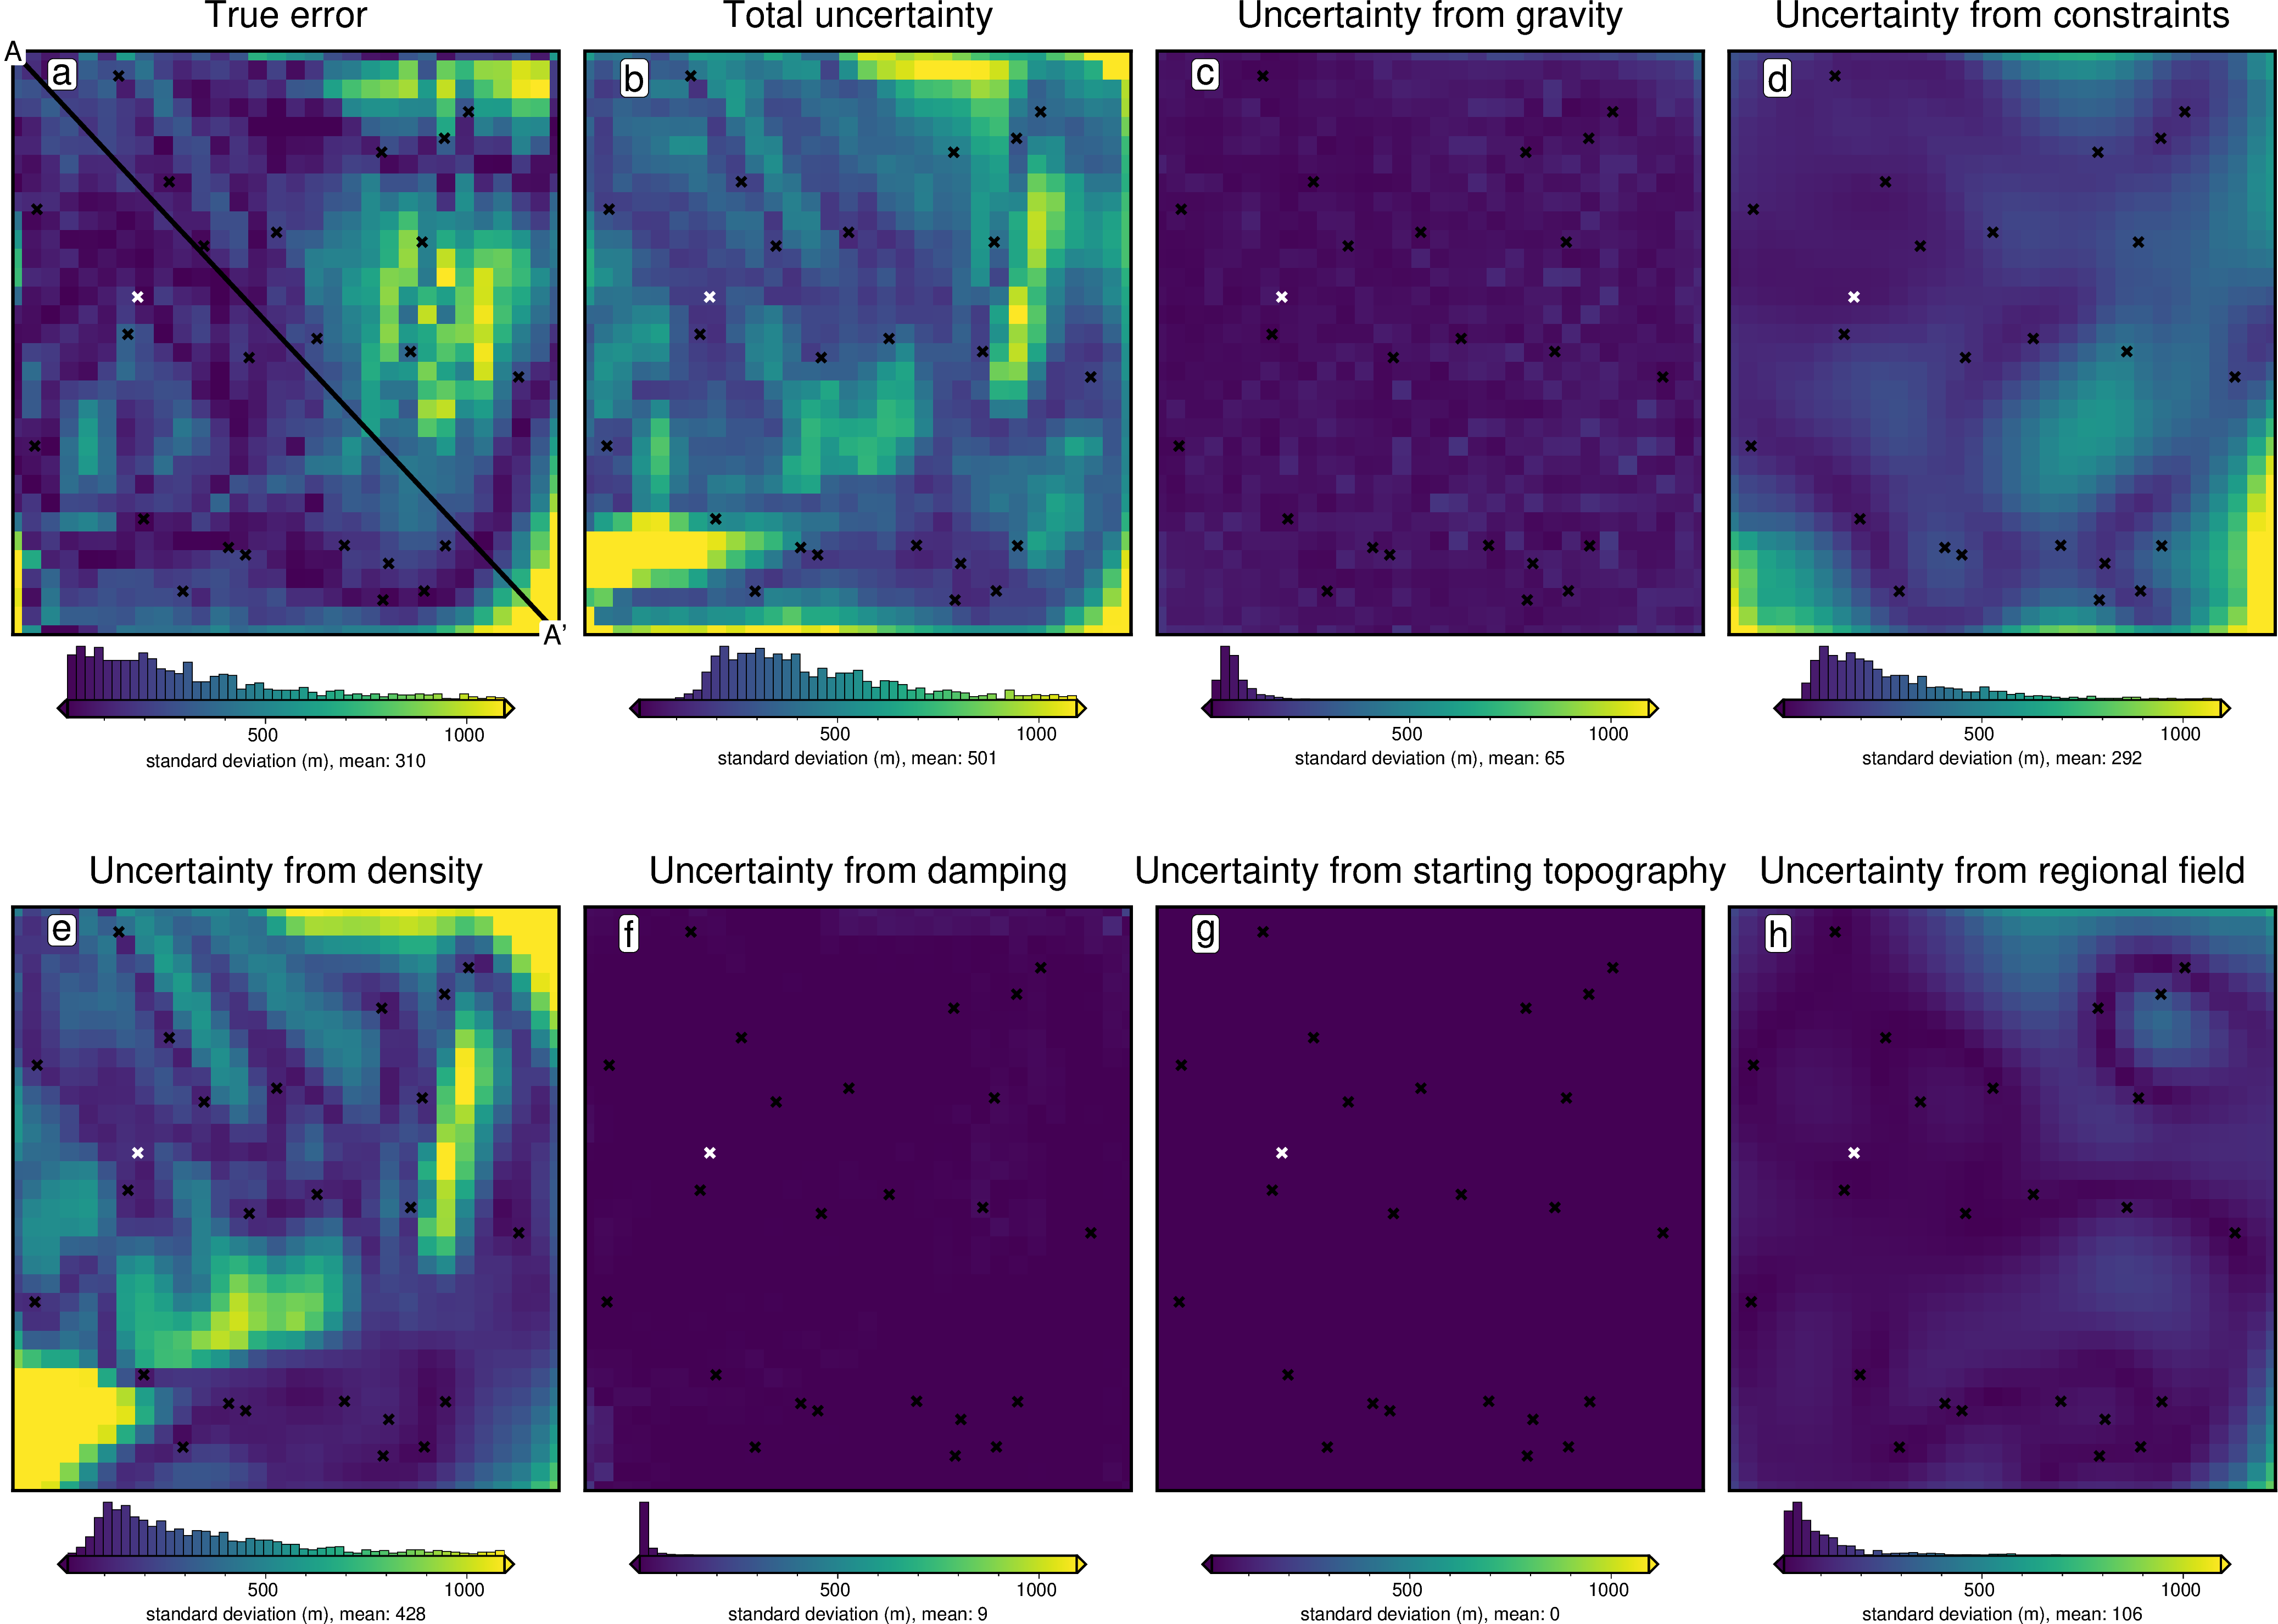

In [74]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from density",
    "Uncertainty from damping",
    "Uncertainty from starting topography",
    "Uncertainty from regional field",
]
grids = list(merged.data_vars.values())

# grids.insert(0, np.abs(stats[0].weighted_mean - grid.basement_topo))
grids.insert(0, inversion_error)

grids = [
    g.sel(
        {
            "easting": slice(*inversion_region[:2]),
            "northing": slice(*inversion_region[2:]),
        }
    )
    for g in grids
]

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
        cpt_lims = polar_utils.get_min_max(
            g,
            robust=True,
        )
    elif i == 4:
        origin_shift = "both_shift"
        xshift_amount = -3
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        # cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

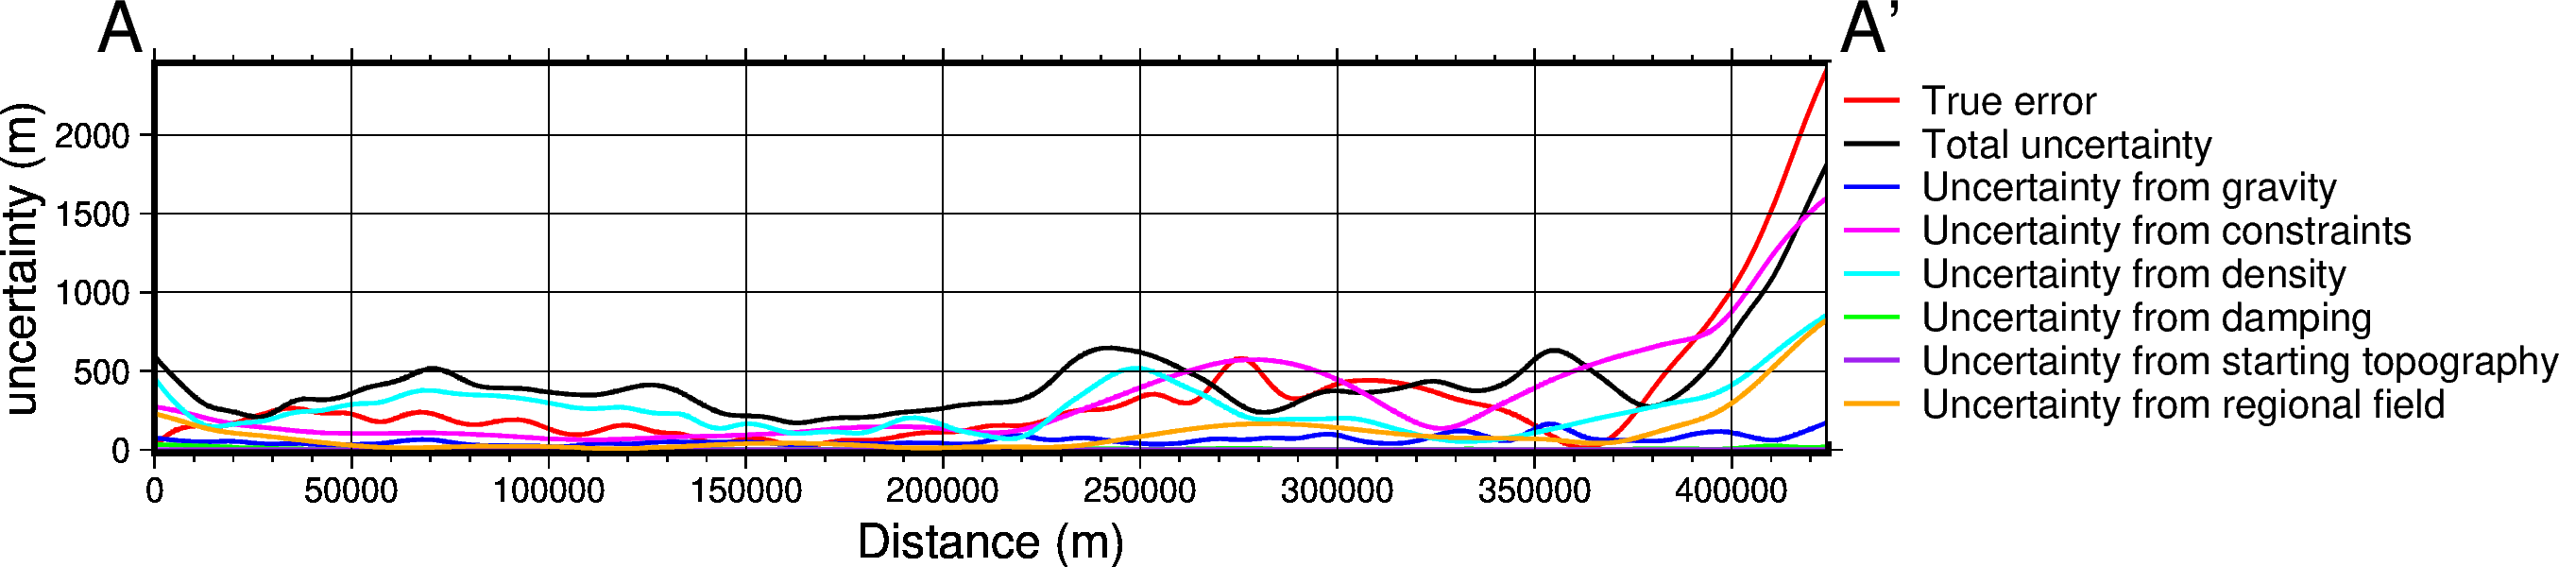

In [75]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
        "orange",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inversion_region[0], inversion_region[3]],
    stop=[inversion_region[1], inversion_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()